# Import Libraries & Data

In [1]:
from func_data import get_stock_data, data_overview, outlier_analysis, analysis, clas_train_test_trade_split, reg_train_test_trade_split, data_preprocessor, data_transform, split_sequences, rl_formatting
from func_labeling import baseline_labeling, fixed_horizon, get_meta_barrier, final_meta_labeling, meta_labeling, mean_confidence_interval, get_best_window
from func_trading import economic_indicator, technical_indicator, get_trading_log, get_trading_report
from func_feature import feature_correlation, cal_vif, fs_hierarchical_clustering, fs_importance, reg_fs_importance, fs_final
from func_model import clas_model_selection, reg_model_selection, clas_rs, reg_rs, clas_gs, reg_gs, clas_evaluation, reg_evaluation, create_env

import numpy as np
np.random.seed(0)
import pandas as pd
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import datetime
from datetime import datetime, timedelta
import time
import pickle
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import joblib
import eli5

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
pd.set_option('display.float_format',lambda x : '%.2f' % x)
plt.style.use('seaborn')

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from fbprophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, accuracy_score, log_loss, classification_report, f1_score, balanced_accuracy_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, GroupShuffleSplit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Nadam, RMSprop, SGD
from keras.constraints import maxnorm
from tensorflow.keras.callbacks import EarlyStopping

from stable_baselines3 import A2C
from stable_baselines3 import DDPG
from stable_baselines3 import PPO
from stable_baselines3 import TD3
from stable_baselines3 import SAC

In [2]:
print("Version: ", tf.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.2.0
GPU is NOT AVAILABLE


# Get Data

In [14]:
# training
train_start = '2009-01-01'
train_end = '2018-12-31'
# 1testing
test_start = '2019-01-01'
test_end = '2019-12-31'
# trading
trade_start = '2020-01-01'
trade_end = '2020-12-31'

# whole data
start = train_start
end = trade_end

In [15]:
# SPY = get_stock_data("SPY", start="2008-01-01", end=end)
# SPY.to_csv('data/raw/SPY.csv')
SPY = pd.read_csv('data/raw/SPY.csv', index_col='Date')
SPY.index = pd.to_datetime(SPY.index)

In [16]:
# TLT = get_stock_data("TLT", start="2008-01-01", end=end)
# TLT.to_csv('data/raw/TLT.csv')
TLT = pd.read_csv('data/raw/TLT.csv', index_col='Date')
TLT.index = pd.to_datetime(TLT.index)

In [17]:
# USO = get_stock_data("USO", start="2008-01-01", end=end)
# USO.to_csv('data/raw/USO.csv')
USO = pd.read_csv('data/raw/USO.csv', index_col='Date')
USO.index = pd.to_datetime(USO.index)

# Exploratory Data Analysis

## Data Overview

In [6]:
data_overview(SPY)

             Open   High    Low  Close     Volume
Date                                             
2008-01-02 112.03 112.39 110.01 110.81  204935600
2008-01-03 110.80 111.24 110.15 110.76  125133300
2008-01-04 109.60 109.67 107.74 108.04  232330900
2008-01-07 108.43 108.75 107.12 107.95  234991000
2008-01-08 108.63 109.26 105.85 106.21  326365700 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3273 entries, 2008-01-02 to 2020-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3273 non-null   float64
 1   High    3273 non-null   float64
 2   Low     3273 non-null   float64
 3   Close   3273 non-null   float64
 4   Volume  3273 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 153.4 KB
None 

         Open    High     Low   Close       Volume
count 3273.00 3273.00 3273.00 3273.00      3273.00
mean   173.42  174.39  172.35  173.44 147440071.16
std     77.00   77.31   76.64   76.99 100206075.07
mi

In [7]:
data_overview(TLT)

            Open  High   Low  Close   Volume
Date                                        
2008-01-02 63.43 64.43 63.39  64.19  2959600
2008-01-03 63.94 64.19 63.71  64.11  1256700
2008-01-04 64.28 64.47 64.07  64.12  2420200
2008-01-07 64.06 64.47 63.96  64.40  1315500
2008-01-08 64.24 64.42 63.89  64.32  1604800 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3273 entries, 2008-01-02 to 2020-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3273 non-null   float64
 1   High    3273 non-null   float64
 2   Low     3273 non-null   float64
 3   Close   3273 non-null   float64
 4   Volume  3273 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 153.4 KB
None 

         Open    High     Low   Close      Volume
count 3273.00 3273.00 3273.00 3273.00     3273.00
mean   101.35  101.82  100.88  101.35  7951618.24
std     25.72   25.81   25.62   25.70  4817613.66
min     61.65   61.80   61.39   61.58   4

In [9]:
data_overview(USO)

             Open   High    Low  Close  Volume
Date                                          
2008-01-02 619.04 630.48 617.68 627.76  554875
2008-01-03 629.04 632.72 622.32 626.96  626013
2008-01-04 621.60 622.48 613.68 618.48  518175
2008-01-07 616.56 616.56 597.36 604.00  549188
2008-01-08 613.68 616.56 606.16 608.48  325600 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3273 entries, 2008-01-02 to 2020-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3273 non-null   float64
 1   High    3273 non-null   float64
 2   Low     3273 non-null   float64
 3   Close   3273 non-null   float64
 4   Volume  3273 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 153.4 KB
None 

         Open    High     Low   Close       Volume
count 3273.00 3273.00 3273.00 3273.00      3273.00
mean   222.58  225.13  219.79  222.57   2754180.79
std    163.95  166.05  161.47  163.89   4195166.15
min     17.28   18.00  

## Visualization

In [7]:
palette = 'Paired_r'

### Line Plot (numeric)

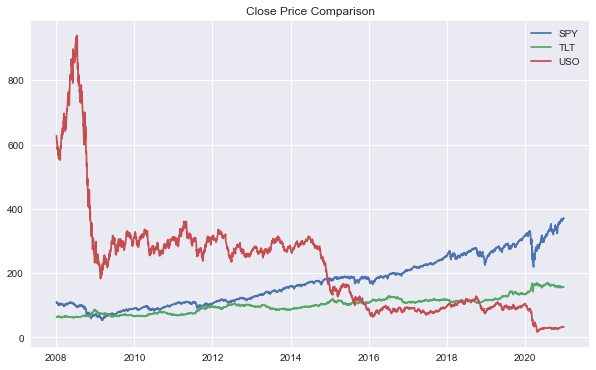

In [8]:
# Close
plt.figure(figsize=(10,6))
plt.plot(SPY['Close'], label='SPY')
plt.plot(TLT['Close'], label='TLT')
plt.plot(USO['Close'], label='USO')
plt.title('Close Price Comparison')
plt.legend();

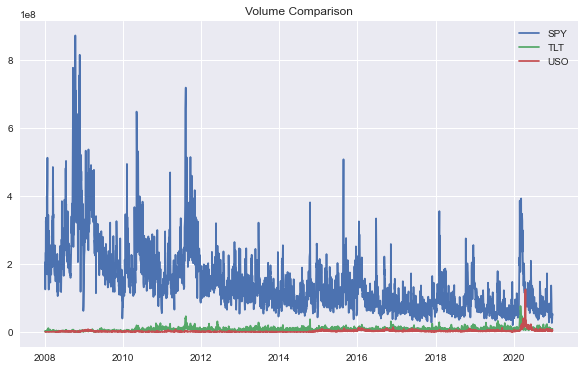

In [9]:
# Volume
plt.figure(figsize=(10,6))
plt.plot(SPY['Volume'], label='SPY')
plt.plot(TLT['Volume'], label='TLT')
plt.plot(USO['Volume'], label='USO')
plt.title('Volume Comparison')
plt.legend();

### Histograms & Density Plot (numeric)

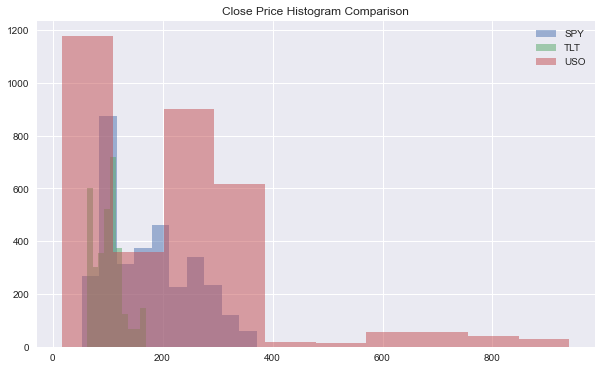

In [10]:
# Close
plt.figure(figsize=(10,6))
SPY['Close'].hist(alpha=0.5, label='SPY')
TLT['Close'].hist(alpha=0.5, label='TLT')
USO['Close'].hist(alpha=0.5, label='USO')
plt.title('Close Price Histogram Comparison')
plt.legend();

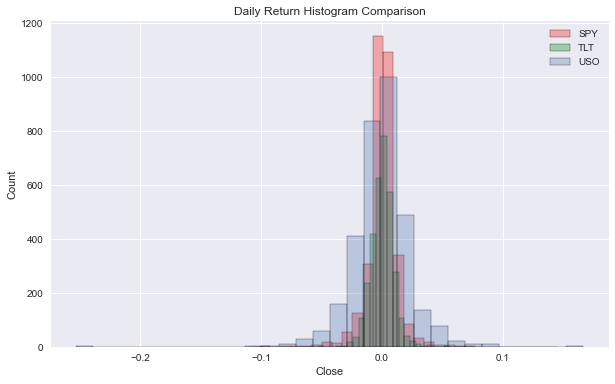

In [11]:
# Daily Return
SPY_drs = SPY['Close'].pct_change(1)
SPY_drs.iloc[0] = 0
TLT_drs = TLT['Close'].pct_change(1)
TLT_drs.iloc[0] = 0
USO_drs = USO['Close'].pct_change(1)
USO_drs.iloc[0] = 0

plt.figure(figsize=(10,6))
sns.histplot(SPY_drs, bins=30, label='SPY', color='RED', alpha=0.3)
sns.histplot(TLT_drs, bins=30, label='TLT', color='GREEN', alpha=0.3)
sns.histplot(USO_drs, bins=30, label='USO', alpha=0.3)
plt.title('Daily Return Histogram Comparison')
plt.legend();

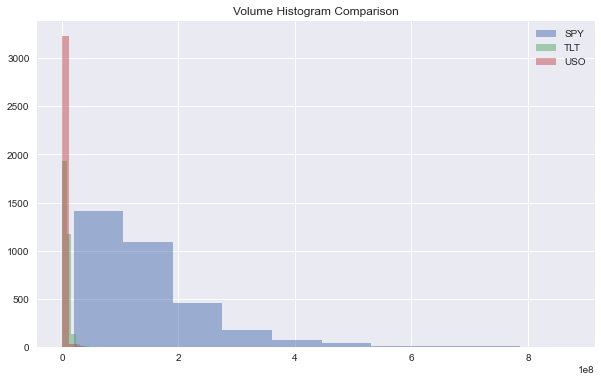

In [12]:
# Volume
plt.figure(figsize=(10,6))
SPY['Volume'].hist(alpha=0.5, label='SPY')
TLT['Volume'].hist(alpha=0.5, label='TLT')
USO['Volume'].hist(alpha=0.5, label='USO')
plt.title('Volume Histogram Comparison')
plt.legend();

### Jointplot (numeric)

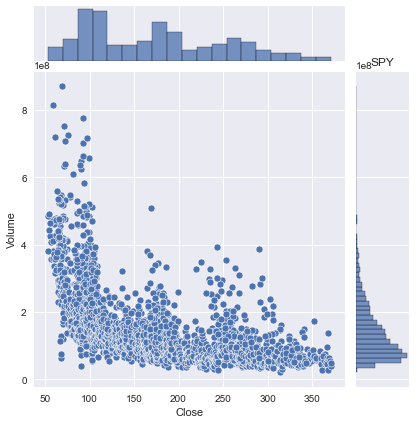

In [13]:
sns.jointplot(data=SPY, x='Close',y='Volume')
plt.title('SPY');

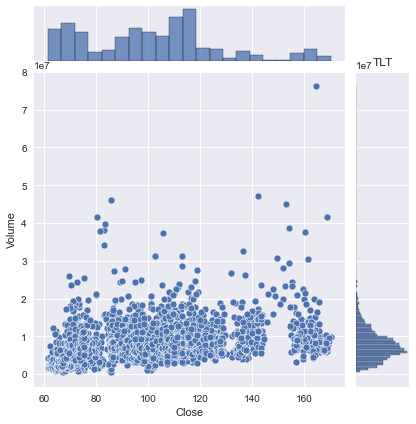

In [14]:
sns.jointplot(data=TLT, x='Close',y='Volume')
plt.title('TLT');

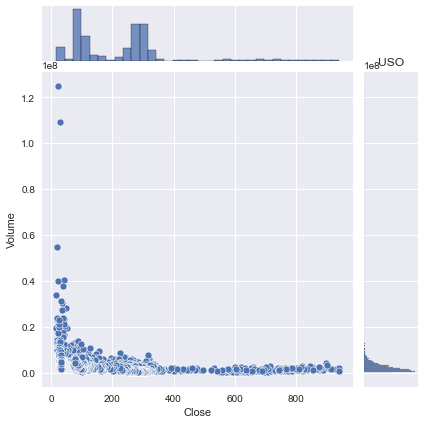

In [15]:
sns.jointplot(data=USO, x='Close',y='Volume')
plt.title('USO');

# Labeling & Trading Report

In [31]:
principle = 10000
percent = 0.7

## Meta-Labeling

SPY

In [8]:
# TP_SPY, SL_SPY, WINDOW_SPY, HORIZON_SPY = get_best_window(SPY, principle=principle, percent=percent)

In [2]:
TP_SPY, SL_SPY, WINDOW_SPY, HORIZON_SPY = 0.005, 0.005, 5, 5

In [3]:
# SPY_labeled, SPY_TIs = meta_labeling(SPY, WINDOW=WINDOW_SPY, HORIZON=HORIZON_SPY, TP=TP_SPY, SL=SL_SPY * -1)
# with open('data/processed/SPY_TIs.txt', 'wb') as fp:
#     pickle.dump(SPY_TIs, fp)
# SPY_labeled.to_csv('data/processed/SPY_labeled.csv')

with open ('data/processed/SPY_TIs.txt', 'rb') as fp:
    SPY_TIs = pickle.load(fp)
SPY_labeled = pd.read_csv('data/processed/SPY_labeled.csv', index_col='Date')
SPY_labeled.index = pd.to_datetime(SPY_labeled.index)
SPY_labeled.head()

Close  Label   Open   High    Low     Volume
Date                                                    
2008-01-09 107.32      0 106.35 107.65 105.28  301824900
2008-01-10 108.03     -1 106.80 109.18 106.56  335701200
2008-01-11 107.16     -1 107.64 108.49 106.28  267076600
2008-01-14 108.02     -1 107.93 108.46 107.35  170365500
2008-01-15 105.64     -1 106.88 108.18 105.44  239940100

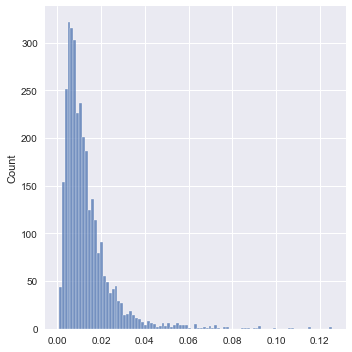

Mean, CI for threshold: (0.013309665000837858, 0.01277109790174713, 0.013848232099928585)


In [92]:
sns.displot(SPY_TIs)
plt.show()
print('Mean, CI for threshold:',mean_confidence_interval(SPY_TIs, confidence=0.99))

In [93]:
SPY_trading_log = get_trading_log(SPY_labeled.loc[start:end,:], principle=principle, percent=percent)
SPY_trading_log.head()

Close  Label  Open  High   Low     Volume  Buy to open  \
Date                                                                 
2009-01-02  72.79     -1 70.81 73.16 70.35  227566300            0   
2009-01-05  72.70     -1 72.53 73.33 71.95  240349700            0   
2009-01-06  73.19     -1 73.32 73.95 72.57  328260900            0   
2009-01-07  70.99     -1 72.03 72.24 70.63  280899200            0   
2009-01-08  71.28     -1 70.59 71.32 70.21  263834400            0   

            Buy to close  Sell to open  Sell to close  Position  Cost  \
Date                                                                    
2009-01-02             0             1              0    -96.00 72.79   
2009-01-05             0             0              0    -96.00 72.79   
2009-01-06             0             0              0    -96.00 72.79   
2009-01-07             0             0              0    -96.00 72.79   
2009-01-08             0             0              0    -96.00 72.79   

            Invest Amt  Duration  Profit  Profit %  Cum Profit  Principle  \
Date                                                                        
2009-01-02     6987.50         1    0.00      0.00        0.00   10000.00   
2009-01-05     6987.50         2    0.00      0.00        0.00   10008.27   
2009-01-06     6987.50         3    0.00      0.00        0.00    9961.67   
2009-01-07     6987.50         4    0.00      0.00        0.00   10172.13   
2009-01-08     6987.50         5    0.00      0.00        0.00   10144.32   

            Daily Return  
Date                      
2009-01-02          0.00  
2009-01-05          0.00  
2009-01-06         -0.00  
2009-01-07          0.02  
2009-01-08         -0.00

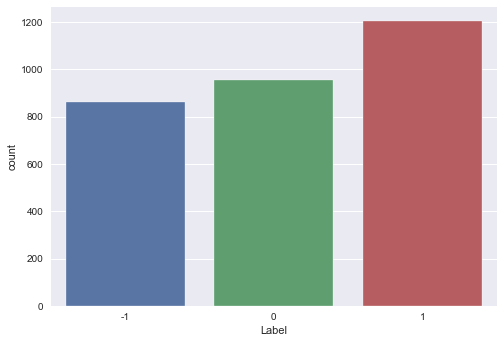

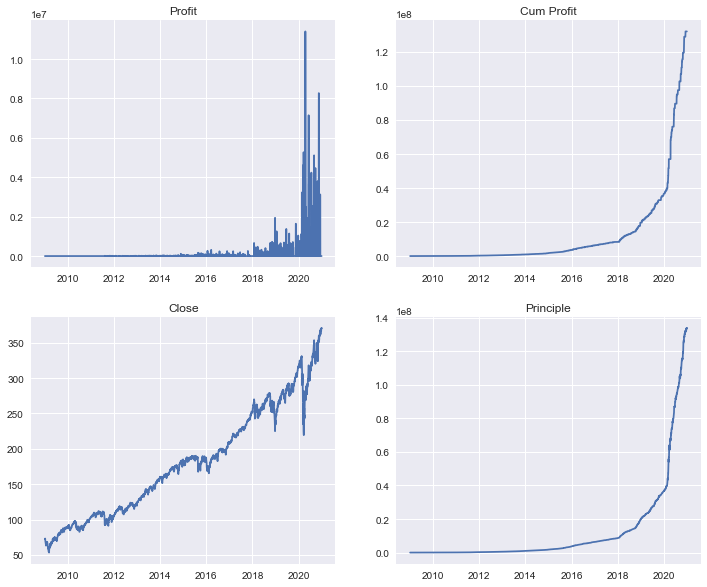

+------------+--------------+-------------+--------------+----------+--------+
|   Model    |    Profit    |   Profit %  | Annualized % | Duration | Sharpe |
+------------+--------------+-------------+--------------+----------+--------+
|  Strategy  | 133769389.81 | 1337693.90% |   131.53%    |   2852   |  7.71  |
| Buy & Hold |   28606.96   |   286.07%   |    11.93%    |   3020   |  0.84  |
+------------+--------------+-------------+--------------+----------+--------+


In [94]:
SPY_report, _ = get_trading_report(SPY_trading_log, principle, percent, show_fig=True)
print(SPY_report)

TLT

In [95]:
# TP_TLT, SL_TLT, WINDOW_TLT, HORIZON_TLT = get_best_window(TLT, principle=principle, percent=percent)

In [4]:
TP_TLT, SL_TLT, WINDOW_TLT, HORIZON_TLT = 0.005, 0.005, 5, 5

In [5]:
# TLT_labeled, TLT_TIs = meta_labeling(TLT, WINDOW=WINDOW_TLT, HORIZON=HORIZON_TLT, TP=TP_TLT, SL=SL_TLT * -1)
# with open('data/processed/TLT_TIs.txt', 'wb') as fp:
#     pickle.dump(TLT_TIs, fp)
# TLT_labeled.to_csv('data/processed/TLT_labeled.csv')

with open ('data/processed/TLT_TIs.txt', 'rb') as fp:
    TLT_TIs = pickle.load(fp)
TLT_labeled = pd.read_csv('data/processed/TLT_labeled.csv', index_col='Date')
TLT_labeled.index = pd.to_datetime(TLT_labeled.index)
TLT_labeled.head()

Close  Label  Open  High   Low   Volume
Date                                               
2008-01-09  64.45     -1 64.47 64.82 64.36  2203500
2008-01-10  63.58      1 64.53 64.58 63.47  2681800
2008-01-11  64.07      1 63.61 64.13 63.53  1872900
2008-01-14  64.31      1 64.07 64.31 63.94   906100
2008-01-15  65.03      0 64.72 65.04 64.66  1435300

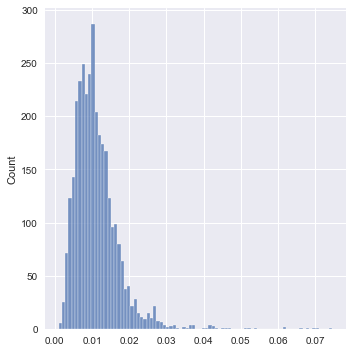

Mean, CI for threshold: (0.011235589959554426, 0.010950557895248991, 0.011520622023859861)


In [98]:
sns.displot(TLT_TIs)
plt.show()
print('Mean, CI for threshold:',mean_confidence_interval(TLT_TIs, confidence=0.99))

In [99]:
TLT_trading_log = get_trading_log(TLT_labeled.loc[start:end,:], principle=principle, percent=percent)
TLT_trading_log.head()

Close  Label  Open  High   Low   Volume  Buy to open  \
Date                                                               
2009-01-02  82.64     -1 85.27 85.55 82.64  3464200            0   
2009-01-05  80.51      0 82.11 82.50 79.97  5395200            0   
2009-01-06  79.70      0 79.28 80.44 78.84  4109300            0   
2009-01-07  80.01      0 79.52 80.03 79.12  2565600            0   
2009-01-08  79.95      1 80.00 80.20 79.54  2603600            0   

            Buy to close  Sell to open  Sell to close  Position  Cost  \
Date                                                                    
2009-01-02             0             1              0    -84.00 82.64   
2009-01-05             0             0              0    -84.00 82.64   
2009-01-06             0             0              0    -84.00 82.64   
2009-01-07             0             0              0    -84.00 82.64   
2009-01-08             1             0              0    -84.00 82.64   

            Invest Amt  Duration  Profit  Profit %  Cum Profit  Principle  \
Date                                                                        
2009-01-02     6941.58         1    0.00      0.00        0.00   10000.00   
2009-01-05     6941.58         2    0.00      0.00        0.00   10178.98   
2009-01-06     6941.58         3    0.00      0.00        0.00   10247.00   
2009-01-07     6941.58         4    0.00      0.00        0.00   10220.75   
2009-01-08     6941.58         5  226.12      0.03      226.12   10226.12   

            Daily Return  
Date                      
2009-01-02          0.00  
2009-01-05          0.02  
2009-01-06          0.01  
2009-01-07         -0.00  
2009-01-08          0.00

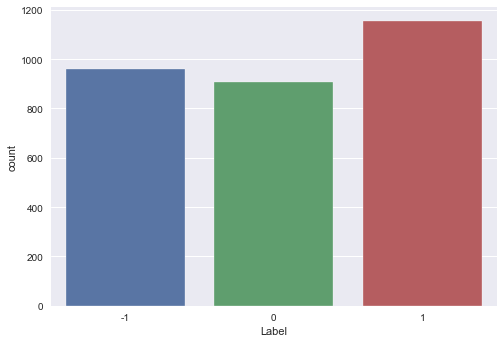

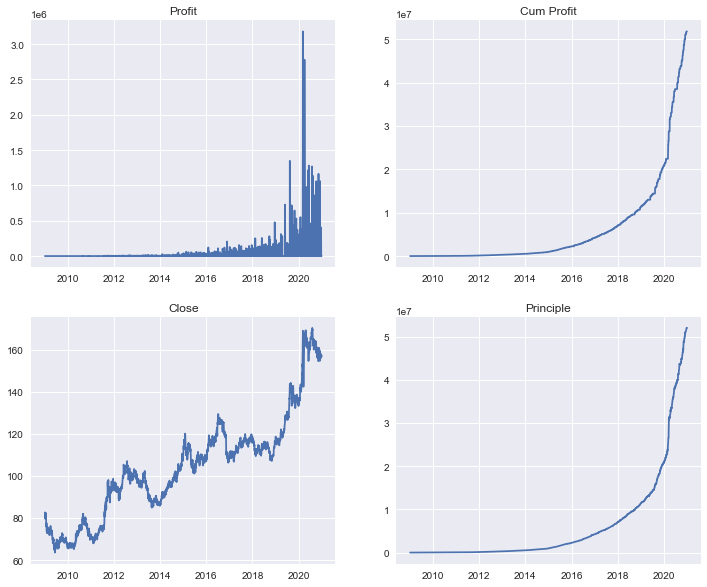

+------------+-------------+------------+--------------+----------+--------+
|   Model    |    Profit   |  Profit %  | Annualized % | Duration | Sharpe |
+------------+-------------+------------+--------------+----------+--------+
|  Strategy  | 51976405.98 | 519764.06% |   115.46%    |   2809   |  8.72  |
| Buy & Hold |   6257.22   |   62.57%   |    4.14%     |   3020   |  0.43  |
+------------+-------------+------------+--------------+----------+--------+


In [100]:
TLT_report, _ = get_trading_report(TLT_trading_log, principle, percent, show_fig=True)
print(TLT_report)

USO

In [101]:
# TP_USO, SL_USO, WINDOW_USO, HORIZON_USO = get_best_window(USO, principle=principle, percent=percent)

In [6]:
TP_USO, SL_USO, WINDOW_USO, HORIZON_USO = 0.005, 0.005, 5, 5

In [7]:
# USO_labeled, USO_TIs = meta_labeling(USO, WINDOW=WINDOW_USO, HORIZON=HORIZON_USO, TP=TP_USO, SL=SL_USO * -1)
# with open('data/processed/USO_TIs.txt', 'wb') as fp:
#     pickle.dump(USO_TIs, fp)
# USO_labeled.to_csv('data/processed/USO_labeled.csv')

with open ('data/processed/USO_TIs.txt', 'rb') as fp:
    USO_TIs = pickle.load(fp)
USO_labeled = pd.read_csv('data/processed/USO_labeled.csv', index_col='Date')
USO_labeled.index = pd.to_datetime(USO_labeled.index)
USO_labeled.head()

Close  Label   Open   High    Low  Volume
Date                                                 
2008-01-09 602.00     -1 605.20 618.16 602.00  617450
2008-01-10 592.16     -1 592.96 597.28 588.08  550363
2008-01-11 584.72     -1 586.96 589.92 582.00  396738
2008-01-14 594.00     -1 592.56 595.76 587.20  279813
2008-01-15 582.24     -1 584.32 585.36 576.08  613575

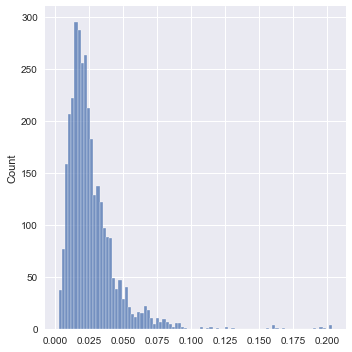

Mean, CI for threshold: (0.02667635866388946, 0.0258100647442118, 0.027542652583567123)


In [104]:
sns.displot(USO_TIs)
plt.show()
print('Mean, CI for threshold:',mean_confidence_interval(USO_TIs, confidence=0.99))

In [105]:
USO_trading_log = get_trading_log(USO_labeled.loc[start:end,:], principle=principle, percent=percent)
USO_trading_log.head()

Close  Label   Open   High    Low   Volume  Buy to open  \
Date                                                                  
2009-01-02 285.04      0 270.16 287.28 267.68  4650038            0   
2009-01-05 298.40     -1 286.08 302.64 284.08  4356250            0   
2009-01-06 298.00     -1 306.88 310.00 294.24  3957100            0   
2009-01-07 266.16      0 293.68 294.40 265.68  5455275            0   
2009-01-08 265.60      0 263.84 266.88 255.12  4595275            0   

            Buy to close  Sell to open  Sell to close  Position   Cost  \
Date                                                                     
2009-01-02             0             0              0      0.00 285.04   
2009-01-05             0             1              0    -23.00 298.40   
2009-01-06             0             0              0    -23.00 298.40   
2009-01-07             0             0              0    -23.00 298.40   
2009-01-08             0             0              0    -23.00 298.40   

            Invest Amt  Duration  Profit  Profit %  Cum Profit  Principle  \
Date                                                                        
2009-01-02        0.00         0    0.00      0.00        0.00   10000.00   
2009-01-05     6863.20         1    0.00      0.00        0.00   10000.00   
2009-01-06     6863.20         2    0.00      0.00        0.00   10009.20   
2009-01-07     6863.20         3    0.00      0.00        0.00   10741.52   
2009-01-08     6863.20         4    0.00      0.00        0.00   10754.40   

            Daily Return  
Date                      
2009-01-02          0.00  
2009-01-05          0.00  
2009-01-06          0.00  
2009-01-07          0.07  
2009-01-08          0.00

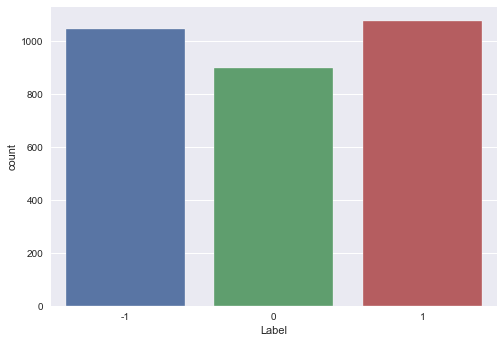

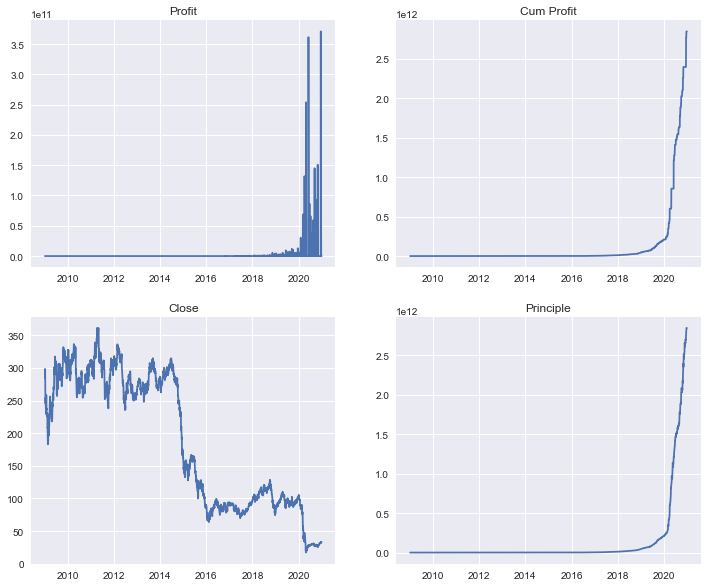

+------------+------------------+-----------------+--------------+----------+--------+
|   Model    |      Profit      |     Profit %    | Annualized % | Duration | Sharpe |
+------------+------------------+-----------------+--------------+----------+--------+
|  Strategy  | 2849407862299.76 | 28494078623.00% |   466.06%    |   2830   |  8.26  |
| Buy & Hold |     -6051.12     |     -60.51%     |    -7.46%    |   3020   |  -0.3  |
+------------+------------------+-----------------+--------------+----------+--------+


In [106]:
USO_report, _ = get_trading_report(USO_trading_log, principle, percent, show_fig=True)
print(USO_report)

## Baseline Model

SPY

In [23]:
# SPY_baseline = baseline_labeling(SPY)
# SPY_baseline.to_csv('data/processed/SPY_baseline.csv')
SPY_baseline = pd.read_csv('data/processed/SPY_baseline.csv', index_col='Date')
SPY_baseline.head()

Open   High    Low  Close     Volume  Label
Date                                                    
2008-01-02 112.03 112.39 110.01 110.81  204935600      1
2008-01-03 110.80 111.24 110.15 110.76  125133300      0
2008-01-04 109.60 109.67 107.74 108.04  232330900     -1
2008-01-07 108.43 108.75 107.12 107.95  234991000      0
2008-01-08 108.63 109.26 105.85 106.21  326365700     -1

In [24]:
SPY_baseline_trading_log = get_trading_log(SPY_baseline.loc[start:end,:], principle=principle, percent=percent)
SPY_baseline_trading_log.head()

Open  High   Low  Close     Volume  Label  Buy to open  \
Date                                                                 
2009-01-02 70.81 73.16 70.35  72.79  227566300     -1            0   
2009-01-05 72.53 73.33 71.95  72.70  240349700      1            0   
2009-01-06 73.32 73.95 72.57  73.19  328260900     -1            0   
2009-01-07 72.03 72.24 70.63  70.99  280899200      0            0   
2009-01-08 70.59 71.32 70.21  71.28  263834400      0            0   

            Buy to close  Sell to open  Sell to close  Position  Cost  \
Date                                                                    
2009-01-02             0             1              0    -96.00 72.79   
2009-01-05             1             0              0    -96.00 72.79   
2009-01-06             0             1              0    -95.00 73.19   
2009-01-07             0             0              0    -95.00 73.19   
2009-01-08             0             0              0    -95.00 73.19   

            Invest Amt  Duration  Profit  Profit %  Cum Profit  Principle  \
Date                                                                        
2009-01-02     6987.50         1    0.00      0.00        0.00   10000.00   
2009-01-05     6987.50         2    8.27      0.00        8.27   10008.27   
2009-01-06     6952.64         1    0.00      0.00        8.27   10008.27   
2009-01-07     6952.64         2    0.00      0.00        8.27   10216.54   
2009-01-08     6952.64         3    0.00      0.00        8.27   10189.02   

            Daily Return  
Date                      
2009-01-02          0.00  
2009-01-05          0.00  
2009-01-06          0.00  
2009-01-07          0.02  
2009-01-08         -0.00

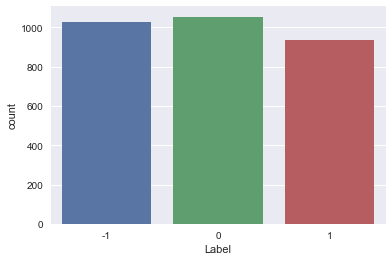

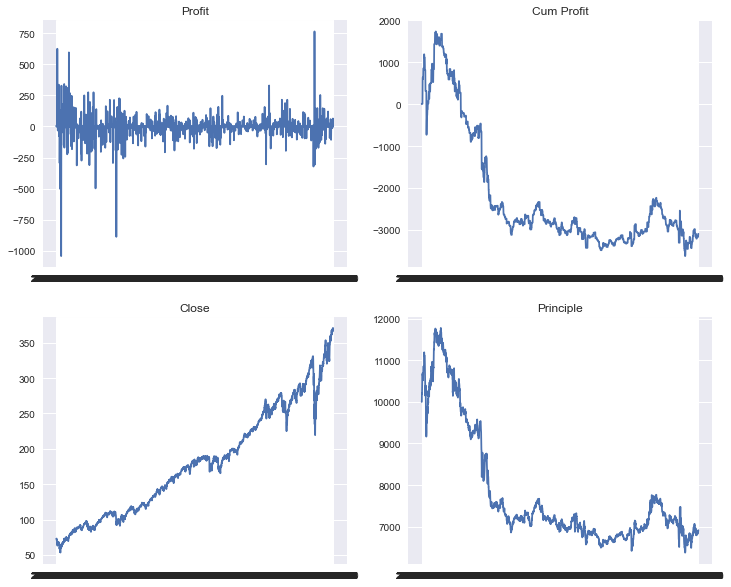

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | -3087.26 | -30.87%  |    -3.45%    |   2654   | -0.25  |
| Buy & Hold | 28606.96 | 286.07%  |    11.93%    |   3020   |  0.84  |
+------------+----------+----------+--------------+----------+--------+


In [25]:
SPY_baseline_report, _ = get_trading_report(SPY_baseline_trading_log, principle, percent, show_fig=True)
print(SPY_baseline_report)

TLT

In [26]:
# TLT_baseline = baseline_labeling(TLT)
# TLT_baseline.to_csv('data/processed/TLT_baseline.csv')
TLT_baseline = pd.read_csv('data/processed/TLT_baseline.csv', index_col='Date')
TLT_baseline.head()

Open  High   Low  Close   Volume  Label
Date                                               
2008-01-02 63.43 64.43 63.39  64.19  2959600     -1
2008-01-03 63.94 64.19 63.71  64.11  1256700      1
2008-01-04 64.28 64.47 64.07  64.12  2420200     -1
2008-01-07 64.06 64.47 63.96  64.40  1315500      1
2008-01-08 64.24 64.42 63.89  64.32  1604800      1

In [27]:
TLT_baseline_trading_log = get_trading_log(TLT_baseline.loc[start:end,:], principle=principle, percent=percent)
TLT_baseline_trading_log.head()

Open  High   Low  Close   Volume  Label  Buy to open  \
Date                                                               
2009-01-02 85.27 85.55 82.64  82.64  3464200      0            0   
2009-01-05 82.11 82.50 79.97  80.51  5395200      0            0   
2009-01-06 79.28 80.44 78.84  79.70  4109300      0            0   
2009-01-07 79.52 80.03 79.12  80.01  2565600      0            0   
2009-01-08 80.00 80.20 79.54  79.95  2603600      0            0   

            Buy to close  Sell to open  Sell to close  Position  Cost  \
Date                                                                    
2009-01-02             0             0              0      0.00 82.64   
2009-01-05             0             0              0      0.00 80.51   
2009-01-06             0             0              0      0.00 79.70   
2009-01-07             0             0              0      0.00 80.01   
2009-01-08             0             0              0      0.00 79.95   

            Invest Amt  Duration  Profit  Profit %  Cum Profit  Principle  \
Date                                                                        
2009-01-02        0.00         0    0.00      0.00        0.00   10000.00   
2009-01-05        0.00         0    0.00      0.00        0.00   10000.00   
2009-01-06        0.00         0    0.00      0.00        0.00   10000.00   
2009-01-07        0.00         0    0.00      0.00        0.00   10000.00   
2009-01-08        0.00         0    0.00      0.00        0.00   10000.00   

            Daily Return  
Date                      
2009-01-02          0.00  
2009-01-05          0.00  
2009-01-06          0.00  
2009-01-07          0.00  
2009-01-08          0.00

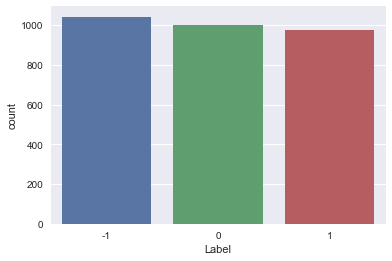

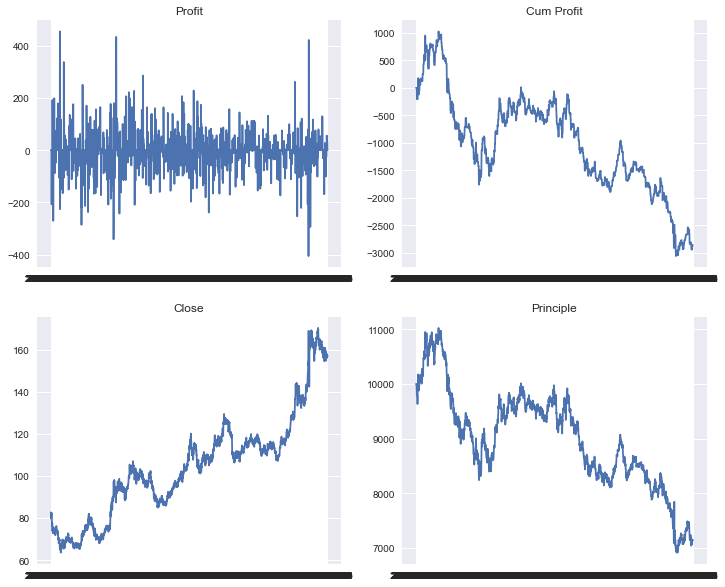

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | -2860.62 | -28.61%  |    -3.10%    |   2696   | -0.29  |
| Buy & Hold | 6257.22  |  62.57%  |    4.14%     |   3020   |  0.43  |
+------------+----------+----------+--------------+----------+--------+


In [28]:
TLT_baseline_report, _ = get_trading_report(TLT_baseline_trading_log, principle, percent, show_fig=True)
print(TLT_baseline_report)

USO

In [29]:
# USO_baseline = baseline_labeling(USO)
# USO_baseline.to_csv('data/processed/USO_baseline.csv')
USO_baseline = pd.read_csv('data/processed/USO_baseline.csv', index_col='Date')
USO_baseline.head()

Open   High    Low  Close  Volume  Label
Date                                                 
2008-01-02 619.04 630.48 617.68 627.76  554875      0
2008-01-03 629.04 632.72 622.32 626.96  626013     -1
2008-01-04 621.60 622.48 613.68 618.48  518175     -1
2008-01-07 616.56 616.56 597.36 604.00  549188      1
2008-01-08 613.68 616.56 606.16 608.48  325600      0

In [30]:
USO_baseline_trading_log = get_trading_log(USO_baseline.loc[start:end,:], principle=principle, percent=percent)
USO_baseline_trading_log.head()

Open   High    Low  Close   Volume  Label  Buy to open  \
Date                                                                  
2009-01-02 270.16 287.28 267.68 285.04  4650038      0            0   
2009-01-05 286.08 302.64 284.08 298.40  4356250     -1            0   
2009-01-06 306.88 310.00 294.24 298.00  3957100     -1            0   
2009-01-07 293.68 294.40 265.68 266.16  5455275      1            0   
2009-01-08 263.84 266.88 255.12 265.60  4595275      1            1   

            Buy to close  Sell to open  Sell to close  Position   Cost  \
Date                                                                     
2009-01-02             0             0              0      0.00 285.04   
2009-01-05             0             1              0    -23.00 298.40   
2009-01-06             0             0              0    -23.00 298.40   
2009-01-07             1             0              0    -23.00 298.40   
2009-01-08             0             0              0     28.00 265.60   

            Invest Amt  Duration  Profit  Profit %  Cum Profit  Principle  \
Date                                                                        
2009-01-02        0.00         0    0.00      0.00        0.00   10000.00   
2009-01-05     6863.20         1    0.00      0.00        0.00   10000.00   
2009-01-06     6863.20         2    0.00      0.00        0.00   10009.20   
2009-01-07     6863.20         3  741.52      0.11      741.52   10741.52   
2009-01-08     7436.80         1    0.00      0.00      741.52   10741.52   

            Daily Return  
Date                      
2009-01-02          0.00  
2009-01-05          0.00  
2009-01-06          0.00  
2009-01-07          0.07  
2009-01-08          0.00

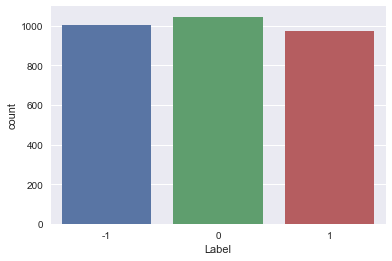

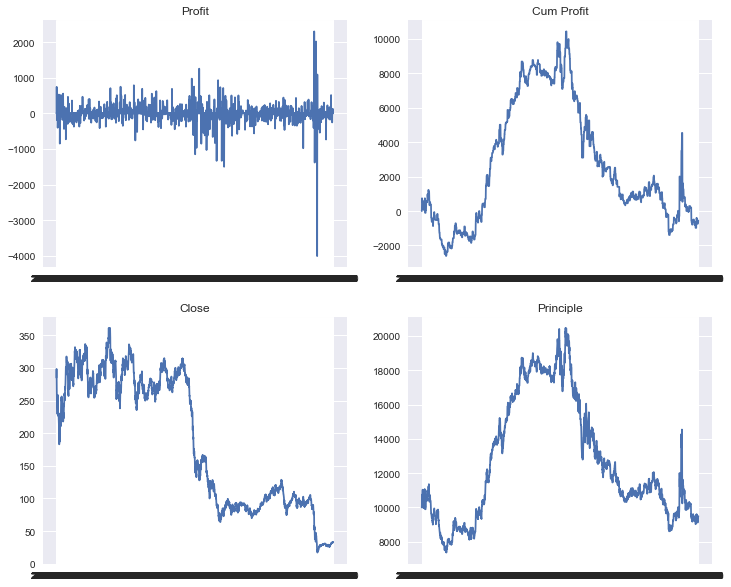

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | -511.81  |  -5.12%  |    -0.49%    |   2672   |  0.09  |
| Buy & Hold | -6051.12 | -60.51%  |    -7.46%    |   3020   |  -0.3  |
+------------+----------+----------+--------------+----------+--------+


In [31]:
USO_baseline_report, _ = get_trading_report(USO_baseline_trading_log, principle, percent, show_fig=True)
print(USO_baseline_report)

# Data Preprocessing

## Data Analysis & Processing

### Outliers

In [79]:
outlier_analysis(SPY_labeled)

Columns  Outliers%
0   Close       0.00
1   Label       0.00
2    Open       0.00
3    High       0.00
4     Low       0.00
5  Volume       2.05

In [80]:
outlier_analysis(TLT_labeled)

Columns  Outliers%
0   Close       0.00
1   Label       0.00
2    Open       0.00
3    High       0.00
4     Low       0.00
5  Volume       1.41

In [81]:
outlier_analysis(USO_labeled)

Columns  Outliers%
0   Close       3.03
1   Label       0.00
2    Open       3.00
3    High       2.97
4     Low       3.00
5  Volume       0.98

### Missing, Imbalance, Unique Data

In [82]:
SPY_analysis, SPY_unique = analysis(SPY_labeled)
print(SPY_analysis)

  Columns  Missing%  Imbalance%  Unique%
0   Close      0.00        0.09    97.46
1   Label      0.00       39.08     0.09
2    Open      0.00        0.03   100.00
3    High      0.00        0.06    99.91
4     Low      0.00        0.03   100.00
5  Volume      0.00        0.03   100.00


In [83]:
TLT_analysis, TLT_unique = analysis(TLT_labeled)
print(TLT_analysis)

  Columns  Missing%  Imbalance%  Unique%
0   Close      0.00        0.06    97.77
1   Label      0.00       38.53     0.09
2    Open      0.00        0.03   100.00
3    High      0.00        0.03   100.00
4     Low      0.00        0.06    99.94
5  Volume      0.00        0.06    98.75


In [84]:
USO_analysis, USO_unique = analysis(USO_labeled)
print(USO_analysis)

  Columns  Missing%  Imbalance%  Unique%
0   Close      0.00        0.24    59.98
1   Label      0.00       35.50     0.09
2    Open      0.00        0.28    59.76
3    High      0.00        0.31    59.67
4     Low      0.00        0.28    59.94
5  Volume      0.00        0.06    99.72


## Feature Engineering

### Economic Indicators

Indicators:
* 'GDP': Gross Domestic Product
* 'PAYEMS': All Employees, Total Nonfarm
* 'DTB1YR': 1-Year Treasury Bill: Secondary Market Rate
* 'DTB6': 6-Month Treasury Bill: Secondary Market Rate
* 'DTB3': 3-Month Treasury Bill: Secondary Market Rate
* 'DGS3MO': 3-Month Treasury Constant Maturity Rate
* 'DGS1MO': 1-Month Treasury Constant Maturity Rate
* 'CPIAUCSL': Consumer Price Index for All Urban Consumers: All Items in U.S. City Average
* 'BOGMBASE': Monetary Base; Total
* 'TEDRATE': TED Spread

Output:
* date: the date the value is for
* realtime_start: the first date the value is valid
* realitime_end: the last date the value is valid

In [38]:
indicators=['GDP', 'PAYEMS', 'DTB1YR', 'DTB6', 'DTB3', 'DGS3MO', 'DGS1MO', 'CPIAUCSL','BOGMBASE', 'TEDRATE']

In [39]:
SPY_eco = economic_indicator(SPY, indicators)
SPY_eco.to_csv('data/intermediate/SPY_eco.csv')
SPY_eco = pd.read_csv('data/intermediate/SPY_eco.csv', index_col='Date')
SPY_eco.head()

Open   High    Low  Close     Volume      GDP    PAYEMS  DTB1YR  \
Date                                                                           
2008-01-02 112.03 112.39 110.01 110.81  204935600 14080.80 138495.00    1.37   
2008-01-03 110.80 111.24 110.15 110.76  125133300 14080.80 138495.00    1.37   
2008-01-04 109.60 109.67 107.74 108.04  232330900 14080.80 138495.00    1.37   
2008-01-07 108.43 108.75 107.12 107.95  234991000 14080.80 138495.00    1.37   
2008-01-08 108.63 109.26 105.85 106.21  326365700 14080.80 138495.00    1.37   

            DTB6  DTB3  DGS3MO  DGS1MO  CPIAUCSL   BOGMBASE  TEDRATE  
Date                                                                  
2008-01-02  3.34  3.10    3.18    2.57    211.16 3201482.00     0.19  
2008-01-03  3.37  3.29    3.36    2.76    211.16 3201482.00     0.19  
2008-01-04  3.21  3.18    3.26    3.09    211.16 3201482.00     0.19  
2008-01-07  3.18  3.16    3.24    3.19    211.16 3201482.00     0.19  
2008-01-08  3.12  3.12    3.20    3.22    211.16 3201482.00     0.19

In [45]:
TLT_eco = economic_indicator(TLT, indicators)
TLT_eco.to_csv('data/intermediate/TLT_eco.csv')
TLT_eco = pd.read_csv('data/intermediate/TLT_eco.csv', index_col='Date')
TLT_eco.head()

Open  High   Low  Close   Volume      GDP    PAYEMS  DTB1YR  DTB6  \
Date                                                                            
2008-01-02 63.43 64.43 63.39  64.19  2959600 14080.80 138495.00    1.37  3.34   
2008-01-03 63.94 64.19 63.71  64.11  1256700 14080.80 138495.00    1.37  3.37   
2008-01-04 64.28 64.47 64.07  64.12  2420200 14080.80 138495.00    1.37  3.21   
2008-01-07 64.06 64.47 63.96  64.40  1315500 14080.80 138495.00    1.37  3.18   
2008-01-08 64.24 64.42 63.89  64.32  1604800 14080.80 138495.00    1.37  3.12   

            DTB3  DGS3MO  DGS1MO  CPIAUCSL   BOGMBASE  TEDRATE  
Date                                                            
2008-01-02  3.10    3.18    2.57    211.16 3201482.00     0.19  
2008-01-03  3.29    3.36    2.76    211.16 3201482.00     0.19  
2008-01-04  3.18    3.26    3.09    211.16 3201482.00     0.19  
2008-01-07  3.16    3.24    3.19    211.16 3201482.00     0.19  
2008-01-08  3.12    3.20    3.22    211.16 3201482.00     0.19

In [46]:
USO_eco = economic_indicator(USO, indicators)
USO_eco.to_csv('data/intermediate/USO_eco.csv')
USO_eco = pd.read_csv('data/intermediate/USO_eco.csv', index_col='Date')
USO_eco.head()

Open   High    Low  Close  Volume      GDP    PAYEMS  DTB1YR  \
Date                                                                        
2008-01-02 619.04 630.48 617.68 627.76  554875 14080.80 138495.00    1.37   
2008-01-03 629.04 632.72 622.32 626.96  626013 14080.80 138495.00    1.37   
2008-01-04 621.60 622.48 613.68 618.48  518175 14080.80 138495.00    1.37   
2008-01-07 616.56 616.56 597.36 604.00  549188 14080.80 138495.00    1.37   
2008-01-08 613.68 616.56 606.16 608.48  325600 14080.80 138495.00    1.37   

            DTB6  DTB3  DGS3MO  DGS1MO  CPIAUCSL   BOGMBASE  TEDRATE  
Date                                                                  
2008-01-02  3.34  3.10    3.18    2.57    211.16 3201482.00     0.19  
2008-01-03  3.37  3.29    3.36    2.76    211.16 3201482.00     0.19  
2008-01-04  3.21  3.18    3.26    3.09    211.16 3201482.00     0.19  
2008-01-07  3.18  3.16    3.24    3.19    211.16 3201482.00     0.19  
2008-01-08  3.12  3.12    3.20    3.22    211.16 3201482.00     0.19

### Technical Indicators

In [8]:
# SPY_eco_tec = technical_indicator(SPY_eco)
# SPY_eco_tec.to_csv('data/intermediate/SPY_eco_tec.csv')
SPY_eco_tec = pd.read_csv('data/intermediate/SPY_eco_tec.csv', index_col='Date')
SPY_eco_tec.index = pd.to_datetime(SPY_eco_tec.index)
SPY_eco_tec.head()

Open   High    Low  Close     Volume      GDP    PAYEMS  DTB1YR  \
Date                                                                           
2008-01-02 112.03 112.39 110.01 110.81  204935600 14080.80 138495.00    1.37   
2008-01-03 110.80 111.24 110.15 110.76  125133300 14080.80 138495.00    1.37   
2008-01-04 109.60 109.67 107.74 108.04  232330900 14080.80 138495.00    1.37   
2008-01-07 108.43 108.75 107.12 107.95  234991000 14080.80 138495.00    1.37   
2008-01-08 108.63 109.26 105.85 106.21  326365700 14080.80 138495.00    1.37   

            DTB6  DTB3  ...  cci_60  cci_120   dx_5  dx_10  dx_20  dx_60  \
Date                    ...                                                
2008-01-02  3.34  3.10  ...     NaN      NaN    NaN    NaN    NaN    NaN   
2008-01-03  3.37  3.29  ...  -66.67   -66.67    NaN    NaN    NaN    NaN   
2008-01-04  3.21  3.18  ... -100.00  -100.00 100.00 100.00 100.00 100.00   
2008-01-07  3.18  3.16  ...  -80.23   -80.23 100.00 100.00 100.00 100.00   
2008-01-08  3.12  3.12  ...  -89.14   -89.14 100.00 100.00 100.00 100.00   

            dx_120  vr_20  vr_60  vr_120  
Date                                      
2008-01-02     NaN    NaN    NaN     NaN  
2008-01-03     NaN   0.00   0.00    0.00  
2008-01-04  100.00   0.00   0.00    0.00  
2008-01-07  100.00   0.00   0.00    0.00  
2008-01-08  100.00   0.00   0.00    0.00  

[5 rows x 84 columns]

In [9]:
# TLT_eco_tec = technical_indicator(TLT_eco)
# TLT_eco_tec.to_csv('data/intermediate/TLT_eco_tec.csv')
TLT_eco_tec = pd.read_csv('data/intermediate/TLT_eco_tec.csv', index_col='Date')
TLT_eco_tec.index = pd.to_datetime(TLT_eco_tec.index)
TLT_eco_tec.head()

Open  High   Low  Close   Volume      GDP    PAYEMS  DTB1YR  DTB6  \
Date                                                                            
2008-01-02 63.43 64.43 63.39  64.19  2959600 14080.80 138495.00    1.37  3.34   
2008-01-03 63.94 64.19 63.71  64.11  1256700 14080.80 138495.00    1.37  3.37   
2008-01-04 64.28 64.47 64.07  64.12  2420200 14080.80 138495.00    1.37  3.21   
2008-01-07 64.06 64.47 63.96  64.40  1315500 14080.80 138495.00    1.37  3.18   
2008-01-08 64.24 64.42 63.89  64.32  1604800 14080.80 138495.00    1.37  3.12   

            DTB3  ...  cci_60  cci_120   dx_5  dx_10  dx_20  dx_60  dx_120  \
Date              ...                                                        
2008-01-02  3.10  ...     NaN      NaN    NaN    NaN    NaN    NaN     NaN   
2008-01-03  3.29  ...  -66.67   -66.67    NaN    NaN    NaN    NaN     NaN   
2008-01-04  3.18  ...  100.00   100.00 100.00 100.00 100.00 100.00  100.00   
2008-01-07  3.16  ...   81.00    81.00  23.31  32.73  37.15  39.99   40.68   
2008-01-08  3.12  ...   40.50    40.50   7.87   6.89  13.88  18.38   19.49   

            vr_20  vr_60  vr_120  
Date                              
2008-01-02    NaN    NaN     NaN  
2008-01-03   0.00   0.00    0.00  
2008-01-04 192.58 192.58  192.58  
2008-01-07 297.26 297.26  297.26  
2008-01-08 130.55 130.55  130.55  

[5 rows x 84 columns]

In [10]:
# USO_eco_tec = technical_indicator(USO_eco)
# USO_eco_tec.to_csv('data/intermediate/USO_eco_tec.csv')
USO_eco_tec = pd.read_csv('data/intermediate/USO_eco_tec.csv', index_col='Date')
USO_eco_tec.index = pd.to_datetime(USO_eco_tec.index)
USO_eco_tec.head()

Open   High    Low  Close  Volume      GDP    PAYEMS  DTB1YR  \
Date                                                                        
2008-01-02 619.04 630.48 617.68 627.76  554875 14080.80 138495.00    1.37   
2008-01-03 629.04 632.72 622.32 626.96  626013 14080.80 138495.00    1.37   
2008-01-04 621.60 622.48 613.68 618.48  518175 14080.80 138495.00    1.37   
2008-01-07 616.56 616.56 597.36 604.00  549188 14080.80 138495.00    1.37   
2008-01-08 613.68 616.56 606.16 608.48  325600 14080.80 138495.00    1.37   

            DTB6  DTB3  ...  cci_60  cci_120   dx_5  dx_10  dx_20  dx_60  \
Date                    ...                                                
2008-01-02  3.34  3.10  ...     NaN      NaN    NaN    NaN    NaN    NaN   
2008-01-03  3.37  3.29  ...   66.67    66.67 100.00 100.00 100.00 100.00   
2008-01-04  3.21  3.18  ... -100.00  -100.00  70.53  65.00  62.00  59.90   
2008-01-07  3.18  3.16  ... -124.02  -124.02  91.37  87.95  85.88  84.35   
2008-01-08  3.12  3.12  ...  -63.41   -63.41  91.37  87.95  85.88  84.35   

            dx_120  vr_20  vr_60  vr_120  
Date                                      
2008-01-02     NaN    NaN    NaN     NaN  
2008-01-03  100.00   0.00   0.00    0.00  
2008-01-04   59.37   0.00   0.00    0.00  
2008-01-07   83.94   0.00   0.00    0.00  
2008-01-08   83.94  19.23  19.23   19.23  

[5 rows x 84 columns]

## Train/Test Split (Classification)

In [11]:
tscv = TimeSeriesSplit(n_splits=4)

In [18]:
df = SPY_eco_tec.shift(WINDOW_SPY)
label = pd.DataFrame(SPY_labeled['Label'], index=SPY_labeled.index)
df = pd.merge(label, df, how='left', left_index=True, right_index=True)
SPY_X_train, SPY_y_train, SPY_X_test, SPY_y_test, SPY_X_trade, SPY_y_trade = clas_train_test_trade_split(df, train_start, train_end, test_start, test_end, trade_start, trade_end)

In [19]:
df = TLT_eco_tec.shift(WINDOW_TLT)
label = pd.DataFrame(TLT_labeled['Label'], index=TLT_labeled.index)
df = pd.merge(label, df, how='left', left_index=True, right_index=True)
TLT_X_train, TLT_y_train, TLT_X_test, TLT_y_test, TLT_X_trade, TLT_y_trade = clas_train_test_trade_split(df, train_start, train_end, test_start, test_end, trade_start, trade_end)

In [20]:
df = USO_eco_tec.shift(WINDOW_USO)
label = pd.DataFrame(USO_labeled['Label'], index=USO_labeled.index)
df = pd.merge(label, df, how='left', left_index=True, right_index=True)
USO_X_train, USO_y_train, USO_X_test, USO_y_test, USO_X_trade, USO_y_trade = clas_train_test_trade_split(df, train_start, train_end, test_start, test_end, trade_start, trade_end)

## Data Type Separation & Transformation (Classification)

For feature selection

In [117]:
SPY_preprocessor = data_preprocessor(SPY_X_train)
SPY_preprocessor.fit(SPY_X_train)
SPY_X_train_transformed = pd.DataFrame(SPY_preprocessor.transform(SPY_X_train), columns=SPY_X_train.columns, index=SPY_X_train.index)
SPY_X_train_transformed.head()

Open  High  Low  Close  Volume  GDP  PAYEMS  DTB1YR  DTB6  DTB3  \
Date                                                                          
2009-01-02  0.06  0.06 0.07   0.06    0.05 0.05    0.33    0.12  0.10  0.01   
2009-01-05  0.07  0.06 0.07   0.07    0.07 0.05    0.33    0.13  0.10  0.02   
2009-01-06  0.07  0.06 0.06   0.07    0.14 0.05    0.33    0.13  0.10  0.02   
2009-01-07  0.07  0.07 0.07   0.07    0.20 0.05    0.33    0.11  0.08  0.02   
2009-01-08  0.07  0.07 0.08   0.08    0.24 0.05    0.33    0.10  0.09  0.03   

            ...  cci_60  cci_120  dx_5  dx_10  dx_20  dx_60  dx_120  vr_20  \
Date        ...                                                              
2009-01-02  ...    0.66     0.60  0.66   0.40   0.29   0.44    0.61   0.13   
2009-01-05  ...    0.66     0.60  0.25   0.27   0.25   0.42    0.60   0.12   
2009-01-06  ...    0.66     0.60  0.58   0.41   0.31   0.44    0.61   0.11   
2009-01-07  ...    0.69     0.61  0.30   0.03   0.12   0.38    0.57   0.14   
2009-01-08  ...    0.73     0.62  0.64   0.32   0.06   0.31    0.52   0.12   

            vr_60  vr_120  
Date                       
2009-01-02   0.10    0.22  
2009-01-05   0.09    0.21  
2009-01-06   0.10    0.22  
2009-01-07   0.11    0.21  
2009-01-08   0.14    0.23  

[5 rows x 84 columns]

In [118]:
TLT_preprocessor = data_preprocessor(TLT_X_train)
TLT_preprocessor.fit(TLT_X_train)
TLT_X_train_transformed = pd.DataFrame(TLT_preprocessor.transform(TLT_X_train), columns=TLT_X_train.columns, index=TLT_X_train.index)
TLT_X_train_transformed.head()

Open  High  Low  Close  Volume  GDP  PAYEMS  DTB1YR  DTB6  DTB3  \
Date                                                                          
2009-01-02  0.34  0.33 0.34   0.33    0.01 0.05    0.33    0.12  0.10  0.01   
2009-01-05  0.35  0.34 0.35   0.34    0.00 0.05    0.33    0.13  0.10  0.02   
2009-01-06  0.35  0.34 0.35   0.34    0.02 0.05    0.33    0.13  0.10  0.02   
2009-01-07  0.34  0.34 0.34   0.35    0.05 0.05    0.33    0.11  0.08  0.02   
2009-01-08  0.35  0.34 0.33   0.32    0.05 0.05    0.33    0.10  0.09  0.03   

            ...  cci_60  cci_120  dx_5  dx_10  dx_20  dx_60  dx_120  vr_20  \
Date        ...                                                              
2009-01-02  ...    0.57     0.85  0.24   0.58   0.78   0.97    0.96   0.64   
2009-01-05  ...    0.57     0.83  0.48   0.64   0.80   0.99    0.97   0.61   
2009-01-06  ...    0.56     0.81  0.61   0.68   0.82   1.00    0.98   0.54   
2009-01-07  ...    0.55     0.80  0.11   0.46   0.71   0.95    0.95   0.51   
2009-01-08  ...    0.53     0.76  0.46   0.08   0.49   0.84    0.88   0.39   

            vr_60  vr_120  
Date                       
2009-01-02   0.62    0.34  
2009-01-05   0.60    0.33  
2009-01-06   0.57    0.31  
2009-01-07   0.58    0.34  
2009-01-08   0.50    0.36  

[5 rows x 84 columns]

In [119]:
USO_preprocessor = data_preprocessor(USO_X_train)
USO_preprocessor.fit(USO_X_train)
USO_X_train_transformed = pd.DataFrame(USO_preprocessor.transform(USO_X_train), columns=USO_X_train.columns, index=USO_X_train.index)
USO_X_train_transformed.head()

Open  High  Low  Close  Volume  GDP  PAYEMS  DTB1YR  DTB6  DTB3  \
Date                                                                          
2009-01-02  0.57  0.57 0.56   0.57    0.12 0.05    0.33    0.12  0.10  0.01   
2009-01-05  0.54  0.56 0.54   0.57    0.18 0.05    0.33    0.13  0.10  0.02   
2009-01-06  0.61  0.61 0.57   0.62    0.21 0.05    0.33    0.13  0.10  0.02   
2009-01-07  0.59  0.60 0.58   0.60    0.19 0.05    0.33    0.11  0.08  0.02   
2009-01-08  0.57  0.71 0.58   0.68    0.44 0.05    0.33    0.10  0.09  0.03   

            ...  cci_60  cci_120  dx_5  dx_10  dx_20  dx_60  dx_120  vr_20  \
Date        ...                                                              
2009-01-02  ...    0.42     0.31  0.87   0.63   0.48   0.53    0.59   0.04   
2009-01-05  ...    0.42     0.31  0.91   0.69   0.52   0.55    0.60   0.04   
2009-01-06  ...    0.43     0.33  0.01   0.25   0.31   0.47    0.55   0.06   
2009-01-07  ...    0.44     0.33  0.01   0.25   0.31   0.47    0.55   0.05   
2009-01-08  ...    0.46     0.34  0.73   0.38   0.09   0.29    0.44   0.08   

            vr_60  vr_120  
Date                       
2009-01-02   0.06    0.03  
2009-01-05   0.09    0.06  
2009-01-06   0.12    0.08  
2009-01-07   0.11    0.06  
2009-01-08   0.17    0.09  

[5 rows x 84 columns]

## Feature Selection  (Classification)

### Handling Multicollinear Features

#### Feature Correlation

kdjk               -0.04
cci_10             -0.03
volatility_-20     -0.03
kdjj               -0.03
volume_delta       -0.03
                    ... 
volume_-10_max_r    0.02
dx_20               0.02
volume_-60_r        0.03
volume_-60_min_r    0.05
volume_-60_max_r    0.05
Name: Label, Length: 84, dtype: float64


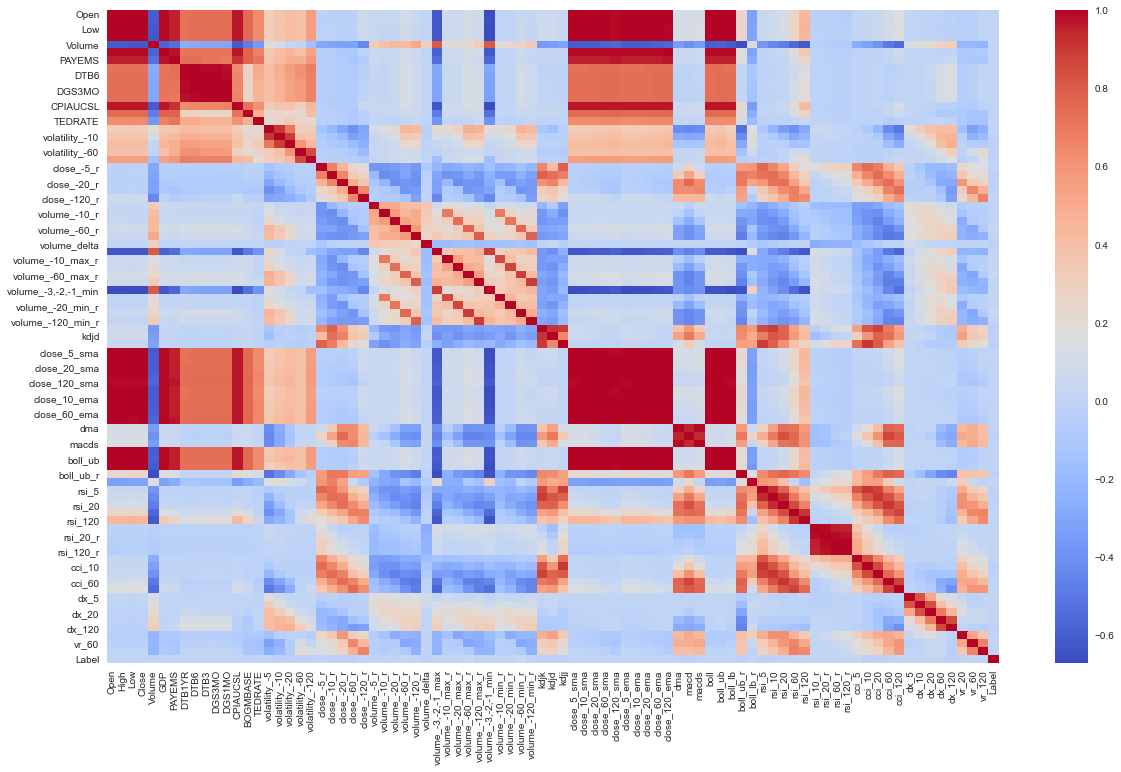

In [24]:
feature_correlation(SPY_X_train_transformed,SPY_y_train)

volatility_-10    -0.04
volatility_-20    -0.04
volatility_-120   -0.04
rsi_10_r          -0.03
volatility_-60    -0.03
                   ... 
dma                0.04
cci_60             0.04
boll_ub_r          0.04
volume_-5_r        0.05
vr_60              0.05
Name: Label, Length: 84, dtype: float64


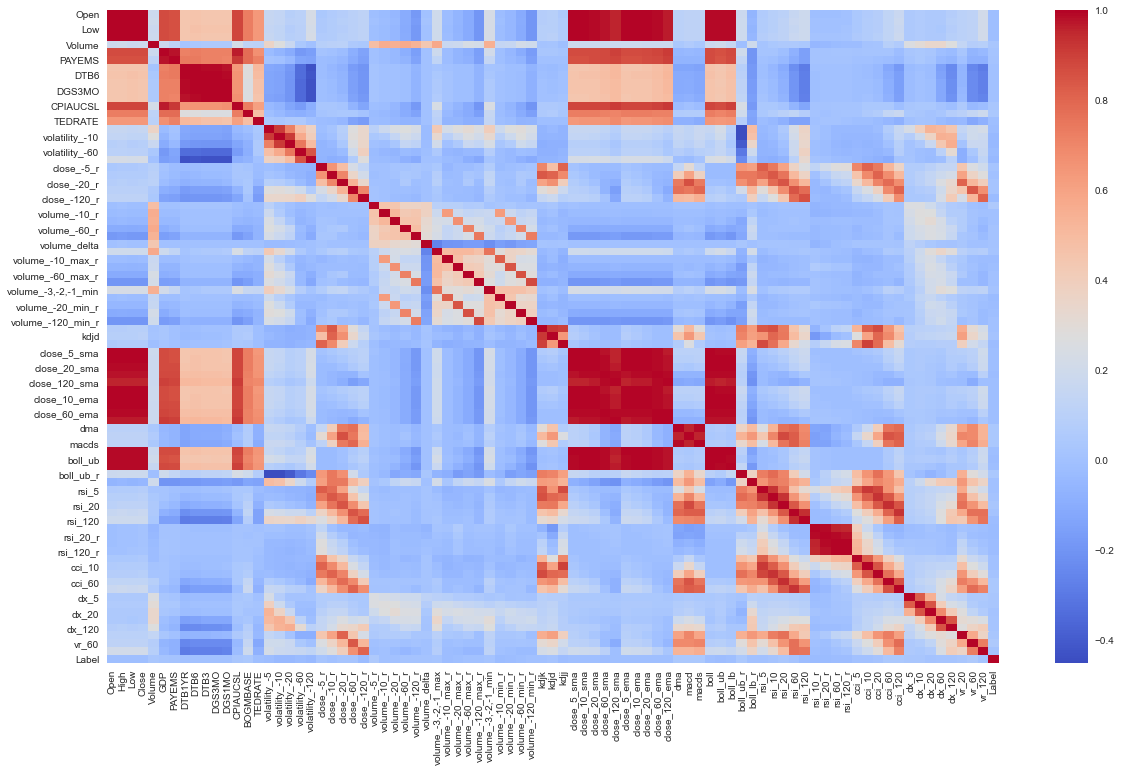

In [25]:
feature_correlation(TLT_X_train_transformed,TLT_y_train)

volume_-20_max_r    -0.07
volume_-20_min_r    -0.06
volume_-20_r        -0.04
volume_-60_max_r    -0.04
volume_-120_max_r   -0.04
                     ... 
boll_ub_r            0.02
macds                0.02
dma                  0.02
volume_delta         0.02
cci_60               0.03
Name: Label, Length: 84, dtype: float64


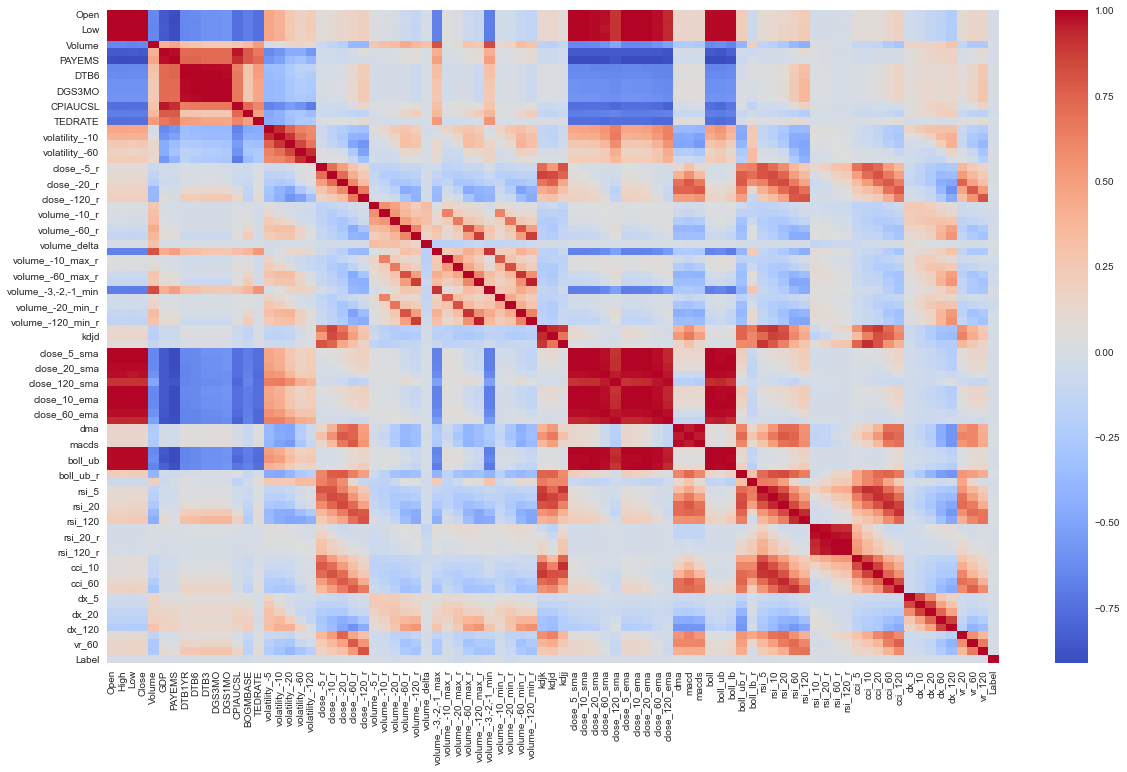

In [26]:
feature_correlation(USO_X_train_transformed,USO_y_train)

#### Variance Inflation Factor(VIF)

* VIF=1, Very Less Multicollinearity
* VIF<5, Moderate Multicollinearity
* VIF>5, Extreme Multicollinearity (This is what we have to avoid)

In [27]:
cal_vif(SPY_X_train_transformed)

variables      VIF
0       Open 15405.28
1       High 27250.02
2        Low 21939.37
3      Close 51982.80
4     Volume    29.39
..       ...      ...
79     dx_60    15.65
80    dx_120    12.35
81     vr_20     3.50
82     vr_60     6.12
83    vr_120     7.17

[84 rows x 2 columns]

In [28]:
cal_vif(TLT_X_train_transformed)

variables      VIF
0       Open  5396.40
1       High  7136.11
2        Low  9122.34
3      Close 18247.73
4     Volume    15.59
..       ...      ...
79     dx_60    16.17
80    dx_120    13.10
81     vr_20     5.32
82     vr_60    12.31
83    vr_120    14.03

[84 rows x 2 columns]

In [29]:
cal_vif(USO_X_train_transformed)

variables      VIF
0       Open  4561.02
1       High  6525.06
2        Low  7343.81
3      Close 13564.70
4     Volume    16.12
..       ...      ...
79     dx_60    19.01
80    dx_120    13.15
81     vr_20     4.45
82     vr_60     6.69
83    vr_120     7.58

[84 rows x 2 columns]

#### Hierarchical Clustering

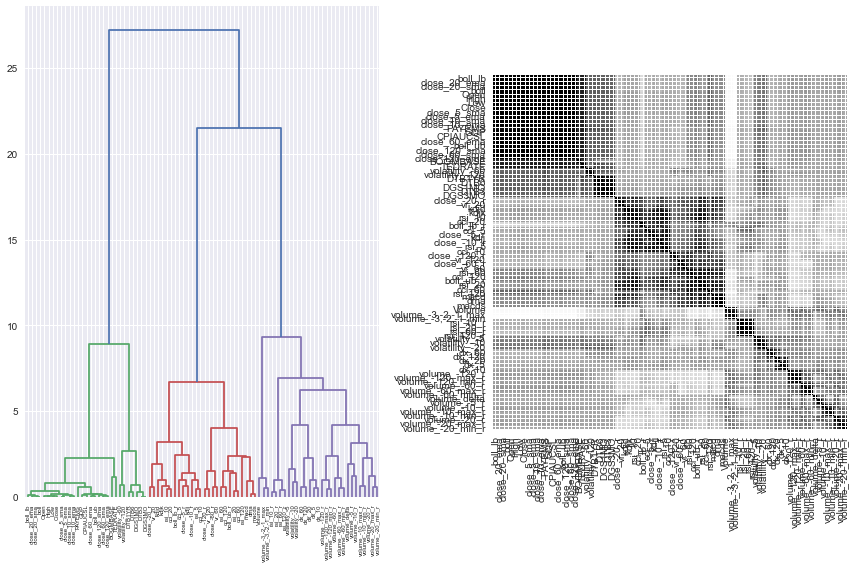

Number of Features: 35
Selected Features: Index(['Open', 'Volume', 'DTB1YR', 'BOGMBASE', 'TEDRATE', 'volatility_-5',
       'volatility_-10', 'volatility_-60', 'close_-5_r', 'close_-10_r',
       'close_-20_r', 'close_-60_r', 'close_-120_r', 'volume_-5_r',
       'volume_-10_r', 'volume_-20_r', 'volume_-60_r', 'volume_-120_r',
       'volume_delta', 'volume_-3,-2,-1_max', 'volume_-10_max_r',
       'volume_-20_max_r', 'volume_-60_max_r', 'volume_-120_max_r', 'kdjk',
       'dma', 'boll_ub_r', 'boll_lb_r', 'rsi_5', 'rsi_20', 'rsi_60', 'rsi_120',
       'rsi_10_r', 'dx_5', 'dx_60'],
      dtype='object')


In [120]:
SPY_selected_cols1 = fs_hierarchical_clustering(SPY_X_train_transformed, threshold=0.99)
SPY_X_train_fs1 = SPY_X_train_transformed.loc[:,SPY_selected_cols1]

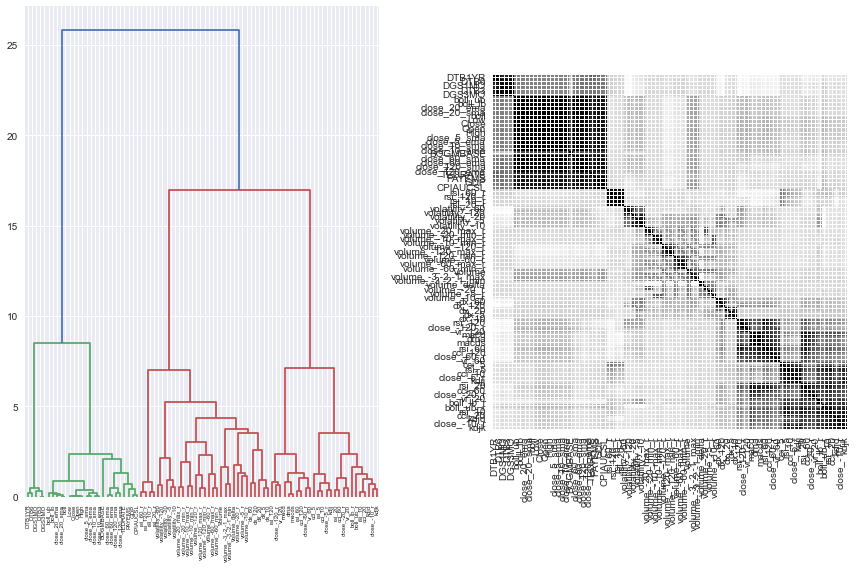

Number of Features: 33
Selected Features: Index(['Open', 'Volume', 'GDP', 'DTB1YR', 'BOGMBASE', 'volatility_-5',
       'volatility_-60', 'close_-5_r', 'close_-10_r', 'close_-20_r',
       'close_-60_r', 'close_-120_r', 'volume_-5_r', 'volume_-10_r',
       'volume_-20_r', 'volume_-60_r', 'volume_-120_r', 'volume_delta',
       'volume_-3,-2,-1_max', 'volume_-10_max_r', 'volume_-20_max_r',
       'volume_-60_max_r', 'volume_-120_max_r', 'close_60_sma', 'dma',
       'boll_ub_r', 'boll_lb_r', 'rsi_20', 'rsi_60', 'rsi_10_r', 'cci_5',
       'dx_5', 'dx_60'],
      dtype='object')


In [121]:
TLT_selected_cols1 = fs_hierarchical_clustering(TLT_X_train_transformed, threshold=0.99)
TLT_X_train_fs1 = TLT_X_train_transformed.loc[:,TLT_selected_cols1]

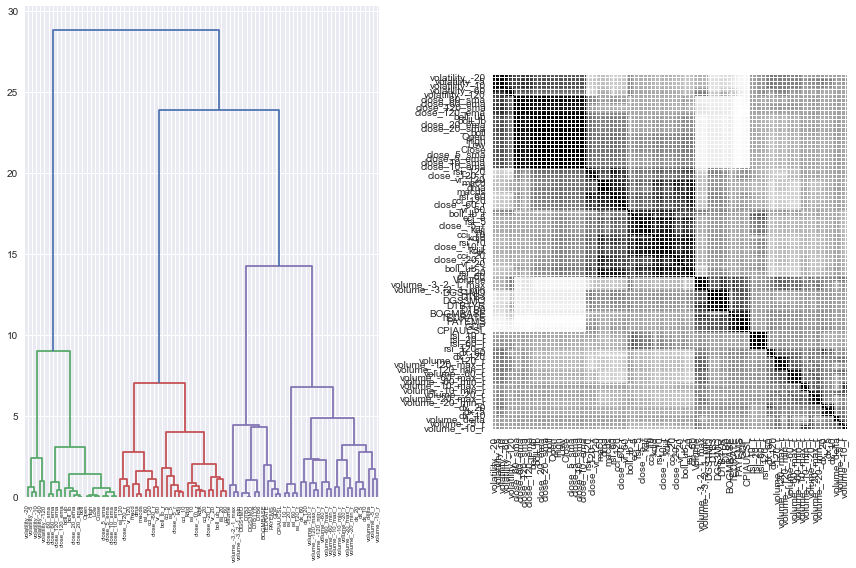

Number of Features: 35
Selected Features: Index(['Open', 'Volume', 'GDP', 'DTB1YR', 'DTB3', 'BOGMBASE', 'TEDRATE',
       'volatility_-5', 'volatility_-60', 'volatility_-120', 'close_-5_r',
       'close_-10_r', 'close_-20_r', 'close_-60_r', 'close_-120_r',
       'volume_-5_r', 'volume_-10_r', 'volume_-20_r', 'volume_-60_r',
       'volume_-120_r', 'volume_delta', 'volume_-10_max_r', 'volume_-20_max_r',
       'close_20_sma', 'close_60_sma', 'dma', 'boll_ub_r', 'boll_lb_r',
       'rsi_20', 'rsi_60', 'rsi_120', 'rsi_10_r', 'cci_5', 'dx_5', 'dx_60'],
      dtype='object')


In [122]:
USO_selected_cols1 = fs_hierarchical_clustering(USO_X_train_transformed, threshold=0.99)
USO_X_train_fs1 = USO_X_train_transformed.loc[:,USO_selected_cols1]

### Select Important Features

In [123]:
SPY_selected_cols = fs_importance(SPY_X_train_fs1, SPY_y_train, 30)

Number of Features: 30
Selected Features: Index(['Open', 'Volume', 'DTB1YR', 'BOGMBASE', 'TEDRATE', 'volatility_-5',
       'volatility_-10', 'volatility_-60', 'close_-10_r', 'close_-20_r',
       'close_-60_r', 'volume_-20_r', 'volume_-60_r', 'volume_-120_r',
       'volume_delta', 'volume_-3,-2,-1_max', 'volume_-10_max_r',
       'volume_-20_max_r', 'volume_-60_max_r', 'volume_-120_max_r', 'kdjk',
       'dma', 'boll_ub_r', 'boll_lb_r', 'rsi_5', 'rsi_20', 'rsi_60',
       'rsi_10_r', 'dx_5', 'dx_60'],
      dtype='object')


In [21]:
SPY_selected_cols = ['Open', 'Volume', 'DTB1YR', 'BOGMBASE', 'TEDRATE', 'volatility_-5',
       'volatility_-10', 'volatility_-60', 'close_-10_r', 'close_-20_r',
       'close_-60_r', 'volume_-20_r', 'volume_-60_r', 'volume_-120_r',
       'volume_delta', 'volume_-3,-2,-1_max', 'volume_-10_max_r',
       'volume_-20_max_r', 'volume_-60_max_r', 'volume_-120_max_r', 'kdjk',
       'dma', 'boll_ub_r', 'boll_lb_r', 'rsi_5', 'rsi_20', 'rsi_60',
       'rsi_10_r', 'dx_5', 'dx_60']

In [125]:
TLT_selected_cols = fs_importance(TLT_X_train_fs1, TLT_y_train, 30)

Number of Features: 30
Selected Features: Index(['Open', 'Volume', 'GDP', 'DTB1YR', 'BOGMBASE', 'volatility_-5',
       'volatility_-60', 'close_-5_r', 'close_-10_r', 'close_-20_r',
       'close_-60_r', 'close_-120_r', 'volume_-5_r', 'volume_-20_r',
       'volume_-60_r', 'volume_-120_r', 'volume_-3,-2,-1_max',
       'volume_-10_max_r', 'volume_-20_max_r', 'volume_-60_max_r',
       'volume_-120_max_r', 'close_60_sma', 'dma', 'boll_ub_r', 'rsi_20',
       'rsi_60', 'rsi_10_r', 'cci_5', 'dx_5', 'dx_60'],
      dtype='object')


In [22]:
TLT_selected_cols = ['Open', 'Volume', 'GDP', 'DTB1YR', 'BOGMBASE', 'volatility_-5',
       'volatility_-60', 'close_-5_r', 'close_-10_r', 'close_-20_r',
       'close_-60_r', 'close_-120_r', 'volume_-5_r', 'volume_-20_r',
       'volume_-60_r', 'volume_-120_r', 'volume_-3,-2,-1_max',
       'volume_-10_max_r', 'volume_-20_max_r', 'volume_-60_max_r',
       'volume_-120_max_r', 'close_60_sma', 'dma', 'boll_ub_r', 'rsi_20',
       'rsi_60', 'rsi_10_r', 'cci_5', 'dx_5', 'dx_60']

In [127]:
USO_selected_cols = fs_importance(USO_X_train_fs1, USO_y_train, 30)

Number of Features: 30
Selected Features: Index(['Open', 'Volume', 'GDP', 'DTB1YR', 'DTB3', 'BOGMBASE', 'volatility_-5',
       'volatility_-60', 'volatility_-120', 'close_-20_r', 'close_-60_r',
       'volume_-5_r', 'volume_-10_r', 'volume_-20_r', 'volume_-60_r',
       'volume_-120_r', 'volume_delta', 'volume_-10_max_r', 'volume_-20_max_r',
       'close_20_sma', 'close_60_sma', 'dma', 'boll_ub_r', 'boll_lb_r',
       'rsi_20', 'rsi_60', 'rsi_120', 'rsi_10_r', 'cci_5', 'dx_60'],
      dtype='object')


In [23]:
USO_selected_cols = ['Open', 'Volume', 'GDP', 'DTB1YR', 'DTB3', 'BOGMBASE', 'volatility_-5',
       'volatility_-60', 'volatility_-120', 'close_-20_r', 'close_-60_r',
       'volume_-5_r', 'volume_-10_r', 'volume_-20_r', 'volume_-60_r',
       'volume_-120_r', 'volume_delta', 'volume_-10_max_r', 'volume_-20_max_r',
       'close_20_sma', 'close_60_sma', 'dma', 'boll_ub_r', 'boll_lb_r',
       'rsi_20', 'rsi_60', 'rsi_120', 'rsi_10_r', 'cci_5', 'dx_60']

In [42]:
common_features = set(SPY_selected_cols) & set(TLT_selected_cols) & set(USO_selected_cols)
print(common_features)

{'Volume', 'dma', 'rsi_60', 'volume_-20_r', 'volatility_-60', 'close_-20_r', 'volume_-60_r', 'DTB1YR', 'boll_ub_r', 'volume_-20_max_r', 'close_-60_r', 'Open', 'volume_-120_r', 'dx_60', 'volume_-10_max_r', 'rsi_20', 'BOGMBASE', 'volatility_-5', 'rsi_10_r'}


In [43]:
SPY_uni_features = set(SPY_selected_cols) - common_features
print(SPY_uni_features)

{'kdjk', 'boll_lb_r', 'volume_delta', 'TEDRATE', 'volatility_-10', 'volume_-60_max_r', 'dx_5', 'close_-10_r', 'volume_-120_max_r', 'volume_-3,-2,-1_max', 'rsi_5'}


In [44]:
TLT_uni_features = set(TLT_selected_cols) - common_features
print(TLT_uni_features)

{'volume_-5_r', 'GDP', 'volume_-60_max_r', 'dx_5', 'close_-10_r', 'volume_-120_max_r', 'volume_-3,-2,-1_max', 'close_-5_r', 'cci_5', 'close_-120_r', 'close_60_sma'}


In [45]:
USO_uni_features = set(USO_selected_cols) - common_features
print(USO_uni_features)

{'boll_lb_r', 'volume_delta', 'volume_-5_r', 'close_20_sma', 'GDP', 'volume_-10_r', 'volatility_-120', 'rsi_120', 'cci_5', 'DTB3', 'close_60_sma'}


### Final Features

In [24]:
SPY_X_train_final, SPY_X_test_final, SPY_X_trade_final = fs_final(SPY_X_train, SPY_X_test, SPY_X_trade, SPY_selected_cols)

In [25]:
TLT_X_train_final, TLT_X_test_final, TLT_X_trade_final = fs_final(TLT_X_train, TLT_X_test, TLT_X_trade, TLT_selected_cols)

In [26]:
USO_X_train_final, USO_X_test_final, USO_X_trade_final = fs_final(USO_X_train, USO_X_test, USO_X_trade, USO_selected_cols)

# Model Selection & Tuning

## Meta-Labeling & Baseline

### SPY

Meta-Labeling

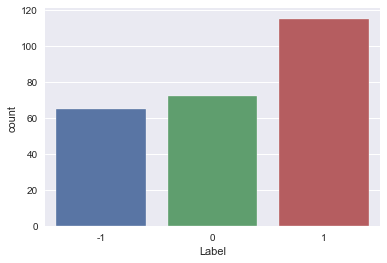

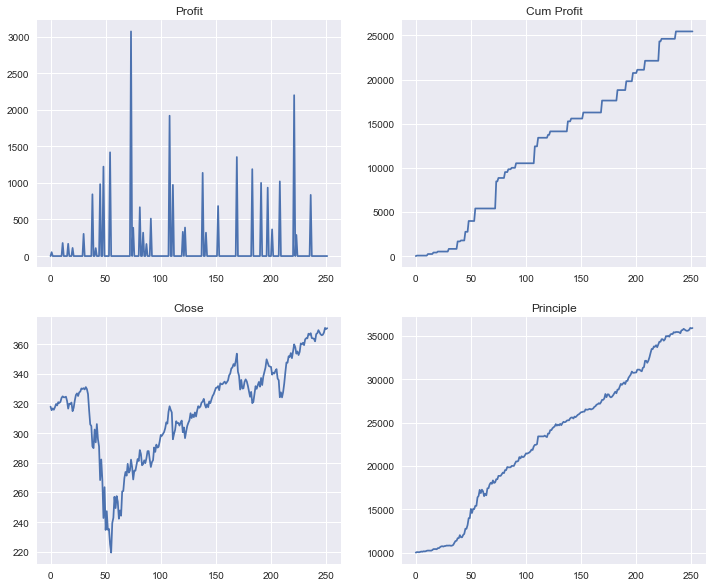

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | 25909.14 | 259.09%  |   272.45%    |   245    |  6.74  |
| Buy & Hold | 1163.85  |  11.64%  |    11.64%    |   252    |  0.63  |
+------------+----------+----------+--------------+----------+--------+


In [96]:
SPY_labeled_trade = SPY_labeled.loc[trade_start:,:].copy()

SPY_trading_log_trade = get_trading_log(SPY_labeled_trade, principle=principle, percent=percent)
SPY_trading_log_trade.to_csv('reports/SPY_trading_log_trade.csv')
SPY_trading_log_trade = pd.read_csv('reports/SPY_trading_log_trade.csv')
SPY_report_trade, _ = get_trading_report(SPY_trading_log_trade, principle=principle, percent=percent, show_fig=True)
print(SPY_report_trade)

Baseline Model

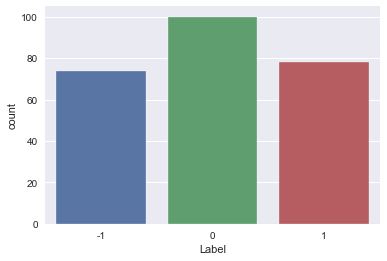

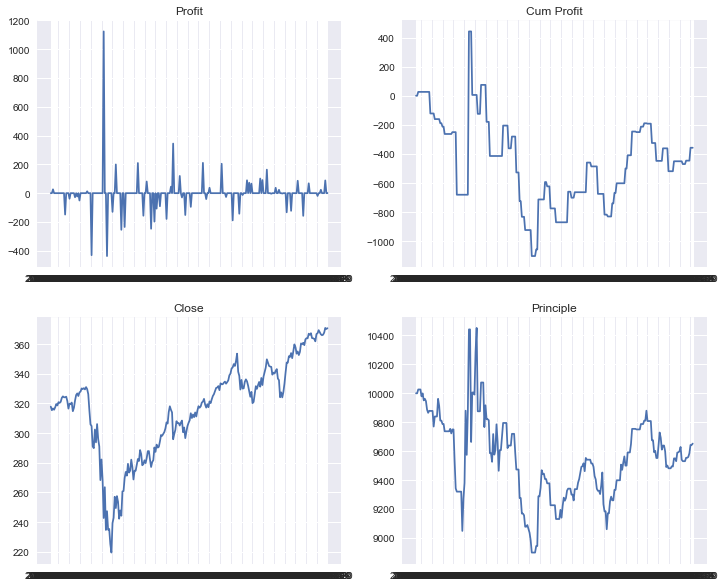

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  | -347.93 |  -3.48%  |    -4.14%    |   211    |  -0.1  |
| Buy & Hold | 1163.85 |  11.64%  |    11.64%    |   252    |  0.63  |
+------------+---------+----------+--------------+----------+--------+


In [158]:
SPY_baseline = pd.read_csv('data/processed/SPY_baseline.csv', index_col='Date')
SPY_baseline_trade = SPY_baseline.loc[trade_start:,:].copy()

SPY_trading_log_trade_baseline = get_trading_log(SPY_baseline_trade.loc[start:end,:], principle=principle, percent=percent)
SPY_baseline_trade_report, _ = get_trading_report(SPY_trading_log_trade_baseline, principle=principle, percent=percent, show_fig=True)
print(SPY_baseline_trade_report)

### TLT

Meta-Labeling

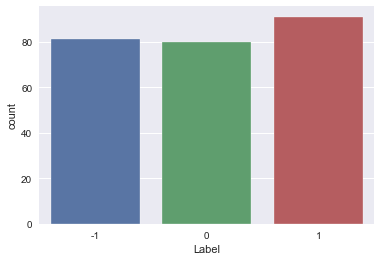

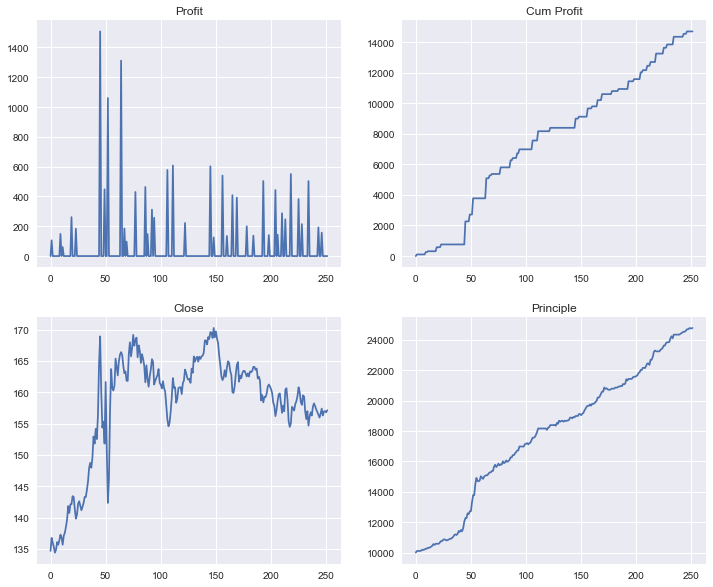

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | 14782.55 | 147.83%  |   171.48%    |   229    |  7.7   |
| Buy & Hold | 1144.55  |  11.45%  |    11.45%    |   252    |  0.82  |
+------------+----------+----------+--------------+----------+--------+


In [159]:
TLT_labeled_trade = TLT_labeled.loc[trade_start:,:].copy()

TLT_trading_log_trade = get_trading_log(TLT_labeled_trade, principle=principle, percent=percent)
TLT_trading_log_trade.to_csv('reports/TLT_trading_log_trade.csv')
TLT_trading_log_trade = pd.read_csv('reports/TLT_trading_log_trade.csv')
TLT_report_trade, _ = get_trading_report(TLT_trading_log_trade, principle=principle, percent=percent, show_fig=True)
print(TLT_report_trade)

Baseline Model

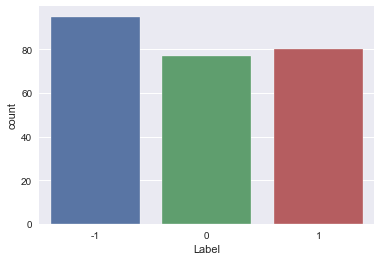

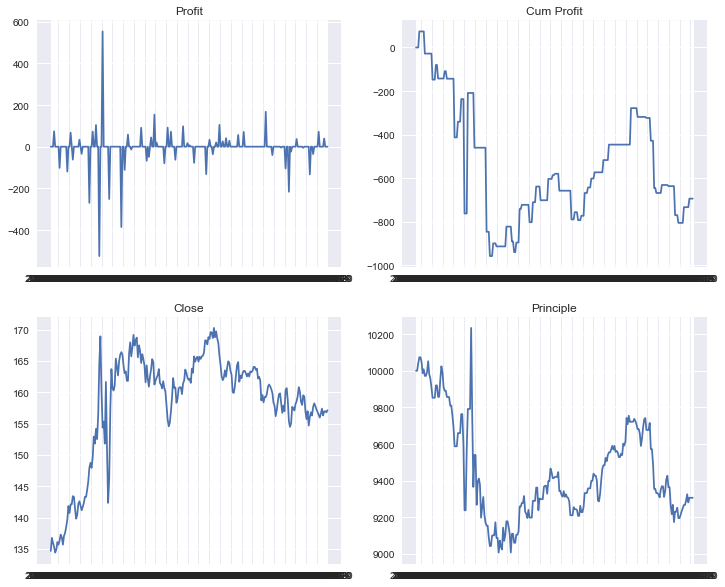

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  | -693.52 |  -6.94%  |    -7.39%    |   236    | -0.49  |
| Buy & Hold | 1144.55 |  11.45%  |    11.45%    |   252    |  0.82  |
+------------+---------+----------+--------------+----------+--------+


In [160]:
TLT_baseline = pd.read_csv('data/processed/TLT_baseline.csv', index_col='Date')
TLT_baseline_trade = TLT_baseline.loc[trade_start:,:].copy()

TLT_trading_log_trade_baseline = get_trading_log(TLT_baseline_trade.loc[start:end,:], principle=principle, percent=percent)
TLT_baseline_trade_report, _ = get_trading_report(TLT_trading_log_trade_baseline, principle=principle, percent=percent, show_fig=True)
print(TLT_baseline_trade_report)

### USO

Meta-Labeling

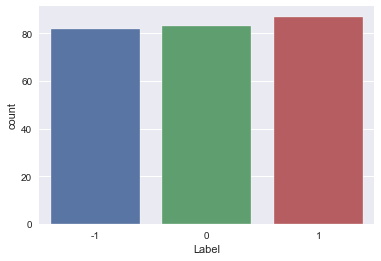

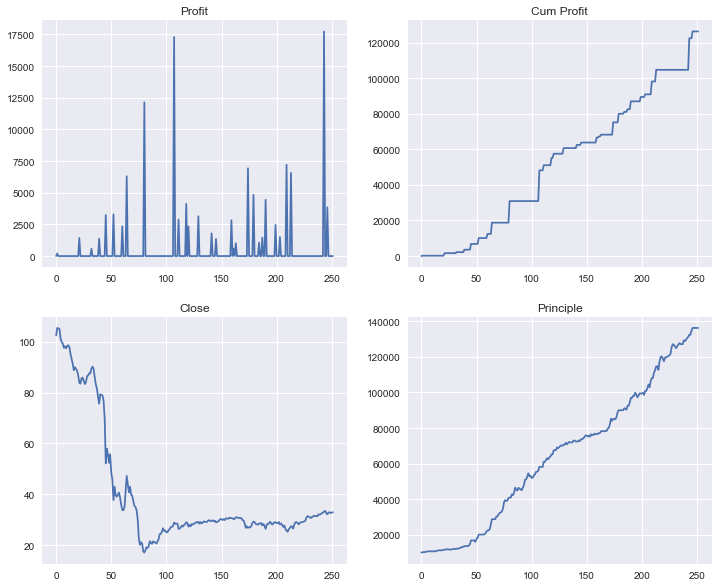

+------------+-----------+----------+--------------+----------+--------+
|   Model    |   Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+-----------+----------+--------------+----------+--------+
|  Strategy  | 126259.18 | 1262.59% |   1565.81%   |   234    |  7.58  |
| Buy & Hold |  -4730.76 | -47.31%  |   -47.31%    |   252    | -1.24  |
+------------+-----------+----------+--------------+----------+--------+


In [161]:
USO_labeled_trade = USO_labeled.loc[trade_start:,:].copy()

USO_trading_log_trade = get_trading_log(USO_labeled_trade, principle=principle, percent=percent)
USO_trading_log_trade.to_csv('reports/USO_trading_log_trade.csv')
USO_trading_log_trade = pd.read_csv('reports/USO_trading_log_trade.csv')
USO_report_trade, _ = get_trading_report(USO_trading_log_trade, principle=principle, percent=percent, show_fig=True)
print(USO_report_trade)

Baseline Model

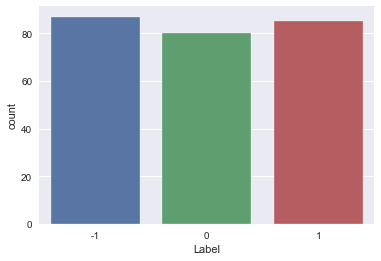

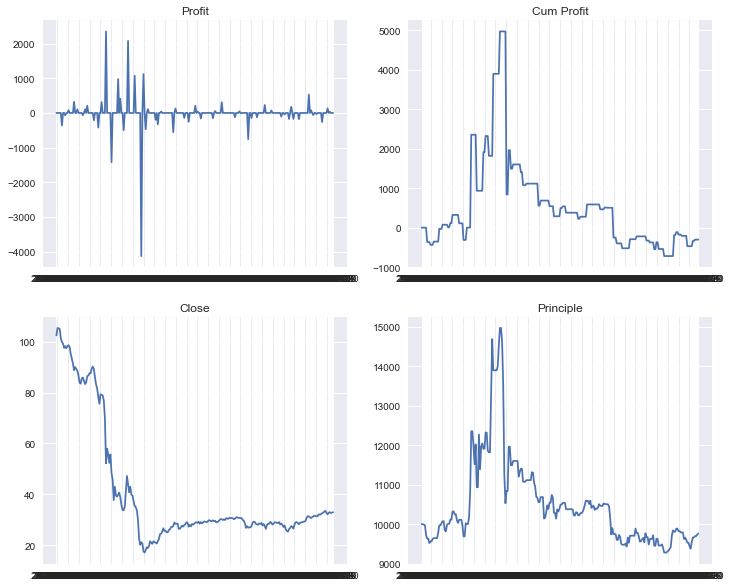

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | -235.75  |  -2.36%  |    -2.64%    |   225    |  0.15  |
| Buy & Hold | -4730.76 | -47.31%  |   -47.31%    |   252    | -1.24  |
+------------+----------+----------+--------------+----------+--------+


In [162]:
USO_baseline = pd.read_csv('data/processed/USO_baseline.csv', index_col='Date')
USO_baseline_trade = USO_baseline.loc[trade_start:,:].copy()

USO_trading_log_trade_baseline = get_trading_log(USO_baseline_trade.loc[start:end,:], principle=principle, percent=percent)
USO_baseline_trade_report, _ = get_trading_report(USO_trading_log_trade_baseline, principle=principle, percent=percent, show_fig=True)
print(USO_baseline_trade_report)

## Classification - Classical Learning

### SPY

#### Model Selection

In [120]:
SPY_chosen = clas_model_selection(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test)

          Test Score  Test F1  Train Score  Train F1
Model                                               
DTC             0.41     0.41         1.00      1.00
ETE             0.37     0.36         1.00      1.00
ETC             0.33     0.36         1.00      1.00
Bagging         0.37     0.36         0.99      0.99
XGB             0.33     0.32         1.00      1.00
SGD             0.34     0.31         0.34      0.25
RF              0.28     0.31         1.00      1.00
KNN             0.32     0.31         0.63      0.63
LR              0.31     0.30         0.39      0.38
AdaBoost        0.34     0.29         0.47      0.48
SVC             0.33     0.29         0.33      0.22
BNB             0.32     0.29         0.34      0.23
GB              0.29     0.24         0.74      0.76
LDA             0.35     0.24         0.41      0.41
QDA             0.35     0.24         0.53      0.53
RidgeC          0.32     0.24         0.40      0.40
GNB             0.36     0.20         0.38    

In [121]:
SPY_chosen

Index(['DTC', 'ETE', 'ETC', 'Bagging', 'XGB', 'SGD', 'RF', 'KNN', 'LR',
       'AdaBoost'],
      dtype='object', name='Model')

In [138]:
SPY_chosen = ['DTC', 'ETE', 'ETC', 'Bagging', 'XGB', 'SGD', 'RF', 'KNN', 'LR',
       'AdaBoost']

#### Randomized Search

In [122]:
clas_rs(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test, SPY_chosen)

============= DTC Randomized Search =============
Best Parameters: {'classifier__splitter': 'random', 'classifier__min_samples_split': 0.01, 'classifier__min_samples_leaf': 0.005, 'classifier__max_features': 'log2', 'classifier__max_depth': 7, 'classifier__criterion': 'gini', 'classifier__class_weight': None}
============= ETE Randomized Search =============
Best Parameters: {'classifier__n_jobs': -1, 'classifier__n_estimators': 1000, 'classifier__min_samples_split': 0.005, 'classifier__min_samples_leaf': 0.005, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__class_weight': 'balanced'}
============= ETC Randomized Search =============
Best Parameters: {'classifier__splitter': 'best', 'classifier__min_samples_split': 0.005, 'classifier__min_samples_leaf': 0.01, 'classifier__max_features': 'log2', 'classifier__max_depth': 5, 'classifier__criterion': 'entropy', 'classifier__class_weight': None}
============= Bagging Randomi

#### Grid Search

In [123]:
SPY_chosen2 = 'SGD'
SPY_SGD = clas_gs(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test, SPY_chosen2)
joblib.dump(SPY_SGD, 'models/SPY_SGD.pkl')

SPY_SGD = joblib.load("models/SPY_SGD.pkl")

============= SGD Grid Search =============
Best Parameters: {'classifier__penalty': 'l2', 'classifier__n_jobs': -1, 'classifier__loss': 'log', 'classifier__alpha': 1e-07}
Best Score: 0.3419671879075117


In [124]:
SPY_chosen2 = 'AdaBoost'
SPY_AdaBoost = clas_gs(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test, SPY_chosen2)
joblib.dump(SPY_AdaBoost, 'models/SPY_AdaBoost.pkl')

SPY_AdaBoost = joblib.load("models/SPY_AdaBoost.pkl")

============= AdaBoost Grid Search =============
Best Parameters: {'classifier__n_estimators': 200, 'classifier__learning_rate': 0.25, 'classifier__base_estimator': DecisionTreeClassifier(max_depth=2)}
Best Score: 0.3544241072233276


In [125]:
SPY_chosen2 = 'KNN'
SPY_KNN = clas_gs(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test, SPY_chosen2)
joblib.dump(SPY_KNN, 'models/SPY_KNN.pkl')

SPY_KNN = joblib.load("models/SPY_KNN.pkl")

============= KNN Grid Search =============
Best Parameters: {'classifier__weights': 'uniform', 'classifier__p': 5, 'classifier__n_neighbors': 11, 'classifier__n_jobs': -1, 'classifier__metric': 'manhattan', 'classifier__leaf_size': 35}
Best Score: 0.3401547070054623


In [126]:
SPY_chosen2 = 'ETE'
SPY_ETE = clas_gs(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test, SPY_chosen2)
joblib.dump(SPY_ETE, 'models/SPY_ETE.pkl')

SPY_ETE = joblib.load("models/SPY_ETE.pkl")

============= ETE Grid Search =============
Best Parameters: {'classifier__n_jobs': -1, 'classifier__n_estimators': 500, 'classifier__min_samples_split': 0.005, 'classifier__min_samples_leaf': 0.01, 'classifier__max_features': 'auto', 'classifier__max_depth': 50, 'classifier__criterion': 'gini', 'classifier__class_weight': None}
Best Score: 0.33807304047815523


In [27]:
# SPY_chosen2 = 'DTC'
# SPY_DTC = clas_gs(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test, SPY_chosen2)
# joblib.dump(SPY_DTC, 'models/SPY_DTC.pkl')

SPY_DTC = joblib.load("models/SPY_DTC.pkl")

#### Model Evaluation

Classification Report

In [28]:
SPY_model = SPY_DTC
SPY_y_trade_pred, SPY_perm = clas_evaluation(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test, SPY_X_trade_final, SPY_y_trade, SPY_model)

============= Trade Data =============
              precision    recall  f1-score   support

          -1       0.25      0.85      0.39        65
           0       0.18      0.04      0.07        72
           1       0.24      0.03      0.06       115

    accuracy                           0.25       252
   macro avg       0.22      0.31      0.17       252
weighted avg       0.22      0.25      0.15       252

Balanced Accuracy Score 0.3075343738387217


Feature Importance

In [29]:
eli5.show_weights(SPY_perm, feature_names = SPY_X_trade_final.columns.tolist())

Prediction Trading Report

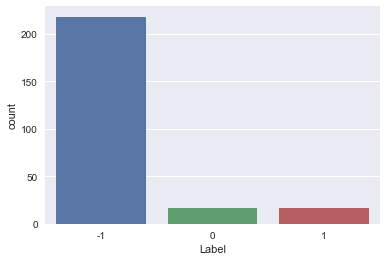

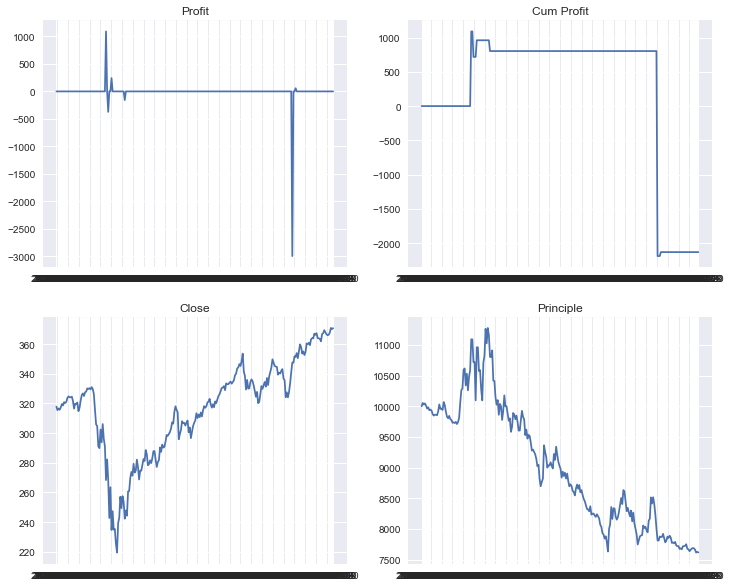

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | -2383.41 | -23.83%  |   -23.83%    |   252    | -0.94  |
| Buy & Hold | 1163.85  |  11.64%  |    11.64%    |   252    |  0.63  |
+------------+----------+----------+--------------+----------+--------+


In [32]:
SPY_y_trade_pred_clas = SPY[(SPY.index >= trade_start) & (SPY.index <= trade_end)]
SPY_y_trade_pred_clas['Label'] = SPY_y_trade_pred
SPY_y_trade_pred_clas.to_csv('data/processed/SPY_y_trade_pred_clas.csv')
SPY_y_trade_pred_clas = pd.read_csv('data/processed/SPY_y_trade_pred_clas.csv', index_col='Date')

SPY_trading_log_trade_clas = get_trading_log(SPY_y_trade_pred_clas, principle=principle, percent=percent)
SPY_trading_log_trade_clas.to_csv('reports/SPY_trading_log_trade_clas.csv')
SPY_trading_log_trade_clas = pd.read_csv('reports/SPY_trading_log_trade_clas.csv', index_col='Date')
SPY_report_trade_clas, _ = get_trading_report(SPY_trading_log_trade_clas, principle=principle, percent=percent, show_fig=True)
print(SPY_report_trade_clas)

### TLT

#### Model Selection

In [47]:
TLT_chosen = clas_model_selection(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test)

          Test Score  Test F1  Train Score  Train F1
Model                                               
LR              0.39     0.40         0.38      0.36
MLP             0.37     0.38         0.52      0.52
XGB             0.38     0.38         1.00      1.00
RF              0.37     0.37         1.00      1.00
RidgeC          0.37     0.37         0.38      0.37
GNB             0.39     0.36         0.37      0.37
DTC             0.35     0.36         1.00      1.00
KNN             0.40     0.35         0.62      0.62
LDA             0.37     0.34         0.39      0.38
Bagging         0.35     0.34         0.99      0.99
GB              0.33     0.32         0.77      0.78
AdaBoost        0.39     0.32         0.48      0.48
SGD             0.37     0.32         0.37      0.32
QDA             0.34     0.32         0.50      0.50
ETE             0.29     0.30         1.00      1.00
BNB             0.33     0.25         0.34      0.23
SVC             0.33     0.25         0.33    

In [48]:
TLT_chosen

Index(['LR', 'MLP', 'XGB', 'RF', 'RidgeC', 'GNB', 'DTC', 'KNN', 'LDA',
       'Bagging'],
      dtype='object', name='Model')

In [36]:
TLT_chosen = ['LR', 'MLP', 'XGB', 'RF', 'RidgeC', 'GNB', 'DTC', 'KNN', 'LDA',
       'Bagging']

#### Randomized Search

In [37]:
clas_rs(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test, TLT_chosen)

============= LR Randomized Search =============
Best Parameters: {'classifier__C': 10}
============= XGB Randomized Search =============
Best Parameters: {'classifier__subsample': 0.6, 'classifier__min_child_weight': 10, 'classifier__max_depth': 8, 'classifier__gamma': 5, 'classifier__colsample_bytree': 0.6}
============= RidgeC Randomized Search =============
Best Parameters: {'classifier__alpha': 1e-07}
============= RF Randomized Search =============
Best Parameters: {'classifier__n_jobs': -1, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 0.05, 'classifier__min_samples_leaf': 0.05, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 5, 'classifier__criterion': 'entropy', 'classifier__class_weight': None}
============= GNB Randomized Search =============
Best Parameters: {'classifier__var_smoothing': 1e-06}
============= DTC Randomized Search =============
Best Parameters: {'classifier__splitter': 'random', 'classifier__min_samples_split': 0.05, 'classif

#### Grid Search

In [38]:
TLT_chosen2 = 'GNB'
TLT_GNB = clas_gs(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test, TLT_chosen2)
joblib.dump(TLT_GNB, 'models/TLT_GNB.pkl')

#load model for further usage
TLT_GNB = joblib.load("models/TLT_GNB.pkl")

============= GNB Grid Search =============
Best Parameters: {'classifier__var_smoothing': 1e-05}
Best Score: 0.32471847339993376


In [51]:
TLT_chosen2 = 'KNN'
TLT_KNN = clas_gs(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test, TLT_chosen2)
joblib.dump(TLT_KNN, 'models/TLT_KNN.pkl')

#load model for further usage
TLT_KNN = joblib.load("models/TLT_KNN.pkl")

============= KNN Grid Search =============
Best Parameters: {'classifier__weights': 'uniform', 'classifier__p': 2, 'classifier__n_neighbors': 6, 'classifier__n_jobs': -1, 'classifier__metric': 'euclidean', 'classifier__leaf_size': 35}
Best Score: 0.3550818998836774


In [49]:
TLT_chosen2 = 'LDA'
TLT_LDA = clas_gs(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test, TLT_chosen2)
joblib.dump(TLT_LDA, 'models/TLT_LDA.pkl')

#load model for further usage
TLT_LDA = joblib.load("models/TLT_LDA.pkl")

============= LDA Grid Search =============
Best Parameters: {'classifier__solver': 'svd'}
Best Score: 0.3438228455702767


In [33]:
# TLT_chosen2 = 'DTC'
# TLT_DTC = clas_gs(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test, TLT_chosen2)
# joblib.dump(TLT_DTC, 'models/TLT_DTC.pkl')

#load model for further usage
TLT_DTC = joblib.load("models/TLT_DTC.pkl")

In [50]:
TLT_chosen2 = 'RidgeC'
TLT_RidgeC = clas_gs(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test, TLT_chosen2)
joblib.dump(TLT_RidgeC, 'models/TLT_RidgeC.pkl')

#load model for further usage
TLT_RidgeC = joblib.load("models/TLT_RidgeC.pkl")

============= RidgeC Grid Search =============
Best Parameters: {'classifier__alpha': 0.1}
Best Score: 0.34873248042596006


#### Model Evaluation

Classification Report

In [34]:
TLT_model = TLT_DTC
TLT_y_trade_pred, TLT_perm = clas_evaluation(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test, TLT_X_trade_final, TLT_y_trade, TLT_model)

============= Trade Data =============
              precision    recall  f1-score   support

          -1       0.39      0.15      0.21        81
           0       0.25      0.14      0.18        80
           1       0.33      0.65      0.44        91

    accuracy                           0.33       252
   macro avg       0.32      0.31      0.28       252
weighted avg       0.32      0.33      0.28       252

Balanced Accuracy Score 0.3113332654999322


Feature Importance

In [35]:
eli5.show_weights(TLT_perm, feature_names = TLT_X_trade_final.columns.tolist())

Prediction Trading Report

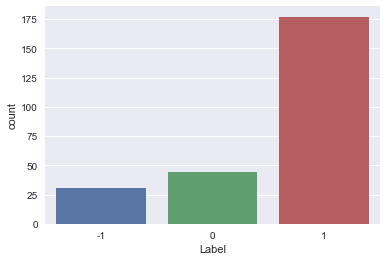

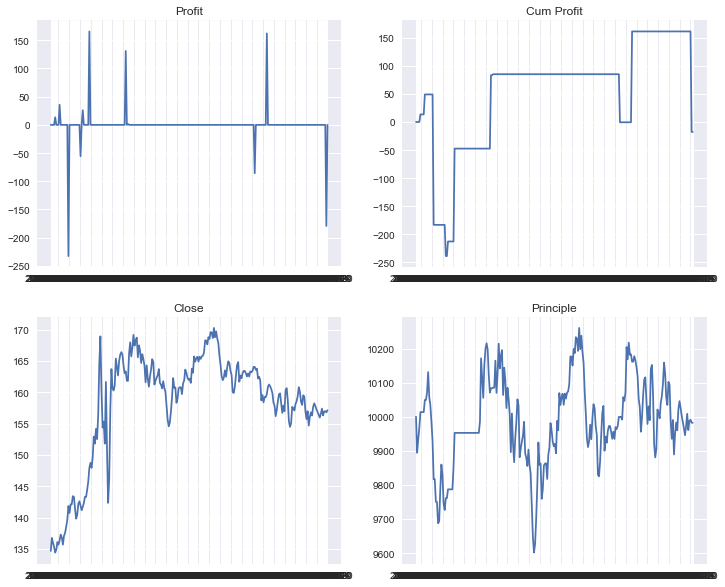

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  |  -17.75 |  -0.18%  |    -0.20%    |   226    |  0.02  |
| Buy & Hold | 1144.55 |  11.45%  |    11.45%    |   252    |  0.82  |
+------------+---------+----------+--------------+----------+--------+


In [36]:
TLT_y_trade_pred_clas = TLT[(TLT.index >= trade_start) & (TLT.index <= trade_end)]
TLT_y_trade_pred_clas['Label'] = TLT_y_trade_pred
TLT_y_trade_pred_clas.to_csv('data/processed/TLT_y_trade_pred_clas.csv')
TLT_y_trade_pred_clas = pd.read_csv('data/processed/TLT_y_trade_pred_clas.csv', index_col='Date')

TLT_trading_log_trade_clas = get_trading_log(TLT_y_trade_pred_clas, principle=principle, percent=percent)
TLT_trading_log_trade_clas.to_csv('reports/TLT_trading_log_trade_clas.csv')
TLT_trading_log_trade_clas = pd.read_csv('reports/TLT_trading_log_trade_clas.csv', index_col='Date')
TLT_report_trade_clas, _ = get_trading_report(TLT_trading_log_trade_clas, principle=principle, percent=percent, show_fig=True)
print(TLT_report_trade_clas)

### USO

#### Model Selection

In [155]:
USO_chosen = clas_model_selection(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test)

          Test Score  Test F1  Train Score  Train F1
Model                                               
ETC             0.36     0.37         1.00      1.00
ETE             0.36     0.36         1.00      1.00
XGB             0.35     0.36         1.00      1.00
Bagging         0.35     0.34         0.99      0.99
DTC             0.32     0.33         1.00      1.00
RF              0.33     0.32         1.00      1.00
AdaBoost        0.31     0.31         0.49      0.49
KNN             0.32     0.30         0.63      0.63
GB              0.30     0.30         0.75      0.75
BNB             0.33     0.28         0.36      0.32
LR              0.33     0.27         0.38      0.36
GNB             0.33     0.26         0.37      0.34
NuSVC           0.29     0.24         0.47      0.47
SGD             0.33     0.23         0.34      0.24
MLP             0.36     0.21         0.49      0.49
LDA             0.35     0.20         0.40      0.39
RidgeC          0.34     0.19         0.39    

In [156]:
USO_chosen

Index(['ETC', 'ETE', 'XGB', 'Bagging', 'DTC', 'RF', 'AdaBoost', 'KNN', 'GB',
       'BNB'],
      dtype='object', name='Model')

In [157]:
USO_chosen = ['ETC', 'ETE', 'XGB', 'Bagging', 'DTC', 'RF', 'AdaBoost', 'KNN', 'GB',
       'BNB']

#### Randomized Search

In [176]:
clas_rs(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test, USO_chosen)

============= ETE Randomized Search =============
Best Parameters: {'classifier__n_jobs': -1, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 0.005, 'classifier__min_samples_leaf': 0.005, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__class_weight': None}
============= XGB Randomized Search =============
Best Parameters: {'classifier__subsample': 1.0, 'classifier__min_child_weight': 5, 'classifier__max_depth': 3, 'classifier__gamma': 1.5, 'classifier__colsample_bytree': 0.6}
============= ETC Randomized Search =============
Best Parameters: {'classifier__splitter': 'best', 'classifier__min_samples_split': 0.05, 'classifier__min_samples_leaf': 0.1, 'classifier__max_features': 'auto', 'classifier__max_depth': 5, 'classifier__criterion': 'gini', 'classifier__class_weight': 'balanced'}
============= RF Randomized Search =============
Best Parameters: {'classifier__n_jobs': -1, 'classifier__n_estimators': 1000

#### Grid Search

In [177]:
USO_chosen2 = 'ETC'
USO_ETC = clas_gs(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test, USO_chosen2)
joblib.dump(USO_ETC, 'models/USO_ETC.pkl')

USO_ETC = joblib.load("models/USO_ETC.pkl")

============= ETC Grid Search =============
Best Parameters: {'classifier__splitter': 'best', 'classifier__min_samples_split': 0.005, 'classifier__min_samples_leaf': 0.01, 'classifier__max_features': 'auto', 'classifier__max_depth': 4, 'classifier__criterion': 'entropy', 'classifier__class_weight': 'balanced'}
Best Score: 0.34940841929951805


In [178]:
USO_chosen2 = 'ETE'
USO_ETE = clas_gs(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test, USO_chosen2)
joblib.dump(USO_ETE, 'models/USO_ETE.pkl')

USO_ETE = joblib.load("models/USO_ETE.pkl")

============= ETE Grid Search =============
Best Parameters: {'classifier__n_jobs': -1, 'classifier__n_estimators': 1000, 'classifier__min_samples_split': 0.01, 'classifier__min_samples_leaf': 0.1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__class_weight': None}
Best Score: 0.3412963676303222


In [158]:
USO_chosen2 = 'RF'
USO_RF = clas_gs(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test, USO_chosen2)
joblib.dump(USO_RF, 'models/USO_RF.pkl')

USO_RF = joblib.load("models/USO_RF.pkl")

============= RF Grid Search =============
Best Parameters: {'classifier__n_jobs': -1, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 0.1, 'classifier__min_samples_leaf': 0.01, 'classifier__max_features': 'log2', 'classifier__max_depth': 3, 'classifier__criterion': 'entropy', 'classifier__class_weight': 'balanced'}
Best Score: 0.34184820415406414


In [180]:
USO_chosen2 = 'GB'
USO_GB = clas_gs(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test, USO_chosen2)
joblib.dump(USO_GB, 'models/USO_GB.pkl')

USO_GB = joblib.load("models/USO_GB.pkl")

============= GB Grid Search =============
Best Parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 0.005, 'classifier__min_samples_leaf': 0.005, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 6, 'classifier__learning_rate': 0.15}
Best Score: 0.34714750159980134


In [37]:
# USO_chosen2 = 'XGB'
# USO_XGB = clas_gs(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test, USO_chosen2)
# joblib.dump(USO_XGB, 'models/USO_XGB.pkl')

USO_XGB = joblib.load("models/USO_XGB.pkl")

#### Model Evaluation

Classification Report

In [38]:
USO_model = USO_XGB
USO_y_trade_pred, USO_perm = clas_evaluation(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test, USO_X_trade_final, USO_y_trade, USO_model)

============= Trade Data =============
              precision    recall  f1-score   support

          -1       0.33      0.23      0.27        82
           0       0.38      0.22      0.27        83
           1       0.35      0.59      0.44        87

    accuracy                           0.35       252
   macro avg       0.35      0.34      0.33       252
weighted avg       0.35      0.35      0.33       252

Balanced Accuracy Score 0.3449272278348043


Feature Importance

In [39]:
eli5.show_weights(TLT_perm, feature_names = TLT_X_trade_final.columns.tolist())

Prediction Trading Report

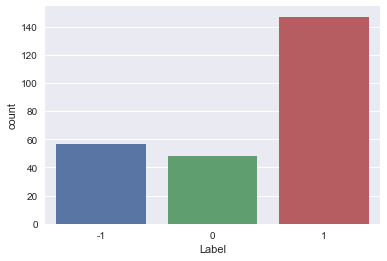

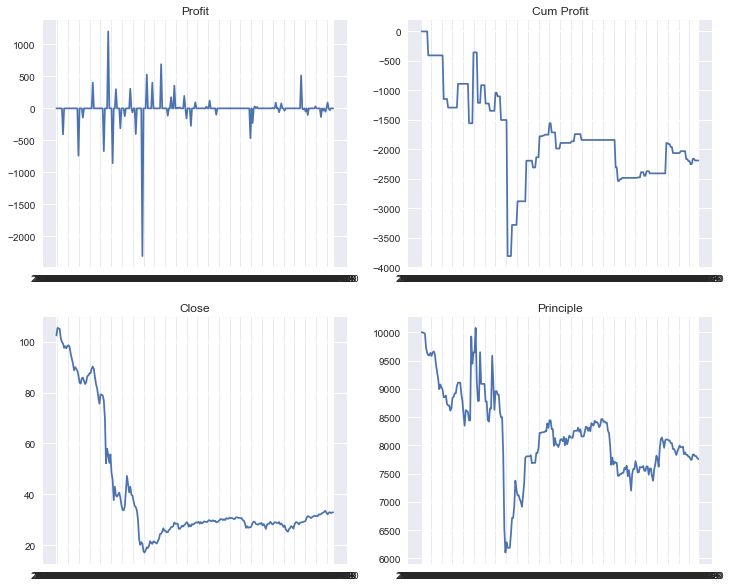

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | -2243.42 | -22.43%  |   -23.24%    |   242    | -0.41  |
| Buy & Hold | -4730.76 | -47.31%  |   -47.31%    |   252    | -1.24  |
+------------+----------+----------+--------------+----------+--------+


In [40]:
USO_y_trade_pred_clas = USO[(USO.index >= trade_start) & (USO.index <= trade_end)]
USO_y_trade_pred_clas['Label'] = USO_y_trade_pred
USO_y_trade_pred_clas.to_csv('data/processed/USO_y_trade_pred_clas.csv')
USO_y_trade_pred_clas = pd.read_csv('data/processed/USO_y_trade_pred_clas.csv', index_col='Date')

USO_trading_log_trade_clas = get_trading_log(USO_y_trade_pred_clas, principle=principle, percent=percent)
USO_trading_log_trade_clas.to_csv('reports/USO_trading_log_trade_clas.csv')
USO_trading_log_trade_clas = pd.read_csv('reports/USO_trading_log_trade_clas.csv', index_col='Date')
USO_report_trade_clas, _ = get_trading_report(USO_trading_log_trade_clas, principle=principle, percent=percent, show_fig=True)
print(USO_report_trade_clas)

## Classification - Neural Network

### SPY

#### Data Transformation

In [163]:
SPY_X_train_transformed, SPY_y_train_transformed, SPY_X_test_transformed, SPY_y_test_transformed, SPY_X_trade_transformed, SPY_y_trade_transformed, SPY_encoder = data_transform(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test, SPY_X_trade_final, SPY_y_trade, 'clas')

In [164]:
SPY_X_train_seq, SPY_y_train_seq = split_sequences(SPY_X_train_transformed, SPY_y_train_transformed, WINDOW_SPY)
SPY_X_test_seq, SPY_y_test_seq = split_sequences(SPY_X_test_transformed, SPY_y_test_transformed, WINDOW_SPY)
SPY_X_trade_seq, SPY_y_trade_seq = split_sequences(SPY_X_trade_transformed, SPY_y_trade_transformed, WINDOW_SPY)

(2512, 5, 30) (2512,)
(248, 5, 30) (248,)
(248, 5, 30) (248,)


In [165]:
n_features = SPY_X_train_seq.shape[2]
n_steps = SPY_X_train_seq.shape[1]
n_classes = 3
print('Number of Features:', n_features)
print('Number of Steps:', n_steps)
print('Number of Classes:', n_classes)

Number of Features: 30
Number of Steps: 5
Number of Classes: 3


#### CNN

Model

In [166]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=20, kernel_size=2,activation='relu',input_shape=(n_steps, n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(5, activation='relu'))
cnn_model.add(Dense(n_classes, activation='softmax'))
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=4)
class_weight = {"buy": 0.75, "don't buy": 0.25}
cnn_model.fit(SPY_X_train_seq,SPY_y_train_seq, epochs=500, validation_data=(SPY_X_test_seq,SPY_y_test_seq), 
          verbose=1, callbacks=[early_stop])

Epoch 1/500
79/79 [==============================] - 0s 3ms/step - loss: 1.1039 - accuracy: 0.3710 - val_loss: 1.0840 - val_accuracy: 0.4234
Epoch 2/500
79/79 [==============================] - 0s 2ms/step - loss: 1.0911 - accuracy: 0.3893 - val_loss: 1.0774 - val_accuracy: 0.4476
Epoch 3/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0884 - accuracy: 0.3925 - val_loss: 1.0706 - val_accuracy: 0.4516
Epoch 4/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0862 - accuracy: 0.3913 - val_loss: 1.0752 - val_accuracy: 0.4597
Epoch 5/500
79/79 [==============================] - 0s 2ms/step - loss: 1.0838 - accuracy: 0.3921 - val_loss: 1.0738 - val_accuracy: 0.4637
Epoch 6/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0810 - accuracy: 0.3969 - val_loss: 1.0765 - val_accuracy: 0.4435
Epoch 7/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0787 - accuracy: 0.4029 - val_loss: 1.0724 - val_accuracy: 0.4435


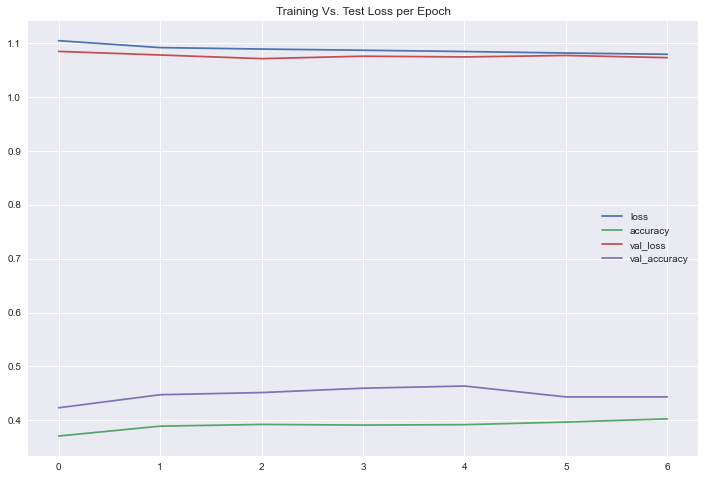

In [167]:
# evaluation
losses = pd.DataFrame(cnn_model.history.history)
losses.plot(figsize=(12,8))
plt.title("Training Vs. Test Loss per Epoch")
plt.show()

Classification Report

In [168]:
SPY_y_trade_seq_pred = cnn_model.predict(SPY_X_trade_seq)
SPY_y_trade_seq_pred = SPY_y_trade_seq_pred.argmax(axis=1)

SPY_y_trade = SPY_encoder.inverse_transform(SPY_y_trade_seq)
SPY_y_trade_seq_pred = SPY_encoder.inverse_transform(SPY_y_trade_seq_pred)

print(classification_report(SPY_y_trade, SPY_y_trade_seq_pred))

              precision    recall  f1-score   support

          -1       0.21      0.53      0.30        64
           0       0.30      0.10      0.15        72
           1       0.35      0.21      0.26       112

    accuracy                           0.26       248
   macro avg       0.29      0.28      0.24       248
weighted avg       0.30      0.26      0.24       248



Prediction Trading Report

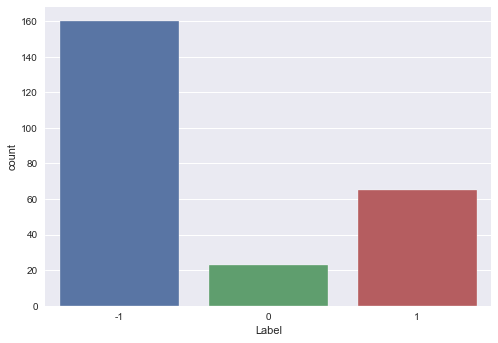

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

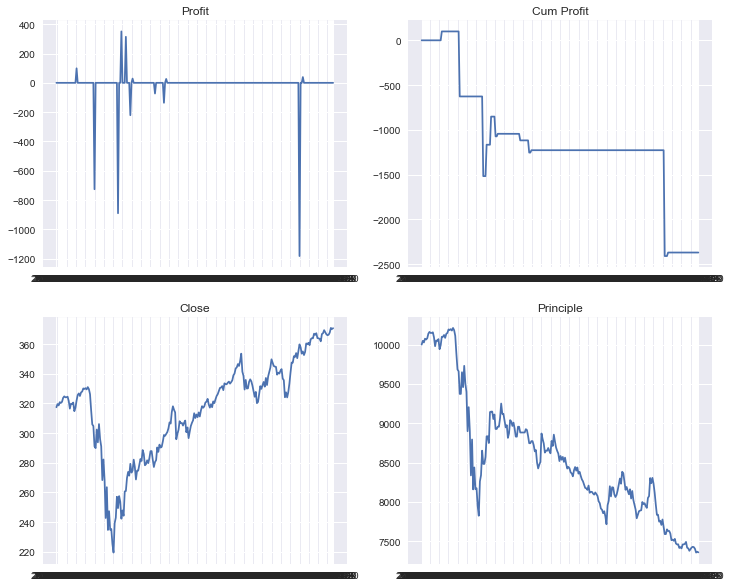

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | -2642.25 | -26.42%  |   -27.06%    |   245    | -1.27  |
| Buy & Hold | 1172.89  |  11.73%  |    11.93%    |   248    |  0.64  |
+------------+----------+----------+--------------+----------+--------+


In [169]:
SPY_y_trade_pred_cnn_clas = SPY[-len(SPY_y_trade_seq_pred):]
SPY_y_trade_pred_cnn_clas['Label'] = SPY_y_trade_seq_pred
SPY_y_trade_pred_cnn_clas.to_csv('data/processed/SPY_y_trade_pred_cnn_clas.csv')
SPY_y_trade_pred_cnn_clas = pd.read_csv('data/processed/SPY_y_trade_pred_cnn_clas.csv', index_col='Date')

SPY_trading_log_trade_cnn_clas = get_trading_log(SPY_y_trade_pred_cnn_clas, principle=principle, percent=percent)
SPY_trading_log_trade_cnn_clas.to_csv('reports/SPY_trading_log_trade_cnn_clas.csv')
SPY_trading_log_trade_cnn_clas = pd.read_csv('reports/SPY_trading_log_trade_cnn_clas.csv', index_col='Date')
SPY_report_trade_cnn, _ = get_trading_report(SPY_trading_log_trade_cnn_clas, show_fig=True)
print(SPY_report_trade_cnn)

#### LSTM

Model

In [170]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
lstm_model.add(LSTM(50, activation='relu', return_sequences=False))
lstm_model.add(Dense(10))
lstm_model.add(Dense(n_classes, activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=4)
lstm_model.fit(SPY_X_train_seq,SPY_y_train_seq, epochs=500, validation_data=(SPY_X_test_seq,SPY_y_test_seq), 
          verbose=1, callbacks=[early_stop])

Epoch 1/500
79/79 [==============================] - 1s 10ms/step - loss: 1.0928 - accuracy: 0.3822 - val_loss: 1.0681 - val_accuracy: 0.4597
Epoch 2/500
79/79 [==============================] - 1s 7ms/step - loss: 1.0911 - accuracy: 0.3826 - val_loss: 1.0711 - val_accuracy: 0.4597
Epoch 3/500
79/79 [==============================] - 1s 7ms/step - loss: 1.0871 - accuracy: 0.3953 - val_loss: 1.0724 - val_accuracy: 0.4637
Epoch 4/500
79/79 [==============================] - 1s 7ms/step - loss: 1.0833 - accuracy: 0.3993 - val_loss: 1.0846 - val_accuracy: 0.3306
Epoch 5/500
79/79 [==============================] - 1s 6ms/step - loss: 1.0863 - accuracy: 0.3937 - val_loss: 1.0667 - val_accuracy: 0.4395
Epoch 6/500
79/79 [==============================] - 1s 7ms/step - loss: 1.0775 - accuracy: 0.3949 - val_loss: 1.0749 - val_accuracy: 0.4315
Epoch 7/500
79/79 [==============================] - 1s 7ms/step - loss: 1.0763 - accuracy: 0.4037 - val_loss: 1.0864 - val_accuracy: 0.4234
Epoch 8/500


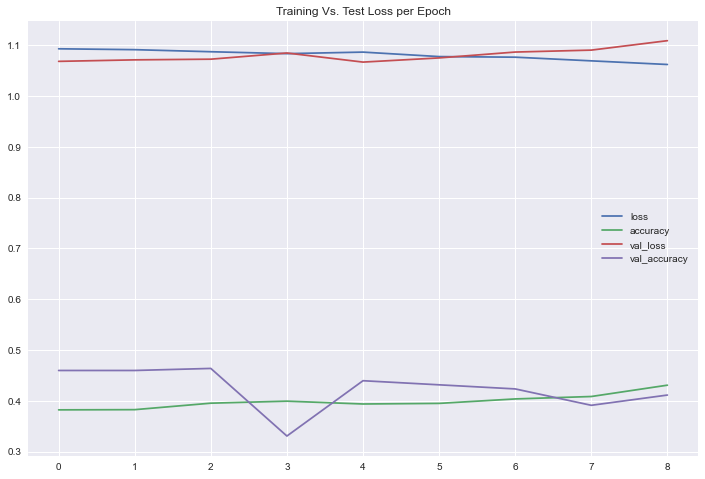

In [171]:
# evaluation
losses = pd.DataFrame(lstm_model.history.history)
losses.plot(figsize=(12,8))
plt.title("Training Vs. Test Loss per Epoch")
plt.show()

Classification Report

In [172]:
SPY_y_trade_seq_pred = lstm_model.predict(SPY_X_trade_seq)
SPY_y_trade_seq_pred = SPY_y_trade_seq_pred.argmax(axis=1)

SPY_y_trade = SPY_encoder.inverse_transform(SPY_y_trade_seq)
SPY_y_trade_seq_pred = SPY_encoder.inverse_transform(SPY_y_trade_seq_pred)

print(classification_report(SPY_y_trade, SPY_y_trade_seq_pred))

              precision    recall  f1-score   support

          -1       0.22      0.28      0.24        64
           0       1.00      0.01      0.03        72
           1       0.44      0.64      0.52       112

    accuracy                           0.37       248
   macro avg       0.55      0.31      0.26       248
weighted avg       0.54      0.37      0.31       248



Prediction Trading Report

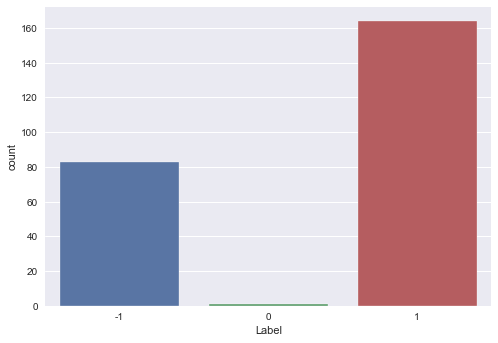

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

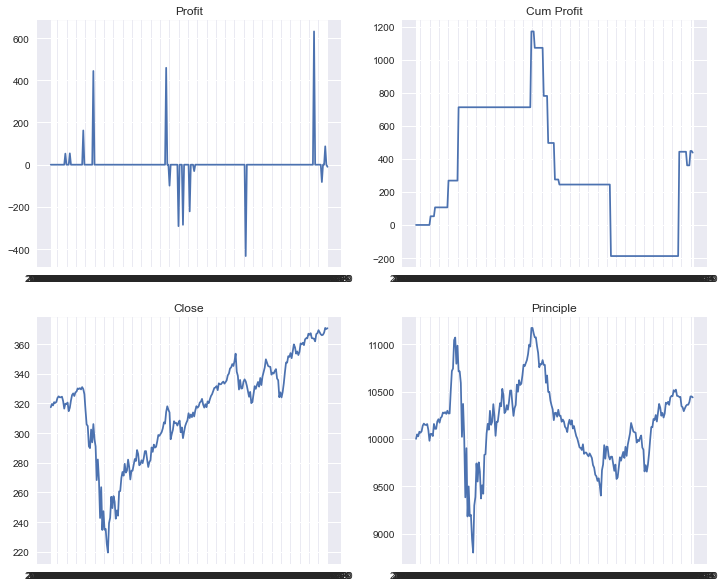

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  |  437.77 |  4.38%   |    4.45%     |   248    |  0.31  |
| Buy & Hold | 1172.89 |  11.73%  |    11.93%    |   248    |  0.64  |
+------------+---------+----------+--------------+----------+--------+


In [173]:
SPY_y_trade_pred_lstm_clas = SPY[-len(SPY_y_trade_seq_pred):]
SPY_y_trade_pred_lstm_clas['Label'] = SPY_y_trade_seq_pred
SPY_y_trade_pred_lstm_clas.to_csv('data/processed/SPY_y_trade_pred_lstm_clas.csv')
SPY_y_trade_pred_lstm_clas = pd.read_csv('data/processed/SPY_y_trade_pred_lstm_clas.csv', index_col='Date')

SPY_trading_log_trade_lstm_clas = get_trading_log(SPY_y_trade_pred_lstm_clas, principle=principle, percent=percent)
SPY_trading_log_trade_lstm_clas.to_csv('reports/SPY_trading_log_trade_lstm_clas.csv')
SPY_trading_log_trade_lstm_clas = pd.read_csv('reports/SPY_trading_log_trade_lstm_clas.csv', index_col='Date')
SPY_report_trade_lstm, _ = get_trading_report(SPY_trading_log_trade_lstm_clas, show_fig=True)
print(SPY_report_trade_lstm)

### TLT

#### Data Transformation

In [41]:
TLT_X_train_transformed, TLT_y_train_transformed, TLT_X_test_transformed, TLT_y_test_transformed, TLT_X_trade_transformed, TLT_y_trade_transformed, TLT_encoder = data_transform(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test, TLT_X_trade_final, TLT_y_trade, 'clas')

In [42]:
TLT_X_train_seq, TLT_y_train_seq = split_sequences(TLT_X_train_transformed, TLT_y_train_transformed, WINDOW_TLT)
TLT_X_test_seq, TLT_y_test_seq = split_sequences(TLT_X_test_transformed, TLT_y_test_transformed, WINDOW_TLT)
TLT_X_trade_seq, TLT_y_trade_seq = split_sequences(TLT_X_trade_transformed, TLT_y_trade_transformed, WINDOW_TLT)

(2512, 5, 30) (2512,)
(248, 5, 30) (248,)
(248, 5, 30) (248,)


In [43]:
n_features = TLT_X_train_seq.shape[2]
n_steps = TLT_X_train_seq.shape[1]
n_classes = 3
print('Number of Features:', n_features)
print('Number of Steps:', n_steps)
print('Number of Classes:', n_classes)

Number of Features: 30
Number of Steps: 5
Number of Classes: 3


#### CNN

Model

In [44]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=20, kernel_size=2,activation='relu',input_shape=(n_steps, n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(5, activation='relu'))
cnn_model.add(Dense(n_classes, activation='softmax'))
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=4)
cnn_model.fit(TLT_X_train_seq,TLT_y_train_seq, epochs=500, validation_data=(TLT_X_test_seq,TLT_y_test_seq), 
          verbose=1, callbacks=[early_stop])

Epoch 1/500
79/79 [==============================] - 0s 5ms/step - loss: 1.0967 - accuracy: 0.3475 - val_loss: 1.0917 - val_accuracy: 0.4153
Epoch 2/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0943 - accuracy: 0.3834 - val_loss: 1.0887 - val_accuracy: 0.4476
Epoch 3/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0929 - accuracy: 0.3794 - val_loss: 1.0893 - val_accuracy: 0.4234
Epoch 4/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0921 - accuracy: 0.3818 - val_loss: 1.0874 - val_accuracy: 0.4234
Epoch 5/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0910 - accuracy: 0.3818 - val_loss: 1.0875 - val_accuracy: 0.4234
Epoch 6/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0903 - accuracy: 0.3806 - val_loss: 1.0873 - val_accuracy: 0.4274
Epoch 7/500
79/79 [==============================] - 0s 2ms/step - loss: 1.0895 - accuracy: 0.3830 - val_loss: 1.0850 - val_accuracy: 0.4234
Epoch 8/500
7

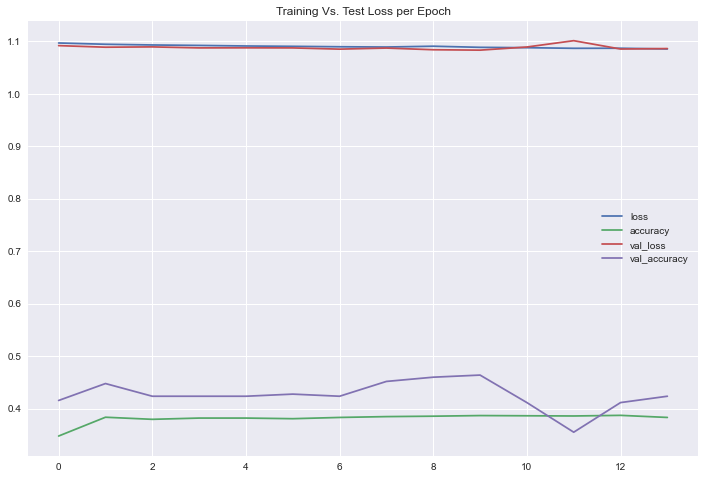

In [45]:
# evaluation
losses = pd.DataFrame(cnn_model.history.history)
losses.plot(figsize=(12,8))
plt.title("Training Vs. Test Loss per Epoch")
plt.show()

Classification Report

In [46]:
TLT_y_trade_seq_pred = cnn_model.predict(TLT_X_trade_seq)
TLT_y_trade_seq_pred = TLT_y_trade_seq_pred.argmax(axis=1)

TLT_y_trade = TLT_encoder.inverse_transform(TLT_y_trade_seq)
TLT_y_trade_seq_pred = TLT_encoder.inverse_transform(TLT_y_trade_seq_pred)

print(classification_report(TLT_y_trade, TLT_y_trade_seq_pred))

              precision    recall  f1-score   support

          -1       0.33      0.26      0.29        80
           0       0.00      0.00      0.00        78
           1       0.40      0.82      0.54        90

    accuracy                           0.38       248
   macro avg       0.24      0.36      0.28       248
weighted avg       0.25      0.38      0.29       248



Prediction Trading Report

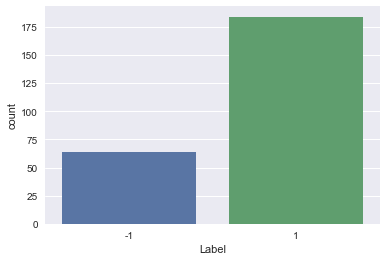

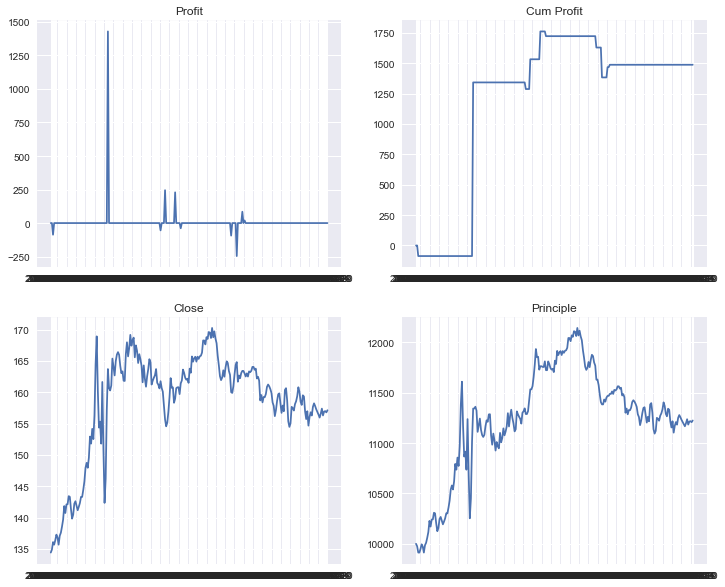

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  | 1223.33 |  12.23%  |    12.44%    |   248    |  0.84  |
| Buy & Hold | 1180.79 |  11.81%  |    12.01%    |   248    |  0.84  |
+------------+---------+----------+--------------+----------+--------+


In [47]:
TLT_y_trade_pred_cnn_clas = TLT[-len(TLT_y_trade_seq_pred):]
TLT_y_trade_pred_cnn_clas['Label'] = TLT_y_trade_seq_pred
TLT_y_trade_pred_cnn_clas.to_csv('data/processed/TLT_y_trade_pred_cnn_clas.csv')
TLT_y_trade_pred_cnn_clas = pd.read_csv('data/processed/TLT_y_trade_pred_cnn_clas.csv', index_col='Date')

TLT_trading_log_trade_cnn_clas = get_trading_log(TLT_y_trade_pred_cnn_clas, principle=principle, percent=percent)
TLT_trading_log_trade_cnn_clas.to_csv('reports/TLT_trading_log_trade_cnn_clas.csv')
TLT_trading_log_trade_cnn_clas = pd.read_csv('reports/TLT_trading_log_trade_cnn_clas.csv', index_col='Date')
TLT_report_trade_cnn, _ = get_trading_report(TLT_trading_log_trade_cnn_clas, show_fig=True)
print(TLT_report_trade_cnn)

#### LSTM

Model

In [48]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
lstm_model.add(LSTM(50, activation='relu', return_sequences=False))
lstm_model.add(Dense(10))
lstm_model.add(Dense(n_classes, activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=4)
lstm_model.fit(TLT_X_train_seq,TLT_y_train_seq, epochs=500, validation_data=(TLT_X_test_seq,TLT_y_test_seq), 
          verbose=1, callbacks=[early_stop])

Epoch 1/500
79/79 [==============================] - 1s 10ms/step - loss: 1.0961 - accuracy: 0.3563 - val_loss: 1.0839 - val_accuracy: 0.4234
Epoch 2/500
79/79 [==============================] - 1s 7ms/step - loss: 1.0933 - accuracy: 0.3794 - val_loss: 1.0828 - val_accuracy: 0.4234
Epoch 3/500
79/79 [==============================] - 0s 6ms/step - loss: 1.0926 - accuracy: 0.3786 - val_loss: 1.0856 - val_accuracy: 0.4234
Epoch 4/500
79/79 [==============================] - 0s 6ms/step - loss: 1.0922 - accuracy: 0.3850 - val_loss: 1.0845 - val_accuracy: 0.4234
Epoch 5/500
79/79 [==============================] - 0s 6ms/step - loss: 1.0879 - accuracy: 0.3913 - val_loss: 1.0910 - val_accuracy: 0.4194
Epoch 6/500
79/79 [==============================] - 0s 5ms/step - loss: 1.0880 - accuracy: 0.3877 - val_loss: 1.0808 - val_accuracy: 0.4516
Epoch 7/500
79/79 [==============================] - 0s 6ms/step - loss: 1.0858 - accuracy: 0.3953 - val_loss: 1.0826 - val_accuracy: 0.4113
Epoch 8/500


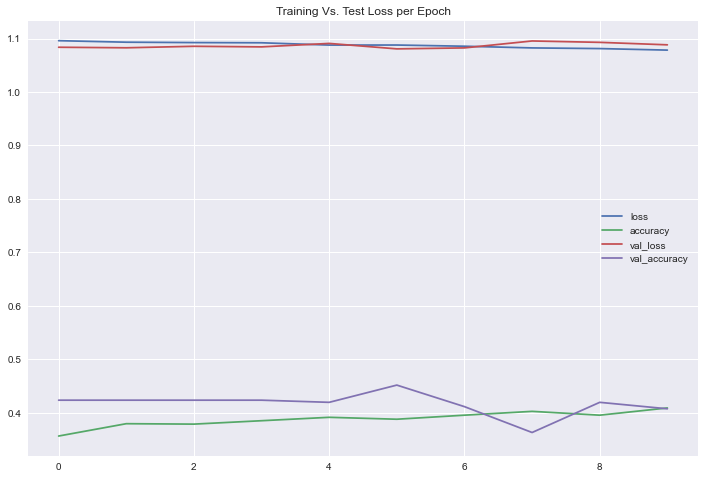

In [49]:
# evaluation
losses = pd.DataFrame(lstm_model.history.history)
losses.plot(figsize=(12,8))
plt.title("Training Vs. Test Loss per Epoch")
plt.show()

Classification Report

In [50]:
TLT_y_trade_seq_pred = lstm_model.predict(TLT_X_trade_seq)
TLT_y_trade_seq_pred = TLT_y_trade_seq_pred.argmax(axis=1)

TLT_y_trade = TLT_encoder.inverse_transform(TLT_y_trade_seq)
TLT_y_trade_seq_pred = TLT_encoder.inverse_transform(TLT_y_trade_seq_pred)

print(classification_report(TLT_y_trade, TLT_y_trade_seq_pred))

              precision    recall  f1-score   support

          -1       0.33      1.00      0.50        80
           0       0.33      0.01      0.02        78
           1       0.00      0.00      0.00        90

    accuracy                           0.33       248
   macro avg       0.22      0.34      0.17       248
weighted avg       0.21      0.33      0.17       248



Prediction Trading Report

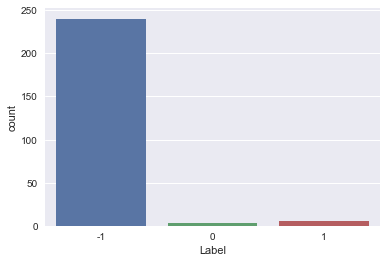

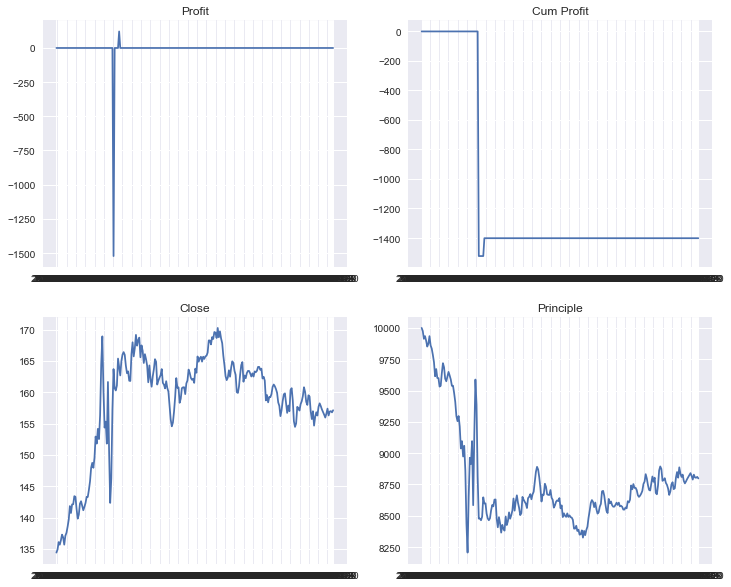

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  | -1201.4 | -12.01%  |   -12.20%    |   248    | -0.63  |
| Buy & Hold | 1180.79 |  11.81%  |    12.01%    |   248    |  0.84  |
+------------+---------+----------+--------------+----------+--------+


In [51]:
TLT_y_trade_pred_lstm_clas = TLT[-len(TLT_y_trade_seq_pred):]
TLT_y_trade_pred_lstm_clas['Label'] = TLT_y_trade_seq_pred
TLT_y_trade_pred_lstm_clas.to_csv('data/processed/TLT_y_trade_pred_lstm_clas.csv')
TLT_y_trade_pred_lstm_clas = pd.read_csv('data/processed/TLT_y_trade_pred_lstm_clas.csv', index_col='Date')

TLT_trading_log_trade_lstm_clas = get_trading_log(TLT_y_trade_pred_lstm_clas, principle=principle, percent=percent)
TLT_trading_log_trade_lstm_clas.to_csv('reports/TLT_trading_log_trade_lstm_clas.csv')
TLT_trading_log_trade_lstm_clas = pd.read_csv('reports/TLT_trading_log_trade_lstm_clas.csv', index_col='Date')
TLT_report_trade_lstm, _ = get_trading_report(TLT_trading_log_trade_lstm_clas, show_fig=True)
print(TLT_report_trade_lstm)

### USO

#### Data Transformation

In [72]:
USO_X_train_transformed, USO_y_train_transformed, USO_X_test_transformed, USO_y_test_transformed, USO_X_trade_transformed, USO_y_trade_transformed, USO_encoder = data_transform(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test, USO_X_trade_final, USO_y_trade, 'clas')

In [73]:
USO_X_train_seq, USO_y_train_seq = split_sequences(USO_X_train_transformed, USO_y_train_transformed, WINDOW_USO)
USO_X_test_seq, USO_y_test_seq = split_sequences(USO_X_test_transformed, USO_y_test_transformed, WINDOW_USO)
USO_X_trade_seq, USO_y_trade_seq = split_sequences(USO_X_trade_transformed, USO_y_trade_transformed, WINDOW_USO)

(2512, 5, 30) (2512,)
(248, 5, 30) (248,)
(248, 5, 30) (248,)


In [74]:
n_features = USO_X_train_seq.shape[2]
n_steps = USO_X_train_seq.shape[1]
n_classes = 3
print('Number of Features:', n_features)
print('Number of Steps:', n_steps)
print('Number of Classes:', n_classes)

Number of Features: 30
Number of Steps: 5
Number of Classes: 3


#### CNN

Model

In [188]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=20, kernel_size=2,activation='relu',input_shape=(n_steps, n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(5, activation='relu'))
cnn_model.add(Dense(n_classes, activation='softmax'))
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=4)
cnn_model.fit(USO_X_train_seq,USO_y_train_seq, epochs=500, validation_data=(USO_X_test_seq,USO_y_test_seq), 
          verbose=1, callbacks=[early_stop])

Epoch 1/500
79/79 [==============================] - 0s 2ms/step - loss: 1.1029 - accuracy: 0.3531 - val_loss: 1.1286 - val_accuracy: 0.2984
Epoch 2/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0960 - accuracy: 0.3670 - val_loss: 1.1098 - val_accuracy: 0.3105
Epoch 3/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0947 - accuracy: 0.3623 - val_loss: 1.1052 - val_accuracy: 0.3548
Epoch 4/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0928 - accuracy: 0.3591 - val_loss: 1.1104 - val_accuracy: 0.3710
Epoch 5/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0925 - accuracy: 0.3603 - val_loss: 1.1070 - val_accuracy: 0.3911
Epoch 6/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0904 - accuracy: 0.3750 - val_loss: 1.1050 - val_accuracy: 0.3911
Epoch 7/500
79/79 [==============================] - 0s 1ms/step - loss: 1.0889 - accuracy: 0.3754 - val_loss: 1.0995 - val_accuracy: 0.3750
Epoch 8/500
7

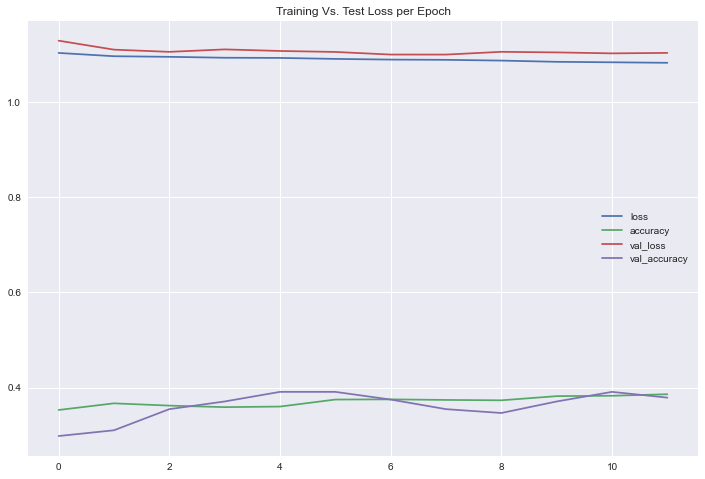

In [189]:
# evaluation
losses = pd.DataFrame(cnn_model.history.history)
losses.plot(figsize=(12,8))
plt.title("Training Vs. Test Loss per Epoch")
plt.show()

Classification Report

In [190]:
USO_y_trade_seq_pred = cnn_model.predict(USO_X_trade_seq)
USO_y_trade_seq_pred = USO_y_trade_seq_pred.argmax(axis=1)

USO_y_trade = USO_encoder.inverse_transform(USO_y_trade_seq)
USO_y_trade_seq_pred = USO_encoder.inverse_transform(USO_y_trade_seq_pred)

print(classification_report(USO_y_trade, USO_y_trade_seq_pred))

              precision    recall  f1-score   support

          -1       0.27      0.43      0.33        79
           0       0.33      0.05      0.08        83
           1       0.32      0.41      0.36        86

    accuracy                           0.29       248
   macro avg       0.31      0.30      0.26       248
weighted avg       0.31      0.29      0.26       248



Prediction Trading Report

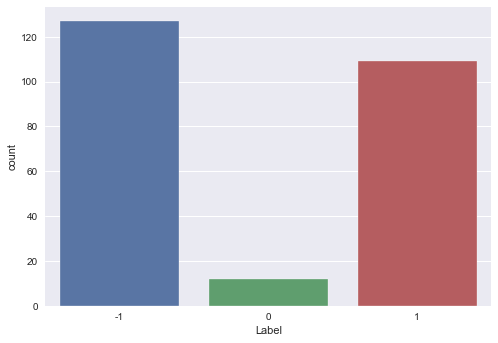

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

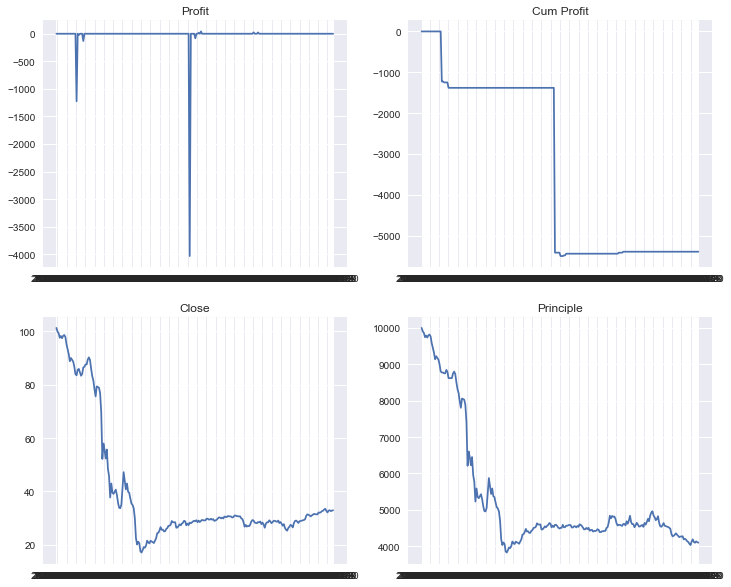

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | -5907.16 | -59.07%  |   -59.81%    |   247    | -2.25  |
| Buy & Hold | -4717.53 | -47.18%  |   -47.72%    |   248    | -1.24  |
+------------+----------+----------+--------------+----------+--------+


In [191]:
USO_y_trade_pred_cnn_clas = USO[-len(USO_y_trade_seq_pred):]
USO_y_trade_pred_cnn_clas['Label'] = USO_y_trade_seq_pred
USO_y_trade_pred_cnn_clas.to_csv('data/processed/USO_y_trade_pred_cnn_clas.csv')
USO_y_trade_pred_cnn_clas = pd.read_csv('data/processed/USO_y_trade_pred_cnn_clas.csv', index_col='Date')

USO_trading_log_trade_cnn_clas = get_trading_log(USO_y_trade_pred_cnn_clas, principle=principle, percent=percent)
USO_trading_log_trade_cnn_clas.to_csv('reports/USO_trading_log_trade_cnn_clas.csv')
USO_trading_log_trade_cnn_clas = pd.read_csv('reports/USO_trading_log_trade_cnn_clas.csv', index_col='Date')
USO_report_trade_cnn, _ = get_trading_report(USO_trading_log_trade_cnn_clas, show_fig=True)
print(USO_report_trade_cnn)

#### LSTM

Model

In [75]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
lstm_model.add(LSTM(50, activation='relu', return_sequences=False))
lstm_model.add(Dense(10))
lstm_model.add(Dense(n_classes, activation='softmax'))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=4)
lstm_model.fit(USO_X_train_seq,USO_y_train_seq, epochs=500, validation_data=(USO_X_test_seq,USO_y_test_seq), 
          verbose=1, callbacks=[early_stop])

Epoch 1/500
79/79 [==============================] - 1s 10ms/step - loss: 1.0955 - accuracy: 0.3551 - val_loss: 1.0970 - val_accuracy: 0.3911
Epoch 2/500
79/79 [==============================] - 1s 6ms/step - loss: 1.0952 - accuracy: 0.3563 - val_loss: 1.0975 - val_accuracy: 0.3911
Epoch 3/500
79/79 [==============================] - 1s 6ms/step - loss: 1.0924 - accuracy: 0.3658 - val_loss: 1.0982 - val_accuracy: 0.3992
Epoch 4/500
79/79 [==============================] - 0s 5ms/step - loss: 1.0913 - accuracy: 0.3734 - val_loss: 1.0970 - val_accuracy: 0.3911
Epoch 5/500
79/79 [==============================] - 0s 6ms/step - loss: 1.0901 - accuracy: 0.3718 - val_loss: 1.0983 - val_accuracy: 0.4234
Epoch 6/500
79/79 [==============================] - 1s 6ms/step - loss: 1.0888 - accuracy: 0.3822 - val_loss: 1.0981 - val_accuracy: 0.3911
Epoch 7/500
79/79 [==============================] - 0s 6ms/step - loss: 1.0863 - accuracy: 0.3846 - val_loss: 1.0952 - val_accuracy: 0.3911
Epoch 8/500


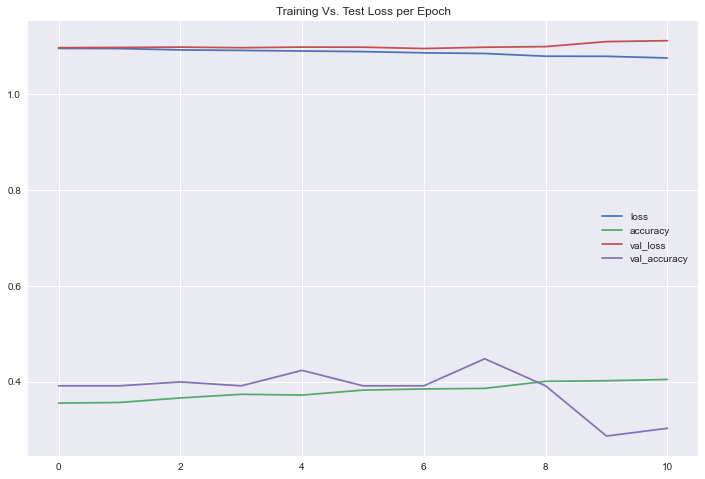

In [76]:
# evaluation
losses = pd.DataFrame(lstm_model.history.history)
losses.plot(figsize=(12,8))
plt.title("Training Vs. Test Loss per Epoch")
plt.show()

Classification Report

In [77]:
USO_y_trade_seq_pred = lstm_model.predict(USO_X_trade_seq)
USO_y_trade_seq_pred = USO_y_trade_seq_pred.argmax(axis=1)

USO_y_trade = USO_encoder.inverse_transform(USO_y_trade_seq)
USO_y_trade_seq_pred = USO_encoder.inverse_transform(USO_y_trade_seq_pred)

print(classification_report(USO_y_trade, USO_y_trade_seq_pred))

              precision    recall  f1-score   support

          -1       0.30      0.84      0.45        79
           0       0.25      0.01      0.02        83
           1       0.26      0.08      0.12        86

    accuracy                           0.30       248
   macro avg       0.27      0.31      0.20       248
weighted avg       0.27      0.30      0.19       248



Prediction Trading Report

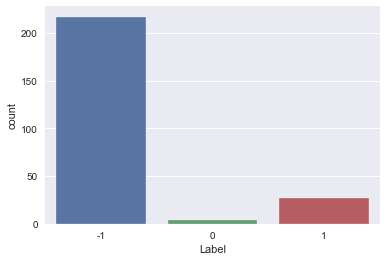

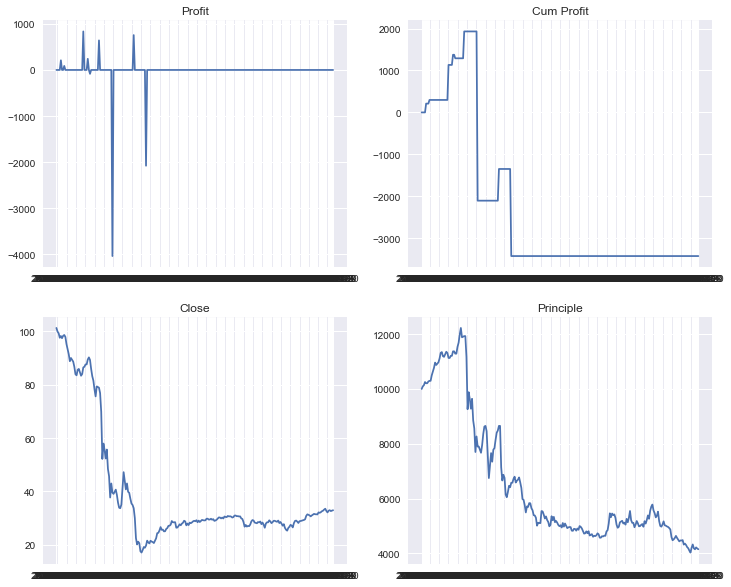

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | -5852.93 | -58.53%  |   -59.11%    |   248    | -1.43  |
| Buy & Hold | -4717.53 | -47.18%  |   -47.72%    |   248    | -1.24  |
+------------+----------+----------+--------------+----------+--------+


In [78]:
USO_y_trade_pred_lstm_clas = USO[-len(USO_y_trade_seq_pred):]
USO_y_trade_pred_lstm_clas['Label'] = USO_y_trade_seq_pred
USO_y_trade_pred_lstm_clas.to_csv('data/processed/USO_y_trade_pred_lstm_clas.csv')
USO_y_trade_pred_lstm_clas = pd.read_csv('data/processed/USO_y_trade_pred_lstm_clas.csv', index_col='Date')

USO_trading_log_trade_lstm_clas = get_trading_log(USO_y_trade_pred_lstm_clas, principle=principle, percent=percent)
USO_trading_log_trade_lstm_clas.to_csv('reports/USO_trading_log_trade_lstm_clas.csv')
USO_trading_log_trade_lstm_clas = pd.read_csv('reports/USO_trading_log_trade_lstm_clas.csv', index_col='Date')
USO_report_trade_lstm, _ = get_trading_report(USO_trading_log_trade_lstm_clas, show_fig=True)
print(USO_report_trade_lstm)

## Train/Test Split (Regression)

In [52]:
df = SPY_eco_tec.shift(WINDOW_SPY)
SPY_X_train, SPY_y_train, SPY_X_test, SPY_y_test, SPY_X_trade, SPY_y_trade, SPY_trade_start_actual= reg_train_test_trade_split(df, SPY, train_start, train_end, test_start, test_end, trade_start, trade_end, WINDOW_SPY)

In [53]:
df = TLT_eco_tec.shift(WINDOW_TLT)
TLT_X_train, TLT_y_train, TLT_X_test, TLT_y_test, TLT_X_trade, TLT_y_trade, TLT_trade_start_actual= reg_train_test_trade_split(df, TLT, train_start, train_end, test_start, test_end, trade_start, trade_end, WINDOW_TLT)

In [54]:
df = USO_eco_tec.shift(WINDOW_USO)
USO_X_train, USO_y_train, USO_X_test, USO_y_test, USO_X_trade, USO_y_trade, USO_trade_start_actual= reg_train_test_trade_split(df, USO, train_start, train_end, test_start, test_end, trade_start, trade_end, WINDOW_USO)

## Data Type Separation & Transform (Regression)

For feature selection

In [342]:
SPY_preprocessor = data_preprocessor(SPY_X_train)
SPY_preprocessor.fit(SPY_X_train)
SPY_X_train_transformed = pd.DataFrame(SPY_preprocessor.transform(SPY_X_train), columns=SPY_X_train.columns, index=SPY_X_train.index)
SPY_X_train_transformed.head()

Open  High  Low  Volume  GDP  PAYEMS  DTB1YR  DTB6  DTB3  DGS3MO  \
Date                                                                           
2009-01-02  0.06  0.06 0.07    0.05 0.05    0.33    0.12  0.10  0.01    0.00   
2009-01-05  0.07  0.06 0.07    0.07 0.05    0.33    0.13  0.10  0.02    0.01   
2009-01-06  0.07  0.06 0.06    0.14 0.05    0.33    0.13  0.10  0.02    0.01   
2009-01-07  0.07  0.07 0.07    0.20 0.05    0.33    0.11  0.08  0.02    0.01   
2009-01-08  0.07  0.07 0.08    0.24 0.05    0.33    0.10  0.09  0.03    0.02   

            ...  cci_60  cci_120  dx_5  dx_10  dx_20  dx_60  dx_120  vr_20  \
Date        ...                                                              
2009-01-02  ...    0.66     0.60  0.66   0.40   0.29   0.44    0.61   0.13   
2009-01-05  ...    0.66     0.60  0.25   0.27   0.25   0.42    0.60   0.12   
2009-01-06  ...    0.66     0.60  0.58   0.41   0.31   0.44    0.61   0.11   
2009-01-07  ...    0.69     0.61  0.30   0.03   0.12   0.38    0.57   0.14   
2009-01-08  ...    0.73     0.62  0.64   0.32   0.06   0.31    0.52   0.12   

            vr_60  vr_120  
Date                       
2009-01-02   0.10    0.22  
2009-01-05   0.09    0.21  
2009-01-06   0.10    0.22  
2009-01-07   0.11    0.21  
2009-01-08   0.14    0.23  

[5 rows x 83 columns]

In [343]:
TLT_preprocessor = data_preprocessor(TLT_X_train)
TLT_preprocessor.fit(TLT_X_train)
TLT_X_train_transformed = pd.DataFrame(TLT_preprocessor.transform(TLT_X_train), columns=TLT_X_train.columns, index=TLT_X_train.index)
TLT_X_train_transformed.head()

Open  High  Low  Volume  GDP  PAYEMS  DTB1YR  DTB6  DTB3  DGS3MO  \
Date                                                                           
2009-01-02  0.34  0.33 0.34    0.01 0.05    0.33    0.12  0.10  0.01    0.00   
2009-01-05  0.35  0.34 0.35    0.00 0.05    0.33    0.13  0.10  0.02    0.01   
2009-01-06  0.35  0.34 0.35    0.02 0.05    0.33    0.13  0.10  0.02    0.01   
2009-01-07  0.34  0.34 0.34    0.05 0.05    0.33    0.11  0.08  0.02    0.01   
2009-01-08  0.35  0.34 0.33    0.05 0.05    0.33    0.10  0.09  0.03    0.02   

            ...  cci_60  cci_120  dx_5  dx_10  dx_20  dx_60  dx_120  vr_20  \
Date        ...                                                              
2009-01-02  ...    0.57     0.85  0.24   0.58   0.78   0.97    0.96   0.64   
2009-01-05  ...    0.57     0.83  0.48   0.64   0.80   0.99    0.97   0.61   
2009-01-06  ...    0.56     0.81  0.61   0.68   0.82   1.00    0.98   0.54   
2009-01-07  ...    0.55     0.80  0.11   0.46   0.71   0.95    0.95   0.51   
2009-01-08  ...    0.53     0.76  0.46   0.08   0.49   0.84    0.88   0.39   

            vr_60  vr_120  
Date                       
2009-01-02   0.62    0.34  
2009-01-05   0.60    0.33  
2009-01-06   0.57    0.31  
2009-01-07   0.58    0.34  
2009-01-08   0.50    0.36  

[5 rows x 83 columns]

In [344]:
USO_preprocessor = data_preprocessor(USO_X_train)
USO_preprocessor.fit(USO_X_train)
USO_X_train_transformed = pd.DataFrame(USO_preprocessor.transform(USO_X_train), columns=USO_X_train.columns, index=USO_X_train.index)
USO_X_train_transformed.head()

Open  High  Low  Volume  GDP  PAYEMS  DTB1YR  DTB6  DTB3  DGS3MO  \
Date                                                                           
2009-01-02  0.57  0.57 0.56    0.12 0.05    0.33    0.12  0.10  0.01    0.00   
2009-01-05  0.54  0.56 0.54    0.18 0.05    0.33    0.13  0.10  0.02    0.01   
2009-01-06  0.61  0.61 0.57    0.21 0.05    0.33    0.13  0.10  0.02    0.01   
2009-01-07  0.59  0.60 0.58    0.19 0.05    0.33    0.11  0.08  0.02    0.01   
2009-01-08  0.57  0.71 0.58    0.44 0.05    0.33    0.10  0.09  0.03    0.02   

            ...  cci_60  cci_120  dx_5  dx_10  dx_20  dx_60  dx_120  vr_20  \
Date        ...                                                              
2009-01-02  ...    0.42     0.31  0.87   0.63   0.48   0.53    0.59   0.04   
2009-01-05  ...    0.42     0.31  0.91   0.69   0.52   0.55    0.60   0.04   
2009-01-06  ...    0.43     0.33  0.01   0.25   0.31   0.47    0.55   0.06   
2009-01-07  ...    0.44     0.33  0.01   0.25   0.31   0.47    0.55   0.05   
2009-01-08  ...    0.46     0.34  0.73   0.38   0.09   0.29    0.44   0.08   

            vr_60  vr_120  
Date                       
2009-01-02   0.06    0.03  
2009-01-05   0.09    0.06  
2009-01-06   0.12    0.08  
2009-01-07   0.11    0.06  
2009-01-08   0.17    0.09  

[5 rows x 83 columns]

## Feature Selection (Regression)

### Handling Multicollinear Features

#### Hierarchical Clustering

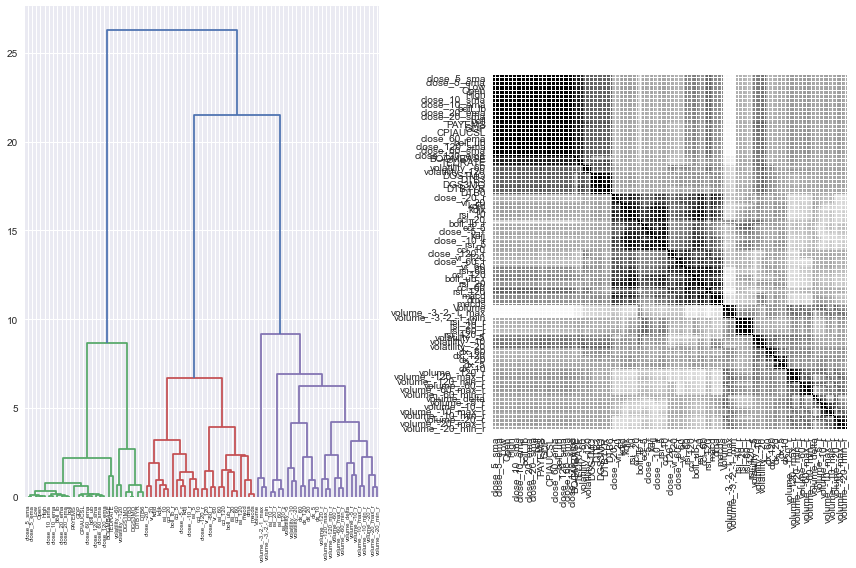

Number of Features: 40
Selected Features: Index(['Open', 'Volume', 'DTB1YR', 'BOGMBASE', 'TEDRATE', 'volatility_-5',
       'volatility_-10', 'volatility_-60', 'close_-5_r', 'close_-10_r',
       'close_-20_r', 'close_-60_r', 'close_-120_r', 'volume_-5_r',
       'volume_-10_r', 'volume_-20_r', 'volume_-60_r', 'volume_-120_r',
       'volume_delta', 'volume_-3,-2,-1_max', 'volume_-10_max_r',
       'volume_-20_max_r', 'volume_-60_max_r', 'volume_-120_max_r', 'kdjk',
       'kdjd', 'dma', 'macd', 'boll_ub_r', 'boll_lb_r', 'rsi_5', 'rsi_20',
       'rsi_60', 'rsi_120', 'rsi_10_r', 'rsi_60_r', 'cci_5', 'dx_5', 'dx_20',
       'dx_60'],
      dtype='object')


In [346]:
SPY_selected_cols1 = fs_hierarchical_clustering(SPY_X_train_transformed)
SPY_X_train_fs1 = SPY_X_train_transformed.loc[:,SPY_selected_cols1]

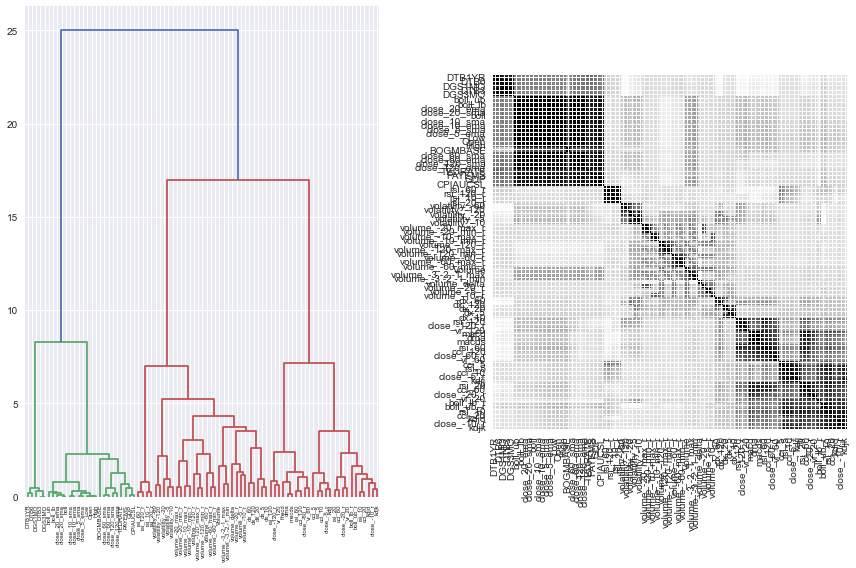

Number of Features: 36
Selected Features: Index(['Open', 'Volume', 'GDP', 'DTB1YR', 'BOGMBASE', 'volatility_-5',
       'volatility_-20', 'volatility_-60', 'close_-5_r', 'close_-10_r',
       'close_-20_r', 'close_-60_r', 'close_-120_r', 'volume_-5_r',
       'volume_-10_r', 'volume_-20_r', 'volume_-60_r', 'volume_-120_r',
       'volume_delta', 'volume_-3,-2,-1_max', 'volume_-10_max_r',
       'volume_-20_max_r', 'volume_-60_max_r', 'volume_-120_max_r',
       'close_60_sma', 'dma', 'boll_ub_r', 'boll_lb_r', 'rsi_10', 'rsi_20',
       'rsi_60', 'rsi_10_r', 'cci_5', 'dx_5', 'dx_20', 'dx_60'],
      dtype='object')


In [347]:
TLT_selected_cols1 = fs_hierarchical_clustering(TLT_X_train_transformed)
TLT_X_train_fs1 = TLT_X_train_transformed.loc[:,TLT_selected_cols1]

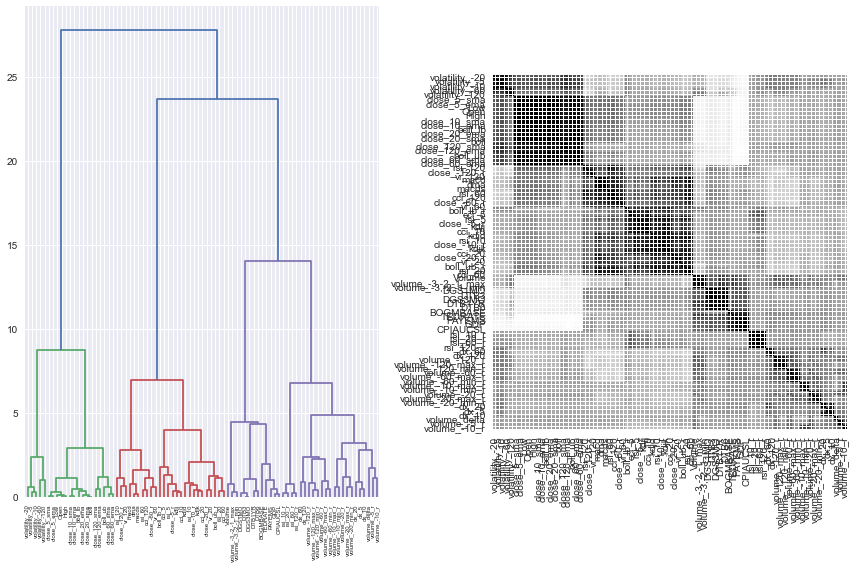

Number of Features: 38
Selected Features: Index(['Open', 'Volume', 'GDP', 'DTB1YR', 'DTB3', 'BOGMBASE', 'TEDRATE',
       'volatility_-5', 'volatility_-60', 'volatility_-120', 'close_-5_r',
       'close_-10_r', 'close_-20_r', 'close_-60_r', 'close_-120_r',
       'volume_-5_r', 'volume_-10_r', 'volume_-20_r', 'volume_-60_r',
       'volume_-120_r', 'volume_delta', 'volume_-10_max_r', 'volume_-20_max_r',
       'volume_-60_max_r', 'close_10_sma', 'close_60_sma', 'close_120_sma',
       'dma', 'boll_ub_r', 'boll_lb_r', 'rsi_20', 'rsi_60', 'rsi_120',
       'rsi_10_r', 'cci_5', 'dx_5', 'dx_60', 'dx_120'],
      dtype='object')


In [348]:
USO_selected_cols1 = fs_hierarchical_clustering(USO_X_train_transformed)
USO_X_train_fs1 = USO_X_train_transformed.loc[:,USO_selected_cols1]

### Select Important Features

In [206]:
SPY_selected_cols = reg_fs_importance(SPY_X_train_fs1, SPY_y_train, 30)

Number of Features: 30
Selected Features: Index(['Open', 'Volume', 'DTB1YR', 'BOGMBASE', 'TEDRATE', 'volatility_-5',
       'volatility_-10', 'volatility_-60', 'close_-10_r', 'close_-20_r',
       'close_-60_r', 'close_-120_r', 'volume_-5_r', 'volume_-10_r',
       'volume_-20_r', 'volume_-60_r', 'volume_-120_r', 'volume_-3,-2,-1_max',
       'volume_-10_max_r', 'volume_-20_max_r', 'volume_-60_max_r',
       'volume_-120_max_r', 'kdjk', 'dma', 'boll_ub_r', 'boll_lb_r', 'rsi_5',
       'rsi_20', 'rsi_60', 'rsi_120'],
      dtype='object')


In [55]:
SPY_selected_cols = ['Open', 'Volume', 'DTB1YR', 'BOGMBASE', 'TEDRATE', 'volatility_-5',
       'volatility_-10', 'volatility_-60', 'close_-10_r', 'close_-20_r',
       'close_-60_r', 'close_-120_r', 'volume_-5_r', 'volume_-10_r',
       'volume_-20_r', 'volume_-60_r', 'volume_-120_r', 'volume_-3,-2,-1_max',
       'volume_-10_max_r', 'volume_-20_max_r', 'volume_-60_max_r',
       'volume_-120_max_r', 'kdjk', 'dma', 'boll_ub_r', 'boll_lb_r', 'rsi_5',
       'rsi_20', 'rsi_60', 'rsi_120']

In [225]:
TLT_selected_cols = reg_fs_importance(TLT_X_train_fs1, TLT_y_train, 30)

Number of Features: 30
Selected Features: Index(['Open', 'Volume', 'GDP', 'DTB1YR', 'BOGMBASE', 'volatility_-5',
       'volatility_-60', 'close_-5_r', 'close_-10_r', 'close_-20_r',
       'close_-60_r', 'close_-120_r', 'volume_-10_r', 'volume_-20_r',
       'volume_-60_r', 'volume_-120_r', 'volume_-3,-2,-1_max',
       'volume_-10_max_r', 'volume_-20_max_r', 'volume_-60_max_r',
       'volume_-120_max_r', 'close_60_sma', 'dma', 'boll_ub_r', 'boll_lb_r',
       'rsi_20', 'rsi_60', 'cci_5', 'dx_5', 'dx_60'],
      dtype='object')


In [56]:
TLT_selected_cols = ['Open', 'Volume', 'GDP', 'DTB1YR', 'BOGMBASE', 'volatility_-5',
       'volatility_-60', 'close_-5_r', 'close_-10_r', 'close_-20_r',
       'close_-60_r', 'close_-120_r', 'volume_-10_r', 'volume_-20_r',
       'volume_-60_r', 'volume_-120_r', 'volume_-3,-2,-1_max',
       'volume_-10_max_r', 'volume_-20_max_r', 'volume_-60_max_r',
       'volume_-120_max_r', 'close_60_sma', 'dma', 'boll_ub_r', 'boll_lb_r',
       'rsi_20', 'rsi_60', 'cci_5', 'dx_5', 'dx_60']

In [227]:
USO_selected_cols = reg_fs_importance(USO_X_train_fs1, USO_y_train, 30)

Number of Features: 30
Selected Features: Index(['Open', 'Volume', 'GDP', 'DTB1YR', 'DTB3', 'BOGMBASE', 'TEDRATE',
       'volatility_-5', 'volatility_-60', 'volatility_-120', 'close_-5_r',
       'close_-10_r', 'close_-20_r', 'close_-60_r', 'close_-120_r',
       'volume_-5_r', 'volume_-60_r', 'volume_-120_r', 'volume_-10_max_r',
       'close_20_sma', 'close_60_sma', 'dma', 'boll_ub_r', 'boll_lb_r',
       'rsi_20', 'rsi_60', 'rsi_120', 'cci_5', 'dx_5', 'dx_60'],
      dtype='object')


In [57]:
USO_selected_cols = ['Open', 'Volume', 'GDP', 'DTB1YR', 'DTB3', 'BOGMBASE', 'TEDRATE',
       'volatility_-5', 'volatility_-60', 'volatility_-120', 'close_-5_r',
       'close_-10_r', 'close_-20_r', 'close_-60_r', 'close_-120_r',
       'volume_-5_r', 'volume_-60_r', 'volume_-120_r', 'volume_-10_max_r',
       'close_20_sma', 'close_60_sma', 'dma', 'boll_ub_r', 'boll_lb_r',
       'rsi_20', 'rsi_60', 'rsi_120', 'cci_5', 'dx_5', 'dx_60']

In [229]:
common_features = set(SPY_selected_cols) & set(TLT_selected_cols) & set(USO_selected_cols)
print(common_features)

{'volatility_-60', 'boll_lb_r', 'close_-10_r', 'close_-120_r', 'rsi_60', 'volume_-60_r', 'volume_-10_max_r', 'close_-20_r', 'Volume', 'rsi_20', 'boll_ub_r', 'volatility_-5', 'dma', 'Open', 'close_-60_r', 'volume_-120_r', 'BOGMBASE', 'DTB1YR'}


In [230]:
SPY_uni_features = set(SPY_selected_cols) - common_features
print(SPY_uni_features)

{'volatility_-10', 'volume_-20_max_r', 'volume_-20_r', 'volume_-5_r', 'volume_-3,-2,-1_max', 'rsi_120', 'rsi_5', 'volume_-10_r', 'volume_-120_max_r', 'volume_-60_max_r', 'TEDRATE', 'kdjk'}


In [231]:
TLT_uni_features = set(TLT_selected_cols) - common_features
print(TLT_uni_features)

{'close_60_sma', 'volume_-20_max_r', 'close_-5_r', 'volume_-20_r', 'volume_-3,-2,-1_max', 'GDP', 'volume_-10_r', 'cci_5', 'dx_5', 'dx_60', 'volume_-120_max_r', 'volume_-60_max_r'}


In [232]:
USO_uni_features = set(USO_selected_cols) - common_features
print(USO_uni_features)

{'close_60_sma', 'DTB3', 'close_-5_r', 'rsi_120', 'volume_-5_r', 'GDP', 'cci_5', 'volatility_-120', 'dx_5', 'dx_60', 'close_20_sma', 'TEDRATE'}


### Final Features

In [58]:
SPY_X_train_final, SPY_X_test_final, SPY_X_trade_final = fs_final(SPY_X_train, SPY_X_test, SPY_X_trade, SPY_selected_cols)

In [59]:
TLT_X_train_final, TLT_X_test_final, TLT_X_trade_final = fs_final(TLT_X_train, TLT_X_test, TLT_X_trade, TLT_selected_cols)

In [60]:
USO_X_train_final, USO_X_test_final, USO_X_trade_final = fs_final(USO_X_train, USO_X_test, USO_X_trade, USO_selected_cols)

## Regression - Classical Learning

### SPY

#### Model Selection

In [236]:
SPY_chosen = reg_model_selection(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test)

        Test Error  Train Error
Model                          
Linear       27.44        10.31
Ridge       155.36        12.46
DTR         324.22         0.00
KNNR        354.79         9.88
GBR        1114.52         4.47
XGBR       1463.33         0.12


In [237]:
SPY_chosen

Index(['Linear', 'Ridge', 'DTR', 'KNNR', 'GBR'], dtype='object', name='Model')

In [88]:
SPY_chosen = ['Linear', 'Ridge', 'KNNR', 'DTR', 'GBR', 'XGBR']

#### Randomized Search

In [89]:
reg_rs(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test, SPY_chosen)

============= Linear Randomized Search =============
Best Parameters: {'regressor__normalize': True, 'regressor__fit_intercept': True}
============= Ridge Randomized Search =============
Best Parameters: {'regressor__alpha': 1.8806784396643043e-05, 'regressor__fit_intercept': True, 'regressor__normalize': False, 'regressor__solver': 'lsqr'}
============= KNNR Randomized Search =============
Best Parameters: {'regressor__weights': 'uniform', 'regressor__p': 2, 'regressor__n_neighbors': 3, 'regressor__n_jobs': -1, 'regressor__metric': 'euclidean', 'regressor__leaf_size': 35}
============= DTR Randomized Search =============
Best Parameters: {'regressor__splitter': 'best', 'regressor__min_samples_split': 0.01, 'regressor__min_samples_leaf': 0.005, 'regressor__max_features': 'auto', 'regressor__max_depth': 8, 'regressor__criterion': 'mse'}
============= GBR Randomized Search =============
Best Parameters: {'regressor__subsample': 0.5, 'regressor__n_estimators': 1500, 'regressor__max_depth'

#### Grid Search

In [61]:
# SPY_chosen2 = 'Linear'
# SPY_Linear = reg_gs(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test, SPY_chosen2)
# joblib.dump(SPY_Linear, 'models/SPY_Linear.pkl')

SPY_Linear = joblib.load("models/SPY_Linear.pkl")

#### Model Evaluation

Mean Squared Error

In [62]:
SPY_model = SPY_Linear
SPY_y_trade_pred, SPY_perm = reg_evaluation(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test, SPY_X_trade_final, SPY_y_trade, SPY_model)

============= Trade Data =============
Mean Squared Error: 145.85566941646533


Prediction Plot

In [68]:
SPY_y_trade_pred_reg = SPY[(SPY.index >= SPY_trade_start_actual) & (SPY.index <= trade_end)]
SPY_y_trade_pred_reg['Close_pred'] = SPY_y_trade_pred
SPY_y_trade_pred_reg.to_csv('data/processed/SPY_y_trade_pred_reg.csv')
SPY_y_trade_pred_reg = pd.read_csv('data/processed/SPY_y_trade_pred_reg.csv', index_col='Date')

SPY_y_trade_pred_reg.head()

Open   High    Low  Close     Volume  Close_pred
Date                                                         
2019-12-17 311.50 311.82 311.07 311.16   61097700      305.59
2019-12-18 311.58 311.82 311.12 311.18   48133000      305.88
2019-12-19 311.38 312.53 311.11 312.45   85310500      306.78
2019-12-20 313.56 315.04 312.51 313.82  147142100      309.56
2019-12-23 314.66 314.72 314.15 314.30   52990000      312.09

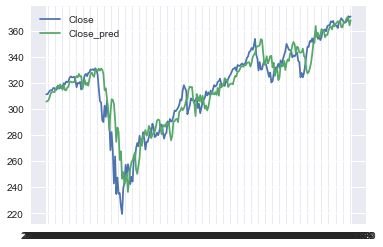

In [69]:
plt.plot(SPY_y_trade_pred_reg['Close'], label='Close')
plt.plot(SPY_y_trade_pred_reg['Close_pred'], label='Close_pred')
plt.legend();

Feature Importance

In [63]:
eli5.show_weights(SPY_perm, feature_names = SPY_X_trade_final.columns.tolist())

Prediction Trading Report

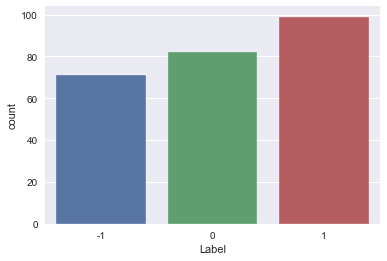

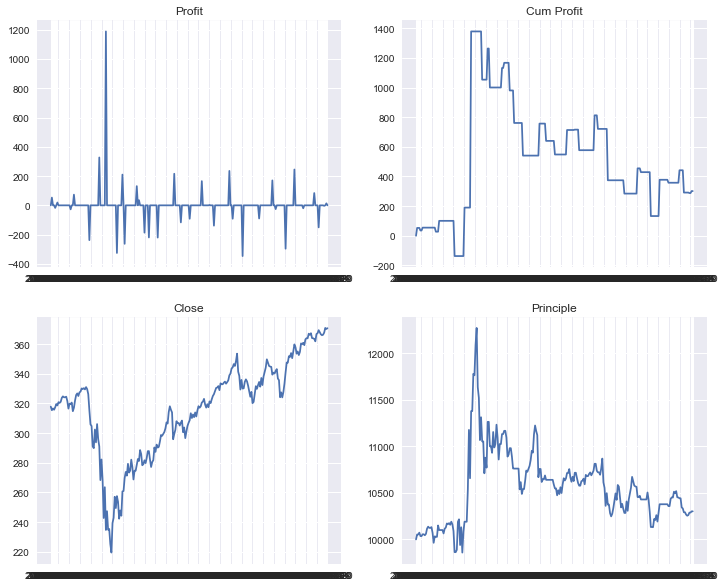

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  |  301.41 |  3.01%   |    3.31%     |   230    |  0.25  |
| Buy & Hold | 1163.85 |  11.64%  |    11.64%    |   252    |  0.63  |
+------------+---------+----------+--------------+----------+--------+


In [95]:
# use Close_pred for meta-labeling
SPY_y_trade_pred_reg.drop(['Close'], axis=1,inplace=True)
SPY_y_trade_pred_reg.rename(columns={'Close_pred':'Close'}, inplace=True)
SPY_y_trade_pred_reg_labeling, _ = meta_labeling(SPY_y_trade_pred_reg, WINDOW=WINDOW_SPY, HORIZON=HORIZON_SPY, TP=TP_SPY, SL=SL_SPY * -1)
# reformat Close and Close_pred
SPY_y_trade_pred_reg_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
SPY_y_trade_pred_reg_labeling['Close'] = SPY_y_trade[-len(SPY_y_trade_pred_reg_labeling):].values

SPY_trading_log_trade_reg = get_trading_log(SPY_y_trade_pred_reg_labeling[WINDOW_SPY:], principle=principle, percent=percent)
SPY_trading_log_trade_reg.to_csv('reports/SPY_trading_log_trade_reg.csv')
SPY_trading_log_trade_reg = pd.read_csv('reports/SPY_trading_log_trade_reg.csv', index_col='Date')
SPY_report_trade_reg, _ = get_trading_report(SPY_trading_log_trade_reg, show_fig=True)
print(SPY_report_trade_reg)

### TLT

#### Model Selection

In [244]:
TLT_chosen = reg_model_selection(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test)

        Test Error  Train Error
Model                          
Linear        5.56         3.14
Ridge         5.61         3.16
DTR          69.80         0.00
GBR          79.57         1.66
XGBR        101.67         0.04
KNNR        146.31         1.72


In [245]:
TLT_chosen

Index(['Linear', 'Ridge', 'DTR', 'GBR', 'XGBR'], dtype='object', name='Model')

In [396]:
TLT_chosen = ['Ridge', 'Linear', 'DTR', 'GBR', 'XGBR']

#### Randomized Search

In [397]:
reg_rs(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test, TLT_chosen)

============= Ridge Randomized Search =============
Best Parameters: {'regressor__alpha': 1.1933833072239501, 'regressor__fit_intercept': True, 'regressor__normalize': False, 'regressor__solver': 'cholesky'}
============= Linear Randomized Search =============
Best Parameters: {'regressor__normalize': True, 'regressor__fit_intercept': True}
============= DTR Randomized Search =============
Best Parameters: {'regressor__splitter': 'best', 'regressor__min_samples_split': 0.01, 'regressor__min_samples_leaf': 0.005, 'regressor__max_features': 'auto', 'regressor__max_depth': 8, 'regressor__criterion': 'mse'}
============= GBR Randomized Search =============
Best Parameters: {'regressor__subsample': 0.1, 'regressor__n_estimators': 500, 'regressor__max_depth': 10, 'regressor__learning_rate': 0.01}
============= XGBR Randomized Search =============
Best Parameters: {'regressor__subsample': 1.0, 'regressor__min_child_weight': 5, 'regressor__max_depth': 2, 'regressor__gamma': 0.4, 'regressor__co

#### Grid Search

In [64]:
# TLT_chosen2 = 'Ridge'
# TLT_Ridge = reg_gs(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test, TLT_chosen2)
# joblib.dump(TLT_Ridge, 'models/TLT_Ridge.pkl')

TLT_Ridge = joblib.load("models/TLT_Ridge.pkl")

#### Model Evaluation

Mean Squared Error

In [65]:
TLT_model = TLT_Ridge
TLT_y_trade_pred, TLT_perm = reg_evaluation(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test, TLT_X_trade_final, TLT_y_trade, TLT_model)

============= Trade Data =============
Mean Squared Error: 14.802275750920124


Prediction Plot

In [70]:
TLT_y_trade_pred_reg = TLT[(TLT.index >= TLT_trade_start_actual) & (TLT.index <= trade_end)]
TLT_y_trade_pred_reg['Close_pred'] = TLT_y_trade_pred
TLT_y_trade_pred_reg.to_csv('data/processed/TLT_y_trade_pred_reg.csv')
TLT_y_trade_pred_reg = pd.read_csv('data/processed/TLT_y_trade_pred_reg.csv', index_col='Date')

TLT_y_trade_pred_reg.head()

Open   High    Low  Close   Volume  Close_pred
Date                                                       
2019-12-17 135.65 135.78 134.67 135.05  6179700      137.32
2019-12-18 134.76 134.90 133.75 133.94  6244700      137.65
2019-12-19 133.69 134.54 133.46 134.16  6591100      136.23
2019-12-20 133.82 134.37 133.62 134.33  5455700      136.79
2019-12-23 134.49 134.65 133.69 134.14  5175000      136.41

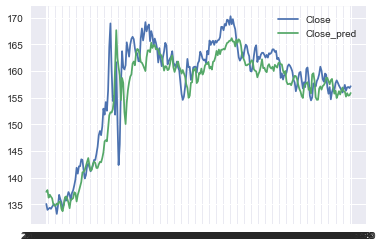

In [71]:
plt.plot(TLT_y_trade_pred_reg['Close'], label='Close')
plt.plot(TLT_y_trade_pred_reg['Close_pred'], label='Close_pred')
plt.legend();

Feature Importance

In [72]:
eli5.show_weights(TLT_perm, feature_names = TLT_X_trade_final.columns.tolist())

Prediction Trading Report

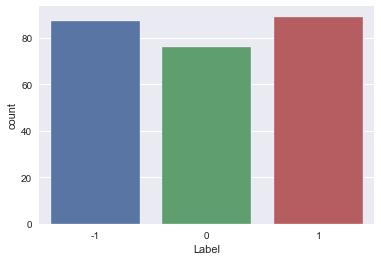

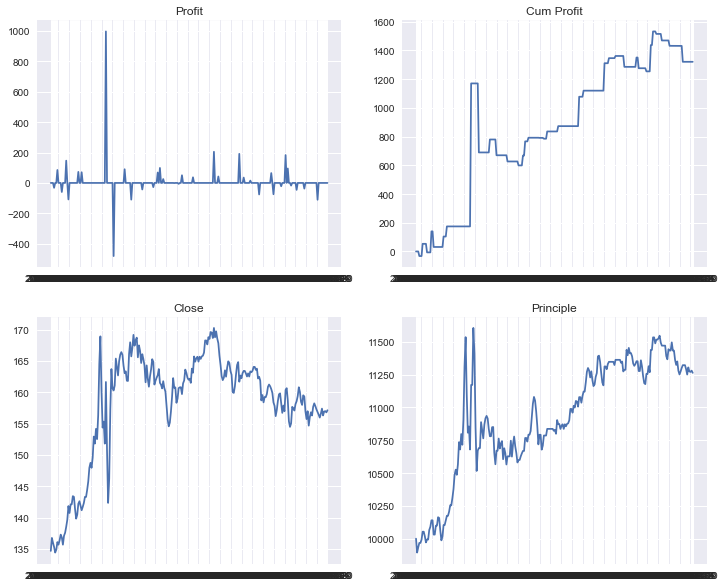

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  | 1262.75 |  12.63%  |    13.48%    |   237    |  0.94  |
| Buy & Hold | 1144.55 |  11.45%  |    11.45%    |   252    |  0.82  |
+------------+---------+----------+--------------+----------+--------+


In [251]:
# use Close_pred for meta-labeling
TLT_y_trade_pred_reg.drop(['Close'], axis=1,inplace=True)
TLT_y_trade_pred_reg.rename(columns={'Close_pred':'Close'}, inplace=True)
TLT_y_trade_pred_reg_labeling, _ = meta_labeling(TLT_y_trade_pred_reg, WINDOW=WINDOW_TLT, HORIZON=HORIZON_TLT, TP=TP_TLT, SL=SL_TLT * -1)
# reformat Close and Close_pred
TLT_y_trade_pred_reg_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
TLT_y_trade_pred_reg_labeling['Close'] = TLT_y_trade[-len(TLT_y_trade_pred_reg_labeling):].values

TLT_trading_log_trade_reg = get_trading_log(TLT_y_trade_pred_reg_labeling[WINDOW_TLT:], principle=principle, percent=percent)
TLT_trading_log_trade_reg.to_csv('reports/TLT_trading_log_trade_reg.csv')
TLT_trading_log_trade_reg = pd.read_csv('reports/TLT_trading_log_trade_reg.csv', index_col='Date')
TLT_report_trade_reg, _ = get_trading_report(TLT_trading_log_trade_reg, show_fig=True)
print(TLT_report_trade_reg)

### USO

#### Model Selection

In [102]:
USO_chosen = reg_model_selection(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test)

        Test Error  Train Error
Model                          
GBR          21.89        38.45
XGBR         32.56         0.87
Ridge        32.79        92.04
DTR          48.86         0.00
Linear       51.01        90.67
KNNR        377.93        42.59


In [103]:
USO_chosen

Index(['GBR', 'XGBR', 'Ridge', 'DTR', 'Linear'], dtype='object', name='Model')

In [104]:
USO_chosen = ['GBR', 'XGBR', 'Ridge', 'DTR', 'Linear']

#### Randomized Search

In [105]:
reg_rs(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test, USO_chosen)

============= GBR Randomized Search =============
Best Parameters: {'regressor__subsample': 0.1, 'regressor__n_estimators': 1500, 'regressor__max_depth': 6, 'regressor__learning_rate': 0.04}
============= XGBR Randomized Search =============
Best Parameters: {'regressor__subsample': 0.6, 'regressor__min_child_weight': 5, 'regressor__max_depth': 2, 'regressor__gamma': 0.3, 'regressor__colsample_bytree': 1.0}
============= Ridge Randomized Search =============
Best Parameters: {'regressor__alpha': 0.3320922888698161, 'regressor__fit_intercept': True, 'regressor__normalize': False, 'regressor__solver': 'lsqr'}
============= DTR Randomized Search =============
Best Parameters: {'regressor__splitter': 'random', 'regressor__min_samples_split': 0.1, 'regressor__min_samples_leaf': 0.01, 'regressor__max_features': 'sqrt', 'regressor__max_depth': 6, 'regressor__criterion': 'mse'}
============= Linear Randomized Search =============
Best Parameters: {'regressor__normalize': False, 'regressor__fit

#### Grid Search

In [73]:
# USO_chosen2 = 'GBR'
# USO_GBR = reg_gs(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test, USO_chosen2)
# joblib.dump(USO_GBR, 'models/USO_GBR.pkl')

USO_GBR = joblib.load("models/USO_GBR.pkl")

#### Model Evaluation

Mean Squared Error

In [74]:
USO_model = USO_GBR
USO_y_trade_pred, USO_perm = reg_evaluation(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test, USO_X_trade_final, USO_y_trade, USO_model)

============= Trade Data =============
Mean Squared Error: 2072.16732404055


Prediction Plot

In [75]:
USO_y_trade_pred_reg = USO[(USO.index >= USO_trade_start_actual) & (USO.index <= trade_end)]
USO_y_trade_pred_reg['Close_pred'] = USO_y_trade_pred
USO_y_trade_pred_reg.to_csv('data/processed/USO_y_trade_pred_reg.csv')
USO_y_trade_pred_reg = pd.read_csv('data/processed/USO_y_trade_pred_reg.csv', index_col='Date')

USO_y_trade_pred_reg.head()

Open   High    Low  Close   Volume  Close_pred
Date                                                       
2019-12-17 101.20 102.08 101.20 101.76  1494075       99.04
2019-12-18 101.28 102.32 100.96 101.92  1483338      100.75
2019-12-19 102.00 102.80 101.68 102.24   959575       97.19
2019-12-20 101.76 101.76 100.48 101.04  1429338       98.47
2019-12-23 100.88 101.76 100.72 101.60   931600       99.26

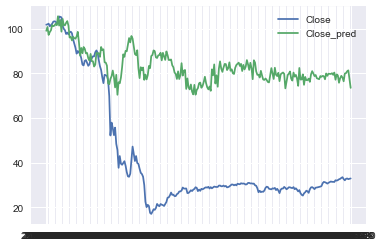

In [76]:
plt.plot(USO_y_trade_pred_reg['Close'], label='Close')
plt.plot(USO_y_trade_pred_reg['Close_pred'], label='Close_pred')
plt.legend();

Feature Importance

In [77]:
eli5.show_weights(USO_perm, feature_names = USO_X_trade_final.columns.tolist())

Prediction Trading Report

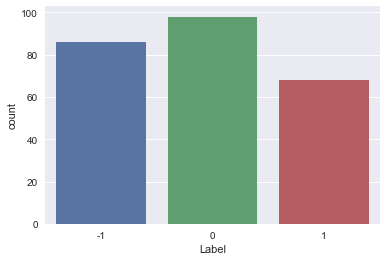

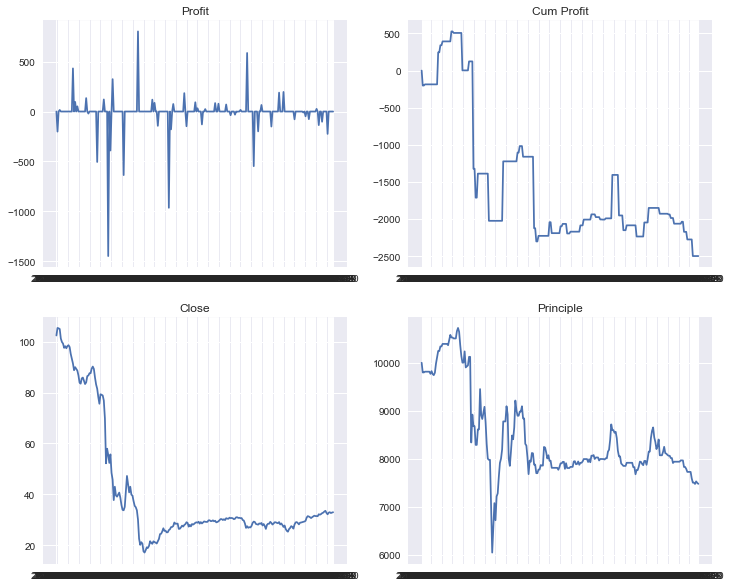

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | -2525.18 | -25.25%  |   -27.92%    |   224    | -0.47  |
| Buy & Hold | -4730.76 | -47.31%  |   -47.31%    |   252    | -1.24  |
+------------+----------+----------+--------------+----------+--------+


In [78]:
# use Close_pred for meta-labeling
USO_y_trade_pred_reg.drop(['Close'], axis=1,inplace=True)
USO_y_trade_pred_reg.rename(columns={'Close_pred':'Close'}, inplace=True)
USO_y_trade_pred_reg_labeling, _ = meta_labeling(USO_y_trade_pred_reg, WINDOW=WINDOW_USO, HORIZON=HORIZON_USO, TP=TP_USO, SL=SL_USO * -1)
# reformat Close and Close_pred
USO_y_trade_pred_reg_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
USO_y_trade_pred_reg_labeling['Close'] = USO_y_trade[-len(USO_y_trade_pred_reg_labeling):].values

USO_trading_log_trade_reg = get_trading_log(USO_y_trade_pred_reg_labeling[WINDOW_USO:], principle=principle, percent=percent)
USO_trading_log_trade_reg.to_csv('reports/USO_trading_log_trade_reg.csv')
USO_trading_log_trade_reg = pd.read_csv('reports/USO_trading_log_trade_reg.csv', index_col='Date')
USO_report_trade_reg, _ = get_trading_report(USO_trading_log_trade_reg, show_fig=True)
print(USO_report_trade_reg)

## Regression - Neural Network

### SPY

#### Data Transformation

In [79]:
SPY_X_train_transformed, SPY_y_train_transformed, SPY_X_test_transformed, SPY_y_test_transformed, SPY_X_trade_transformed, SPY_y_trade_transformed = data_transform(SPY_X_train_final, SPY_y_train, SPY_X_test_final, SPY_y_test, SPY_X_trade_final, SPY_y_trade, 'reg')

In [80]:
SPY_X_train_seq, SPY_y_train_seq = split_sequences(SPY_X_train_transformed, SPY_y_train_transformed, WINDOW_SPY)
SPY_X_test_seq, SPY_y_test_seq = split_sequences(SPY_X_test_transformed, SPY_y_test_transformed, WINDOW_SPY)
SPY_X_trade_seq, SPY_y_trade_seq = split_sequences(SPY_X_trade_transformed, SPY_y_trade_transformed, WINDOW_SPY)

(2512, 5, 30) (2512,)
(238, 5, 30) (238,)
(258, 5, 30) (258,)


In [81]:
n_features = SPY_X_train_seq.shape[2]
n_steps = SPY_X_train_seq.shape[1]
n_classes = 1
print('Number of Features:', n_features)
print('Number of Steps:', n_steps)
print('Number of Classes:', n_classes)

Number of Features: 30
Number of Steps: 5
Number of Classes: 1


#### CNN

Model

In [82]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=20, kernel_size=2,activation='relu',input_shape=(n_steps, n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(5, activation='relu'))
cnn_model.add(Dense(n_classes, activation='linear'))
cnn_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
early_stop = EarlyStopping(monitor='mse', mode='min', verbose=0, patience=4)
cnn_model.fit(SPY_X_train_seq,SPY_y_train_seq, epochs=500, validation_data=(SPY_X_test_seq,SPY_y_test_seq), 
          verbose=1, callbacks=[early_stop])

Epoch 1/500
79/79 [==============================] - 0s 2ms/step - loss: 26203.0859 - mse: 26203.0859 - val_loss: 70134.3438 - val_mse: 70134.3438
Epoch 2/500
79/79 [==============================] - 0s 2ms/step - loss: 17701.8672 - mse: 17701.8672 - val_loss: 42551.0625 - val_mse: 42551.0625
Epoch 3/500
79/79 [==============================] - 0s 2ms/step - loss: 5657.6626 - mse: 5657.6626 - val_loss: 15350.3623 - val_mse: 15350.3623
Epoch 4/500
79/79 [==============================] - 0s 1ms/step - loss: 2010.2686 - mse: 2010.2686 - val_loss: 9906.0928 - val_mse: 9906.0928
Epoch 5/500
79/79 [==============================] - 0s 1ms/step - loss: 1729.0613 - mse: 1729.0613 - val_loss: 9229.0527 - val_mse: 9229.0527
Epoch 6/500
79/79 [==============================] - 0s 2ms/step - loss: 1536.3425 - mse: 1536.3425 - val_loss: 8487.4561 - val_mse: 8487.4561
Epoch 7/500
79/79 [==============================] - 0s 1ms/step - loss: 1349.3796 - mse: 1349.3796 - val_loss: 8074.3701 - val_mse:

Epoch 59/500
79/79 [==============================] - 0s 1ms/step - loss: 43.2859 - mse: 43.2859 - val_loss: 956.3733 - val_mse: 956.3733
Epoch 60/500
79/79 [==============================] - 0s 1ms/step - loss: 41.7828 - mse: 41.7828 - val_loss: 1029.3149 - val_mse: 1029.3149
Epoch 61/500
79/79 [==============================] - 0s 2ms/step - loss: 40.5993 - mse: 40.5993 - val_loss: 940.5660 - val_mse: 940.5660
Epoch 62/500
79/79 [==============================] - 0s 2ms/step - loss: 39.0155 - mse: 39.0155 - val_loss: 873.7625 - val_mse: 873.7625
Epoch 63/500
79/79 [==============================] - 0s 2ms/step - loss: 37.9315 - mse: 37.9315 - val_loss: 913.1700 - val_mse: 913.1700
Epoch 64/500
79/79 [==============================] - 0s 1ms/step - loss: 36.5460 - mse: 36.5460 - val_loss: 835.4844 - val_mse: 835.4844
Epoch 65/500
79/79 [==============================] - 0s 1ms/step - loss: 35.7970 - mse: 35.7970 - val_loss: 851.6223 - val_mse: 851.6223
Epoch 66/500
79/79 [============

79/79 [==============================] - 0s 1ms/step - loss: 13.4487 - mse: 13.4487 - val_loss: 128.4210 - val_mse: 128.4210
Epoch 119/500
79/79 [==============================] - 0s 1ms/step - loss: 13.4944 - mse: 13.4944 - val_loss: 103.8942 - val_mse: 103.8942
Epoch 120/500
79/79 [==============================] - 0s 1ms/step - loss: 13.3100 - mse: 13.3100 - val_loss: 98.7868 - val_mse: 98.7868
Epoch 121/500
79/79 [==============================] - 0s 1ms/step - loss: 13.0231 - mse: 13.0231 - val_loss: 114.3032 - val_mse: 114.3032
Epoch 122/500
79/79 [==============================] - 0s 1ms/step - loss: 12.9138 - mse: 12.9138 - val_loss: 111.5542 - val_mse: 111.5542
Epoch 123/500
79/79 [==============================] - 0s 1ms/step - loss: 13.0948 - mse: 13.0948 - val_loss: 107.9541 - val_mse: 107.9541
Epoch 124/500
79/79 [==============================] - 0s 1ms/step - loss: 12.6763 - mse: 12.6763 - val_loss: 86.0696 - val_mse: 86.0696
Epoch 125/500
79/79 [========================

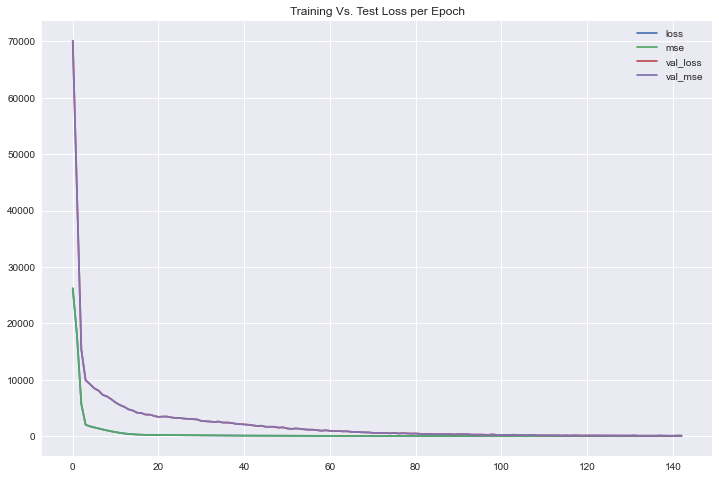

In [83]:
# evaluation
losses = pd.DataFrame(cnn_model.history.history)
losses.plot(figsize=(12,8))
plt.title("Training Vs. Test Loss per Epoch")
plt.show()

Mean Squared Error

In [265]:
SPY_y_trade_seq_pred = cnn_model.predict(SPY_X_trade_seq)
mean_squared_error(SPY_y_trade_seq, SPY_y_trade_seq_pred)

693.1442446139354

Prediction Plot

In [266]:
n = len(SPY_y_trade_seq_pred)
SPY_y_trade_pred_cnn = SPY[-n:]
SPY_y_trade_pred_cnn['Close_pred'] = SPY_y_trade_seq_pred
SPY_y_trade_pred_cnn.to_csv('data/processed/SPY_y_trade_pred_cnn.csv')
SPY_y_trade_pred_cnn = pd.read_csv('data/processed/SPY_y_trade_pred_cnn.csv', index_col='Date')

SPY_y_trade_pred_cnn.head()

Open   High    Low  Close    Volume  Close_pred
Date                                                        
2019-12-23 314.66 314.72 314.15 314.30  52990000      293.70
2019-12-24 314.55 314.60 313.99 314.31  20270000      295.43
2019-12-26 314.72 315.99 314.71 315.98  30911200      295.92
2019-12-27 316.77 316.83 315.34 315.91  42528800      296.69
2019-12-30 315.99 316.14 313.65 314.16  49729100      297.16

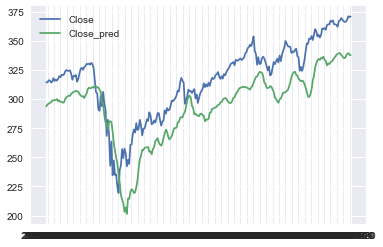

In [267]:
plt.plot(SPY_y_trade_pred_cnn['Close'], label='Close')
plt.plot(SPY_y_trade_pred_cnn['Close_pred'], label='Close_pred')
plt.legend();

Prediction Trading Report

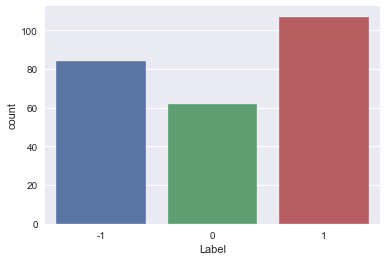

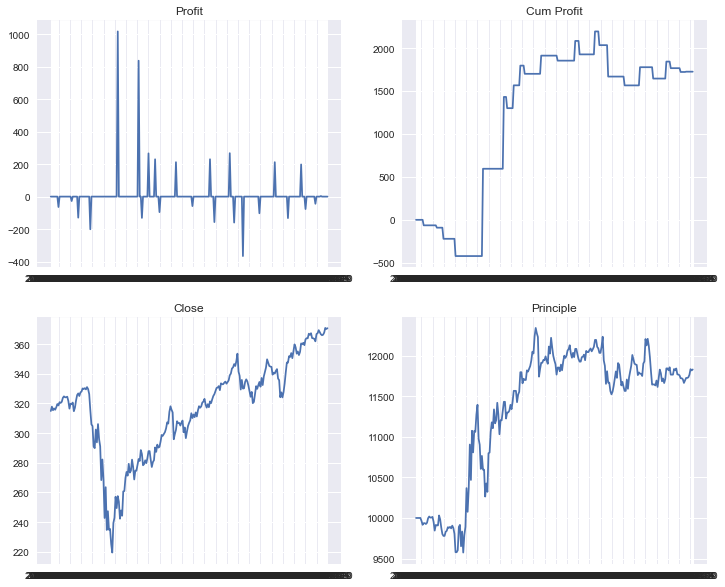

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  | 1828.86 |  18.29%  |    18.69%    |   247    |  0.96  |
| Buy & Hold | 1228.65 |  12.29%  |    12.24%    |   253    |  0.66  |
+------------+---------+----------+--------------+----------+--------+


In [268]:
# use Close_pred for meta-labeling
SPY_y_trade_pred_cnn.drop(['Close'], axis=1,inplace=True)
SPY_y_trade_pred_cnn.rename(columns={'Close_pred':'Close'}, inplace=True)
SPY_y_trade_pred_cnn_labeling, _ = meta_labeling(SPY_y_trade_pred_cnn, WINDOW=WINDOW_SPY, HORIZON=HORIZON_SPY, TP=TP_SPY, SL=SL_SPY * -1)
# reformat Close and Close_pred
SPY_y_trade_pred_cnn_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
SPY_y_trade_pred_cnn_labeling['Close'] = SPY_y_trade[-len(SPY_y_trade_pred_cnn_labeling):].values

SPY_trading_log_trade_cnn = get_trading_log(SPY_y_trade_pred_cnn_labeling, principle=principle, percent=percent)
SPY_trading_log_trade_cnn.to_csv('reports/SPY_trading_log_trade_cnn.csv')
SPY_trading_log_trade_cnn = pd.read_csv('reports/SPY_trading_log_trade_cnn.csv', index_col='Date')
SPY_report_trade_cnn, _ = get_trading_report(SPY_trading_log_trade_cnn, show_fig=True)
print(SPY_report_trade_cnn)

#### LSTM

In [269]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
lstm_model.add(LSTM(50, activation='relu', return_sequences=False))
lstm_model.add(Dense(5))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
early_stop = EarlyStopping(monitor='mse', mode='min', verbose=0, patience=4)
lstm_model.fit(SPY_X_train_seq,SPY_y_train_seq, epochs=500, validation_data=(SPY_X_test_seq,SPY_y_test_seq), 
          verbose=1, callbacks=[early_stop])

Epoch 1/500
79/79 [==============================] - 1s 10ms/step - loss: 9636.7217 - mse: 9636.7217 - val_loss: 4309.7612 - val_mse: 4309.7612
Epoch 2/500
79/79 [==============================] - 1s 7ms/step - loss: 651.7338 - mse: 651.7338 - val_loss: 5919.8560 - val_mse: 5919.8560
Epoch 3/500
79/79 [==============================] - 1s 7ms/step - loss: 262.6466 - mse: 262.6466 - val_loss: 2171.7627 - val_mse: 2171.7627
Epoch 4/500
79/79 [==============================] - 1s 7ms/step - loss: 115.4952 - mse: 115.4952 - val_loss: 1735.0566 - val_mse: 1735.0566
Epoch 5/500
79/79 [==============================] - 0s 6ms/step - loss: 71.1325 - mse: 71.1325 - val_loss: 1499.0793 - val_mse: 1499.0793
Epoch 6/500
79/79 [==============================] - 0s 6ms/step - loss: 56.5877 - mse: 56.5877 - val_loss: 536.7835 - val_mse: 536.7835
Epoch 7/500
79/79 [==============================] - 0s 6ms/step - loss: 40.9365 - mse: 40.9365 - val_loss: 855.7496 - val_mse: 855.7496
Epoch 8/500
79/79 [=

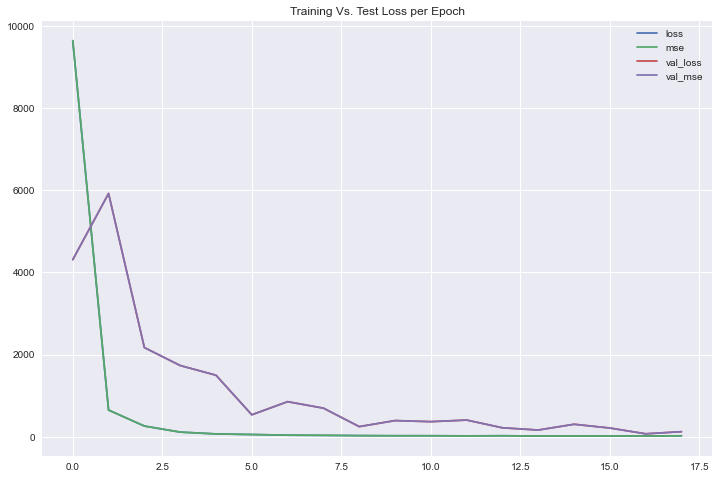

In [270]:
# evaluation
losses = pd.DataFrame(lstm_model.history.history)
losses.plot(figsize=(12,8))
plt.title("Training Vs. Test Loss per Epoch")
plt.show()

Mean Squared Error

In [271]:
SPY_y_trade_seq_pred = lstm_model.predict(SPY_X_trade_seq)
mean_squared_error(SPY_y_trade_seq, SPY_y_trade_seq_pred)

3697.4887134243795

Prediction Plot

In [272]:
n = len(SPY_y_trade_seq_pred)
SPY_y_trade_pred_lstm = SPY[-n:]
SPY_y_trade_pred_lstm['Close_pred'] = SPY_y_trade_seq_pred
SPY_y_trade_pred_lstm.to_csv('data/processed/SPY_y_trade_pred_lstm.csv')
SPY_y_trade_pred_lstm = pd.read_csv('data/processed/SPY_y_trade_pred_lstm.csv', index_col='Date')

SPY_y_trade_pred_lstm.head()

Open   High    Low  Close    Volume  Close_pred
Date                                                        
2019-12-23 314.66 314.72 314.15 314.30  52990000      298.50
2019-12-24 314.55 314.60 313.99 314.31  20270000      298.61
2019-12-26 314.72 315.99 314.71 315.98  30911200      298.92
2019-12-27 316.77 316.83 315.34 315.91  42528800      299.75
2019-12-30 315.99 316.14 313.65 314.16  49729100      301.38

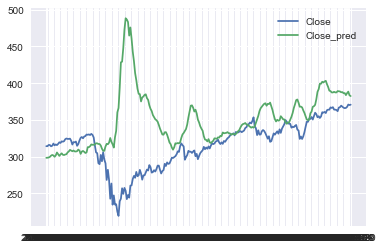

In [273]:
plt.plot(SPY_y_trade_pred_lstm['Close'], label='Close')
plt.plot(SPY_y_trade_pred_lstm['Close_pred'], label='Close_pred')
plt.legend();

Prediction Trading Report

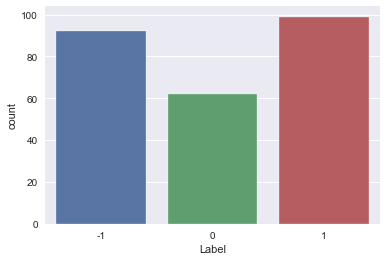

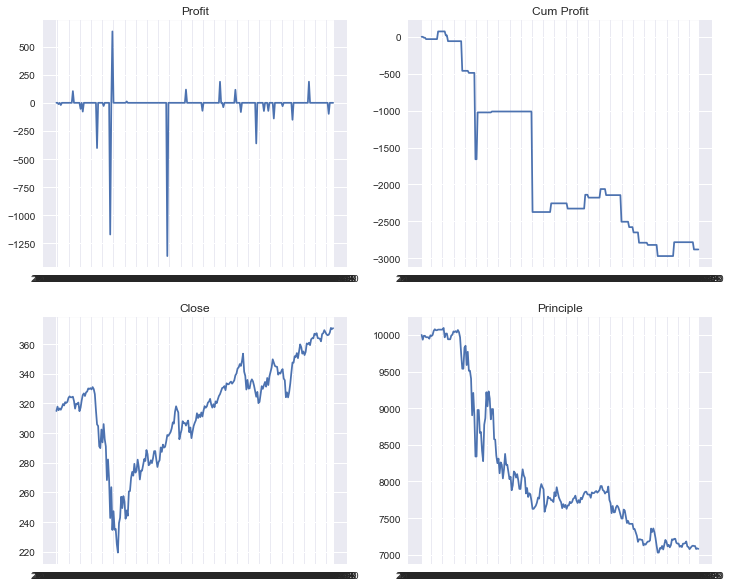

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | -2919.32 | -29.19%  |   -29.79%    |   246    | -1.48  |
| Buy & Hold | 1228.65  |  12.29%  |    12.24%    |   253    |  0.66  |
+------------+----------+----------+--------------+----------+--------+


In [274]:
# use Close_pred for meta-labeling
SPY_y_trade_pred_lstm.drop(['Close'], axis=1,inplace=True)
SPY_y_trade_pred_lstm.rename(columns={'Close_pred':'Close'}, inplace=True)
SPY_y_trade_pred_lstm_labeling, _ = meta_labeling(SPY_y_trade_pred_lstm, WINDOW=WINDOW_SPY, HORIZON=HORIZON_SPY, TP=TP_SPY, SL=SL_SPY * -1)
# reformat Close and Close_pred
SPY_y_trade_pred_lstm_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
SPY_y_trade_pred_lstm_labeling['Close'] = SPY_y_trade[-len(SPY_y_trade_pred_lstm_labeling):].values

SPY_trading_log_trade_lstm = get_trading_log(SPY_y_trade_pred_lstm_labeling, principle=principle, percent=percent)
SPY_trading_log_trade_lstm.to_csv('reports/SPY_trading_log_trade_lstm.csv')
SPY_trading_log_trade_lstm = pd.read_csv('reports/SPY_trading_log_trade_lstm.csv', index_col='Date')
SPY_report_trade_lstm, _ = get_trading_report(SPY_trading_log_trade_lstm, show_fig=True)
print(SPY_report_trade_lstm)

### TLT

#### Data Transformation

In [275]:
TLT_X_train_transformed, TLT_y_train_transformed, TLT_X_test_transformed, TLT_y_test_transformed, TLT_X_trade_transformed, TLT_y_trade_transformed = data_transform(TLT_X_train_final, TLT_y_train, TLT_X_test_final, TLT_y_test, TLT_X_trade_final, TLT_y_trade, 'reg')

In [276]:
TLT_X_train_seq, TLT_y_train_seq = split_sequences(TLT_X_train_transformed, TLT_y_train_transformed, WINDOW_TLT)
TLT_X_test_seq, TLT_y_test_seq = split_sequences(TLT_X_test_transformed, TLT_y_test_transformed, WINDOW_TLT)
TLT_X_trade_seq, TLT_y_trade_seq = split_sequences(TLT_X_trade_transformed, TLT_y_trade_transformed, WINDOW_TLT)

(2512, 5, 30) (2512,)
(238, 5, 30) (238,)
(258, 5, 30) (258,)


In [277]:
n_features = TLT_X_train_seq.shape[2]
n_steps = TLT_X_train_seq.shape[1]
n_classes = 1
print('Number of Features:', n_features)
print('Number of Steps:', n_steps)
print('Number of Classes:', n_classes)

Number of Features: 30
Number of Steps: 5
Number of Classes: 1


#### CNN

Model

In [278]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=20, kernel_size=2,activation='relu',input_shape=(n_steps, n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(5, activation='relu'))
cnn_model.add(Dense(n_classes, activation='linear'))
cnn_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
early_stop = EarlyStopping(monitor='mse', mode='min', verbose=0, patience=4)
cnn_model.fit(TLT_X_train_seq,TLT_y_train_seq, epochs=500, validation_data=(TLT_X_test_seq,TLT_y_test_seq), 
          verbose=1, callbacks=[early_stop])

Epoch 1/500
79/79 [==============================] - 0s 2ms/step - loss: 9247.3047 - mse: 9247.3047 - val_loss: 14784.4678 - val_mse: 14784.4678
Epoch 2/500
79/79 [==============================] - 0s 1ms/step - loss: 7112.9609 - mse: 7112.9609 - val_loss: 8585.1611 - val_mse: 8585.1611
Epoch 3/500
79/79 [==============================] - 0s 2ms/step - loss: 2691.8213 - mse: 2691.8213 - val_loss: 1129.9999 - val_mse: 1129.9999
Epoch 4/500
79/79 [==============================] - 0s 1ms/step - loss: 271.8114 - mse: 271.8114 - val_loss: 234.0517 - val_mse: 234.0517
Epoch 5/500
79/79 [==============================] - 0s 1ms/step - loss: 174.7857 - mse: 174.7857 - val_loss: 222.7743 - val_mse: 222.7743
Epoch 6/500
79/79 [==============================] - 0s 1ms/step - loss: 165.5702 - mse: 165.5702 - val_loss: 211.3863 - val_mse: 211.3863
Epoch 7/500
79/79 [==============================] - 0s 1ms/step - loss: 156.7231 - mse: 156.7231 - val_loss: 201.5883 - val_mse: 201.5883
Epoch 8/500
7

Epoch 61/500
79/79 [==============================] - 0s 1ms/step - loss: 5.6378 - mse: 5.6378 - val_loss: 12.7030 - val_mse: 12.7030
Epoch 62/500
79/79 [==============================] - 0s 1ms/step - loss: 5.4847 - mse: 5.4847 - val_loss: 9.7789 - val_mse: 9.7789
Epoch 63/500
79/79 [==============================] - 0s 1ms/step - loss: 5.5215 - mse: 5.5215 - val_loss: 12.6118 - val_mse: 12.6118
Epoch 64/500
79/79 [==============================] - 0s 1ms/step - loss: 5.3464 - mse: 5.3464 - val_loss: 9.2137 - val_mse: 9.2137
Epoch 65/500
79/79 [==============================] - 0s 1ms/step - loss: 5.3069 - mse: 5.3069 - val_loss: 10.3933 - val_mse: 10.3933
Epoch 66/500
79/79 [==============================] - 0s 1ms/step - loss: 5.3674 - mse: 5.3674 - val_loss: 9.4793 - val_mse: 9.4793
Epoch 67/500
79/79 [==============================] - 0s 1ms/step - loss: 5.4134 - mse: 5.4134 - val_loss: 9.0592 - val_mse: 9.0592
Epoch 68/500
79/79 [==============================] - 0s 1ms/step - lo

Epoch 123/500
79/79 [==============================] - 0s 1ms/step - loss: 4.0388 - mse: 4.0388 - val_loss: 7.0610 - val_mse: 7.0610
Epoch 124/500
79/79 [==============================] - 0s 1ms/step - loss: 3.7549 - mse: 3.7549 - val_loss: 7.1921 - val_mse: 7.1921
Epoch 125/500
79/79 [==============================] - 0s 1ms/step - loss: 3.9571 - mse: 3.9571 - val_loss: 6.8375 - val_mse: 6.8375
Epoch 126/500
79/79 [==============================] - 0s 1ms/step - loss: 4.0471 - mse: 4.0471 - val_loss: 7.1379 - val_mse: 7.1379
Epoch 127/500
79/79 [==============================] - 0s 1ms/step - loss: 3.7890 - mse: 3.7890 - val_loss: 7.3584 - val_mse: 7.3584
Epoch 128/500
79/79 [==============================] - 0s 1ms/step - loss: 3.7486 - mse: 3.7486 - val_loss: 7.3327 - val_mse: 7.3327
Epoch 129/500
79/79 [==============================] - 0s 1ms/step - loss: 3.7342 - mse: 3.7342 - val_loss: 6.8845 - val_mse: 6.8845
Epoch 130/500
79/79 [==============================] - 0s 1ms/step - 

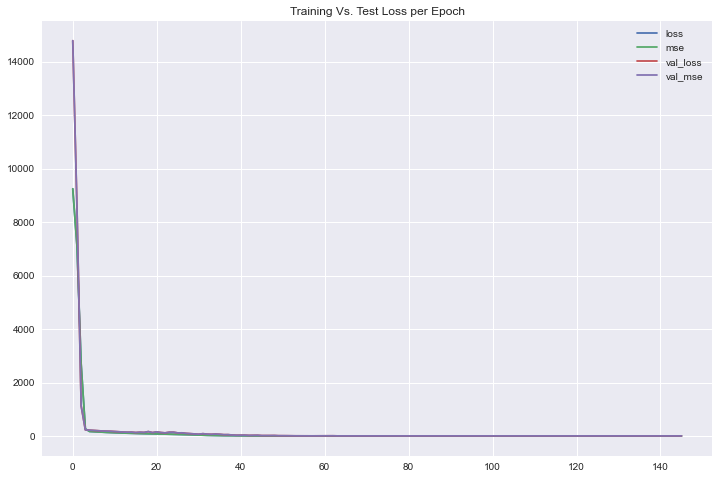

In [279]:
# evaluation
losses = pd.DataFrame(cnn_model.history.history)
losses.plot(figsize=(12,8))
plt.title("Training Vs. Test Loss per Epoch")
plt.show()

Mean Squared Error

In [280]:
TLT_y_trade_seq_pred = cnn_model.predict(TLT_X_trade_seq)
mean_squared_error(TLT_y_trade_seq, TLT_y_trade_seq_pred)

19.878187969106776

Prediction Plot

In [281]:
n = len(TLT_y_trade_seq_pred)
TLT_y_trade_pred_cnn = TLT[-n:]
TLT_y_trade_pred_cnn['Close_pred'] = TLT_y_trade_seq_pred
TLT_y_trade_pred_cnn.to_csv('data/processed/TLT_y_trade_pred_cnn.csv')
TLT_y_trade_pred_cnn = pd.read_csv('data/processed/TLT_y_trade_pred_cnn.csv', index_col='Date')

TLT_y_trade_pred_cnn.head()

Open   High    Low  Close   Volume  Close_pred
Date                                                       
2019-12-23 134.49 134.65 133.69 134.14  5175000      135.39
2019-12-24 133.61 134.74 133.59 134.52  4667400      134.59
2019-12-26 134.59 134.89 134.19 134.84  5290200      134.72
2019-12-27 135.11 135.30 134.96 134.99  7300500      133.57
2019-12-30 133.59 134.58 133.36 134.50  7979700      133.72

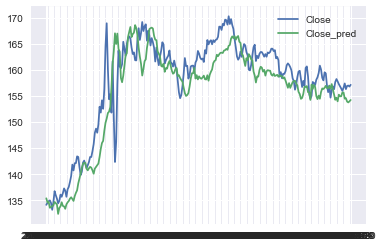

In [282]:
plt.plot(TLT_y_trade_pred_cnn['Close'], label='Close')
plt.plot(TLT_y_trade_pred_cnn['Close_pred'], label='Close_pred')
plt.legend();

Prediction Trading Report

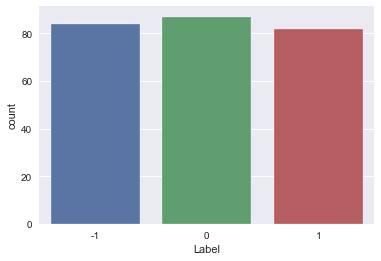

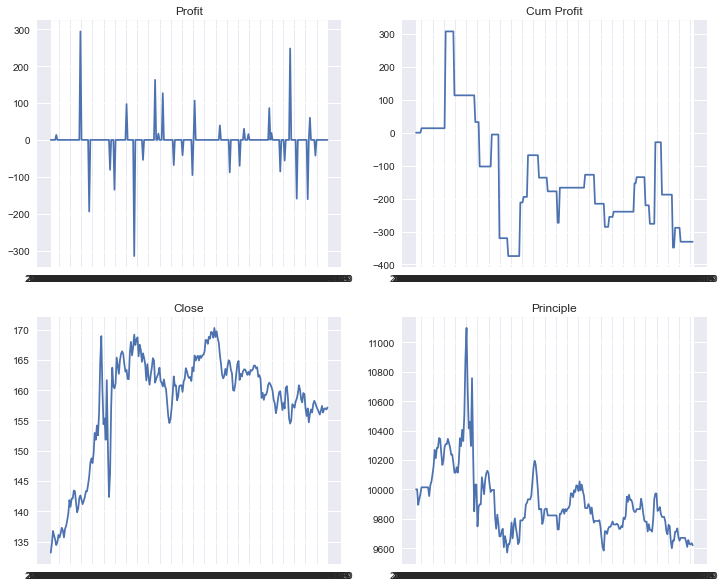

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  | -381.15 |  -3.81%  |    -4.20%    |   228    | -0.22  |
| Buy & Hold |  1245.2 |  12.45%  |    12.40%    |   253    |  0.87  |
+------------+---------+----------+--------------+----------+--------+


In [283]:
# use Close_pred for meta-labeling
TLT_y_trade_pred_cnn.drop(['Close'], axis=1,inplace=True)
TLT_y_trade_pred_cnn.rename(columns={'Close_pred':'Close'}, inplace=True)
TLT_y_trade_pred_cnn_labeling, _ = meta_labeling(TLT_y_trade_pred_cnn, WINDOW=WINDOW_TLT, HORIZON=HORIZON_TLT, TP=TP_TLT, SL=SL_TLT * -1)
# reformat Close and Close_pred
TLT_y_trade_pred_cnn_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
TLT_y_trade_pred_cnn_labeling['Close'] = TLT_y_trade[-len(TLT_y_trade_pred_cnn_labeling):].values

TLT_trading_log_trade_cnn = get_trading_log(TLT_y_trade_pred_cnn_labeling, principle=principle, percent=percent)
TLT_trading_log_trade_cnn.to_csv('reports/TLT_trading_log_trade_cnn.csv')
TLT_trading_log_trade_cnn = pd.read_csv('reports/TLT_trading_log_trade_cnn.csv', index_col='Date')
TLT_report_trade_cnn, _ = get_trading_report(TLT_trading_log_trade_cnn, show_fig=True)
print(TLT_report_trade_cnn)

#### LSTM

In [284]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
lstm_model.add(LSTM(50, activation='relu', return_sequences=False))
lstm_model.add(Dense(5))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
early_stop = EarlyStopping(monitor='mse', mode='min', verbose=0, patience=4)
lstm_model.fit(TLT_X_train_seq,TLT_y_train_seq, epochs=500, validation_data=(TLT_X_test_seq,TLT_y_test_seq), 
          verbose=1, callbacks=[early_stop])

Epoch 1/500
79/79 [==============================] - 1s 9ms/step - loss: 3694.6990 - mse: 3694.6990 - val_loss: 3138.4905 - val_mse: 3138.4905
Epoch 2/500
79/79 [==============================] - 1s 7ms/step - loss: 225.9523 - mse: 225.9523 - val_loss: 180.0342 - val_mse: 180.0342
Epoch 3/500
79/79 [==============================] - 1s 7ms/step - loss: 22.8873 - mse: 22.8873 - val_loss: 27.1222 - val_mse: 27.1222
Epoch 4/500
79/79 [==============================] - 0s 6ms/step - loss: 10.3812 - mse: 10.3812 - val_loss: 22.6042 - val_mse: 22.6042
Epoch 5/500
79/79 [==============================] - 0s 6ms/step - loss: 7.0000 - mse: 7.0000 - val_loss: 33.9124 - val_mse: 33.9124
Epoch 6/500
79/79 [==============================] - 0s 6ms/step - loss: 5.7185 - mse: 5.7185 - val_loss: 22.7727 - val_mse: 22.7727
Epoch 7/500
79/79 [==============================] - 0s 6ms/step - loss: 5.1982 - mse: 5.1982 - val_loss: 28.2001 - val_mse: 28.2001
Epoch 8/500
79/79 [==============================

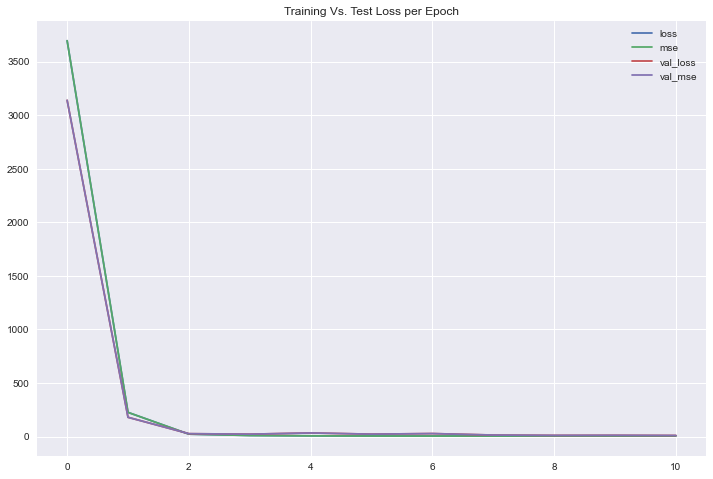

In [285]:
# evaluation
losses = pd.DataFrame(lstm_model.history.history)
losses.plot(figsize=(12,8))
plt.title("Training Vs. Test Loss per Epoch")
plt.show()

Mean Squared Error

In [286]:
TLT_y_trade_seq_pred = lstm_model.predict(TLT_X_trade_seq)
mean_squared_error(TLT_y_trade_seq, TLT_y_trade_seq_pred)

33.385657384995255

Prediction Plot

In [287]:
n = len(TLT_y_trade_seq_pred)
TLT_y_trade_pred_lstm = TLT[-n:]
TLT_y_trade_pred_lstm['Close_pred'] = TLT_y_trade_seq_pred
TLT_y_trade_pred_lstm.to_csv('data/processed/TLT_y_trade_pred_lstm.csv')
TLT_y_trade_pred_lstm = pd.read_csv('data/processed/TLT_y_trade_pred_lstm.csv', index_col='Date')

TLT_y_trade_pred_lstm.head()

Open   High    Low  Close   Volume  Close_pred
Date                                                       
2019-12-23 134.49 134.65 133.69 134.14  5175000      138.76
2019-12-24 133.61 134.74 133.59 134.52  4667400      137.98
2019-12-26 134.59 134.89 134.19 134.84  5290200      138.21
2019-12-27 135.11 135.30 134.96 134.99  7300500      138.11
2019-12-30 133.59 134.58 133.36 134.50  7979700      138.12

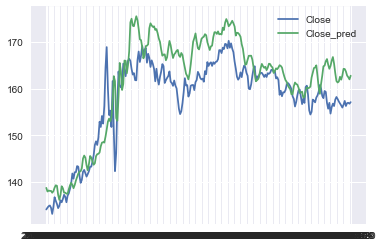

In [288]:
plt.plot(TLT_y_trade_pred_lstm['Close'], label='Close')
plt.plot(TLT_y_trade_pred_lstm['Close_pred'], label='Close_pred')
plt.legend();

Prediction Trading Report

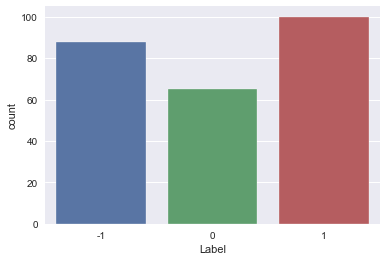

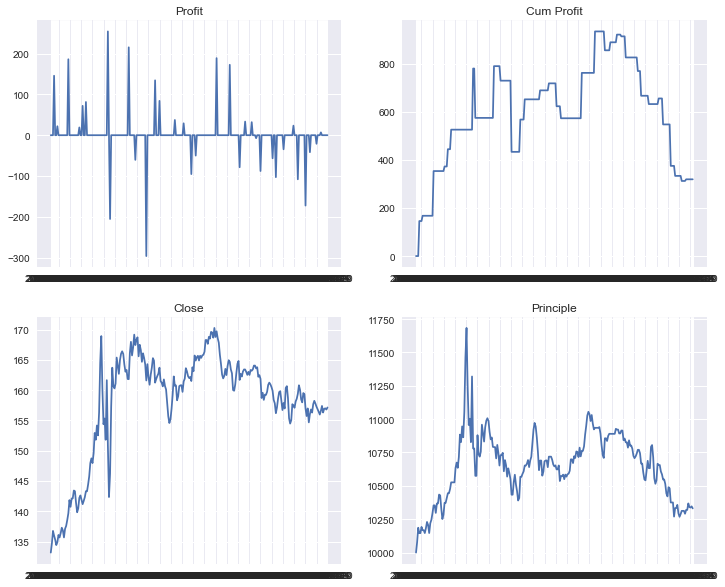

+------------+--------+----------+--------------+----------+--------+
|   Model    | Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+--------+----------+--------------+----------+--------+
|  Strategy  | 331.06 |  3.31%   |    3.44%     |   243    |  0.31  |
| Buy & Hold | 1245.2 |  12.45%  |    12.40%    |   253    |  0.87  |
+------------+--------+----------+--------------+----------+--------+


In [289]:
# use Close_pred for meta-labeling
TLT_y_trade_pred_lstm.drop(['Close'], axis=1,inplace=True)
TLT_y_trade_pred_lstm.rename(columns={'Close_pred':'Close'}, inplace=True)
TLT_y_trade_pred_lstm_labeling, _ = meta_labeling(TLT_y_trade_pred_lstm, WINDOW=WINDOW_TLT, HORIZON=HORIZON_TLT, TP=TP_TLT, SL=SL_TLT * -1)
# reformat Close and Close_pred
TLT_y_trade_pred_lstm_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
TLT_y_trade_pred_lstm_labeling['Close'] = TLT_y_trade[-len(TLT_y_trade_pred_lstm_labeling):].values

TLT_trading_log_trade_lstm = get_trading_log(TLT_y_trade_pred_lstm_labeling, principle=principle, percent=percent)
TLT_trading_log_trade_lstm.to_csv('reports/TLT_trading_log_trade_lstm.csv')
TLT_trading_log_trade_lstm = pd.read_csv('reports/TLT_trading_log_trade_lstm.csv', index_col='Date')
TLT_report_trade_lstm, _ = get_trading_report(TLT_trading_log_trade_lstm, show_fig=True)
print(TLT_report_trade_lstm)

### USO

#### Data Transformation

In [290]:
USO_X_train_transformed, USO_y_train_transformed, USO_X_test_transformed, USO_y_test_transformed, USO_X_trade_transformed, USO_y_trade_transformed = data_transform(USO_X_train_final, USO_y_train, USO_X_test_final, USO_y_test, USO_X_trade_final, USO_y_trade, 'reg')

In [291]:
USO_X_train_seq, USO_y_train_seq = split_sequences(USO_X_train_transformed, USO_y_train_transformed, WINDOW_USO)
USO_X_test_seq, USO_y_test_seq = split_sequences(USO_X_test_transformed, USO_y_test_transformed, WINDOW_USO)
USO_X_trade_seq, USO_y_trade_seq = split_sequences(USO_X_trade_transformed, USO_y_trade_transformed, WINDOW_USO)

(2512, 5, 30) (2512,)
(238, 5, 30) (238,)
(258, 5, 30) (258,)


In [292]:
n_features = USO_X_train_seq.shape[2]
n_steps = USO_X_train_seq.shape[1]
n_classes = 1
print('Number of Features:', n_features)
print('Number of Steps:', n_steps)
print('Number of Classes:', n_classes)

Number of Features: 30
Number of Steps: 5
Number of Classes: 1


#### CNN

Model

In [293]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=20, kernel_size=2,activation='relu',input_shape=(n_steps, n_features)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(5, activation='relu'))
cnn_model.add(Dense(n_classes, activation='linear'))
cnn_model.compile(loss='mse', optimizer='adam', metrics=['mse'])
early_stop = EarlyStopping(monitor='mse', mode='min', verbose=0, patience=4)
cnn_model.fit(USO_X_train_seq,USO_y_train_seq, epochs=500, validation_data=(USO_X_test_seq,USO_y_test_seq), 
          verbose=1, callbacks=[early_stop])

Epoch 1/500
79/79 [==============================] - 0s 2ms/step - loss: 49760.4961 - mse: 49760.4961 - val_loss: 5188.7300 - val_mse: 5188.7300
Epoch 2/500
79/79 [==============================] - 0s 2ms/step - loss: 33371.4062 - mse: 33371.4062 - val_loss: 60.6815 - val_mse: 60.6815
Epoch 3/500
79/79 [==============================] - 0s 2ms/step - loss: 12814.3652 - mse: 12814.3652 - val_loss: 7464.5698 - val_mse: 7464.5698
Epoch 4/500
79/79 [==============================] - 0s 1ms/step - loss: 6385.2227 - mse: 6385.2227 - val_loss: 8038.9097 - val_mse: 8038.9097
Epoch 5/500
79/79 [==============================] - 0s 2ms/step - loss: 4617.6577 - mse: 4617.6577 - val_loss: 5393.8877 - val_mse: 5393.8877
Epoch 6/500
79/79 [==============================] - 0s 1ms/step - loss: 3228.8960 - mse: 3228.8960 - val_loss: 3248.2185 - val_mse: 3248.2185
Epoch 7/500
79/79 [==============================] - 0s 1ms/step - loss: 2106.6929 - mse: 2106.6929 - val_loss: 1555.1593 - val_mse: 1555.15

Epoch 60/500
79/79 [==============================] - 0s 1ms/step - loss: 98.2904 - mse: 98.2904 - val_loss: 30.9279 - val_mse: 30.9279
Epoch 61/500
79/79 [==============================] - 0s 1ms/step - loss: 98.3855 - mse: 98.3855 - val_loss: 29.5539 - val_mse: 29.5539
Epoch 62/500
79/79 [==============================] - 0s 1ms/step - loss: 97.3423 - mse: 97.3423 - val_loss: 29.6951 - val_mse: 29.6951
Epoch 63/500
79/79 [==============================] - 0s 2ms/step - loss: 96.9073 - mse: 96.9073 - val_loss: 29.4072 - val_mse: 29.4072
Epoch 64/500
79/79 [==============================] - 0s 1ms/step - loss: 96.7783 - mse: 96.7783 - val_loss: 31.7183 - val_mse: 31.7183
Epoch 65/500
79/79 [==============================] - 0s 2ms/step - loss: 95.3912 - mse: 95.3912 - val_loss: 27.7051 - val_mse: 27.7051
Epoch 66/500
79/79 [==============================] - 0s 1ms/step - loss: 95.2224 - mse: 95.2224 - val_loss: 29.4457 - val_mse: 29.4457
Epoch 67/500
79/79 [============================

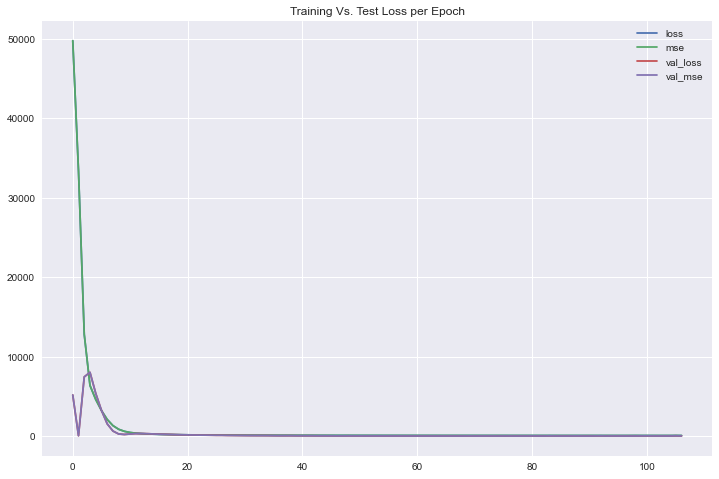

In [294]:
# evaluation
losses = pd.DataFrame(cnn_model.history.history)
losses.plot(figsize=(12,8))
plt.title("Training Vs. Test Loss per Epoch")
plt.show()

Mean Squared Error

In [295]:
USO_y_trade_seq_pred = cnn_model.predict(USO_X_trade_seq)
mean_squared_error(USO_y_trade_seq, USO_y_trade_seq_pred)

184.85069609381185

Prediction Plot

In [296]:
n = len(USO_y_trade_seq_pred)
USO_y_trade_pred_cnn = USO[-n:]
USO_y_trade_pred_cnn['Close_pred'] = USO_y_trade_seq_pred
USO_y_trade_pred_cnn.to_csv('data/processed/USO_y_trade_pred_cnn.csv')
USO_y_trade_pred_cnn = pd.read_csv('data/processed/USO_y_trade_pred_cnn.csv', index_col='Date')

USO_y_trade_pred_cnn.head()

Open   High    Low  Close   Volume  Close_pred
Date                                                       
2019-12-23 100.88 101.76 100.72 101.60   931600       94.87
2019-12-24 101.84 102.32 101.84 102.16   431738       97.56
2019-12-26 102.56 103.52 102.56 103.12   881688       96.85
2019-12-27 103.36 103.68 102.56 103.28  1137988       97.69
2019-12-30 104.08 104.16 102.32 103.12  1121463       97.70

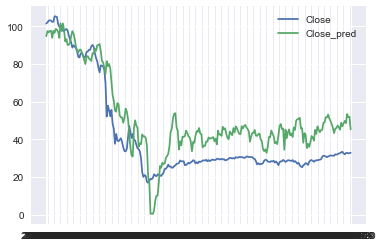

In [297]:
plt.plot(USO_y_trade_pred_cnn['Close'], label='Close')
plt.plot(USO_y_trade_pred_cnn['Close_pred'], label='Close_pred')
plt.legend();

Prediction Trading Report

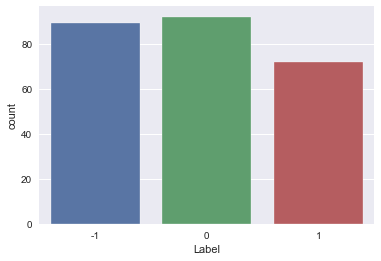

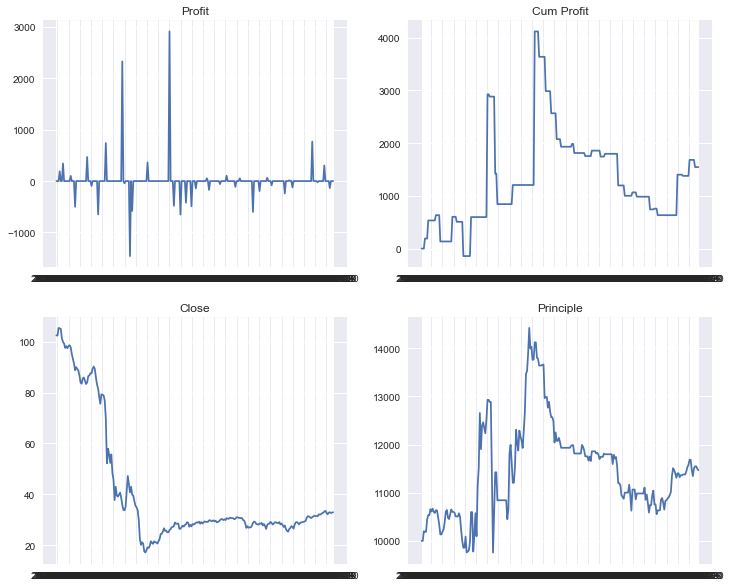

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  |  1467.1  |  14.67%  |    17.32%    |   216    |  0.54  |
| Buy & Hold | -4730.76 | -47.31%  |   -47.17%    |   253    | -1.24  |
+------------+----------+----------+--------------+----------+--------+


In [298]:
# use Close_pred for meta-labeling
USO_y_trade_pred_cnn.drop(['Close'], axis=1,inplace=True)
USO_y_trade_pred_cnn.rename(columns={'Close_pred':'Close'}, inplace=True)
USO_y_trade_pred_cnn_labeling, _ = meta_labeling(USO_y_trade_pred_cnn, WINDOW=WINDOW_USO, HORIZON=HORIZON_USO, TP=TP_USO, SL=SL_USO * -1)
# reformat Close and Close_pred
USO_y_trade_pred_cnn_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
USO_y_trade_pred_cnn_labeling['Close'] = USO_y_trade[-len(USO_y_trade_pred_cnn_labeling):].values

USO_trading_log_trade_cnn = get_trading_log(USO_y_trade_pred_cnn_labeling, principle=principle, percent=percent)
USO_trading_log_trade_cnn.to_csv('reports/USO_trading_log_trade_cnn.csv')
USO_trading_log_trade_cnn = pd.read_csv('reports/USO_trading_log_trade_cnn.csv', index_col='Date')
USO_report_trade_cnn, _ = get_trading_report(USO_trading_log_trade_cnn, show_fig=True)
print(USO_report_trade_cnn)

#### LSTM

In [299]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
lstm_model.add(LSTM(50, activation='relu', return_sequences=False))
lstm_model.add(Dense(5))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
early_stop = EarlyStopping(monitor='mse', mode='min', verbose=0, patience=4)
lstm_model.fit(USO_X_train_seq,USO_y_train_seq, epochs=500, validation_data=(USO_X_test_seq,USO_y_test_seq), 
          verbose=1, callbacks=[early_stop])

Epoch 1/500
79/79 [==============================] - 1s 9ms/step - loss: 21666.9668 - mse: 21666.9668 - val_loss: 261.0486 - val_mse: 261.0486
Epoch 2/500
79/79 [==============================] - 1s 6ms/step - loss: 737.9691 - mse: 737.9691 - val_loss: 250.4164 - val_mse: 250.4164
Epoch 3/500
79/79 [==============================] - 1s 10ms/step - loss: 373.7109 - mse: 373.7109 - val_loss: 65.7190 - val_mse: 65.7190
Epoch 4/500
79/79 [==============================] - 1s 7ms/step - loss: 251.6244 - mse: 251.6244 - val_loss: 76.6429 - val_mse: 76.6429
Epoch 5/500
79/79 [==============================] - 1s 6ms/step - loss: 195.2105 - mse: 195.2105 - val_loss: 120.6272 - val_mse: 120.6272
Epoch 6/500
79/79 [==============================] - 0s 6ms/step - loss: 165.9920 - mse: 165.9920 - val_loss: 95.9585 - val_mse: 95.9585
Epoch 7/500
79/79 [==============================] - 1s 7ms/step - loss: 170.9941 - mse: 170.9941 - val_loss: 290.2779 - val_mse: 290.2779
Epoch 8/500
79/79 [=========

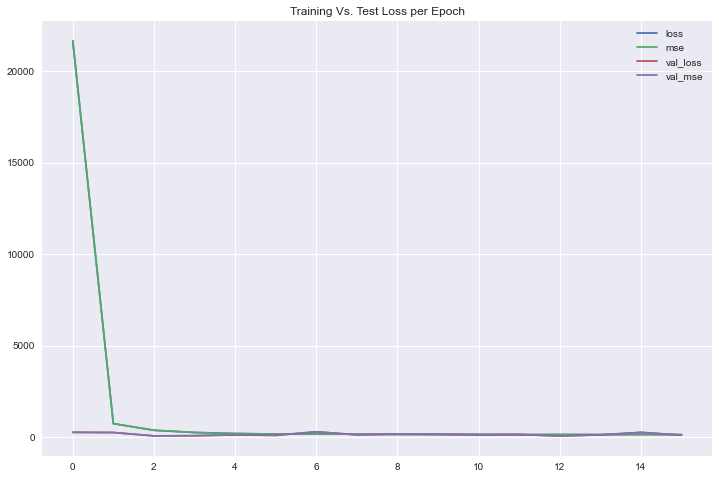

In [300]:
# evaluation
losses = pd.DataFrame(lstm_model.history.history)
losses.plot(figsize=(12,8))
plt.title("Training Vs. Test Loss per Epoch")
plt.show()

Mean Squared Error

In [301]:
USO_y_trade_seq_pred = lstm_model.predict(USO_X_trade_seq)
mean_squared_error(USO_y_trade_seq, USO_y_trade_seq_pred)

1106.818452768522

Prediction Plot

In [302]:
n = len(USO_y_trade_seq_pred)
USO_y_trade_pred_lstm = USO[-n:]
USO_y_trade_pred_lstm['Close_pred'] = USO_y_trade_seq_pred
USO_y_trade_pred_lstm.to_csv('data/processed/USO_y_trade_pred_lstm.csv')
USO_y_trade_pred_lstm = pd.read_csv('data/processed/USO_y_trade_pred_lstm.csv', index_col='Date')

USO_y_trade_pred_lstm.head()

Open   High    Low  Close   Volume  Close_pred
Date                                                       
2019-12-23 100.88 101.76 100.72 101.60   931600      110.48
2019-12-24 101.84 102.32 101.84 102.16   431738      112.57
2019-12-26 102.56 103.52 102.56 103.12   881688      112.08
2019-12-27 103.36 103.68 102.56 103.28  1137988      112.95
2019-12-30 104.08 104.16 102.32 103.12  1121463      112.59

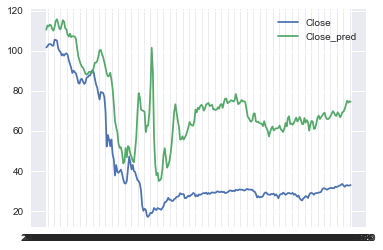

In [303]:
plt.plot(USO_y_trade_pred_lstm['Close'], label='Close')
plt.plot(USO_y_trade_pred_lstm['Close_pred'], label='Close_pred')
plt.legend();

Prediction Trading Report

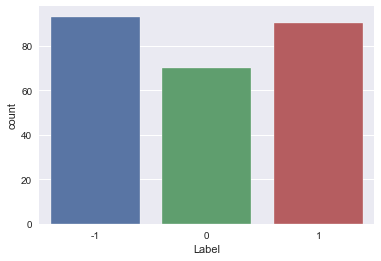

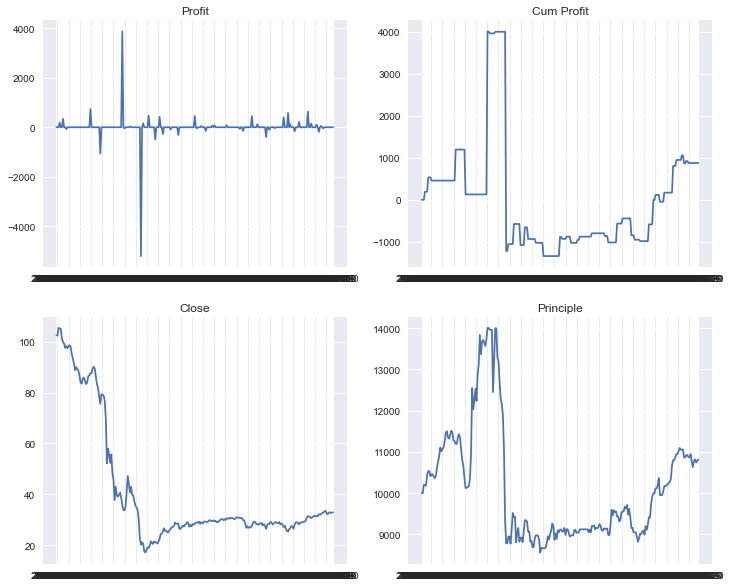

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  |  816.91  |  8.17%   |    8.45%     |   244    |  0.4   |
| Buy & Hold | -4730.76 | -47.31%  |   -47.17%    |   253    | -1.24  |
+------------+----------+----------+--------------+----------+--------+


In [304]:
# use Close_pred for meta-labeling
USO_y_trade_pred_lstm.drop(['Close'], axis=1,inplace=True)
USO_y_trade_pred_lstm.rename(columns={'Close_pred':'Close'}, inplace=True)
USO_y_trade_pred_lstm_labeling, _ = meta_labeling(USO_y_trade_pred_lstm, WINDOW=WINDOW_USO, HORIZON=HORIZON_USO, TP=TP_USO, SL=SL_USO * -1)
# reformat Close and Close_pred
USO_y_trade_pred_lstm_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
USO_y_trade_pred_lstm_labeling['Close'] = USO_y_trade[-len(USO_y_trade_pred_lstm_labeling):].values

USO_trading_log_trade_lstm = get_trading_log(USO_y_trade_pred_lstm_labeling, principle=principle, percent=percent)
USO_trading_log_trade_lstm.to_csv('reports/USO_trading_log_trade_lstm.csv')
USO_trading_log_trade_lstm = pd.read_csv('reports/USO_trading_log_trade_lstm.csv', index_col='Date')
USO_report_trade_lstm, _ = get_trading_report(USO_trading_log_trade_lstm, show_fig=True)
print(USO_report_trade_lstm)

## Regression - ARIMA

### SPY

#### ACF

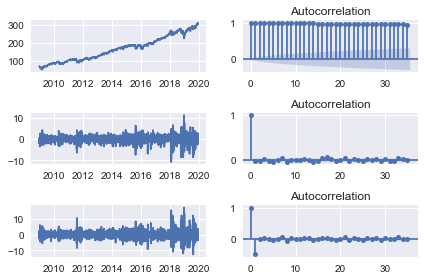

In [305]:
df = SPY_y_train.append(SPY_y_test)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2)
ax1.plot(df)
plot_acf(df, ax=ax2)

ax3.plot(df.diff().dropna())
plot_acf(df.diff().dropna(), ax=ax4)

ax5.plot(df.diff().diff().dropna())
plot_acf(df.diff().diff().dropna(), ax=ax6)
plt.tight_layout();

#### Model Selection

In [306]:
SPY_model = pm.auto_arima(df, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, m=1,
                          seasonal=True,start_P=0, D=0, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          trace=True,error_action='warn', suppress_warnings=True, stepwise=False, random_state=1, n_fits=500)

print(SPY_model.summary())

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=10213.707, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=10212.908, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=10213.478, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=10215.449, Time=0.26 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=10215.495, Time=0.40 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=10211.994, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=10213.036, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=10205.349, Time=1.47 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=10206.427, Time=1.89 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=10208.125, Time=2.58 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=10209.377, Time=2.78 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=10213.513, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=10215.340, Time=0.40 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=10209.205, Time=1.90 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=10209.527, Time=2.71

#### Model Evaluation

Residual

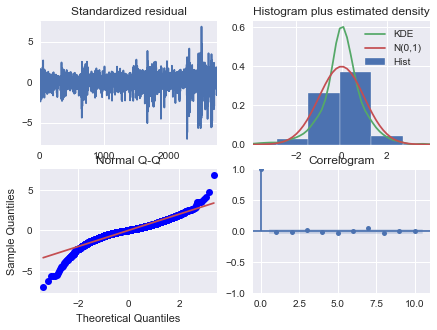

In [307]:
SPY_model.plot_diagnostics(figsize=(7,5))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Prediction Plot

In [308]:
history = [x for x in df]
model_predictions = []
N_test_observations = len(SPY_y_trade)- WINDOW_SPY
for time_point in range(N_test_observations):
    model_fit = SPY_model.fit(history)
    output = model_fit.predict(n_periods=WINDOW_SPY)
    yhat = output[-1]
    model_predictions.append(yhat)
    true_test_value = SPY_y_trade[time_point]
    history.append(true_test_value)

model_predictions = pd.Series(model_predictions, index=SPY_y_trade.index[WINDOW_SPY:])

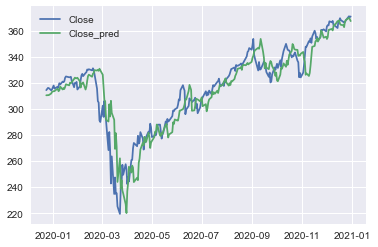

In [309]:
plt.plot(SPY_y_trade[WINDOW_SPY:], label='Close')
plt.plot(model_predictions, label='Close_pred')
plt.legend();

Mean Squared Error

In [310]:
mean_squared_error(SPY_y_trade[WINDOW_SPY:], model_predictions)

168.3113078613317

Prediction Trading Report

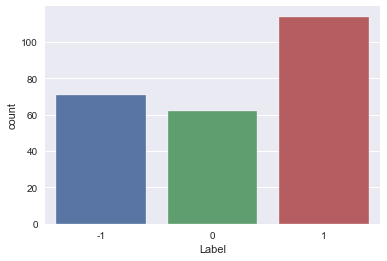

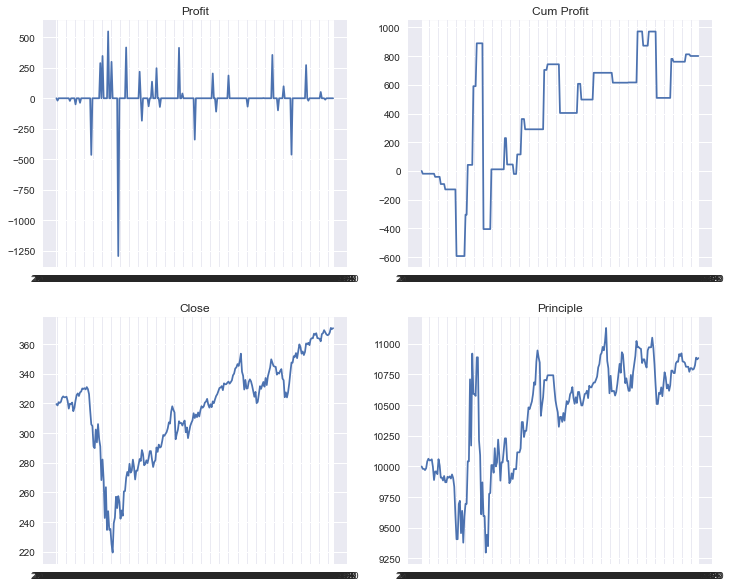

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  |  883.67 |  8.84%   |    9.30%     |   240    |  0.51  |
| Buy & Hold | 1074.38 |  10.74%  |    10.97%    |   247    |  0.62  |
+------------+---------+----------+--------------+----------+--------+


In [311]:
SPY_y_trade_pred_arima = SPY[(SPY.index >= trade_start) & (SPY.index <= trade_end)]
SPY_y_trade_pred_arima['Close_pred'] = model_predictions
SPY_y_trade_pred_arima.to_csv('data/processed/SPY_y_trade_pred_arima.csv')
SPY_y_trade_pred_arima = pd.read_csv('data/processed/SPY_y_trade_pred_arima.csv', index_col='Date')

# use Close_pred for meta-labeling
SPY_y_trade_pred_arima.drop(['Close'], axis=1,inplace=True)
SPY_y_trade_pred_arima.rename(columns={'Close_pred':'Close'}, inplace=True)
SPY_y_trade_pred_arima_labeling, _ = meta_labeling(SPY_y_trade_pred_arima, WINDOW=WINDOW_SPY, HORIZON=HORIZON_SPY, TP=TP_SPY, SL=SL_SPY * -1)
# reformat Close and Close_pred
SPY_y_trade_pred_arima_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
SPY_y_trade_pred_arima_labeling['Close'] = SPY_y_trade[trade_start:][WINDOW_SPY:].values

SPY_trading_log_trade_reg = get_trading_log(SPY_y_trade_pred_arima_labeling, principle=principle, percent=percent)
SPY_trading_log_trade_reg.to_csv('reports/SPY_trading_log_trade_arima.csv')
SPY_trading_log_trade_reg = pd.read_csv('reports/SPY_trading_log_trade_arima.csv', index_col='Date')
SPY_report_trade_reg, _ = get_trading_report(SPY_trading_log_trade_reg, show_fig=True)
print(SPY_report_trade_reg)

### TLT

#### ACF

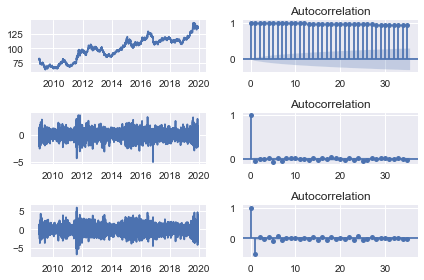

In [312]:
df = TLT_y_train.append(TLT_y_test)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2)
ax1.plot(df)
plot_acf(df, ax=ax2)

ax3.plot(df.diff().dropna())
plot_acf(df.diff().dropna(), ax=ax4)

ax5.plot(df.diff().diff().dropna())
plot_acf(df.diff().diff().dropna(), ax=ax6)
plt.tight_layout();

#### Model Selection

In [313]:
TLT_model = pm.auto_arima(df, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, m=1,
                          seasonal=True,start_P=0, D=0, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          trace=True,error_action='warn', suppress_warnings=True, stepwise=False, random_state=1, n_fits=500)

print(TLT_model.summary())

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=7028.208, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=7023.746, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=7025.741, Time=0.26 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=7027.274, Time=0.36 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=7029.262, Time=0.43 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=7017.321, Time=0.48 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=7023.735, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=7025.735, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=7027.738, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=7016.512, Time=1.02 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=7017.678, Time=1.34 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=7025.735, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=7027.735, Time=0.33 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=7016.091, Time=1.76 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=7017.916, Time=1.95 sec
 ARIMA(3,1

#### Model Evaluation

Residual

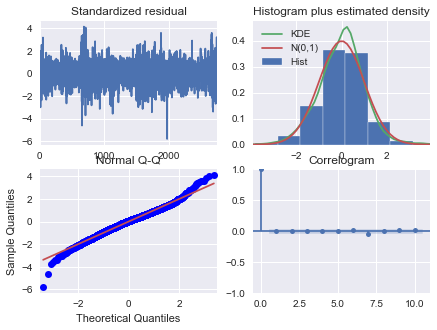

In [314]:
TLT_model.plot_diagnostics(figsize=(7,5))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Prediction Plot

In [315]:
history = [x for x in df]
model_predictions = []
N_test_observations = len(TLT_y_trade)- WINDOW_TLT
for time_point in range(N_test_observations):
    model_fit = TLT_model.fit(history)
    output = model_fit.predict(n_periods=WINDOW_TLT)
    yhat = output[-1]
    model_predictions.append(yhat)
    true_test_value = TLT_y_trade[time_point]
    history.append(true_test_value)

model_predictions = pd.Series(model_predictions, index=TLT_y_trade.index[WINDOW_TLT:])

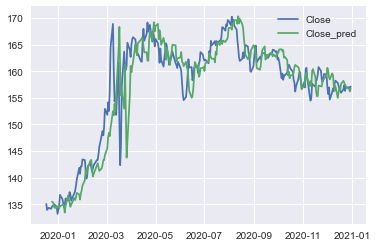

In [316]:
plt.plot(TLT_y_trade, label='Close')
plt.plot(model_predictions, label='Close_pred')
plt.legend();

Mean Squared Error

In [317]:
mean_squared_error(TLT_y_trade[WINDOW_TLT:], model_predictions)

16.673217106724834

Prediction Trading Report

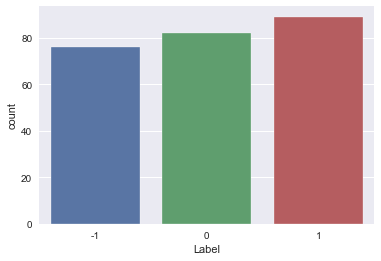

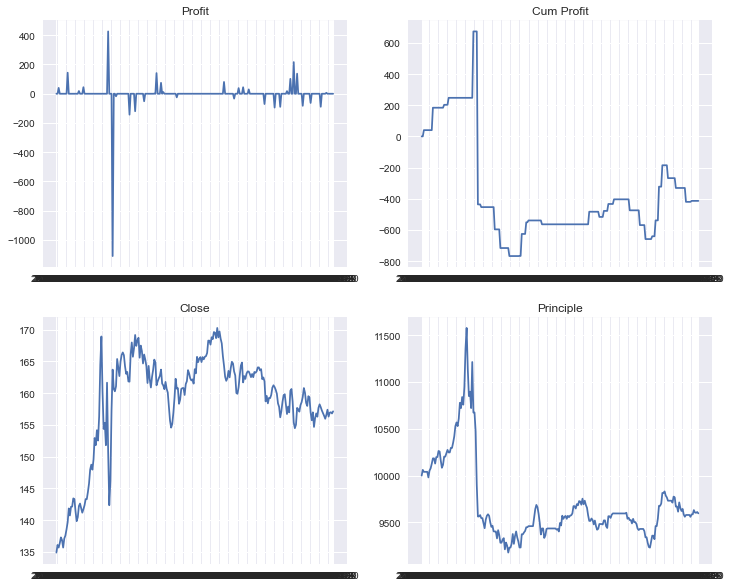

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  | -403.05 |  -4.03%  |    -4.60%    |   220    | -0.22  |
| Buy & Hold | 1134.02 |  11.34%  |    11.58%    |   247    |  0.83  |
+------------+---------+----------+--------------+----------+--------+


In [318]:
TLT_y_trade_pred_arima = TLT[(TLT.index >= trade_start) & (TLT.index <= trade_end)]
TLT_y_trade_pred_arima['Close_pred'] = model_predictions
TLT_y_trade_pred_arima.to_csv('data/processed/TLT_y_trade_pred_arima.csv')
TLT_y_trade_pred_arima = pd.read_csv('data/processed/TLT_y_trade_pred_arima.csv', index_col='Date')

# use Close_pred for meta-labeling
TLT_y_trade_pred_arima.drop(['Close'], axis=1,inplace=True)
TLT_y_trade_pred_arima.rename(columns={'Close_pred':'Close'}, inplace=True)
TLT_y_trade_pred_arima_labeling, _ = meta_labeling(TLT_y_trade_pred_arima, WINDOW=WINDOW_TLT, HORIZON=HORIZON_TLT, TP=TP_TLT, SL=SL_TLT * -1)
# reformat Close and Close_pred
TLT_y_trade_pred_arima_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
TLT_y_trade_pred_arima_labeling['Close'] = TLT_y_trade[trade_start:][WINDOW_TLT:].values

TLT_trading_log_trade_reg = get_trading_log(TLT_y_trade_pred_arima_labeling, principle=principle, percent=percent)
TLT_trading_log_trade_reg.to_csv('reports/TLT_trading_log_trade_arima.csv')
TLT_trading_log_trade_reg = pd.read_csv('reports/TLT_trading_log_trade_arima.csv', index_col='Date')
TLT_report_trade_reg, _ = get_trading_report(TLT_trading_log_trade_reg, show_fig=True)
print(TLT_report_trade_reg)

### USO

#### ACF

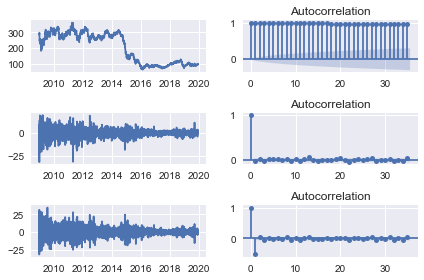

In [319]:
df = USO_y_train.append(USO_y_test)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2)
ax1.plot(df)
plot_acf(df, ax=ax2)

ax3.plot(df.diff().dropna())
plot_acf(df.diff().dropna(), ax=ax4)

ax5.plot(df.diff().diff().dropna())
plot_acf(df.diff().diff().dropna(), ax=ax6)
plt.tight_layout();

#### Model Selection

In [320]:
USO_model = pm.auto_arima(df, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, m=1,
                          seasonal=True,start_P=0, D=0, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          trace=True,error_action='warn', suppress_warnings=True, stepwise=False, random_state=1, n_fits=500)

print(USO_model.summary())

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=15674.000, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=15672.652, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=15674.642, Time=0.37 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=15675.641, Time=0.47 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=15676.178, Time=0.62 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=15677.788, Time=0.70 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=15672.638, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=15672.984, Time=0.73 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=15674.570, Time=0.92 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=15675.733, Time=1.31 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=15677.303, Time=2.26 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=15674.626, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=15676.629, Time=0.51 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=15676.233, Time=1.75 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=15677.730, Time=2.78

#### Model Evaluation

Residual

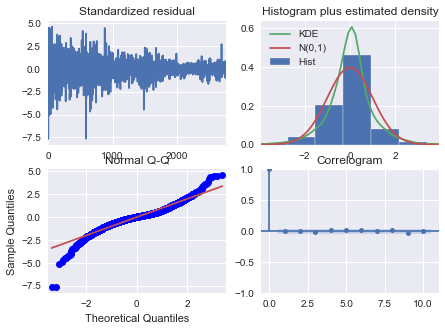

In [321]:
USO_model.plot_diagnostics(figsize=(7,5))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Prediction Plot

In [322]:
history = [x for x in df]
model_predictions = []
N_test_observations = len(USO_y_trade)- WINDOW_USO
for time_point in range(N_test_observations):
    model_fit = USO_model.fit(history)
    output = model_fit.predict(n_periods=WINDOW_USO)
    yhat = output[-1]
    model_predictions.append(yhat)
    true_test_value = USO_y_trade[time_point]
    history.append(true_test_value)

model_predictions = pd.Series(model_predictions, index=USO_y_trade.index[WINDOW_USO:])

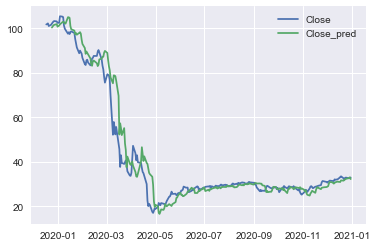

In [323]:
plt.plot(USO_y_trade, label='Close')
plt.plot(model_predictions, label='Close_pred')
plt.legend();

Mean Squared Error

In [324]:
mean_squared_error(USO_y_trade[WINDOW_USO:], model_predictions)

32.35186703737031

Prediction Trading Report

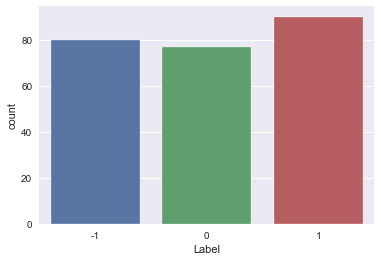

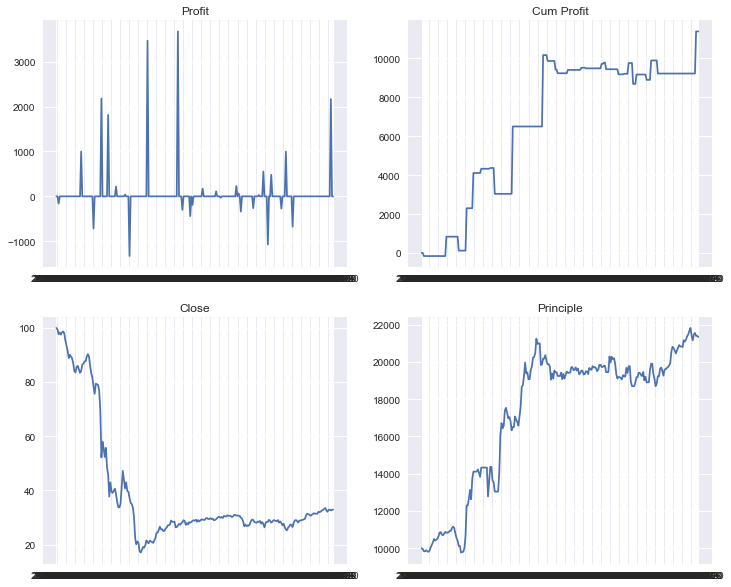

+------------+----------+----------+--------------+----------+--------+
|   Model    |  Profit  | Profit % | Annualized % | Duration | Sharpe |
+------------+----------+----------+--------------+----------+--------+
|  Strategy  | 11331.84 | 113.32%  |   124.56%    |   236    |  2.23  |
| Buy & Hold | -4690.7  | -46.91%  |   -47.58%    |   247    | -1.22  |
+------------+----------+----------+--------------+----------+--------+


In [325]:
USO_y_trade_pred_arima = USO[(USO.index >= trade_start) & (USO.index <= trade_end)]
USO_y_trade_pred_arima['Close_pred'] = model_predictions
USO_y_trade_pred_arima.to_csv('data/processed/USO_y_trade_pred_arima.csv')
USO_y_trade_pred_arima = pd.read_csv('data/processed/USO_y_trade_pred_arima.csv', index_col='Date')

# use Close_pred for meta-labeling
USO_y_trade_pred_arima.drop(['Close'], axis=1,inplace=True)
USO_y_trade_pred_arima.rename(columns={'Close_pred':'Close'}, inplace=True)
USO_y_trade_pred_arima_labeling, _ = meta_labeling(USO_y_trade_pred_arima, WINDOW=WINDOW_USO, HORIZON=HORIZON_USO, TP=TP_USO, SL=SL_USO * -1)
# reformat Close and Close_pred
USO_y_trade_pred_arima_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
USO_y_trade_pred_arima_labeling['Close'] = USO_y_trade[trade_start:][WINDOW_USO:].values

USO_trading_log_trade_reg = get_trading_log(USO_y_trade_pred_arima_labeling, principle=principle, percent=percent)
USO_trading_log_trade_reg.to_csv('reports/USO_trading_log_trade_arima.csv')
USO_trading_log_trade_reg = pd.read_csv('reports/USO_trading_log_trade_arima.csv', index_col='Date')
USO_report_trade_reg, _ = get_trading_report(USO_trading_log_trade_reg, show_fig=True)
print(USO_report_trade_reg)

## Regression - Prophet

### SPY

#### Formatting

In [71]:
df = SPY_y_train.append(SPY_y_test).append(SPY_y_trade)
df = df.reset_index()
df.columns = ['ds', 'y']

future = list(SPY_y_trade.index)[WINDOW_SPY:]
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

#### Model Evaluation

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds   yhat  yhat_lower  yhat_upper
0 2019-12-24 302.47      290.65      314.28
1 2019-12-26 302.37      289.62      313.72
2 2019-12-27 302.33      291.29      315.20
3 2019-12-30 302.35      290.72      314.15
4 2019-12-31 302.61      290.26      314.09


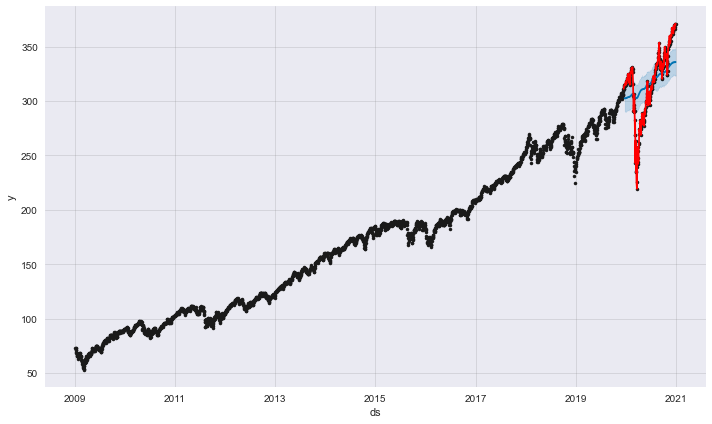

In [72]:
model = Prophet()
model.fit(df)
forecast = model.predict(future)

# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.plot(SPY_y_trade, color='red')
plt.show();

Mean Squared Error

In [73]:
mean_squared_error(SPY_y_trade[WINDOW_SPY:], forecast['yhat'])

613.0627586801457

Prediction Trading Report

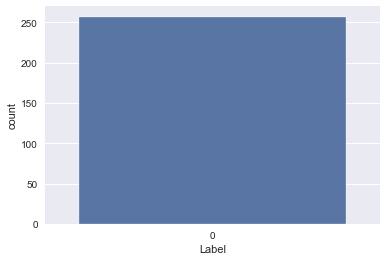

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

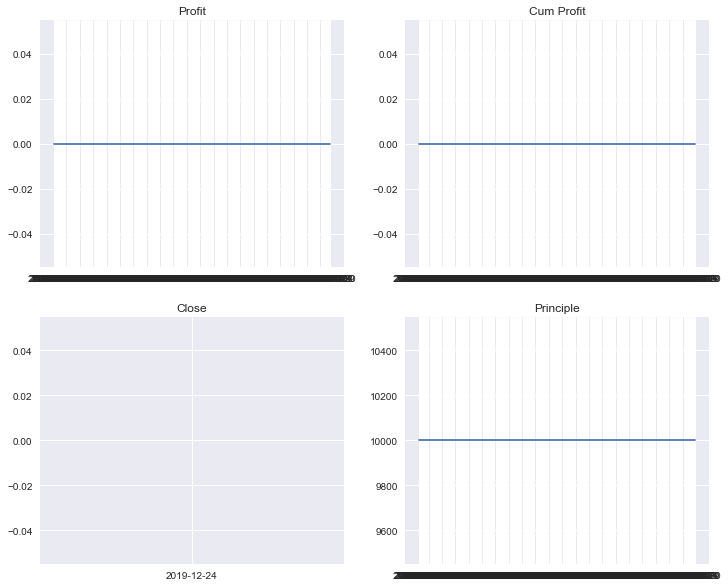

+------------+--------+----------+--------------+----------+--------+
|   Model    | Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+--------+----------+--------------+----------+--------+
|  Strategy  |   0    |  0.00%   |    0.00%     |    0     |  nan   |
| Buy & Hold |  nan   |   nan%   |     nan%     |   257    |  nan   |
+------------+--------+----------+--------------+----------+--------+


In [75]:
SPY_y_trade_pred_prophet = SPY[(SPY.index >= SPY_trade_start_actual) & (SPY.index <= trade_end)]
SPY_y_trade_pred_prophet['Close_pred'] = forecast['yhat'][WINDOW_SPY:]
SPY_y_trade_pred_prophet.to_csv('data/processed/SPY_y_trade_pred_prophet.csv')
SPY_y_trade_pred_prophet = pd.read_csv('data/processed/SPY_y_trade_pred_prophet.csv', index_col='Date')

# use Close_pred for meta-labeling
SPY_y_trade_pred_prophet.drop(['Close'], axis=1,inplace=True)
SPY_y_trade_pred_prophet.rename(columns={'Close_pred':'Close'}, inplace=True)
SPY_y_trade_pred_prophet_labeling, _ = meta_labeling(SPY_y_trade_pred_prophet, WINDOW=WINDOW_SPY, HORIZON=HORIZON_SPY, TP=TP_SPY, SL=SL_SPY * -1)
# reformat Close and Close_pred
SPY_y_trade_pred_prophet_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
SPY_y_trade_pred_prophet_labeling['Close'] = SPY_y_trade[-len(SPY_y_trade_pred_prophet_labeling):]

SPY_trading_log_trade_reg = get_trading_log(SPY_y_trade_pred_prophet_labeling, principle=principle, percent=percent)
SPY_trading_log_trade_reg.to_csv('reports/SPY_trading_log_trade_prophet.csv')
SPY_trading_log_trade_reg = pd.read_csv('reports/SPY_trading_log_trade_prophet.csv', index_col='Date')
SPY_report_trade_reg, _ = get_trading_report(SPY_trading_log_trade_reg, show_fig=True)
print(SPY_report_trade_reg)

### TLT

#### Formatting

In [76]:
df = TLT_y_train.append(TLT_y_test)
df = df.reset_index()
df.columns = ['ds', 'y']

future = list(TLT_y_trade.index)
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

#### Model Evaluation

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds   yhat  yhat_lower  yhat_upper
0 2019-12-17 129.75      124.93      135.23
1 2019-12-18 129.68      124.44      134.68
2 2019-12-19 129.57      124.82      134.42
3 2019-12-20 129.65      124.67      135.10
4 2019-12-23 129.44      124.46      134.49


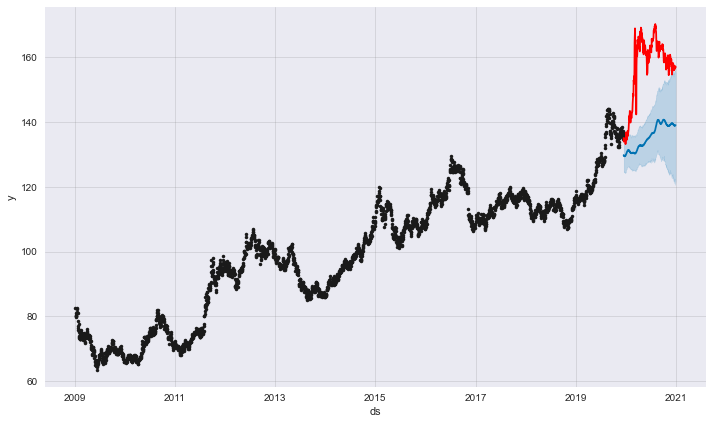

In [77]:
model = Prophet()
model.fit(df)
forecast = model.predict(future)

# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.plot(TLT_y_trade, color='red')
plt.show();

Mean Squared Error

In [78]:
mean_squared_error(TLT_y_trade, forecast['yhat'])

543.2075005986138

Prediction Trading Report

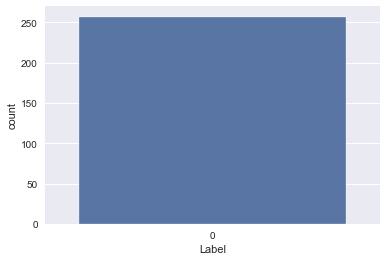

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

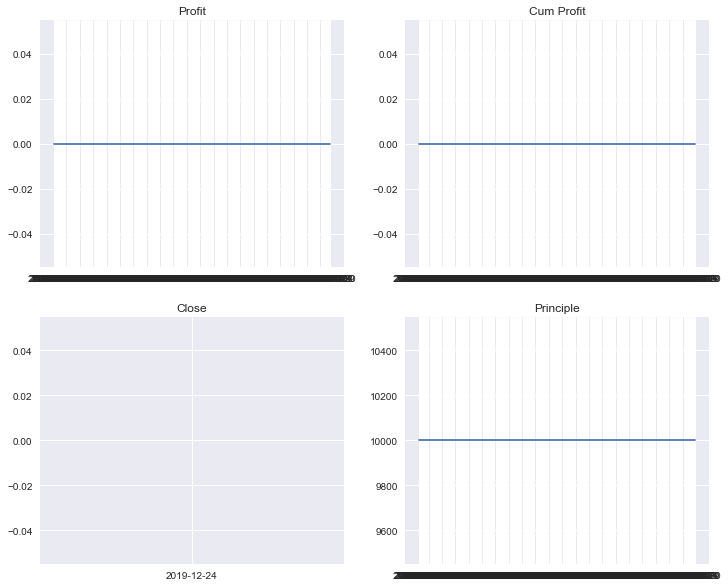

+------------+--------+----------+--------------+----------+--------+
|   Model    | Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+--------+----------+--------------+----------+--------+
|  Strategy  |   0    |  0.00%   |    0.00%     |    0     |  nan   |
| Buy & Hold |  nan   |   nan%   |     nan%     |   257    |  nan   |
+------------+--------+----------+--------------+----------+--------+


In [79]:
TLT_y_trade_pred_prophet = TLT[(TLT.index >= TLT_trade_start_actual) & (TLT.index <= trade_end)]
TLT_y_trade_pred_prophet['Close_pred'] = forecast['yhat']
TLT_y_trade_pred_prophet.to_csv('data/processed/TLT_y_trade_pred_prophet.csv')
TLT_y_trade_pred_prophet = pd.read_csv('data/processed/TLT_y_trade_pred_prophet.csv', index_col='Date')

# use Close_pred for meta-labeling
TLT_y_trade_pred_prophet.drop(['Close'], axis=1,inplace=True)
TLT_y_trade_pred_prophet.rename(columns={'Close_pred':'Close'}, inplace=True)
TLT_y_trade_pred_prophet_labeling, _ = meta_labeling(TLT_y_trade_pred_prophet, WINDOW=WINDOW_TLT, HORIZON=HORIZON_TLT, TP=TP_TLT, SL=SL_TLT * -1)
# reformat Close and Close_pred
TLT_y_trade_pred_prophet_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
TLT_y_trade_pred_prophet_labeling['Close'] = TLT_y_trade[-len(TLT_y_trade_pred_prophet_labeling):]

TLT_trading_log_trade_reg = get_trading_log(TLT_y_trade_pred_prophet_labeling, principle=principle, percent=percent)
TLT_trading_log_trade_reg.to_csv('reports/TLT_trading_log_trade_prophet.csv')
TLT_trading_log_trade_reg = pd.read_csv('reports/TLT_trading_log_trade_prophet.csv', index_col='Date')
TLT_report_trade_reg, _ = get_trading_report(TLT_trading_log_trade_reg, show_fig=True)
print(TLT_report_trade_reg)

### USO

#### Formatting

In [80]:
df = USO_y_train.append(USO_y_test)
df = df.reset_index()
df.columns = ['ds', 'y']

future = list(USO_y_trade.index)
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

#### Model Evaluation

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


          ds  yhat  yhat_lower  yhat_upper
0 2019-12-17 95.47       72.53      116.98
1 2019-12-18 95.56       74.24      116.76
2 2019-12-19 95.94       72.67      117.65
3 2019-12-20 95.88       74.90      118.99
4 2019-12-23 96.82       74.38      120.30


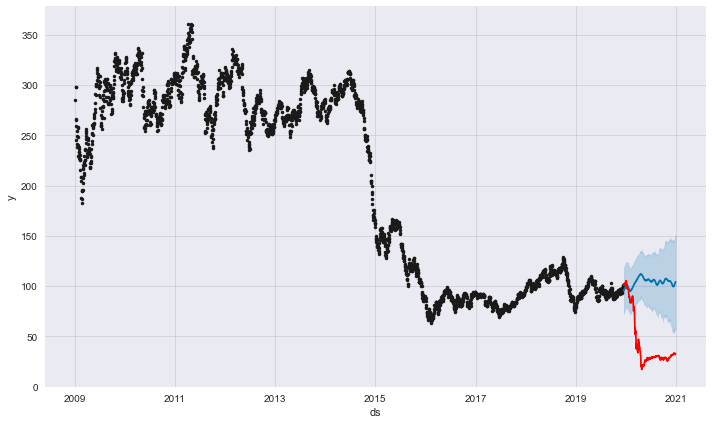

In [81]:
model = Prophet()
model.fit(df)
forecast = model.predict(future)

# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
plt.plot(USO_y_trade, color='red')
plt.show();

Mean Squared Error

In [82]:
mean_squared_error(USO_y_trade, forecast['yhat'])

4572.460695459874

Prediction Trading Report

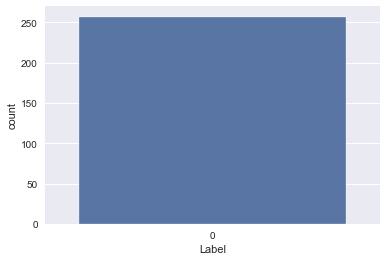

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

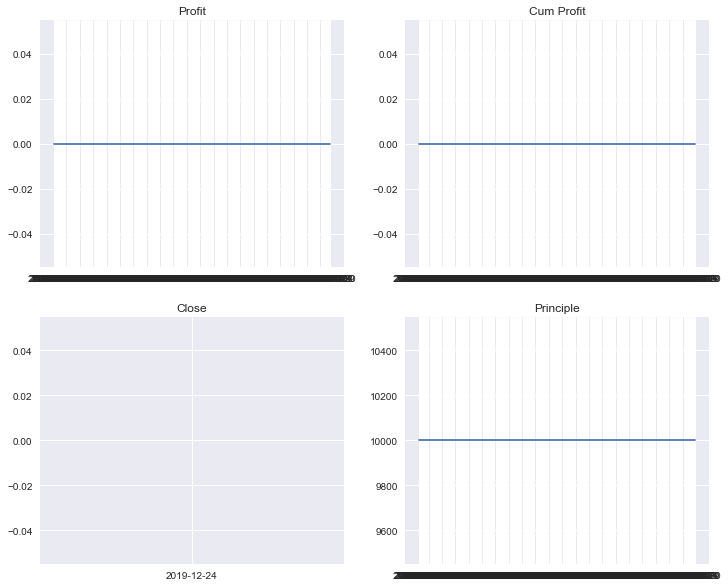

+------------+--------+----------+--------------+----------+--------+
|   Model    | Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+--------+----------+--------------+----------+--------+
|  Strategy  |   0    |  0.00%   |    0.00%     |    0     |  nan   |
| Buy & Hold |  nan   |   nan%   |     nan%     |   257    |  nan   |
+------------+--------+----------+--------------+----------+--------+


In [83]:
USO_y_trade_pred_prophet = USO[(USO.index >= USO_trade_start_actual) & (USO.index <= trade_end)]
USO_y_trade_pred_prophet['Close_pred'] = forecast['yhat']
USO_y_trade_pred_prophet.to_csv('data/processed/USO_y_trade_pred_prophet.csv')
USO_y_trade_pred_prophet = pd.read_csv('data/processed/USO_y_trade_pred_prophet.csv', index_col='Date')

# use Close_pred for meta-labeling
USO_y_trade_pred_prophet.drop(['Close'], axis=1,inplace=True)
USO_y_trade_pred_prophet.rename(columns={'Close_pred':'Close'}, inplace=True)
USO_y_trade_pred_prophet_labeling, _ = meta_labeling(USO_y_trade_pred_prophet, WINDOW=WINDOW_USO, HORIZON=HORIZON_USO, TP=TP_USO, SL=SL_USO * -1)
# reformat Close and Close_pred
USO_y_trade_pred_prophet_labeling.rename(columns={'Close':'Close_pred'}, inplace=True)
USO_y_trade_pred_prophet_labeling['Close'] = USO_y_trade[-len(USO_y_trade_pred_prophet_labeling):]

USO_trading_log_trade_reg = get_trading_log(USO_y_trade_pred_prophet_labeling, principle=principle, percent=percent)
USO_trading_log_trade_reg.to_csv('reports/USO_trading_log_trade_prophet.csv')
USO_trading_log_trade_reg = pd.read_csv('reports/USO_trading_log_trade_prophet.csv', index_col='Date')
USO_report_trade_reg, _ = get_trading_report(USO_trading_log_trade_reg, show_fig=True)
print(USO_report_trade_reg)

## Reinforcement Learning

### Formatting

In [205]:
for i in SPY.columns:
    if i in SPY_selected_cols:
        SPY_selected_cols.remove(i)
SPY_train = rl_formatting(SPY_X_train_final.append(SPY_X_test_final), SPY, 'SPY')
SPY_train.tail()

date  DTB1YR   BOGMBASE  TEDRATE  volatility_-5  volatility_-10  \
2753  2019-12-10    1.56 3252830.00     0.34           2.69            4.76   
2754  2019-12-11    1.53 3252830.00     0.32           2.45            4.56   
2755  2019-12-12    1.52 3315603.00     0.32           2.25            4.39   
2756  2019-12-13    1.52 3315603.00     0.35           2.38            4.39   
2757  2019-12-16    1.53 3315603.00     0.33           2.26            4.29   

      volatility_-60  close_-10_r  close_-20_r  close_-60_r  ...  rsi_20  \
2753           11.66        -0.79         0.71         4.29  ...   56.04   
2754           11.69        -0.15         1.44         4.95  ...   59.20   
2755           11.73         0.40         1.60         4.40  ...   60.08   
2756           11.82         1.48         2.17         4.99  ...   64.23   
2757           11.88         0.94         1.60         4.73  ...   61.88   

      rsi_60  rsi_120   open   high    low  close    volume  tic  day  
2753   56.31    55.06 305.56 306.27 304.58 305.28  52649800  SPY    1  
2754   57.18    55.48 305.76 306.42 305.19 306.14  53429100  SPY    2  
2755   57.43    55.60 306.15 309.62 305.90 308.78  96389600  SPY    3  
2756   58.70    56.23 308.53 310.28 307.70 308.97  81503900  SPY    4  
2757   58.09    55.95 310.82 311.72 308.90 311.09  82749700  SPY    0  

[5 rows x 36 columns]

In [206]:
for i in TLT.columns:
    if i in TLT_selected_cols:
        TLT_selected_cols.remove(i)
TLT_train = rl_formatting(TLT_X_train_final.append(TLT_X_test_final), TLT, 'TLT')
TLT_train.tail()

date      GDP  DTB1YR   BOGMBASE  volatility_-5  volatility_-60  \
2753  2019-12-10 21525.82    1.56 3252830.00           1.58            7.15   
2754  2019-12-11 21525.82    1.53 3252830.00           1.45            7.10   
2755  2019-12-12 21525.82    1.52 3315603.00           1.33            7.05   
2756  2019-12-13 21525.82    1.52 3315603.00           1.30            6.99   
2757  2019-12-16 21525.82    1.53 3315603.00           1.21            6.94   

      close_-5_r  close_-10_r  close_-20_r  close_-60_r  ...  cci_5  dx_5  \
2753        0.81         2.49         1.98        -0.87  ...  73.49 37.58   
2754       -0.77         0.63         2.11        -0.11  ...  -8.40 12.91   
2755       -0.97        -0.88         1.00        -0.42  ... -51.17  8.04   
2756       -1.30        -0.81         2.29        -0.32  ... -67.81 31.25   
2757        0.25        -0.72         2.95         2.08  ... -53.96 31.25   

      dx_60   open   high    low  close    volume  tic  day  
2753   7.80 136.60 136.77 135.85 136.09   4947600  TLT    1  
2754   5.09 136.72 137.54 136.65 137.16   6256700  TLT    2  
2755   2.82 136.61 136.70 134.08 134.90  14857000  TLT    3  
2756   0.10 135.56 137.02 134.69 136.46  11335100  TLT    4  
2757   0.10 135.84 135.89 134.88 135.24   9156600  TLT    0  

[5 rows x 36 columns]

In [207]:
for i in USO.columns:
    if i in USO_selected_cols:
        USO_selected_cols.remove(i)
USO_train = rl_formatting(USO_X_train_final.append(USO_X_test_final), USO, 'USO')
USO_train.tail()

date      GDP  DTB1YR  DTB3   BOGMBASE  TEDRATE  volatility_-5  \
2753  2019-12-10 21525.82    1.56  1.57 3252830.00     0.34           1.88   
2754  2019-12-11 21525.82    1.53  1.54 3252830.00     0.32           1.97   
2755  2019-12-12 21525.82    1.52  1.52 3315603.00     0.32           1.97   
2756  2019-12-13 21525.82    1.52  1.51 3315603.00     0.35           2.09   
2757  2019-12-16 21525.82    1.53  1.50 3315603.00     0.33           2.12   

      volatility_-60  volatility_-120  close_-5_r  ...  cci_5  dx_5  dx_60  \
2753            4.79             7.91       -2.89  ... -47.74 44.93   3.56   
2754            4.77             7.88        0.00  ...  89.22 46.46   5.02   
2755            4.75             7.84        0.41  ...  92.89 56.91   7.06   
2756            4.75             7.82        6.02  ...  76.44 70.06  10.06   
2757            4.74             7.79        5.66  ...  67.04 70.06  10.06   

       open   high    low  close   volume  tic  day  
2753  98.48  99.44  98.16  99.12  1284188  USO    1  
2754  98.64  98.96  97.12  98.40  1918325  USO    2  
2755  98.40  99.76  98.40  98.96  2787500  USO    3  
2756  99.28 101.04  99.12  99.92  2137638  USO    4  
2757 100.64 100.96 100.48 100.72   801663  USO    0  

[5 rows x 36 columns]

### Models

In [208]:
class DRLAgent:
    """Provides implementations for DRL algorithms

    Attributes
    ----------
        env: gym environment class
            user-defined class

    Methods
    -------
        train_PPO()
            the implementation for PPO algorithm
        train_A2C()
            the implementation for A2C algorithm
        train_DDPG()
            the implementation for DDPG algorithm
        train_TD3()
            the implementation for TD3 algorithm
        train_SAC()
            the implementation for SAC algorithm
        DRL_prediction()
            make a prediction in a test dataset and get results
    """

    @staticmethod
    def DRL_prediction(model, environment):
        test_env, test_obs = environment.get_sb_env()
        """make a prediction"""
        account_memory = []
        actions_memory = []
        test_env.reset()
        for i in range(len(environment.df.index.unique())):
            action, _states = model.predict(test_obs)
            #account_memory = test_env.env_method(method_name="save_asset_memory")
            #actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)
            if i == (len(environment.df.index.unique()) - 2):
              account_memory = test_env.env_method(method_name="save_asset_memory")
              actions_memory = test_env.env_method(method_name="save_action_memory")
            if dones[0]:
                print("hit end!")
                break
        return account_memory[0], actions_memory[0]

    def __init__(self, env):
        self.env = env

    def get_model(
        self,
        model_name,
        policy="MlpPolicy",
        policy_kwargs=None,
        model_kwargs=None,
        verbose=1,
    ):
        if model_name not in MODELS:
            raise NotImplementedError("NotImplementedError")

        if model_kwargs is None:
            model_kwargs = MODEL_KWARGS[model_name]

        if "action_noise" in model_kwargs:
            n_actions = self.env.action_space.shape[-1]
            model_kwargs["action_noise"] = NOISE[model_kwargs["action_noise"]](
                mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
            )
        print(model_kwargs)
        model = MODELS[model_name](
            policy=policy,
            env=self.env,
            tensorboard_log=f"tensorboard_log/{model_name}",
            verbose=verbose,
            policy_kwargs=policy_kwargs,
            **model_kwargs,
        )
        return model

    def train_model(self, model, tb_log_name, total_timesteps=5000):
        model = model.learn(total_timesteps=total_timesteps, tb_log_name=tb_log_name)
        return model

In [209]:
MODELS = {"a2c": A2C, "ddpg": DDPG, "td3": TD3, "sac": SAC, "ppo": PPO}

MODEL_KWARGS = {"a2c": {"n_steps": 5,
                        "ent_coef": 0.01,
                        "learning_rate": 0.0005},
                "ppo": {"n_steps": 2048,
                        "ent_coef": 0.01,
                        "learning_rate": 0.00001,
                        "batch_size": 128,},
                "ddpg": {"batch_size": 128,
                         "buffer_size": 1000000,
                         "learning_rate": 0.000005},
                "td3": {"batch_size": 100,
                        "buffer_size": 1000000,
                        "learning_rate": 0.00025},
                "sac": {"batch_size": 256,
                        "buffer_size": 1000000,
                        "learning_rate": 0.00005,
                        "learning_starts": 100,
                        "batch_size": 64,
                        "ent_coef": "auto_0.1",}}

### SPY

#### A2C

In [35]:
e_train_gym = create_env(SPY_train, SPY_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 31
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [36]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cuda device


In [37]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=100000)

Logging to tensorboard_log/a2c\a2c_16
------------------------------------
| time/                 |          |
|    fps                | 219      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.51    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | -0.00125 |
|    std                | 1.09     |
|    value_loss         | 1.56e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 263      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.55    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 199      |


------------------------------------
| time/                 |          |
|    fps                | 303      |
|    iterations         | 1500     |
|    time_elapsed       | 24       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -1.89    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | 0.0691   |
|    std                | 1.61     |
|    value_loss         | 0.00291  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 301      |
|    iterations         | 1600     |
|    time_elapsed       | 26       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -1.92    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 1599     |
|    policy_loss        | 0.0828   |
|

-------------------------------------
| time/                 |           |
|    fps                | 307       |
|    iterations         | 2900      |
|    time_elapsed       | 47        |
|    total_timesteps    | 14500     |
| train/                |           |
|    entropy_loss       | -2.49     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 2899      |
|    policy_loss        | -0.00496  |
|    std                | 2.92      |
|    value_loss         | 1.12e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 308      |
|    iterations         | 3000     |
|    time_elapsed       | 48       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -2.54    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 309      |
|    iterations         | 4300     |
|    time_elapsed       | 69       |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -3.17    |
|    explained_variance | -3.01    |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | 0.00718  |
|    std                | 5.77     |
|    value_loss         | 8.89e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 310      |
|    iterations         | 4400     |
|    time_elapsed       | 70       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -3.22    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4399     |
|    policy_loss        | 0.00821  |
|

------------------------------------
| time/                 |          |
|    fps                | 312      |
|    iterations         | 5700     |
|    time_elapsed       | 91       |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -3.87    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5699     |
|    policy_loss        | -0.00092 |
|    std                | 11.6     |
|    value_loss         | 7.32e-08 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 313       |
|    iterations         | 5800      |
|    time_elapsed       | 92        |
|    total_timesteps    | 29000     |
| train/                |           |
|    entropy_loss       | -3.92     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5799      |
|    policy_loss        | 0

-------------------------------------
| time/                 |           |
|    fps                | 314       |
|    iterations         | 7100      |
|    time_elapsed       | 112       |
|    total_timesteps    | 35500     |
| train/                |           |
|    entropy_loss       | -4.54     |
|    explained_variance | -0.0772   |
|    learning_rate      | 0.0005    |
|    n_updates          | 7099      |
|    policy_loss        | -0.000605 |
|    std                | 22.7      |
|    value_loss         | 4.77e-07  |
-------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 1.38e+04  |
|    total_cost         | 0         |
|    total_reward       | 3.76e+03  |
|    total_reward_pct   | 37.6      |
|    total_trades       | 2537      |
| time/                 |           |
|    fps                | 314       |
|    iterations         | 7200      |
|    time_elapsed       | 114       |
|    total_t

------------------------------------
| time/                 |          |
|    fps                | 315      |
|    iterations         | 8500     |
|    time_elapsed       | 134      |
|    total_timesteps    | 42500    |
| train/                |          |
|    entropy_loss       | -5.22    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 8499     |
|    policy_loss        | -0.156   |
|    std                | 44.5     |
|    value_loss         | 0.00103  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 315      |
|    iterations         | 8600     |
|    time_elapsed       | 136      |
|    total_timesteps    | 43000    |
| train/                |          |
|    entropy_loss       | -5.26    |
|    explained_variance | 1.79e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 8599     |
|    policy_loss        | 0.0758   |
|

------------------------------------
| time/                 |          |
|    fps                | 315      |
|    iterations         | 9900     |
|    time_elapsed       | 156      |
|    total_timesteps    | 49500    |
| train/                |          |
|    entropy_loss       | -5.85    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 9899     |
|    policy_loss        | 0.0256   |
|    std                | 84       |
|    value_loss         | 3.78e-05 |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 1.4e+04   |
|    total_cost         | 0         |
|    total_reward       | 4e+03     |
|    total_reward_pct   | 40        |
|    total_trades       | 2726      |
| time/                 |           |
|    fps                | 315       |
|    iterations         | 10000     |
|    time_elapsed       | 158       |
|    total_timesteps    | 5

-------------------------------------
| time/                 |           |
|    fps                | 315       |
|    iterations         | 11300     |
|    time_elapsed       | 178       |
|    total_timesteps    | 56500     |
| train/                |           |
|    entropy_loss       | -6.48     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 11299     |
|    policy_loss        | 0.000342  |
|    std                | 159       |
|    value_loss         | 4.69e-07  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 315      |
|    iterations         | 11400    |
|    time_elapsed       | 180      |
|    total_timesteps    | 57000    |
| train/                |          |
|    entropy_loss       | -6.53    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 11399    |
|    policy_loss       

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.48e+04 |
|    total_cost         | 0        |
|    total_reward       | 4.77e+03 |
|    total_reward_pct   | 47.7     |
|    total_trades       | 2699     |
| time/                 |          |
|    fps                | 316      |
|    iterations         | 12700    |
|    time_elapsed       | 200      |
|    total_timesteps    | 63500    |
| train/                |          |
|    entropy_loss       | -7.1     |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 12699    |
|    policy_loss        | 0.00275  |
|    std                | 293      |
|    value_loss         | 2.34e-07 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 316      |
|    iterations         | 12800    |
|    time_elapsed       | 202      |
|    total_timesteps    | 64000    |
|

-------------------------------------
| time/                 |           |
|    fps                | 315       |
|    iterations         | 14100     |
|    time_elapsed       | 223       |
|    total_timesteps    | 70500     |
| train/                |           |
|    entropy_loss       | -7.71     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 14099     |
|    policy_loss        | 0.00599   |
|    std                | 539       |
|    value_loss         | 7.7e-07   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 315      |
|    iterations         | 14200    |
|    time_elapsed       | 224      |
|    total_timesteps    | 71000    |
| train/                |          |
|    entropy_loss       | -7.76    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 14199    |
|    policy_loss       

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.33e+04 |
|    total_cost         | 0        |
|    total_reward       | 3.3e+03  |
|    total_reward_pct   | 33       |
|    total_trades       | 2706     |
| time/                 |          |
|    fps                | 316      |
|    iterations         | 15500    |
|    time_elapsed       | 245      |
|    total_timesteps    | 77500    |
| train/                |          |
|    entropy_loss       | -8.38    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 15499    |
|    policy_loss        | 0.00676  |
|    std                | 1.05e+03 |
|    value_loss         | 6.86e-06 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 316       |
|    iterations         | 15600     |
|    time_elapsed       | 246       |
|    total_timesteps    | 78000  

------------------------------------
| time/                 |          |
|    fps                | 316      |
|    iterations         | 16900    |
|    time_elapsed       | 267      |
|    total_timesteps    | 84500    |
| train/                |          |
|    entropy_loss       | -9       |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 16899    |
|    policy_loss        | 0.00412  |
|    std                | 1.96e+03 |
|    value_loss         | 0.0001   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 316      |
|    iterations         | 17000    |
|    time_elapsed       | 268      |
|    total_timesteps    | 85000    |
| train/                |          |
|    entropy_loss       | -9.04    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 16999    |
|    policy_loss        | 0.0336   |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 2.15e+04 |
|    total_cost         | 0        |
|    total_reward       | 1.15e+04 |
|    total_reward_pct   | 115      |
|    total_trades       | 2733     |
| time/                 |          |
|    fps                | 316      |
|    iterations         | 18300    |
|    time_elapsed       | 289      |
|    total_timesteps    | 91500    |
| train/                |          |
|    entropy_loss       | -9.56    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 18299    |
|    policy_loss        | -0.00168 |
|    std                | 3.43e+03 |
|    value_loss         | 3.97e-08 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 316      |
|    iterations         | 18400    |
|    time_elapsed       | 290      |
|    total_timesteps    | 92000    |
|

------------------------------------
| time/                 |          |
|    fps                | 316      |
|    iterations         | 19700    |
|    time_elapsed       | 311      |
|    total_timesteps    | 98500    |
| train/                |          |
|    entropy_loss       | -10.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 19699    |
|    policy_loss        | 0.0321   |
|    std                | 6.15e+03 |
|    value_loss         | 2.56e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 316      |
|    iterations         | 19800    |
|    time_elapsed       | 313      |
|    total_timesteps    | 99000    |
| train/                |          |
|    entropy_loss       | -10.2    |
|    explained_variance | -0.0235  |
|    learning_rate      | 0.0005   |
|    n_updates          | 19799    |
|    policy_loss        | 0.269    |
|

In [44]:
trained_a2c.save("models\SPY_a2c")
trained_a2c = A2C.load("models\SPY_a2c")

#### DDPG

In [449]:
e_train_gym = create_env(SPY_train, SPY_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 23


In [454]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 5e-06}
Using cuda device


In [455]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=100000)

Logging to tensorboard_log/ddpg\ddpg_8
day: 2767, episode: 40
begin_total_asset: 10000.00
end_total_asset: 43576.34
total_reward: 33576.34
total_cost: 0.00
total_trades: 137
Sharpe: 1.007
----------------------------------
| environment/        |          |
|    portfolio_value  | 4.41e+04 |
|    total_cost       | 0        |
|    total_reward     | 3.41e+04 |
|    total_reward_pct | 341      |
|    total_trades     | 2411     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 177      |
|    time_elapsed     | 62       |
|    total timesteps  | 11072    |
| train/              |          |
|    actor_loss       | -9.73    |
|    critic_loss      | 0.1      |
|    learning_rate    | 5e-06    |
|    n_updates        | 8304     |
----------------------------------
----------------------------------
| environment/        |          |
|    portfolio_value  | 4.41e+04 |
|    total_cost       | 0        |
|    total_reward     | 3.41e+04 |
|    to

In [514]:
trained_ddpg.save("models\SPY_ddpg")
trained_ddpg = DDPG.load("models\SPY_ddpg")

#### PPO

In [34]:
len(SPY_train.columns)

Index(['date', 'DTB1YR', 'BOGMBASE', 'TEDRATE', 'volatility_-5',
       'volatility_-10', 'volatility_-60', 'close_-10_r', 'close_-20_r',
       'close_-60_r', 'close_-120_r', 'volume_-5_r', 'volume_-10_r',
       'volume_-20_r', 'volume_-60_r', 'volume_-120_r', 'volume_-3,-2,-1_max',
       'volume_-10_max_r', 'volume_-20_max_r', 'volume_-60_max_r',
       'volume_-120_max_r', 'kdjk', 'dma', 'boll_ub_r', 'boll_lb_r', 'rsi_5',
       'rsi_20', 'rsi_60', 'rsi_120', 'open', 'high', 'low', 'close', 'volume',
       'tic', 'day'],
      dtype='object')

In [449]:
e_train_gym = create_env(SPY_train, SPY_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 23


In [478]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [479]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

Logging to tensorboard_log/ppo\ppo_6
-----------------------------
| time/              |      |
|    fps             | 513  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| environment/            |               |
|    portfolio_value      | 1.97e+04      |
|    total_cost           | 0             |
|    total_reward         | 9.74e+03      |
|    total_reward_pct     | 97.4          |
|    total_trades         | 901           |
| time/                   |               |
|    fps                  | 461           |
|    iterations           | 2             |
|    time_elapsed         | 8             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00045879962 |
|    clip_fraction        | 0.0133        |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.29e+04    |
|    total_cost           | 0           |
|    total_reward         | 2.29e+04    |
|    total_reward_pct     | 229         |
|    total_trades         | 912         |
| time/                   |             |
|    fps                  | 378         |
|    iterations           | 10          |
|    time_elapsed         | 54          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.005307589 |
|    clip_fraction        | 0.0334      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0.406       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0344     |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00791    |
|    std                  | 0.981       |
|    value_loss           | 0.0023

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.71e+04    |
|    total_cost           | 0           |
|    total_reward         | 2.71e+04    |
|    total_reward_pct     | 271         |
|    total_trades         | 955         |
| time/                   |             |
|    fps                  | 365         |
|    iterations           | 18          |
|    time_elapsed         | 100         |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.005364822 |
|    clip_fraction        | 0.0559      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.22        |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0459     |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0125     |
|    std                  | 0.961       |
|    value_loss           | 0.0018

------------------------------------------
| time/                   |              |
|    fps                  | 361          |
|    iterations           | 27           |
|    time_elapsed         | 153          |
|    total_timesteps      | 55296        |
| train/                  |              |
|    approx_kl            | 0.0055938317 |
|    clip_fraction        | 0.0516       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.0936       |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0205      |
|    n_updates            | 260          |
|    policy_gradient_loss | -0.00808     |
|    std                  | 0.962        |
|    value_loss           | 0.00224      |
------------------------------------------
------------------------------------------
| environment/            |              |
|    portfolio_value      | 3.81e+04     |
|    total_cost           | 0            |
|    total_

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 3.98e+04    |
|    total_cost           | 0           |
|    total_reward         | 2.98e+04    |
|    total_reward_pct     | 298         |
|    total_trades         | 1071        |
| time/                   |             |
|    fps                  | 358         |
|    iterations           | 36          |
|    time_elapsed         | 205         |
|    total_timesteps      | 73728       |
| train/                  |             |
|    approx_kl            | 0.010249132 |
|    clip_fraction        | 0.0937      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0.0144      |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0245     |
|    n_updates            | 350         |
|    policy_gradient_loss | -0.0128     |
|    std                  | 0.976       |
|    value_loss           | 0.0016

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 4.07e+04    |
|    total_cost           | 0           |
|    total_reward         | 3.07e+04    |
|    total_reward_pct     | 307         |
|    total_trades         | 1172        |
| time/                   |             |
|    fps                  | 356         |
|    iterations           | 45          |
|    time_elapsed         | 258         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.013037695 |
|    clip_fraction        | 0.0975      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.155       |
|    learning_rate        | 0.00025     |
|    loss                 | -0.0333     |
|    n_updates            | 440         |
|    policy_gradient_loss | -0.0148     |
|    std                  | 0.948       |
|    value_loss           | 0.0018

In [515]:
trained_ppo.save("models\SPY_ppo")
trained_ppo = PPO.load("models\SPY_ppo")

#### TD3

In [64]:
e_train_gym = create_env(SPY_train, SPY_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 23
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [65]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.0001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.0001}
Using cuda device


In [66]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=100000)

Logging to tensorboard_log/td3\td3_8
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+04    |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 165      |
|    time_elapsed     | 66       |
|    total timesteps  | 11052    |
| train/              |          |
|    actor_loss       | 157      |
|    critic_loss      | 32.2     |
|    learning_rate    | 0.0001   |
|    n_updates        | 8289     |
----------------------------------
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+04    |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 8        |
|    fps          

In [58]:
# trained_td3.save("models\SPY_td3")
trained_td3 = TD3.load("models\SPY_td3")

#### SAC

In [449]:
e_train_gym = create_env(SPY_train, SPY_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 23


In [491]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [492]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100000)

Logging to tensorboard_log/sac\sac_11
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+04    |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 78       |
|    time_elapsed     | 141      |
|    total timesteps  | 11072    |
| train/              |          |
|    actor_loss       | 265      |
|    critic_loss      | 2.19     |
|    ent_coef         | 0.299    |
|    ent_coef_loss    | 38.5     |
|    learning_rate    | 0.0001   |
|    n_updates        | 10971    |
----------------------------------
day: 2767, episode: 280
begin_total_asset: 10000.00
end_total_asset: 10000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+04    |
|    total_cost       | 0  

In [517]:
trained_sac.save("models\SPY_sac")
trained_sac = SAC.load("models\SPY_sac")

#### Model Evaluation

In [38]:
SPY_trade = rl_formatting(SPY_X_trade_final, SPY, 'SPY')
e_trade_gym = create_env(SPY_trade, SPY_selected_cols)

Stock Dimension: 1, State Space: 31


In [39]:
model = trained_a2c
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model, environment = e_trade_gym)

hit end!


In [40]:
df_account_value.head()

date  account_value
0  <bound method _pandas_date of date            ...       10000.00
1  <bound method _pandas_date of date            ...       10000.00
2  <bound method _pandas_date of date            ...       10001.28
3  <bound method _pandas_date of date            ...       10001.28
4  <bound method _pandas_date of date            ...       10001.28

In [41]:
y_trade_pred = [0]
for i in range(len(df_actions)):
    y_trade_pred.append(df_actions.iloc[i,1][0])
print(y_trade_pred)

[0, 0, 1, -1, 0, 1, -1, 0, 0, 0, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 0, 1, 1, -1, -1, 0, 0, 0, 1, 1, -1, 1, -1, -1, 0, 1, -1, 1, -1, 0, 1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 0, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, 0, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1]


Prediction Trading Report

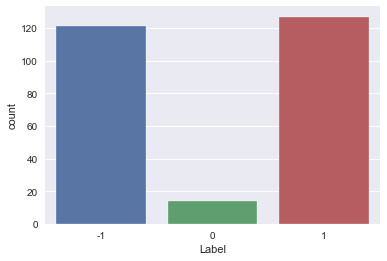

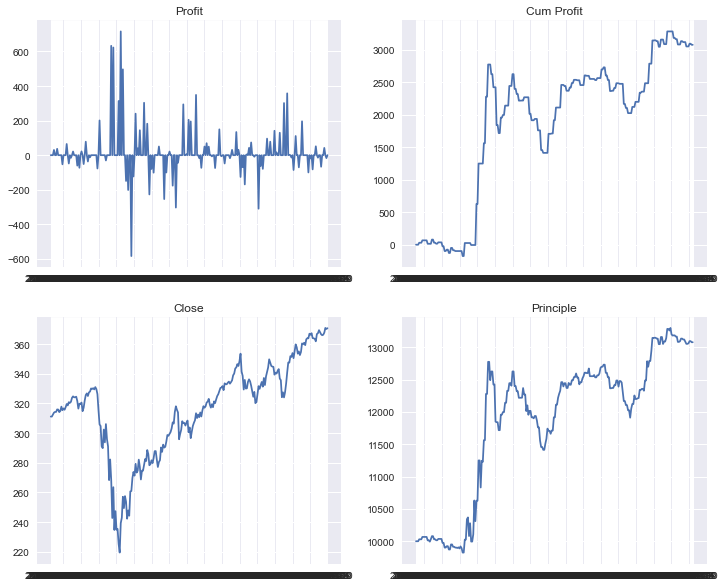

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  | 3078.78 |  30.79%  |    30.24%    |   256    |  1.56  |
| Buy & Hold |  1311.6 |  13.12%  |    12.59%    |   262    |  0.68  |
+------------+---------+----------+--------------+----------+--------+


In [42]:
SPY_y_trade_pred_rl = SPY[(SPY.index >= SPY_trade_start_actual) & (SPY.index <= trade_end)]
SPY_y_trade_pred_rl['Label'] = y_trade_pred
SPY_y_trade_pred_rl.to_csv('data/processed/SPY_y_trade_pred_rl.csv')
SPY_y_trade_pred_rl = pd.read_csv('data/processed/SPY_y_trade_pred_rl.csv', index_col='Date')

SPY_trading_log_trade_rl = get_trading_log(SPY_y_trade_pred_rl, principle=principle, percent=percent)
SPY_trading_log_trade_rl.to_csv('reports/SPY_trading_log_trade_rl.csv')
SPY_trading_log_trade_rl = pd.read_csv('reports/SPY_trading_log_trade_rl.csv', index_col='Date')
SPY_report_trade_rl, _ = get_trading_report(SPY_trading_log_trade_rl, show_fig=True)
print(SPY_report_trade_rl)

### TLT

#### A2C

In [210]:
e_train_gym = create_env(TLT_train, TLT_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 31
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [211]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cuda device


In [212]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=100000)

Logging to tensorboard_log/a2c\a2c_20
------------------------------------
| time/                 |          |
|    fps                | 325      |
|    iterations         | 100      |
|    time_elapsed       | 1        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.46    |
|    explained_variance | -560     |
|    learning_rate      | 0.0005   |
|    n_updates          | 99       |
|    policy_loss        | 0.0142   |
|    std                | 1.04     |
|    value_loss         | 0.000312 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 328      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.49    |
|    explained_variance | 0.0178   |
|    learning_rate      | 0.0005   |
|    n_updates          | 199      |


------------------------------------
| time/                 |          |
|    fps                | 326      |
|    iterations         | 1500     |
|    time_elapsed       | 22       |
|    total_timesteps    | 7500     |
| train/                |          |
|    entropy_loss       | -1.84    |
|    explained_variance | 0.301    |
|    learning_rate      | 0.0005   |
|    n_updates          | 1499     |
|    policy_loss        | -0.112   |
|    std                | 1.53     |
|    value_loss         | 0.00619  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 326      |
|    iterations         | 1600     |
|    time_elapsed       | 24       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -1.87    |
|    explained_variance | 0.212    |
|    learning_rate      | 0.0005   |
|    n_updates          | 1599     |
|    policy_loss        | -0.00965 |
|

------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 2900     |
|    time_elapsed       | 44       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -2.24    |
|    explained_variance | -0.00686 |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | -0.0084  |
|    std                | 2.26     |
|    value_loss         | 7.82e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 3000     |
|    time_elapsed       | 45       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -2.27    |
|    explained_variance | -3.74    |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss        | 0.00438  |
|

------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 4300     |
|    time_elapsed       | 65       |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -2.65    |
|    explained_variance | 0.292    |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | -0.0466  |
|    std                | 3.41     |
|    value_loss         | 0.000399 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 4400     |
|    time_elapsed       | 67       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -2.67    |
|    explained_variance | 0.185    |
|    learning_rate      | 0.0005   |
|    n_updates          | 4399     |
|    policy_loss        | -0.236   |
|

------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 5700     |
|    time_elapsed       | 86       |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -3.03    |
|    explained_variance | -0.172   |
|    learning_rate      | 0.0005   |
|    n_updates          | 5699     |
|    policy_loss        | -0.0436  |
|    std                | 5.01     |
|    value_loss         | 0.000669 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 5800     |
|    time_elapsed       | 88       |
|    total_timesteps    | 29000    |
| train/                |          |
|    entropy_loss       | -3.07    |
|    explained_variance | -1.79    |
|    learning_rate      | 0.0005   |
|    n_updates          | 5799     |
|    policy_loss        | 0.0542   |
|

------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 7100     |
|    time_elapsed       | 108      |
|    total_timesteps    | 35500    |
| train/                |          |
|    entropy_loss       | -3.44    |
|    explained_variance | -0.362   |
|    learning_rate      | 0.0005   |
|    n_updates          | 7099     |
|    policy_loss        | 0.007    |
|    std                | 7.53     |
|    value_loss         | 2.4e-05  |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.92e+04 |
|    total_cost         | 0        |
|    total_reward       | 9.24e+03 |
|    total_reward_pct   | 92.4     |
|    total_trades       | 2488     |
| time/                 |          |
|    fps                | 327      |
|    iterations         | 7200     |
|    time_elapsed       | 109      |
|    total_timesteps    | 36000    |
|

------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 8500     |
|    time_elapsed       | 129      |
|    total_timesteps    | 42500    |
| train/                |          |
|    entropy_loss       | -3.89    |
|    explained_variance | 0.0822   |
|    learning_rate      | 0.0005   |
|    n_updates          | 8499     |
|    policy_loss        | -0.097   |
|    std                | 11.9     |
|    value_loss         | 0.00117  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 8600     |
|    time_elapsed       | 131      |
|    total_timesteps    | 43000    |
| train/                |          |
|    entropy_loss       | -3.93    |
|    explained_variance | 0.599    |
|    learning_rate      | 0.0005   |
|    n_updates          | 8599     |
|    policy_loss        | -0.045   |
|

------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 9900     |
|    time_elapsed       | 150      |
|    total_timesteps    | 49500    |
| train/                |          |
|    entropy_loss       | -4.33    |
|    explained_variance | 0.044    |
|    learning_rate      | 0.0005   |
|    n_updates          | 9899     |
|    policy_loss        | -0.00072 |
|    std                | 18.4     |
|    value_loss         | 3.53e-05 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 1.86e+04 |
|    total_cost         | 0        |
|    total_reward       | 8.61e+03 |
|    total_reward_pct   | 86.1     |
|    total_trades       | 2612     |
| time/                 |          |
|    fps                | 327      |
|    iterations         | 10000    |
|    time_elapsed       | 152      |
|    total_timesteps    | 50000    |
|

------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 11300    |
|    time_elapsed       | 172      |
|    total_timesteps    | 56500    |
| train/                |          |
|    entropy_loss       | -4.8     |
|    explained_variance | -1.76    |
|    learning_rate      | 0.0005   |
|    n_updates          | 11299    |
|    policy_loss        | 0.018    |
|    std                | 29.4     |
|    value_loss         | 2.97e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 11400    |
|    time_elapsed       | 173      |
|    total_timesteps    | 57000    |
| train/                |          |
|    entropy_loss       | -4.84    |
|    explained_variance | -0.011   |
|    learning_rate      | 0.0005   |
|    n_updates          | 11399    |
|    policy_loss        | -0.0013  |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.19e+04 |
|    total_cost         | 0        |
|    total_reward       | 1.95e+03 |
|    total_reward_pct   | 19.5     |
|    total_trades       | 2684     |
| time/                 |          |
|    fps                | 328      |
|    iterations         | 12700    |
|    time_elapsed       | 193      |
|    total_timesteps    | 63500    |
| train/                |          |
|    entropy_loss       | -5.36    |
|    explained_variance | -288     |
|    learning_rate      | 0.0005   |
|    n_updates          | 12699    |
|    policy_loss        | 0.111    |
|    std                | 51.5     |
|    value_loss         | 0.00068  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 328      |
|    iterations         | 12800    |
|    time_elapsed       | 195      |
|    total_timesteps    | 64000    |
|

------------------------------------
| time/                 |          |
|    fps                | 328      |
|    iterations         | 14100    |
|    time_elapsed       | 214      |
|    total_timesteps    | 70500    |
| train/                |          |
|    entropy_loss       | -5.97    |
|    explained_variance | -0.55    |
|    learning_rate      | 0.0005   |
|    n_updates          | 14099    |
|    policy_loss        | 0.134    |
|    std                | 95.2     |
|    value_loss         | 0.000587 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 328      |
|    iterations         | 14200    |
|    time_elapsed       | 216      |
|    total_timesteps    | 71000    |
| train/                |          |
|    entropy_loss       | -6.01    |
|    explained_variance | -0.732   |
|    learning_rate      | 0.0005   |
|    n_updates          | 14199    |
|    policy_loss        | 0.00682  |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 1.2e+04   |
|    total_cost         | 0         |
|    total_reward       | 2.02e+03  |
|    total_reward_pct   | 20.2      |
|    total_trades       | 2717      |
| time/                 |           |
|    fps                | 328       |
|    iterations         | 15500     |
|    time_elapsed       | 236       |
|    total_timesteps    | 77500     |
| train/                |           |
|    entropy_loss       | -6.59     |
|    explained_variance | 0.0408    |
|    learning_rate      | 0.0005    |
|    n_updates          | 15499     |
|    policy_loss        | -2.54e-06 |
|    std                | 176       |
|    value_loss         | 2.31e-07  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 328      |
|    iterations         | 15600    |
|    time_elapsed       | 237      |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 16900    |
|    time_elapsed       | 257      |
|    total_timesteps    | 84500    |
| train/                |          |
|    entropy_loss       | -7.24    |
|    explained_variance | 0.132    |
|    learning_rate      | 0.0005   |
|    n_updates          | 16899    |
|    policy_loss        | -0.00549 |
|    std                | 338      |
|    value_loss         | 4.8e-06  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 17000    |
|    time_elapsed       | 259      |
|    total_timesteps    | 85000    |
| train/                |          |
|    entropy_loss       | -7.29    |
|    explained_variance | -0.184   |
|    learning_rate      | 0.0005   |
|    n_updates          | 16999    |
|    policy_loss        | 0.0405   |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.2e+04  |
|    total_cost         | 0        |
|    total_reward       | 1.98e+03 |
|    total_reward_pct   | 19.8     |
|    total_trades       | 2718     |
| time/                 |          |
|    fps                | 328      |
|    iterations         | 18300    |
|    time_elapsed       | 278      |
|    total_timesteps    | 91500    |
| train/                |          |
|    entropy_loss       | -7.88    |
|    explained_variance | -0.168   |
|    learning_rate      | 0.0005   |
|    n_updates          | 18299    |
|    policy_loss        | 0.0738   |
|    std                | 641      |
|    value_loss         | 0.000103 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 328      |
|    iterations         | 18400    |
|    time_elapsed       | 280      |
|    total_timesteps    | 92000    |
|

------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 19700    |
|    time_elapsed       | 300      |
|    total_timesteps    | 98500    |
| train/                |          |
|    entropy_loss       | -8.54    |
|    explained_variance | -0.365   |
|    learning_rate      | 0.0005   |
|    n_updates          | 19699    |
|    policy_loss        | 0.0313   |
|    std                | 1.23e+03 |
|    value_loss         | 1.97e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 19800    |
|    time_elapsed       | 302      |
|    total_timesteps    | 99000    |
| train/                |          |
|    entropy_loss       | -8.58    |
|    explained_variance | 0.177    |
|    learning_rate      | 0.0005   |
|    n_updates          | 19799    |
|    policy_loss        | -0.0121  |
|

In [218]:
trained_a2c.save("models\TLT_a2c")
trained_a2c = A2C.load("models\TLT_a2c")

#### DDPG

In [208]:
e_train_gym = create_env(TLT_train, TLT_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 20


In [210]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 5e-06}
Using cuda device


In [211]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=100000)

Logging to tensorboard_log/ddpg\ddpg_9
----------------------------------
| environment/        |          |
|    portfolio_value  | 1.85e+04 |
|    total_cost       | 0        |
|    total_reward     | 8.53e+03 |
|    total_reward_pct | 85.3     |
|    total_trades     | 2762     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 178      |
|    time_elapsed     | 62       |
|    total timesteps  | 11052    |
| train/              |          |
|    actor_loss       | 7.3e+03  |
|    critic_loss      | 4.35e+06 |
|    learning_rate    | 5e-06    |
|    n_updates        | 8289     |
----------------------------------
----------------------------------
| environment/        |          |
|    portfolio_value  | 1.85e+04 |
|    total_cost       | 0        |
|    total_reward     | 8.53e+03 |
|    total_reward_pct | 85.3     |
|    total_trades     | 2762     |
| time/               |          |
|    episodes         | 8        |
|    fps        

In [213]:
trained_ddpg.save("models\TLT_ddpg")
trained_ddpg = DDPG.load("models\TLT_ddpg")

#### PPO

In [218]:
e_train_gym = create_env(TLT_train, TLT_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 20
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [219]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [220]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

Logging to tensorboard_log/ppo\ppo_7
-----------------------------
| time/              |      |
|    fps             | 492  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.18e+04    |
|    total_cost           | 0           |
|    total_reward         | 1.76e+03    |
|    total_reward_pct     | 17.6        |
|    total_trades         | 909         |
| time/                   |             |
|    fps                  | 450         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.002506801 |
|    clip_fraction        | 0.0296      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0          

------------------------------------------
| environment/            |              |
|    portfolio_value      | 1.8e+04      |
|    total_cost           | 0            |
|    total_reward         | 7.97e+03     |
|    total_reward_pct     | 79.7         |
|    total_trades         | 945          |
| time/                   |              |
|    fps                  | 441          |
|    iterations           | 10           |
|    time_elapsed         | 46           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0035985461 |
|    clip_fraction        | 0.00859      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 1.19e-07     |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0124      |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.000148    |
|    std                  | 0.981        |
|    value_

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 1.01e+04    |
|    total_cost           | 0           |
|    total_reward         | 132         |
|    total_reward_pct     | 1.32        |
|    total_trades         | 746         |
| time/                   |             |
|    fps                  | 441         |
|    iterations           | 18          |
|    time_elapsed         | 83          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.003667787 |
|    clip_fraction        | 0.00508     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0           |
|    learning_rate        | 0.00025     |
|    loss                 | -0.00522    |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.000385   |
|    std                  | 0.976       |
|    value_loss           | 4.12e-

-------------------------------------------
| environment/            |               |
|    portfolio_value      | 1.46e+04      |
|    total_cost           | 0             |
|    total_reward         | 4.59e+03      |
|    total_reward_pct     | 45.9          |
|    total_trades         | 782           |
| time/                   |               |
|    fps                  | 436           |
|    iterations           | 27            |
|    time_elapsed         | 126           |
|    total_timesteps      | 55296         |
| train/                  |               |
|    approx_kl            | 0.00020146795 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.37         |
|    explained_variance   | 0             |
|    learning_rate        | 0.00025       |
|    loss                 | -0.0143       |
|    n_updates            | 260           |
|    policy_gradient_loss | -0.000127     |
|    std                  | 0.94

------------------------------------------
| environment/            |              |
|    portfolio_value      | 1.46e+04     |
|    total_cost           | 0            |
|    total_reward         | 4.62e+03     |
|    total_reward_pct     | 46.2         |
|    total_trades         | 752          |
| time/                   |              |
|    fps                  | 436          |
|    iterations           | 36           |
|    time_elapsed         | 168          |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0032027678 |
|    clip_fraction        | 0.00142      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0            |
|    learning_rate        | 0.00025      |
|    loss                 | -0.00777     |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.000116    |
|    std                  | 0.911        |
|    value_

------------------------------------------
| environment/            |              |
|    portfolio_value      | 1.01e+04     |
|    total_cost           | 0            |
|    total_reward         | 105          |
|    total_reward_pct     | 1.05         |
|    total_trades         | 605          |
| time/                   |              |
|    fps                  | 435          |
|    iterations           | 45           |
|    time_elapsed         | 211          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0036410368 |
|    clip_fraction        | 0.0264       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.37        |
|    explained_variance   | 0            |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0136      |
|    n_updates            | 440          |
|    policy_gradient_loss | -0.00214     |
|    std                  | 0.951        |
|    value_

In [221]:
trained_ppo.save("models\TLT_ppo")
trained_ppo = PPO.load("models\TLT_ppo")

#### TD3

In [110]:
e_train_gym = create_env(TLT_train, TLT_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 20
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [111]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.0001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.0001}
Using cuda device


In [112]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=100000)

Logging to tensorboard_log/td3\td3_9
----------------------------------
| environment/        |          |
|    portfolio_value  | 1.85e+04 |
|    total_cost       | 0        |
|    total_reward     | 8.53e+03 |
|    total_reward_pct | 85.3     |
|    total_trades     | 2762     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 166      |
|    time_elapsed     | 66       |
|    total timesteps  | 11052    |
| train/              |          |
|    actor_loss       | 1.12e+05 |
|    critic_loss      | 2.09e+09 |
|    learning_rate    | 0.0001   |
|    n_updates        | 8289     |
----------------------------------
----------------------------------
| environment/        |          |
|    portfolio_value  | 1.85e+04 |
|    total_cost       | 0        |
|    total_reward     | 8.53e+03 |
|    total_reward_pct | 85.3     |
|    total_trades     | 2762     |
| time/               |          |
|    episodes         | 8        |
|    fps          

In [113]:
trained_td3.save("models\TLT_td3")
trained_td3 = TD3.load("models\TLT_td3")

#### SAC

In [236]:
e_train_gym = create_env(TLT_train, TLT_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 20
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [237]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [238]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100000)

Logging to tensorboard_log/sac\sac_12
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+04    |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 81       |
|    time_elapsed     | 134      |
|    total timesteps  | 11052    |
| train/              |          |
|    actor_loss       | 1.74e+04 |
|    critic_loss      | 1.05e+07 |
|    ent_coef         | 0.299    |
|    ent_coef_loss    | 11.3     |
|    learning_rate    | 0.0001   |
|    n_updates        | 10951    |
----------------------------------
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+04    |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/          

In [239]:
trained_sac.save("models\TLT_sac")
trained_sac = SAC.load("models\TLT_sac")

#### Model Evaluation

In [213]:
TLT_trade = rl_formatting(TLT_X_trade_final, TLT, 'TLT')
e_trade_gym = create_env(TLT_trade, TLT_selected_cols)

Stock Dimension: 1, State Space: 31


In [214]:
model = trained_a2c
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model, environment = e_trade_gym)

hit end!


In [215]:
df_account_value.head()

date  account_value
0  <bound method _pandas_date of date            ...       10000.00
1  <bound method _pandas_date of date            ...        9998.89
2  <bound method _pandas_date of date            ...        9998.89
3  <bound method _pandas_date of date            ...        9998.89
4  <bound method _pandas_date of date            ...        9998.89

In [216]:
y_trade_pred = [0]
for i in range(len(df_actions)):
    y_trade_pred.append(df_actions.iloc[i,1][0])
print(y_trade_pred)

[0, 1, -1, 0, 0, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, -1, -1]


Prediction Trading Report

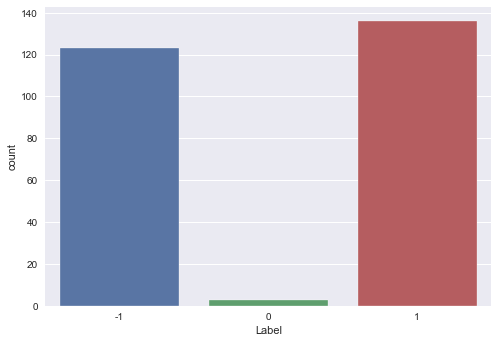

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

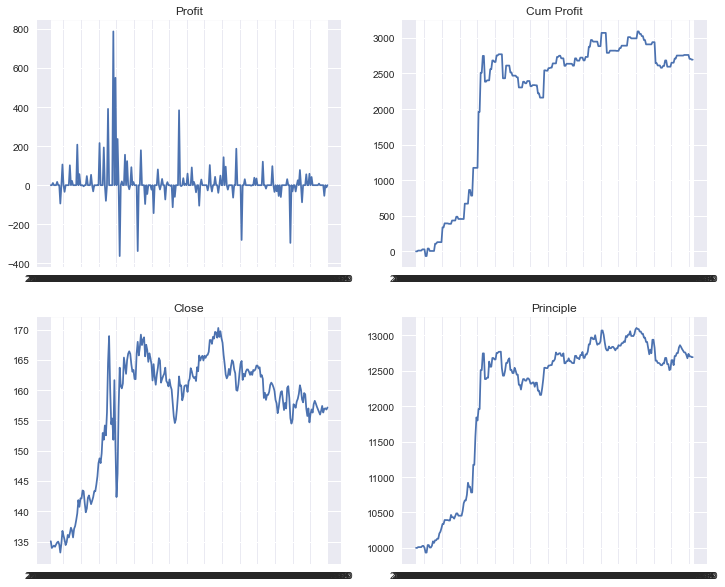

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  | 2693.74 |  26.94%  |    26.12%    |   259    |  2.2   |
| Buy & Hold | 1125.99 |  11.26%  |    10.81%    |   262    |  0.79  |
+------------+---------+----------+--------------+----------+--------+


In [217]:
TLT_y_trade_pred_rl = TLT[(TLT.index >= TLT_trade_start_actual) & (TLT.index <= trade_end)]
TLT_y_trade_pred_rl['Label'] = y_trade_pred
TLT_y_trade_pred_rl.to_csv('data/processed/TLT_y_trade_pred_rl.csv')
TLT_y_trade_pred_rl = pd.read_csv('data/processed/TLT_y_trade_pred_rl.csv', index_col='Date')

TLT_trading_log_trade_rl = get_trading_log(TLT_y_trade_pred_rl, principle=principle, percent=percent)
TLT_trading_log_trade_rl.to_csv('reports/TLT_trading_log_trade_rl.csv')
TLT_trading_log_trade_rl = pd.read_csv('reports/TLT_trading_log_trade_rl.csv', index_col='Date')
TLT_report_trade_rl, _ = get_trading_report(TLT_trading_log_trade_rl, show_fig=True)
print(TLT_report_trade_rl)

### USO

#### A2C

In [232]:
e_train_gym = create_env(USO_train, USO_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 31
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [233]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0005}
Using cuda device


In [234]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=500000)

Logging to tensorboard_log/a2c\a2c_24
-------------------------------------
| time/                 |           |
|    fps                | 317       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.52     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 99        |
|    policy_loss        | -0.000389 |
|    std                | 1.1       |
|    value_loss         | 6.67e-08  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 324      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.57    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates        

-------------------------------------
| time/                 |           |
|    fps                | 327       |
|    iterations         | 1500      |
|    time_elapsed       | 22        |
|    total_timesteps    | 7500      |
| train/                |           |
|    entropy_loss       | -2.22     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 1499      |
|    policy_loss        | -0.00103  |
|    std                | 2.23      |
|    value_loss         | 1.78e-07  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 325      |
|    iterations         | 1600     |
|    time_elapsed       | 24       |
|    total_timesteps    | 8000     |
| train/                |          |
|    entropy_loss       | -2.27    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 1599     |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 2900     |
|    time_elapsed       | 44       |
|    total_timesteps    | 14500    |
| train/                |          |
|    entropy_loss       | -2.91    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2899     |
|    policy_loss        | 0.00232  |
|    std                | 4.46     |
|    value_loss         | 9.44e-07 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 327      |
|    iterations         | 3000     |
|    time_elapsed       | 45       |
|    total_timesteps    | 15000    |
| train/                |          |
|    entropy_loss       | -2.96    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 2999     |
|    policy_loss        | 0.000515 |
|

------------------------------------
| time/                 |          |
|    fps                | 323      |
|    iterations         | 4300     |
|    time_elapsed       | 66       |
|    total_timesteps    | 21500    |
| train/                |          |
|    entropy_loss       | -3.6     |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4299     |
|    policy_loss        | 0.0066   |
|    std                | 8.89     |
|    value_loss         | 1.41e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 321      |
|    iterations         | 4400     |
|    time_elapsed       | 68       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -3.65    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 4399     |
|    policy_loss        | 0.000295 |
|

------------------------------------
| time/                 |          |
|    fps                | 312      |
|    iterations         | 5700     |
|    time_elapsed       | 91       |
|    total_timesteps    | 28500    |
| train/                |          |
|    entropy_loss       | -4.28    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 5699     |
|    policy_loss        | 0.000673 |
|    std                | 17.5     |
|    value_loss         | 1.13e-07 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 311       |
|    iterations         | 5800      |
|    time_elapsed       | 93        |
|    total_timesteps    | 29000     |
| train/                |           |
|    entropy_loss       | -4.33     |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 5799      |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 305      |
|    iterations         | 7100     |
|    time_elapsed       | 116      |
|    total_timesteps    | 35500    |
| train/                |          |
|    entropy_loss       | -4.9     |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 7099     |
|    policy_loss        | -0.00484 |
|    std                | 32.5     |
|    value_loss         | 7.63e-07 |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 7.48e+03  |
|    total_cost         | 0         |
|    total_reward       | -2.52e+03 |
|    total_reward_pct   | -25.2     |
|    total_trades       | 2556      |
| time/                 |           |
|    fps                | 304       |
|    iterations         | 7200      |
|    time_elapsed       | 118       |
|    total_timesteps    | 3

------------------------------------
| time/                 |          |
|    fps                | 301      |
|    iterations         | 8500     |
|    time_elapsed       | 141      |
|    total_timesteps    | 42500    |
| train/                |          |
|    entropy_loss       | -5.48    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 8499     |
|    policy_loss        | -0.0345  |
|    std                | 58.2     |
|    value_loss         | 6.83e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 300      |
|    iterations         | 8600     |
|    time_elapsed       | 142      |
|    total_timesteps    | 43000    |
| train/                |          |
|    entropy_loss       | -5.53    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 8599     |
|    policy_loss        | 0.0257   |
|

-------------------------------------
| time/                 |           |
|    fps                | 297       |
|    iterations         | 9900      |
|    time_elapsed       | 166       |
|    total_timesteps    | 49500     |
| train/                |           |
|    entropy_loss       | -6.05     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 9899      |
|    policy_loss        | 0.0138    |
|    std                | 103       |
|    value_loss         | 6.08e-06  |
-------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 7.51e+03  |
|    total_cost         | 0         |
|    total_reward       | -2.49e+03 |
|    total_reward_pct   | -24.9     |
|    total_trades       | 2684      |
| time/                 |           |
|    fps                | 297       |
|    iterations         | 10000     |
|    time_elapsed       | 168       |
|    total_t

------------------------------------
| time/                 |          |
|    fps                | 295      |
|    iterations         | 11300    |
|    time_elapsed       | 191      |
|    total_timesteps    | 56500    |
| train/                |          |
|    entropy_loss       | -6.59    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 11299    |
|    policy_loss        | -0.0143  |
|    std                | 176      |
|    value_loss         | 1.13e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 295      |
|    iterations         | 11400    |
|    time_elapsed       | 192      |
|    total_timesteps    | 57000    |
| train/                |          |
|    entropy_loss       | -6.64    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 11399    |
|    policy_loss        | -0.0016  |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 1.09e+04 |
|    total_cost         | 0        |
|    total_reward       | 904      |
|    total_reward_pct   | 9.04     |
|    total_trades       | 2692     |
| time/                 |          |
|    fps                | 293      |
|    iterations         | 12700    |
|    time_elapsed       | 216      |
|    total_timesteps    | 63500    |
| train/                |          |
|    entropy_loss       | -7.18    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 12699    |
|    policy_loss        | -0.0301  |
|    std                | 317      |
|    value_loss         | 2.64e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 293      |
|    iterations         | 12800    |
|    time_elapsed       | 217      |
|    total_timesteps    | 64000    |
|

------------------------------------
| time/                 |          |
|    fps                | 292      |
|    iterations         | 14100    |
|    time_elapsed       | 240      |
|    total_timesteps    | 70500    |
| train/                |          |
|    entropy_loss       | -7.73    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 14099    |
|    policy_loss        | -0.0391  |
|    std                | 550      |
|    value_loss         | 3.87e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 292      |
|    iterations         | 14200    |
|    time_elapsed       | 242      |
|    total_timesteps    | 71000    |
| train/                |          |
|    entropy_loss       | -7.77    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 14199    |
|    policy_loss        | 0.000635 |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 8.73e+03  |
|    total_cost         | 0         |
|    total_reward       | -1.27e+03 |
|    total_reward_pct   | -12.7     |
|    total_trades       | 2687      |
| time/                 |           |
|    fps                | 291       |
|    iterations         | 15500     |
|    time_elapsed       | 266       |
|    total_timesteps    | 77500     |
| train/                |           |
|    entropy_loss       | -8.3      |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0005    |
|    n_updates          | 15499     |
|    policy_loss        | 0.065     |
|    std                | 979       |
|    value_loss         | 6.31e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 291      |
|    iterations         | 15600    |
|    time_elapsed       | 268      |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 290      |
|    iterations         | 16900    |
|    time_elapsed       | 290      |
|    total_timesteps    | 84500    |
| train/                |          |
|    entropy_loss       | -8.9     |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 16899    |
|    policy_loss        | 0.00467  |
|    std                | 1.78e+03 |
|    value_loss         | 1.37e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 290      |
|    iterations         | 17000    |
|    time_elapsed       | 292      |
|    total_timesteps    | 85000    |
| train/                |          |
|    entropy_loss       | -8.95    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 16999    |
|    policy_loss        | -0.0234  |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 4.51e+03  |
|    total_cost         | 0         |
|    total_reward       | -5.49e+03 |
|    total_reward_pct   | -54.9     |
|    total_trades       | 2751      |
| time/                 |           |
|    fps                | 289       |
|    iterations         | 18300     |
|    time_elapsed       | 316       |
|    total_timesteps    | 91500     |
| train/                |           |
|    entropy_loss       | -9.42     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 18299     |
|    policy_loss        | 0.025     |
|    std                | 2.99e+03  |
|    value_loss         | 4.57e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 289      |
|    iterations         | 18400    |
|    time_elapsed       | 317      |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 288      |
|    iterations         | 19700    |
|    time_elapsed       | 341      |
|    total_timesteps    | 98500    |
| train/                |          |
|    entropy_loss       | -10      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 19699    |
|    policy_loss        | -0.00268 |
|    std                | 5.38e+03 |
|    value_loss         | 2.39e-07 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 288      |
|    iterations         | 19800    |
|    time_elapsed       | 343      |
|    total_timesteps    | 99000    |
| train/                |          |
|    entropy_loss       | -10.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 19799    |
|    policy_loss        | -0.0529  |
|

------------------------------------
| time/                 |          |
|    fps                | 287      |
|    iterations         | 21100    |
|    time_elapsed       | 367      |
|    total_timesteps    | 105500   |
| train/                |          |
|    entropy_loss       | -10.6    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 21099    |
|    policy_loss        | 0.0137   |
|    std                | 9.76e+03 |
|    value_loss         | 3.44e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 287      |
|    iterations         | 21200    |
|    time_elapsed       | 369      |
|    total_timesteps    | 106000   |
| train/                |          |
|    entropy_loss       | -10.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 21199    |
|    policy_loss        | -0.0813  |
|

------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 22500    |
|    time_elapsed       | 392      |
|    total_timesteps    | 112500   |
| train/                |          |
|    entropy_loss       | -11.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 22499    |
|    policy_loss        | 0.015    |
|    std                | 1.65e+04 |
|    value_loss         | 3.15e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 22600    |
|    time_elapsed       | 394      |
|    total_timesteps    | 113000   |
| train/                |          |
|    entropy_loss       | -11.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 22599    |
|    policy_loss        | 0.00436  |
|

------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 23900    |
|    time_elapsed       | 417      |
|    total_timesteps    | 119500   |
| train/                |          |
|    entropy_loss       | -11.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 23899    |
|    policy_loss        | -0.113   |
|    std                | 2.99e+04 |
|    value_loss         | 0.000122 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 24000    |
|    time_elapsed       | 419      |
|    total_timesteps    | 120000   |
| train/                |          |
|    entropy_loss       | -11.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 23999    |
|    policy_loss        | -0.141   |
|

------------------------------------
| time/                 |          |
|    fps                | 285      |
|    iterations         | 25300    |
|    time_elapsed       | 442      |
|    total_timesteps    | 126500   |
| train/                |          |
|    entropy_loss       | -12.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 25299    |
|    policy_loss        | 0.157    |
|    std                | 5.07e+04 |
|    value_loss         | 0.000295 |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 6.25e+03  |
|    total_cost         | 0         |
|    total_reward       | -3.75e+03 |
|    total_reward_pct   | -37.5     |
|    total_trades       | 2685      |
| time/                 |           |
|    fps                | 285       |
|    iterations         | 25400     |
|    time_elapsed       | 444       |
|    total_timesteps    | 1

------------------------------------
| time/                 |          |
|    fps                | 285      |
|    iterations         | 26700    |
|    time_elapsed       | 467      |
|    total_timesteps    | 133500   |
| train/                |          |
|    entropy_loss       | -12.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 26699    |
|    policy_loss        | -0.0145  |
|    std                | 8.75e+04 |
|    value_loss         | 2.1e-05  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 285      |
|    iterations         | 26800    |
|    time_elapsed       | 469      |
|    total_timesteps    | 134000   |
| train/                |          |
|    entropy_loss       | -12.8    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 26799    |
|    policy_loss        | 0.0127   |
|

------------------------------------
| time/                 |          |
|    fps                | 285      |
|    iterations         | 28100    |
|    time_elapsed       | 492      |
|    total_timesteps    | 140500   |
| train/                |          |
|    entropy_loss       | -13.4    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 28099    |
|    policy_loss        | -0.113   |
|    std                | 1.6e+05  |
|    value_loss         | 8.04e-05 |
------------------------------------
------------------------------------
| environment/          |          |
|    portfolio_value    | 9.28e+03 |
|    total_cost         | 0        |
|    total_reward       | -719     |
|    total_reward_pct   | -7.19    |
|    total_trades       | 2681     |
| time/                 |          |
|    fps                | 285      |
|    iterations         | 28200    |
|    time_elapsed       | 494      |
|    total_timesteps    | 141000   |
|

------------------------------------
| time/                 |          |
|    fps                | 284      |
|    iterations         | 29500    |
|    time_elapsed       | 518      |
|    total_timesteps    | 147500   |
| train/                |          |
|    entropy_loss       | -14      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 29499    |
|    policy_loss        | -0.0386  |
|    std                | 2.93e+05 |
|    value_loss         | 3.58e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 284      |
|    iterations         | 29600    |
|    time_elapsed       | 520      |
|    total_timesteps    | 148000   |
| train/                |          |
|    entropy_loss       | -14.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 29599    |
|    policy_loss        | -0.0209  |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 5.91e+03  |
|    total_cost         | 0         |
|    total_reward       | -4.09e+03 |
|    total_reward_pct   | -40.9     |
|    total_trades       | 2734      |
| time/                 |           |
|    fps                | 284       |
|    iterations         | 30900     |
|    time_elapsed       | 543       |
|    total_timesteps    | 154500    |
| train/                |           |
|    entropy_loss       | -14.5     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 30899     |
|    policy_loss        | 0.116     |
|    std                | 5.01e+05  |
|    value_loss         | 0.000206  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 284      |
|    iterations         | 31000    |
|    time_elapsed       | 545      |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 283      |
|    iterations         | 32300    |
|    time_elapsed       | 568      |
|    total_timesteps    | 161500   |
| train/                |          |
|    entropy_loss       | -15.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 32299    |
|    policy_loss        | 0.279    |
|    std                | 9.03e+05 |
|    value_loss         | 0.000391 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 284       |
|    iterations         | 32400     |
|    time_elapsed       | 570       |
|    total_timesteps    | 162000    |
| train/                |           |
|    entropy_loss       | -15.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 32399     |
|    policy_loss        | -

-------------------------------------
| environment/          |           |
|    portfolio_value    | 5.19e+03  |
|    total_cost         | 0         |
|    total_reward       | -4.81e+03 |
|    total_reward_pct   | -48.1     |
|    total_trades       | 2707      |
| time/                 |           |
|    fps                | 285       |
|    iterations         | 33700     |
|    time_elapsed       | 589       |
|    total_timesteps    | 168500    |
| train/                |           |
|    entropy_loss       | -15.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 33699     |
|    policy_loss        | -0.0604   |
|    std                | 1.52e+06  |
|    value_loss         | 1.87e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 285      |
|    iterations         | 33800    |
|    time_elapsed       | 591      |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 35100    |
|    time_elapsed       | 611      |
|    total_timesteps    | 175500   |
| train/                |          |
|    entropy_loss       | -16.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 35099    |
|    policy_loss        | -0.0626  |
|    std                | 2.6e+06  |
|    value_loss         | 1.55e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 287      |
|    iterations         | 35200    |
|    time_elapsed       | 613      |
|    total_timesteps    | 176000   |
| train/                |          |
|    entropy_loss       | -16.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 35199    |
|    policy_loss        | 0.0198   |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 1.04e+04  |
|    total_cost         | 0         |
|    total_reward       | 381       |
|    total_reward_pct   | 3.81      |
|    total_trades       | 2677      |
| time/                 |           |
|    fps                | 287       |
|    iterations         | 36500     |
|    time_elapsed       | 634       |
|    total_timesteps    | 182500    |
| train/                |           |
|    entropy_loss       | -16.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 36499     |
|    policy_loss        | -0.035    |
|    std                | 4.42e+06  |
|    value_loss         | 0.00021   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 287      |
|    iterations         | 36600    |
|    time_elapsed       | 636      |
|    total_timest

-------------------------------------
| time/                 |           |
|    fps                | 287       |
|    iterations         | 37900     |
|    time_elapsed       | 659       |
|    total_timesteps    | 189500    |
| train/                |           |
|    entropy_loss       | -17.2     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 37899     |
|    policy_loss        | 0.11      |
|    std                | 7.49e+06  |
|    value_loss         | 5.41e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 287      |
|    iterations         | 38000    |
|    time_elapsed       | 661      |
|    total_timesteps    | 190000   |
| train/                |          |
|    entropy_loss       | -17.3    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 37999    |
|    policy_loss       

-------------------------------------
| time/                 |           |
|    fps                | 287       |
|    iterations         | 39300     |
|    time_elapsed       | 684       |
|    total_timesteps    | 196500    |
| train/                |           |
|    entropy_loss       | -17.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 39299     |
|    policy_loss        | -0.0527   |
|    std                | 1.34e+07  |
|    value_loss         | 4.65e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 39400    |
|    time_elapsed       | 686      |
|    total_timesteps    | 197000   |
| train/                |          |
|    entropy_loss       | -17.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 39399    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 40700    |
|    time_elapsed       | 709      |
|    total_timesteps    | 203500   |
| train/                |          |
|    entropy_loss       | -18.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 40699    |
|    policy_loss        | -0.0148  |
|    std                | 2.32e+07 |
|    value_loss         | 1.12e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 40800    |
|    time_elapsed       | 711      |
|    total_timesteps    | 204000   |
| train/                |          |
|    entropy_loss       | -18.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 40799    |
|    policy_loss        | 0.00329  |
|

------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 42100    |
|    time_elapsed       | 734      |
|    total_timesteps    | 210500   |
| train/                |          |
|    entropy_loss       | -19      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 42099    |
|    policy_loss        | 0.0115   |
|    std                | 4.18e+07 |
|    value_loss         | 2.53e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 42200    |
|    time_elapsed       | 736      |
|    total_timesteps    | 211000   |
| train/                |          |
|    entropy_loss       | -19      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 42199    |
|    policy_loss        | -0.209   |
|

------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 43500    |
|    time_elapsed       | 759      |
|    total_timesteps    | 217500   |
| train/                |          |
|    entropy_loss       | -19.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 43499    |
|    policy_loss        | -0.0121  |
|    std                | 7.3e+07  |
|    value_loss         | 1.18e-06 |
------------------------------------
day: 2757, episode: 80
begin_total_asset: 10000.00
end_total_asset: 8427.28
total_reward: -1572.72
total_cost: 0.00
total_trades: 2720
Sharpe: -0.103
-------------------------------------
| environment/          |           |
|    portfolio_value    | 8.43e+03  |
|    total_cost         | 0         |
|    total_reward       | -1.57e+03 |
|    total_reward_pct   | -15.7     |
|    total_trades       | 2720      |
| time/                 |    

------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 44900    |
|    time_elapsed       | 784      |
|    total_timesteps    | 224500   |
| train/                |          |
|    entropy_loss       | -20.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 44899    |
|    policy_loss        | -0.0559  |
|    std                | 1.29e+08 |
|    value_loss         | 8.36e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 286      |
|    iterations         | 45000    |
|    time_elapsed       | 785      |
|    total_timesteps    | 225000   |
| train/                |          |
|    entropy_loss       | -20.1    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 44999    |
|    policy_loss        | -0.0265  |
|

-------------------------------------
| time/                 |           |
|    fps                | 285       |
|    iterations         | 46300     |
|    time_elapsed       | 809       |
|    total_timesteps    | 231500    |
| train/                |           |
|    entropy_loss       | -20.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 46299     |
|    policy_loss        | 0.0487    |
|    std                | 2.39e+08  |
|    value_loss         | 7.91e-06  |
-------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 7.21e+03  |
|    total_cost         | 0         |
|    total_reward       | -2.79e+03 |
|    total_reward_pct   | -27.9     |
|    total_trades       | 2716      |
| time/                 |           |
|    fps                | 285       |
|    iterations         | 46400     |
|    time_elapsed       | 811       |
|    total_t

------------------------------------
| time/                 |          |
|    fps                | 285      |
|    iterations         | 47700    |
|    time_elapsed       | 834      |
|    total_timesteps    | 238500   |
| train/                |          |
|    entropy_loss       | -21.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 47699    |
|    policy_loss        | -0.299   |
|    std                | 4.02e+08 |
|    value_loss         | 0.000544 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 285      |
|    iterations         | 47800    |
|    time_elapsed       | 836      |
|    total_timesteps    | 239000   |
| train/                |          |
|    entropy_loss       | -21.3    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 47799    |
|    policy_loss        | 0.248    |
|

day: 2757, episode: 90
begin_total_asset: 10000.00
end_total_asset: 6736.40
total_reward: -3263.60
total_cost: 0.00
total_trades: 2739
Sharpe: -0.234
-------------------------------------
| environment/          |           |
|    portfolio_value    | 6.74e+03  |
|    total_cost         | 0         |
|    total_reward       | -3.26e+03 |
|    total_reward_pct   | -32.6     |
|    total_trades       | 2739      |
| time/                 |           |
|    fps                | 285       |
|    iterations         | 49100     |
|    time_elapsed       | 860       |
|    total_timesteps    | 245500    |
| train/                |           |
|    entropy_loss       | -21.8     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 49099     |
|    policy_loss        | 0.0381    |
|    std                | 7.19e+08  |
|    value_loss         | 1.2e-05   |
-------------------------------------
------------------------------------
| time/        

------------------------------------
| time/                 |          |
|    fps                | 284      |
|    iterations         | 50500    |
|    time_elapsed       | 886      |
|    total_timesteps    | 252500   |
| train/                |          |
|    entropy_loss       | -22.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 50499    |
|    policy_loss        | 0.0388   |
|    std                | 1.26e+09 |
|    value_loss         | 3.65e-06 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 284      |
|    iterations         | 50600    |
|    time_elapsed       | 887      |
|    total_timesteps    | 253000   |
| train/                |          |
|    entropy_loss       | -22.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 50599    |
|    policy_loss        | -0.00114 |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 5.16e+03  |
|    total_cost         | 0         |
|    total_reward       | -4.84e+03 |
|    total_reward_pct   | -48.4     |
|    total_trades       | 2752      |
| time/                 |           |
|    fps                | 284       |
|    iterations         | 51900     |
|    time_elapsed       | 911       |
|    total_timesteps    | 259500    |
| train/                |           |
|    entropy_loss       | -23       |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 51899     |
|    policy_loss        | 0.0396    |
|    std                | 2.28e+09  |
|    value_loss         | 4.58e-06  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 284      |
|    iterations         | 52000    |
|    time_elapsed       | 913      |
|    total_timest

-------------------------------------
| time/                 |           |
|    fps                | 284       |
|    iterations         | 53300     |
|    time_elapsed       | 936       |
|    total_timesteps    | 266500    |
| train/                |           |
|    entropy_loss       | -23.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 53299     |
|    policy_loss        | -0.107    |
|    std                | 4.03e+09  |
|    value_loss         | 2.74e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 284      |
|    iterations         | 53400    |
|    time_elapsed       | 938      |
|    total_timesteps    | 267000   |
| train/                |          |
|    entropy_loss       | -23.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 53399    |
|    policy_loss       

day: 2757, episode: 100
begin_total_asset: 10000.00
end_total_asset: 6017.44
total_reward: -3982.56
total_cost: 0.00
total_trades: 2743
Sharpe: -0.398
-------------------------------------
| environment/          |           |
|    portfolio_value    | 6.02e+03  |
|    total_cost         | 0         |
|    total_reward       | -3.98e+03 |
|    total_reward_pct   | -39.8     |
|    total_trades       | 2743      |
| time/                 |           |
|    fps                | 284       |
|    iterations         | 54700     |
|    time_elapsed       | 962       |
|    total_timesteps    | 273500    |
| train/                |           |
|    entropy_loss       | -24.1     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 54699     |
|    policy_loss        | -0.0211   |
|    std                | 7.14e+09  |
|    value_loss         | 4.09e-05  |
-------------------------------------
------------------------------------
| time/       

------------------------------------
| time/                 |          |
|    fps                | 284      |
|    iterations         | 56100    |
|    time_elapsed       | 987      |
|    total_timesteps    | 280500   |
| train/                |          |
|    entropy_loss       | -24.7    |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 56099    |
|    policy_loss        | -0.0843  |
|    std                | 1.24e+10 |
|    value_loss         | 2.06e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 284      |
|    iterations         | 56200    |
|    time_elapsed       | 989      |
|    total_timesteps    | 281000   |
| train/                |          |
|    entropy_loss       | -24.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 56199    |
|    policy_loss        | -0.258   |
|

------------------------------------
| time/                 |          |
|    fps                | 283      |
|    iterations         | 57500    |
|    time_elapsed       | 1012     |
|    total_timesteps    | 287500   |
| train/                |          |
|    entropy_loss       | -25.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 57499    |
|    policy_loss        | -0.447   |
|    std                | 2.02e+10 |
|    value_loss         | 0.000467 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 283      |
|    iterations         | 57600    |
|    time_elapsed       | 1014     |
|    total_timesteps    | 288000   |
| train/                |          |
|    entropy_loss       | -25.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 57599    |
|    policy_loss        | 0.0436   |
|

------------------------------------
| time/                 |          |
|    fps                | 283      |
|    iterations         | 58900    |
|    time_elapsed       | 1038     |
|    total_timesteps    | 294500   |
| train/                |          |
|    entropy_loss       | -25.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 58899    |
|    policy_loss        | 0.4      |
|    std                | 3.59e+10 |
|    value_loss         | 0.000291 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 283       |
|    iterations         | 59000     |
|    time_elapsed       | 1040      |
|    total_timesteps    | 295000    |
| train/                |           |
|    entropy_loss       | -25.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 58999     |
|    policy_loss        | 0

------------------------------------
| time/                 |          |
|    fps                | 283      |
|    iterations         | 60300    |
|    time_elapsed       | 1063     |
|    total_timesteps    | 301500   |
| train/                |          |
|    entropy_loss       | -26.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 60299    |
|    policy_loss        | -0.234   |
|    std                | 6.24e+10 |
|    value_loss         | 9.55e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 283      |
|    iterations         | 60400    |
|    time_elapsed       | 1065     |
|    total_timesteps    | 302000   |
| train/                |          |
|    entropy_loss       | -26.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 60399    |
|    policy_loss        | -0.00566 |
|

------------------------------------
| time/                 |          |
|    fps                | 283      |
|    iterations         | 61700    |
|    time_elapsed       | 1089     |
|    total_timesteps    | 308500   |
| train/                |          |
|    entropy_loss       | -26.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 61699    |
|    policy_loss        | 0.0258   |
|    std                | 1.12e+11 |
|    value_loss         | 8.28e-06 |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 4.53e+03  |
|    total_cost         | 0         |
|    total_reward       | -5.47e+03 |
|    total_reward_pct   | -54.7     |
|    total_trades       | 2690      |
| time/                 |           |
|    fps                | 283       |
|    iterations         | 61800     |
|    time_elapsed       | 1090      |
|    total_timesteps    | 3

-------------------------------------
| time/                 |           |
|    fps                | 282       |
|    iterations         | 63100     |
|    time_elapsed       | 1114      |
|    total_timesteps    | 315500    |
| train/                |           |
|    entropy_loss       | -27.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 63099     |
|    policy_loss        | 0.205     |
|    std                | 2.08e+11  |
|    value_loss         | 6.16e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 282      |
|    iterations         | 63200    |
|    time_elapsed       | 1116     |
|    total_timesteps    | 316000   |
| train/                |          |
|    entropy_loss       | -27.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 63199    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 282      |
|    iterations         | 64500    |
|    time_elapsed       | 1140     |
|    total_timesteps    | 322500   |
| train/                |          |
|    entropy_loss       | -28      |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 64499    |
|    policy_loss        | 0.0485   |
|    std                | 3.49e+11 |
|    value_loss         | 5.56e-06 |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 9.53e+03  |
|    total_cost         | 0         |
|    total_reward       | -466      |
|    total_reward_pct   | -4.66     |
|    total_trades       | 2732      |
| time/                 |           |
|    fps                | 282       |
|    iterations         | 64600     |
|    time_elapsed       | 1142      |
|    total_timesteps    | 3

------------------------------------
| time/                 |          |
|    fps                | 282      |
|    iterations         | 65900    |
|    time_elapsed       | 1165     |
|    total_timesteps    | 329500   |
| train/                |          |
|    entropy_loss       | -28.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 65899    |
|    policy_loss        | 0.014    |
|    std                | 6.07e+11 |
|    value_loss         | 1.99e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 282      |
|    iterations         | 66000    |
|    time_elapsed       | 1167     |
|    total_timesteps    | 330000   |
| train/                |          |
|    entropy_loss       | -28.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 65999    |
|    policy_loss        | 0.37     |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 6.41e+03  |
|    total_cost         | 0         |
|    total_reward       | -3.59e+03 |
|    total_reward_pct   | -35.9     |
|    total_trades       | 2740      |
| time/                 |           |
|    fps                | 282       |
|    iterations         | 67300     |
|    time_elapsed       | 1191      |
|    total_timesteps    | 336500    |
| train/                |           |
|    entropy_loss       | -29.1     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0005    |
|    n_updates          | 67299     |
|    policy_loss        | -0.0901   |
|    std                | 1.05e+12  |
|    value_loss         | 1.55e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 282      |
|    iterations         | 67400    |
|    time_elapsed       | 1192     |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 282      |
|    iterations         | 68700    |
|    time_elapsed       | 1216     |
|    total_timesteps    | 343500   |
| train/                |          |
|    entropy_loss       | -29.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 68699    |
|    policy_loss        | 0.0191   |
|    std                | 1.76e+12 |
|    value_loss         | 5.76e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 282      |
|    iterations         | 68800    |
|    time_elapsed       | 1218     |
|    total_timesteps    | 344000   |
| train/                |          |
|    entropy_loss       | -29.7    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0005   |
|    n_updates          | 68799    |
|    policy_loss        | -0.145   |
|

------------------------------------
| environment/          |          |
|    portfolio_value    | 9.51e+03 |
|    total_cost         | 0        |
|    total_reward       | -494     |
|    total_reward_pct   | -4.94    |
|    total_trades       | 2697     |
| time/                 |          |
|    fps                | 282      |
|    iterations         | 70100    |
|    time_elapsed       | 1242     |
|    total_timesteps    | 350500   |
| train/                |          |
|    entropy_loss       | -30.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 70099    |
|    policy_loss        | 0.0891   |
|    std                | 3.19e+12 |
|    value_loss         | 0.00017  |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 282      |
|    iterations         | 70200    |
|    time_elapsed       | 1243     |
|    total_timesteps    | 351000   |
|

-------------------------------------
| time/                 |           |
|    fps                | 281       |
|    iterations         | 71500     |
|    time_elapsed       | 1267      |
|    total_timesteps    | 357500    |
| train/                |           |
|    entropy_loss       | -30.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 71499     |
|    policy_loss        | -0.0283   |
|    std                | 5.55e+12  |
|    value_loss         | 2.73e-06  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 281       |
|    iterations         | 71600     |
|    time_elapsed       | 1269      |
|    total_timesteps    | 358000    |
| train/                |           |
|    entropy_loss       | -30.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 71599     |
|    policy_

-------------------------------------
| environment/          |           |
|    portfolio_value    | 8.39e+03  |
|    total_cost         | 0         |
|    total_reward       | -1.61e+03 |
|    total_reward_pct   | -16.1     |
|    total_trades       | 2696      |
| time/                 |           |
|    fps                | 281       |
|    iterations         | 72900     |
|    time_elapsed       | 1293      |
|    total_timesteps    | 364500    |
| train/                |           |
|    entropy_loss       | -31.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 72899     |
|    policy_loss        | 1.39      |
|    std                | 9.92e+12  |
|    value_loss         | 0.00209   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 281      |
|    iterations         | 73000    |
|    time_elapsed       | 1294     |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 281      |
|    iterations         | 74300    |
|    time_elapsed       | 1318     |
|    total_timesteps    | 371500   |
| train/                |          |
|    entropy_loss       | -31.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 74299    |
|    policy_loss        | -0.00448 |
|    std                | 1.67e+13 |
|    value_loss         | 5.24e-07 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 281       |
|    iterations         | 74400     |
|    time_elapsed       | 1320      |
|    total_timesteps    | 372000    |
| train/                |           |
|    entropy_loss       | -31.9     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 74399     |
|    policy_loss        | -

------------------------------------
| time/                 |          |
|    fps                | 281      |
|    iterations         | 75700    |
|    time_elapsed       | 1343     |
|    total_timesteps    | 378500   |
| train/                |          |
|    entropy_loss       | -32.4    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 75699    |
|    policy_loss        | -0.354   |
|    std                | 2.9e+13  |
|    value_loss         | 0.000161 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 281      |
|    iterations         | 75800    |
|    time_elapsed       | 1345     |
|    total_timesteps    | 379000   |
| train/                |          |
|    entropy_loss       | -32.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 75799    |
|    policy_loss        | -0.26    |
|

-------------------------------------
| time/                 |           |
|    fps                | 281       |
|    iterations         | 77100     |
|    time_elapsed       | 1369      |
|    total_timesteps    | 385500    |
| train/                |           |
|    entropy_loss       | -33       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 77099     |
|    policy_loss        | -0.016    |
|    std                | 5.07e+13  |
|    value_loss         | 1.06e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 281       |
|    iterations         | 77200     |
|    time_elapsed       | 1370      |
|    total_timesteps    | 386000    |
| train/                |           |
|    entropy_loss       | -33       |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 77199     |
|    policy_

-------------------------------------
| time/                 |           |
|    fps                | 281       |
|    iterations         | 78500     |
|    time_elapsed       | 1394      |
|    total_timesteps    | 392500    |
| train/                |           |
|    entropy_loss       | -33.5     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 78499     |
|    policy_loss        | -0.56     |
|    std                | 8.52e+13  |
|    value_loss         | 0.000319  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 281      |
|    iterations         | 78600    |
|    time_elapsed       | 1396     |
|    total_timesteps    | 393000   |
| train/                |          |
|    entropy_loss       | -33.5    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 78599    |
|    policy_loss       

------------------------------------
| time/                 |          |
|    fps                | 281      |
|    iterations         | 79900    |
|    time_elapsed       | 1419     |
|    total_timesteps    | 399500   |
| train/                |          |
|    entropy_loss       | -34.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 79899    |
|    policy_loss        | -0.203   |
|    std                | 1.52e+14 |
|    value_loss         | 4.87e-05 |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 5.31e+03  |
|    total_cost         | 0         |
|    total_reward       | -4.69e+03 |
|    total_reward_pct   | -46.9     |
|    total_trades       | 2686      |
| time/                 |           |
|    fps                | 281       |
|    iterations         | 80000     |
|    time_elapsed       | 1421      |
|    total_timesteps    | 4

------------------------------------
| time/                 |          |
|    fps                | 281      |
|    iterations         | 81300    |
|    time_elapsed       | 1444     |
|    total_timesteps    | 406500   |
| train/                |          |
|    entropy_loss       | -34.6    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 81299    |
|    policy_loss        | -1.02    |
|    std                | 2.69e+14 |
|    value_loss         | 0.000971 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 281      |
|    iterations         | 81400    |
|    time_elapsed       | 1446     |
|    total_timesteps    | 407000   |
| train/                |          |
|    entropy_loss       | -34.7    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 81399    |
|    policy_loss        | 0.159    |
|

------------------------------------
| time/                 |          |
|    fps                | 281      |
|    iterations         | 82700    |
|    time_elapsed       | 1471     |
|    total_timesteps    | 413500   |
| train/                |          |
|    entropy_loss       | -35.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 82699    |
|    policy_loss        | -0.0622  |
|    std                | 4.99e+14 |
|    value_loss         | 4.07e-06 |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 1.03e+04  |
|    total_cost         | 0         |
|    total_reward       | 287       |
|    total_reward_pct   | 2.87      |
|    total_trades       | 2694      |
| time/                 |           |
|    fps                | 281       |
|    iterations         | 82800     |
|    time_elapsed       | 1472      |
|    total_timesteps    | 4

------------------------------------
| time/                 |          |
|    fps                | 281      |
|    iterations         | 84100    |
|    time_elapsed       | 1495     |
|    total_timesteps    | 420500   |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 84099    |
|    policy_loss        | 0.0137   |
|    std                | 8.54e+14 |
|    value_loss         | 1.75e-07 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 281      |
|    iterations         | 84200    |
|    time_elapsed       | 1497     |
|    total_timesteps    | 421000   |
| train/                |          |
|    entropy_loss       | -35.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 84199    |
|    policy_loss        | 0.118    |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 5.99e+03  |
|    total_cost         | 0         |
|    total_reward       | -4.01e+03 |
|    total_reward_pct   | -40.1     |
|    total_trades       | 2749      |
| time/                 |           |
|    fps                | 280       |
|    iterations         | 85500     |
|    time_elapsed       | 1521      |
|    total_timesteps    | 427500    |
| train/                |           |
|    entropy_loss       | -36.3     |
|    explained_variance | 1.19e-07  |
|    learning_rate      | 0.0005    |
|    n_updates          | 85499     |
|    policy_loss        | -0.132    |
|    std                | 1.44e+15  |
|    value_loss         | 2e-05     |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 85600    |
|    time_elapsed       | 1523     |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 86900    |
|    time_elapsed       | 1547     |
|    total_timesteps    | 434500   |
| train/                |          |
|    entropy_loss       | -36.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 86899    |
|    policy_loss        | -0.285   |
|    std                | 2.4e+15  |
|    value_loss         | 9.69e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 87000    |
|    time_elapsed       | 1548     |
|    total_timesteps    | 435000   |
| train/                |          |
|    entropy_loss       | -36.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 86999    |
|    policy_loss        | -0.0217  |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 4.02e+03  |
|    total_cost         | 0         |
|    total_reward       | -5.98e+03 |
|    total_reward_pct   | -59.8     |
|    total_trades       | 2750      |
| time/                 |           |
|    fps                | 280       |
|    iterations         | 88300     |
|    time_elapsed       | 1572      |
|    total_timesteps    | 441500    |
| train/                |           |
|    entropy_loss       | -37.4     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 88299     |
|    policy_loss        | -0.00688  |
|    std                | 4.11e+15  |
|    value_loss         | 4.73e-05  |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 88400    |
|    time_elapsed       | 1574     |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 89700    |
|    time_elapsed       | 1597     |
|    total_timesteps    | 448500   |
| train/                |          |
|    entropy_loss       | -37.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 89699    |
|    policy_loss        | 0.209    |
|    std                | 7.23e+15 |
|    value_loss         | 3.63e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 89800    |
|    time_elapsed       | 1599     |
|    total_timesteps    | 449000   |
| train/                |          |
|    entropy_loss       | -38      |
|    explained_variance | 1.19e-07 |
|    learning_rate      | 0.0005   |
|    n_updates          | 89799    |
|    policy_loss        | 0.0701   |
|

-------------------------------------
| environment/          |           |
|    portfolio_value    | 7.87e+03  |
|    total_cost         | 0         |
|    total_reward       | -2.13e+03 |
|    total_reward_pct   | -21.3     |
|    total_trades       | 2682      |
| time/                 |           |
|    fps                | 280       |
|    iterations         | 91100     |
|    time_elapsed       | 1623      |
|    total_timesteps    | 455500    |
| train/                |           |
|    entropy_loss       | -38.5     |
|    explained_variance | 0         |
|    learning_rate      | 0.0005    |
|    n_updates          | 91099     |
|    policy_loss        | 0.492     |
|    std                | 1.27e+16  |
|    value_loss         | 0.00017   |
-------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 91200    |
|    time_elapsed       | 1625     |
|    total_timest

------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 92500    |
|    time_elapsed       | 1648     |
|    total_timesteps    | 462500   |
| train/                |          |
|    entropy_loss       | -39.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 92499    |
|    policy_loss        | 0.117    |
|    std                | 2.32e+16 |
|    value_loss         | 1.75e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 92600    |
|    time_elapsed       | 1650     |
|    total_timesteps    | 463000   |
| train/                |          |
|    entropy_loss       | -39.1    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 92599    |
|    policy_loss        | 0.223    |
|

-------------------------------------
| time/                 |           |
|    fps                | 280       |
|    iterations         | 93900     |
|    time_elapsed       | 1674      |
|    total_timesteps    | 469500    |
| train/                |           |
|    entropy_loss       | -39.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 93899     |
|    policy_loss        | 0.101     |
|    std                | 4.28e+16  |
|    value_loss         | 1.97e-05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 280       |
|    iterations         | 94000     |
|    time_elapsed       | 1675      |
|    total_timesteps    | 470000    |
| train/                |           |
|    entropy_loss       | -39.7     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 93999     |
|    policy_

------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 95300    |
|    time_elapsed       | 1699     |
|    total_timesteps    | 476500   |
| train/                |          |
|    entropy_loss       | -40.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 95299    |
|    policy_loss        | -0.126   |
|    std                | 7.59e+16 |
|    value_loss         | 1.49e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 95400    |
|    time_elapsed       | 1701     |
|    total_timesteps    | 477000   |
| train/                |          |
|    entropy_loss       | -40.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 95399    |
|    policy_loss        | -0.655   |
|

------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 96700    |
|    time_elapsed       | 1725     |
|    total_timesteps    | 483500   |
| train/                |          |
|    entropy_loss       | -40.8    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 96699    |
|    policy_loss        | -0.738   |
|    std                | 1.29e+17 |
|    value_loss         | 0.000807 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 280       |
|    iterations         | 96800     |
|    time_elapsed       | 1727      |
|    total_timesteps    | 484000    |
| train/                |           |
|    entropy_loss       | -40.8     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0005    |
|    n_updates          | 96799     |
|    policy_loss        | 0

------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 98100    |
|    time_elapsed       | 1750     |
|    total_timesteps    | 490500   |
| train/                |          |
|    entropy_loss       | -41.3    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 98099    |
|    policy_loss        | -0.139   |
|    std                | 2.1e+17  |
|    value_loss         | 4.17e-05 |
------------------------------------
-------------------------------------
| environment/          |           |
|    portfolio_value    | 5.09e+03  |
|    total_cost         | 0         |
|    total_reward       | -4.91e+03 |
|    total_reward_pct   | -49.1     |
|    total_trades       | 2757      |
| time/                 |           |
|    fps                | 280       |
|    iterations         | 98200     |
|    time_elapsed       | 1752      |
|    total_timesteps    | 4

------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 99500    |
|    time_elapsed       | 1776     |
|    total_timesteps    | 497500   |
| train/                |          |
|    entropy_loss       | -41.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 99499    |
|    policy_loss        | 0.353    |
|    std                | 3.8e+17  |
|    value_loss         | 8.12e-05 |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 280      |
|    iterations         | 99600    |
|    time_elapsed       | 1778     |
|    total_timesteps    | 498000   |
| train/                |          |
|    entropy_loss       | -41.9    |
|    explained_variance | 0        |
|    learning_rate      | 0.0005   |
|    n_updates          | 99599    |
|    policy_loss        | -0.49    |
|

In [227]:
trained_a2c.save("models/USO_a2c")
trained_a2c = A2C.load("models/USO_a2c")

#### DDPG

In [241]:
e_train_gym = create_env(USO_train, USO_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 27
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [242]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 5e-06}
Using cuda device


In [387]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=100000)

Logging to tensorboard_log/ddpg\ddpg_5
day: 2767, episode: 40
begin_total_asset: 10000.00
end_total_asset: 10000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+04    |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 152      |
|    time_elapsed     | 72       |
|    total timesteps  | 11072    |
| train/              |          |
|    actor_loss       | 200      |
|    critic_loss      | 35.3     |
|    learning_rate    | 0.0001   |
|    n_updates        | 8304     |
----------------------------------
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+04    |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0  

In [409]:
trained_ddpg.save("models/USO_ddpg")
trained_ddpg = DDPG.load("models/USO_ddpg")

#### PPO

In [382]:
e_train_gym = create_env(USO_train, USO_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 27


In [388]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [389]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=100000)

Logging to tensorboard_log/ppo\ppo_4
-----------------------------
| time/              |      |
|    fps             | 480  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| environment/            |              |
|    portfolio_value      | 9.41e+03     |
|    total_cost           | 0            |
|    total_reward         | -585         |
|    total_reward_pct     | -5.85        |
|    total_trades         | 776          |
| time/                   |              |
|    fps                  | 442          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0024102805 |
|    clip_fraction        | 0.0417       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_varianc

-------------------------------------------
| environment/            |               |
|    portfolio_value      | 9.96e+03      |
|    total_cost           | 0             |
|    total_reward         | -44.8         |
|    total_reward_pct     | -0.448        |
|    total_trades         | 573           |
| time/                   |               |
|    fps                  | 409           |
|    iterations           | 10            |
|    time_elapsed         | 50            |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | 0.00036633573 |
|    clip_fraction        | 0.00464       |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.42         |
|    explained_variance   | 0.85          |
|    learning_rate        | 0.00025       |
|    loss                 | -0.0128       |
|    n_updates            | 90            |
|    policy_gradient_loss | 0.000281      |
|    std                  | 1.01

day: 2767, episode: 90
begin_total_asset: 10000.00
end_total_asset: 10000.88
total_reward: 0.88
total_cost: 0.00
total_trades: 476
Sharpe: 0.004
------------------------------------------
| environment/            |              |
|    portfolio_value      | 1e+04        |
|    total_cost           | 0            |
|    total_reward         | 0.88         |
|    total_reward_pct     | 0.0088       |
|    total_trades         | 476          |
| time/                   |              |
|    fps                  | 416          |
|    iterations           | 19           |
|    time_elapsed         | 93           |
|    total_timesteps      | 38912        |
| train/                  |              |
|    approx_kl            | 0.0033570803 |
|    clip_fraction        | 0.0171       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | 0.789        |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0153   

------------------------------------------
| environment/            |              |
|    portfolio_value      | 1.01e+04     |
|    total_cost           | 0            |
|    total_reward         | 82.2         |
|    total_reward_pct     | 0.822        |
|    total_trades         | 312          |
| time/                   |              |
|    fps                  | 420          |
|    iterations           | 28           |
|    time_elapsed         | 136          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0014387621 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.148        |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0141      |
|    n_updates            | 270          |
|    policy_gradient_loss | 0.00222      |
|    std                  | 1            |
|    value_

------------------------------------------
| environment/            |              |
|    portfolio_value      | 1e+04        |
|    total_cost           | 0            |
|    total_reward         | 40.9         |
|    total_reward_pct     | 0.409        |
|    total_trades         | 501          |
| time/                   |              |
|    fps                  | 422          |
|    iterations           | 36           |
|    time_elapsed         | 174          |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 0.0014317381 |
|    clip_fraction        | 0.0104       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.0391      |
|    learning_rate        | 0.00025      |
|    loss                 | -0.028       |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.000722    |
|    std                  | 1            |
|    value_

-----------------------------------------
| environment/            |             |
|    portfolio_value      | 9.67e+03    |
|    total_cost           | 0           |
|    total_reward         | -331        |
|    total_reward_pct     | -3.31       |
|    total_trades         | 590         |
| time/                   |             |
|    fps                  | 424         |
|    iterations           | 45          |
|    time_elapsed         | 217         |
|    total_timesteps      | 92160       |
| train/                  |             |
|    approx_kl            | 0.004158822 |
|    clip_fraction        | 0.0174      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | -0.0569     |
|    learning_rate        | 0.00025     |
|    loss                 | -0.00686    |
|    n_updates            | 440         |
|    policy_gradient_loss | 0.00198     |
|    std                  | 1.01        |
|    value_loss           | 0.0002

In [240]:
# trained_ppo.save("models/USO_ppo")
trained_ppo = PPO.load("models/USO_ppo")

#### TD3

In [382]:
e_train_gym = create_env(USO_train, USO_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 27


In [390]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.0001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.0001}
Using cuda device


In [391]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=100000)

Logging to tensorboard_log/td3\td3_4
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+04    |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 181      |
|    time_elapsed     | 60       |
|    total timesteps  | 11072    |
| train/              |          |
|    actor_loss       | -16.5    |
|    critic_loss      | 8.42     |
|    learning_rate    | 0.0001   |
|    n_updates        | 8304     |
----------------------------------
day: 2767, episode: 120
begin_total_asset: 10000.00
end_total_asset: 10000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+04    |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0   

In [411]:
trained_td3.save("models/USO_td3")
trained_td3 = TD3.load("models/USO_td3")

#### SAC

In [382]:
e_train_gym = create_env(USO_train, USO_selected_cols)
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 1, State Space: 27


In [392]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [393]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=100000)

Logging to tensorboard_log/sac\sac_8
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+04    |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 79       |
|    time_elapsed     | 139      |
|    total timesteps  | 11072    |
| train/              |          |
|    actor_loss       | 328      |
|    critic_loss      | 0.389    |
|    ent_coef         | 0.299    |
|    ent_coef_loss    | 38.5     |
|    learning_rate    | 0.0001   |
|    n_updates        | 10971    |
----------------------------------
----------------------------------
| environment/        |          |
|    portfolio_value  | 1e+04    |
|    total_cost       | 0        |
|    total_reward     | 0        |
|    total_reward_pct | 0        |
|    total_trades     | 0        |
| time/           

In [412]:
trained_sac.save("models/USO_sac")
trained_sac = SAC.load("models/USO_sac")

#### Model Evaluation

In [235]:
USO_trade = rl_formatting(USO_X_trade_final, USO, 'USO')
e_trade_gym = create_env(USO_trade, USO_selected_cols)

Stock Dimension: 1, State Space: 31


In [236]:
model = trained_a2c
df_account_value, df_actions = DRLAgent.DRL_prediction(model=model, environment = e_trade_gym)

hit end!


In [237]:
df_account_value.head()

date  account_value
0  <bound method _pandas_date of date            ...       10000.00
1  <bound method _pandas_date of date            ...       10000.16
2  <bound method _pandas_date of date            ...       10000.80
3  <bound method _pandas_date of date            ...        9999.60
4  <bound method _pandas_date of date            ...        9999.60

In [238]:
y_trade_pred = [0]
for i in range(len(df_actions)):
    y_trade_pred.append(df_actions.iloc[i,1][0])
print(y_trade_pred)

[0, 1, 1, -1, -1, 0, 0, 1, -1, 1, -1, 0, 0, 0, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1]


Prediction Trading Report

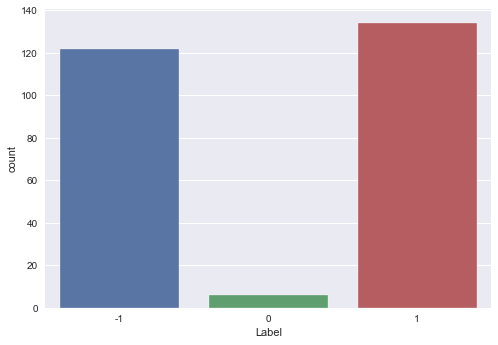

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

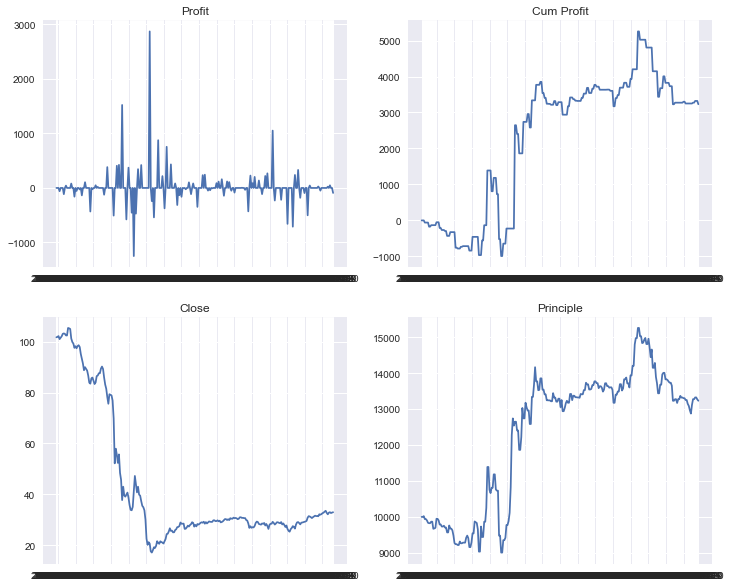

+------------+---------+----------+--------------+----------+--------+
|   Model    |  Profit | Profit % | Annualized % | Duration | Sharpe |
+------------+---------+----------+--------------+----------+--------+
|  Strategy  | 3229.75 |  32.30%  |    31.03%    |   261    |  0.97  |
| Buy & Hold | -4681.8 | -46.82%  |   -45.52%    |   262    |  -1.2  |
+------------+---------+----------+--------------+----------+--------+


In [239]:
USO_y_trade_pred_rl = USO[(USO.index >= USO_trade_start_actual) & (USO.index <= trade_end)]
USO_y_trade_pred_rl['Label'] = y_trade_pred
USO_y_trade_pred_rl.to_csv('data/processed/USO_y_trade_pred_rl.csv')
USO_y_trade_pred_rl = pd.read_csv('data/processed/USO_y_trade_pred_rl.csv', index_col='Date')

USO_trading_log_trade_rl = get_trading_log(USO_y_trade_pred_rl, principle=principle, percent=percent)
USO_trading_log_trade_rl.to_csv('reports/USO_trading_log_trade_rl.csv')
USO_trading_log_trade_rl = pd.read_csv('reports/USO_trading_log_trade_rl.csv', index_col='Date')
USO_report_trade_rl, _ = get_trading_report(USO_trading_log_trade_rl, show_fig=True)
print(USO_report_trade_rl)

# Conclusion

In [95]:
compare = pd.read_csv('Compare.csv')
compare

Stock          Model     Type   Score  Profit%  Sharpe  Profit Achieved  \
0    SPY  Meta-Labeling      NaN     NaN   272.45    6.74             1.00   
1    SPY       Baseline      NaN     NaN    -4.14   -0.10            -0.02   
2    TLT  Meta-Labeling      NaN     NaN   171.48    7.70             1.00   
3    TLT       Baseline      NaN     NaN    -7.39   -0.49            -0.04   
4    USO  Meta-Labeling      NaN     NaN  1565.81    7.58             1.00   
5    USO       Baseline      NaN     NaN    -2.64    0.15             0.00   
6    SPY           Clas      DTC    0.25   -23.83   -0.94            -0.09   
7    TLT           Clas      DTC    0.33    -0.20    0.02             0.00   
8    USO           Clas       GB    0.35   -23.24   -0.41            -0.01   
9    SPY           Clas      CNN    0.26   -27.06   -1.27            -0.10   
10   SPY           Clas     LSTM    0.37     4.45    0.31             0.02   
11   TLT           Clas      CNN    0.38    12.44    0.84             0.07   
12   TLT           Clas     LSTM    0.33   -12.20   -0.63            -0.07   
13   USO           Clas      CNN    0.29   -59.81   -2.25            -0.04   
14   USO           Clas     LSTM    0.30   -59.11   -1.43            -0.04   
15   SPY            Reg   Linear  145.86     3.31    0.25             0.01   
16   TLT            Reg    Ridge   14.80    13.48    0.94             0.08   
17   USO            Reg      GBR 2072.17   -27.92   -0.47            -0.02   
18   SPY            Reg      CNN  693.14    18.69    0.96             0.07   
19   SPY            Reg     LSTM 3697.49   -29.79   -1.48            -0.11   
20   TLT            Reg      CNN   19.88    -4.20   -0.22            -0.02   
21   TLT            Reg     LSTM   33.39     3.44    0.31             0.02   
22   USO            Reg      CNN  184.85    17.32    0.54             0.01   
23   USO            Reg     LSTM 1106.82     8.45    0.40             0.01   
24   SPY            Reg    ARIMA  168.31     9.30    0.51             0.03   
25   TLT            Reg    ARIMA   16.67    -4.60   -0.22            -0.03   
26   USO            Reg    ARIMA   32.35   124.56    2.23             0.08   
27   SPY            Reg  Prophet  613.06     0.00    0.00             0.00   
28   TLT            Reg  Prophet  543.21     0.00    0.00             0.00   
29   USO            Reg  Prophet 4572.46     0.00    0.00             0.00   
30   SPY             RL      A2C     NaN    30.24    1.56             0.11   
31   TLT             RL      A2C     NaN    26.12    2.20             0.15   
32   USO             RL      A2C     NaN    31.03    0.97             0.02   

    Sharpe Achieved  
0              1.00  
1             -0.01  
2              1.00  
3             -0.06  
4              1.00  
5              0.02  
6             -0.14  
7              0.00  
8             -0.05  
9             -0.19  
10             0.05  
11             0.11  
12            -0.08  
13            -0.30  
14            -0.19  
15             0.04  
16             0.12  
17            -0.06  
18             0.14  
19            -0.22  
20            -0.03  
21             0.04  
22             0.07  
23             0.05  
24             0.08  
25            -0.03  
26             0.29  
27             0.00  
28             0.00  
29             0.00  
30             0.23  
31             0.29  
32             0.13

In [96]:
compare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Stock            33 non-null     object 
 1   Model            33 non-null     object 
 2   Type             27 non-null     object 
 3   Score            24 non-null     float64
 4   Profit%          33 non-null     float64
 5   Sharpe           33 non-null     float64
 6   Profit Achieved  33 non-null     float64
 7   Sharpe Achieved  33 non-null     float64
dtypes: float64(5), object(3)
memory usage: 2.2+ KB


## Compare Models

In [97]:
pd.pivot_table(compare, index='Model', values='Profit%')

Profit%
Model                 
Baseline         -4.72
Clas            -20.95
Meta-Labeling   669.91
RL               29.13
Reg               8.80

In [98]:
pd.pivot_table(compare, index='Model', values='Sharpe')

Sharpe
Model                
Baseline        -0.15
Clas            -0.64
Meta-Labeling    7.34
RL               1.58
Reg              0.25

In [99]:
clas = compare[compare['Model']=='Clas']
clas

Stock Model  Type  Score  Profit%  Sharpe  Profit Achieved  Sharpe Achieved
6    SPY  Clas   DTC   0.25   -23.83   -0.94            -0.09            -0.14
7    TLT  Clas   DTC   0.33    -0.20    0.02             0.00             0.00
8    USO  Clas    GB   0.35   -23.24   -0.41            -0.01            -0.05
9    SPY  Clas   CNN   0.26   -27.06   -1.27            -0.10            -0.19
10   SPY  Clas  LSTM   0.37     4.45    0.31             0.02             0.05
11   TLT  Clas   CNN   0.38    12.44    0.84             0.07             0.11
12   TLT  Clas  LSTM   0.33   -12.20   -0.63            -0.07            -0.08
13   USO  Clas   CNN   0.29   -59.81   -2.25            -0.04            -0.30
14   USO  Clas  LSTM   0.30   -59.11   -1.43            -0.04            -0.19

In [100]:
reg = compare[compare['Model']=='Reg']
reg

Stock Model     Type   Score  Profit%  Sharpe  Profit Achieved  \
15   SPY   Reg   Linear  145.86     3.31    0.25             0.01   
16   TLT   Reg    Ridge   14.80    13.48    0.94             0.08   
17   USO   Reg      GBR 2072.17   -27.92   -0.47            -0.02   
18   SPY   Reg      CNN  693.14    18.69    0.96             0.07   
19   SPY   Reg     LSTM 3697.49   -29.79   -1.48            -0.11   
20   TLT   Reg      CNN   19.88    -4.20   -0.22            -0.02   
21   TLT   Reg     LSTM   33.39     3.44    0.31             0.02   
22   USO   Reg      CNN  184.85    17.32    0.54             0.01   
23   USO   Reg     LSTM 1106.82     8.45    0.40             0.01   
24   SPY   Reg    ARIMA  168.31     9.30    0.51             0.03   
25   TLT   Reg    ARIMA   16.67    -4.60   -0.22            -0.03   
26   USO   Reg    ARIMA   32.35   124.56    2.23             0.08   
27   SPY   Reg  Prophet  613.06     0.00    0.00             0.00   
28   TLT   Reg  Prophet  543.21     0.00    0.00             0.00   
29   USO   Reg  Prophet 4572.46     0.00    0.00             0.00   

    Sharpe Achieved  
15             0.04  
16             0.12  
17            -0.06  
18             0.14  
19            -0.22  
20            -0.03  
21             0.04  
22             0.07  
23             0.05  
24             0.08  
25            -0.03  
26             0.29  
27             0.00  
28             0.00  
29             0.00

In [101]:
rl = compare[compare['Model']=='RL']
rl

Stock Model Type  Score  Profit%  Sharpe  Profit Achieved  Sharpe Achieved
30   SPY    RL  A2C    NaN    30.24    1.56             0.11             0.23
31   TLT    RL  A2C    NaN    26.12    2.20             0.15             0.29
32   USO    RL  A2C    NaN    31.03    0.97             0.02             0.13

In [105]:
print('Classification Model with Highest Prediction Score')
ind = clas["Score"].idxmax()
clas.loc[ind,:]

Classification Model with Highest Prediction Score


Stock               TLT
Model              Clas
Type                CNN
Score              0.38
Profit%           12.44
Sharpe             0.84
Profit Achieved    0.07
Sharpe Achieved    0.11
Name: 11, dtype: object

In [106]:
print('Classification Model with Highest Profit Achieved')
ind = clas["Profit Achieved"].idxmax()
clas.loc[ind,:]

Classification Model with Highest Profit Achieved


Stock               TLT
Model              Clas
Type                CNN
Score              0.38
Profit%           12.44
Sharpe             0.84
Profit Achieved    0.07
Sharpe Achieved    0.11
Name: 11, dtype: object

In [107]:
print('Classification Model with Highest Sharpe Achieved')
ind = clas["Sharpe Achieved"].idxmax()
clas.loc[ind,:]

Classification Model with Highest Sharpe Achieved


Stock               TLT
Model              Clas
Type                CNN
Score              0.38
Profit%           12.44
Sharpe             0.84
Profit Achieved    0.07
Sharpe Achieved    0.11
Name: 11, dtype: object

In [108]:
print('Regression Model with Lowest Prediction Error')
ind = reg["Score"].idxmin()
reg.loc[ind,:]

Regression Model with Lowest Prediction Error


Stock                TLT
Model                Reg
Type               Ridge
Score               14.8
Profit%            13.48
Sharpe              0.94
Profit Achieved     0.08
Sharpe Achieved     0.12
Name: 16, dtype: object

In [109]:
print('Regression Model with Highest Profit Achieved')
ind = reg["Profit Achieved"].idxmax()
reg.loc[ind,:]

Regression Model with Highest Profit Achieved


Stock                TLT
Model                Reg
Type               Ridge
Score               14.8
Profit%            13.48
Sharpe              0.94
Profit Achieved     0.08
Sharpe Achieved     0.12
Name: 16, dtype: object

In [110]:
print('Regression Model with Highest Sharpe Achieved')
ind = reg["Sharpe Achieved"].idxmax()
reg.loc[ind,:]

Regression Model with Highest Sharpe Achieved


Stock                USO
Model                Reg
Type               ARIMA
Score              32.35
Profit%           124.56
Sharpe              2.23
Profit Achieved     0.08
Sharpe Achieved     0.29
Name: 26, dtype: object

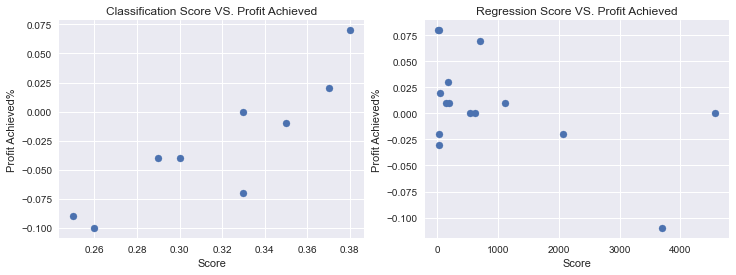

In [103]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(clas['Score'], clas['Profit Achieved'])
plt.xlabel('Score')
plt.ylabel('Profit Achieved%')
plt.title('Classification Score VS. Profit Achieved')

plt.subplot(1, 2, 2)
plt.scatter(reg['Score'], reg['Profit Achieved'])
plt.xlabel('Score')
plt.ylabel('Profit Achieved%')
plt.title('Regression Score VS. Profit Achieved');

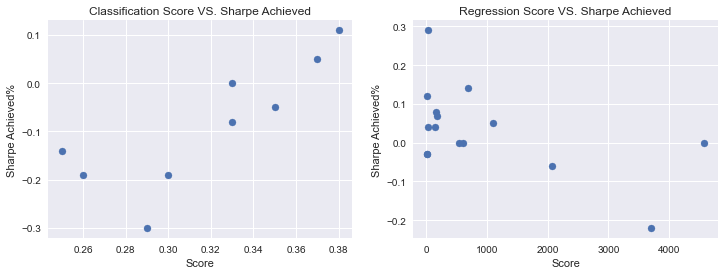

In [104]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter(clas['Score'], clas['Sharpe Achieved'])
plt.xlabel('Score')
plt.ylabel('Sharpe Achieved%')
plt.title('Classification Score VS. Sharpe Achieved')

plt.subplot(1, 2, 2)
plt.scatter(reg['Score'], reg['Sharpe Achieved'])
plt.xlabel('Score')
plt.ylabel('Sharpe Achieved%')
plt.title('Regression Score VS. Sharpe Achieved');

## Compare Stocks

In [111]:
pd.pivot_table(clas, columns='Stock', values='Score')

Stock  SPY  TLT  USO
Score 0.29 0.35 0.31

In [112]:
pd.pivot_table(reg, columns='Stock', values='Score')

Stock     SPY    TLT     USO
Score 1063.57 125.59 1593.73

In [113]:
pd.pivot_table(compare[compare['Model'] != 'Meta-Labeling'], index='Model', columns='Stock', values='Profit%')

Stock       SPY   TLT    USO
Model                       
Baseline  -4.14 -7.39  -2.64
Clas     -15.48  0.01 -47.39
RL        30.24 26.12  31.03
Reg        0.30  1.62  24.48

In [114]:
pd.pivot_table(compare[compare['Model'] != 'Meta-Labeling'], index='Model', columns='Stock', values='Profit Achieved')

Stock      SPY   TLT   USO
Model                     
Baseline -0.02 -0.04  0.00
Clas     -0.06  0.00 -0.03
RL        0.11  0.15  0.02
Reg       0.00  0.01  0.02

In [115]:
pd.pivot_table(compare[compare['Model'] != 'Meta-Labeling'], index='Model', columns='Stock', values='Sharpe')

Stock      SPY   TLT   USO
Model                     
Baseline -0.10 -0.49  0.15
Clas     -0.63  0.08 -1.36
RL        1.56  2.20  0.97
Reg       0.05  0.16  0.54

In [116]:
pd.pivot_table(compare[compare['Model'] != 'Meta-Labeling'], index='Model', columns='Stock', values='Sharpe Achieved')

Stock      SPY   TLT   USO
Model                     
Baseline -0.01 -0.06  0.02
Clas     -0.09  0.01 -0.18
RL        0.23  0.29  0.13
Reg       0.01  0.02  0.07